In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandapower as pp
from pandapower.networks import case14, case_ieee30, case118, case300, case4gs
from gekko import GEKKO
from pandapower.plotting.plotly import pf_res_plotly
import pandapower.plotting as pplot
from msc_rafael_pavan import otimizacao_pso_discreto_sengi
from msc_rafael_pavan import inicializa_sep
from msc_rafael_pavan import matriz_condutancia
from msc_rafael_pavan import coleta_dados_vbus
from msc_rafael_pavan import coleta_dados_gen
from msc_rafael_pavan import func_objetivo
from msc_rafael_pavan import pen_tensao
from msc_rafael_pavan import pen_ger_reativo
from msc_rafael_pavan import coleta_dados_trafo
from msc_rafael_pavan import pen_trafo
from msc_rafael_pavan import coleta_dados_bshunt
from msc_rafael_pavan import converte_trafo
from msc_rafael_pavan import cria_alcateia
from msc_rafael_pavan import cria_enxame
from msc_rafael_pavan import pen_bshunt
from msc_rafael_pavan import fluxo_de_pot
from msc_rafael_pavan import fitness
from msc_rafael_pavan import validacao
from msc_rafael_pavan import validacao_q
from msc_rafael_pavan import fluxo_de_pot_q

from msc_rafael_pavan import otimizacao_gwo_continuo
from msc_rafael_pavan import otimizacao_pso_continuo
from msc_rafael_pavan import discreto_bshunt
from msc_rafael_pavan import discreto_tap
from msc_rafael_pavan import otimizacao_gwo_discreto
from msc_rafael_pavan import otimizacao_pso_discreto
from msc_rafael_pavan import ipm_ieee30
from msc_rafael_pavan import ipm_ieee14
from msc_rafael_pavan import cria_enxame_v
import copy

from numba import jit
import time

sep_14 = case14()
sep_118 = case118()
sep_300 = case300()
sep_30 = case_ieee30()

v_init30 = inicializa_sep(sep_30,algorithm='fdbx', relatorio=False)

sep_14 = case14()
v_init14 = inicializa_sep(sep_14,algorithm='fdbx', relatorio=False)
sep_118 = case118()
v_init118 = inicializa_sep(sep_118,algorithm='fdbx', relatorio=False)

v_init300 = inicializa_sep(sep_300,algorithm='fdbx', relatorio=False)


In [2]:
def otimizacao_clpso_discreto_fpo(sep, refresh_gap, p1_,p2_,zeta, psi, sigma, omega, neta,max_iter, n_particles,c1,c2,v_amp,valor_inicial,step, wmax,wmin,relatorio=True,inicial=True):
        
    enxame_fit = cria_enxame_fpo(sep,n_particles)
    
    
    

        
    if len(sep.bus) == 14:
        
        n_vgen = 4+1
        n_tap = 3
        n_gens = 4
        n_bshunt = 1
    
    if len(sep.bus) == 30:
        
        n_vgen = 5+1
        n_tap = 4
        n_bshunt = 2
        n_gens = 5
        
    
    if len(sep.bus) == 118:
        
        n_vgen = 53+1
        n_tap = 9
        n_bshunt = 14
        n_gens=53
        
        
    if len(sep.bus) == 300:
        
        n_vgen = 68+1
        n_tap = 62
        n_bshunt = 29
        n_gens=68
    
  
        
    
    w_max=wmax
    w_min=wmin
    
    
    
    j = []
    
    
    tempo = []
        
    obj = []
    
    pen_v = []
    
    pen_gq = []
    
    pen_tap = []
    
    pen_bsh = []
    
    pen_slack = []

    
    v_lim_superior = np.repeat(sep.bus['max_vm_pu'][0], n_vgen)
    
    v_lim_inferior = np.repeat(sep.bus['min_vm_pu'][0], n_vgen)
    
    tap_pos, tap_neutral, tap_step_percent,valores_taps = coleta_dados_trafo(sep,relatorio=False)
    
    tap_max = np.repeat(valores_taps[-1], len(tap_pos))
    
    tap_min = np.repeat(valores_taps[0], len(tap_pos))
    
    max_pot = sep.gen['max_p_mw'].values/100
    
    min_pot = sep.gen['min_p_mw'].values/100
    
    bsh,b=coleta_dados_bshunt(sep)

    bsh_max=[]
    
    bsh_min=[]
    
    l_v =[]
    l_q=[]
    l_p=[]
    l_o =[]
    
    refresh_rate = np.zeros((n_particles))
    

    for bs in bsh:
        bsh_max.append([np.max(bs)])
        bsh_min.append([np.min(bs)])


    maximo = np.expand_dims(np.concatenate((v_lim_superior, tap_max, bsh_max, max_pot), axis = None), 0)
    minimo = np.expand_dims(np.concatenate((v_lim_inferior, tap_min, bsh_min, min_pot), axis = None), 0)
     
    
    lim_sup = np.tile(maximo, (n_particles,1))
    lim_inf = np.tile(minimo, (n_particles,1))
    
    v_anterior = v_amp*cria_enxame_fpo(sep,n_particles)
    
    delta= np.abs(lim_sup-lim_inf)[0,:]
    xk = []

    if inicial == True:
        
        for i in range(int(n_particles/2)):
            
            enxame_fit[i,:]=valor_inicial + np.concatenate((delta,np.array([0,0,0,0,0,0,0])))*np.random.randn(1, enxame_fit.shape[1])*0.01
            
            
    for i in range(0,max_iter):
        

            
        start = time.time()
        
#         mu, sigmma = 0.5, 0.152 # mean and standard deviation

#         r1 = np.random.normal(mu, sigmma, size = (n_particles,enxame_fit.shape[1]))
#         r2 = np.random.normal(mu, sigmma, size = (n_particles,enxame_fit.shape[1]))
        
        r1 = np.random.random_sample(size = (n_particles,enxame_fit.shape[1]))
        
        r2 = np.random.random_sample(size = (n_particles,enxame_fit.shape[1]))

#         r1 = np.random.uniform(0,1)
#         r2 = np.random.uniform(0,1)

        enxame_fit_d = np.copy(enxame_fit)
    
        for linha in range(n_particles):
          
            enxame_fit_d[linha][n_vgen:n_vgen+n_tap] = discreto_tap(enxame_fit[linha].copy(),n_tap,n_vgen,n_bshunt,sep)
            enxame_fit_d[linha][n_vgen+n_tap:n_vgen+n_tap+n_bshunt] = discreto_bshunt(enxame_fit[linha].copy(),n_tap,n_vgen,n_bshunt,sep)
     
        enxame_fit[:,-7:] = (fluxo_de_pot_fpo(enxame_fit_d,sep))[:,-7:]
     
        enxame_fit[:,-7:] = (fitness_fpo(enxame_fit,zeta,psi,sigma,omega,neta))[:,-7:]
       
        xk.append(enxame_fit.copy())
       
        
        if i==0:
            
            best_particles = enxame_fit.copy()

            l_q.append(enxame_fit[:,-5])

            l_o.append(enxame_fit[:,-7])
            l_p.append(enxame_fit[:,-2])
            l_v.append(enxame_fit[:,-6])

            max_v = np.max(l_v) 

            min_v = np.min(l_v)

            max_o = np.max(l_o)

            min_o = np.min(l_o)

            max_q = np.max(l_q)

            min_q = np.min(l_q)


            max_p = np.max(l_p)
            min_p = np.min(l_p)

            bpq = (best_particles[:,-5]-min_q)/(max_q-min_q+1e-15)

            efq = (enxame_fit[:,-5]-min_q)/(max_q-min_q+1e-15)

            bpv = (best_particles[:,-6]-min_v)/(max_v-min_v+1e-15)

            efv = (enxame_fit[:,-6]-min_v)/(max_v-min_v+1e-15)

            bpo = (best_particles[:,-7]-min_o)/(max_o-min_o+1e-15)

            efo = (enxame_fit[:,-7]-min_o)/(max_o-min_o+1e-15)

            bpp = (best_particles[:,-2]-min_p)/(max_p-min_p+1e-15)

            efp = (enxame_fit[:,-2]-min_p)/(max_p-min_p+1e-15)
            
#             enxame_fit[:,-1] = np.sqrt(efo**2 + np.mean(efv+efq+efp)**2)

#             best_particles[:,-1] = np.sqrt(bpo**2 + np.mean(bpv +bpq+bpp)**2)

            global_best = best_particles[np.argsort(best_particles[:, -1])][0,:].copy()
            
            global_matriz = np.tile(global_best, (n_particles,1))
            
#             contador = 0    
            
            pbestfi = np.copy(best_particles)
        
        
        
    
        l_q.append(enxame_fit[:,-5])
        
        l_o.append(enxame_fit[:,-7])
        l_p.append(enxame_fit[:,-2])
        l_v.append(enxame_fit[:,-6])
        
        max_v = np.max(l_v) 
         
        min_v = np.min(l_v)
    
        max_o = np.max(l_o)
      
        min_o = np.min(l_o)
        
        max_q = np.max(l_q)
        
        min_q = np.min(l_q)
        
        
        max_p = np.max(l_p)
        min_p = np.min(l_p)
    
        
            
        bpq = (best_particles[:,-5]-min_q)/(max_q-min_q+1e-15)
        
        efq = (enxame_fit[:,-5]-min_q)/(max_q-min_q+1e-15)
        
        bpv = (best_particles[:,-6]-min_v)/(max_v-min_v+1e-15)
        
        efv = (enxame_fit[:,-6]-min_v)/(max_v-min_v+1e-15)
        
        bpo = (best_particles[:,-7]-min_o)/(max_o-min_o+1e-15)
        
        efo = (enxame_fit[:,-7]-min_o)/(max_o-min_o+1e-15)
        
        bpp = (best_particles[:,-2]-min_p)/(max_p-min_p+1e-15)
        
        efp = (enxame_fit[:,-2]-min_p)/(max_p-min_p+1e-15)
        
            
#         enxame_fit[:,-1] = np.sqrt(efo**2 + np.mean(efv+efq+efp)**2)

#         best_particles[:,-1] = np.sqrt(bpo**2 + np.mean(bpv +bpq+bpp)**2)
                
        for t in range(0,n_particles):
                
            if (enxame_fit[t,-1] < best_particles[t,-1]):
        
                best_particles[t,:] = enxame_fit[t,:].copy()
            
                refresh_rate[t] = 0
            
            else: refresh_rate[t] = refresh_rate[t] + 1
        
        ps = np.arange(start=1,stop=n_particles+1,step=1)
                
        prob = p1_ + p2_*(np.exp((10*(ps-1)/(n_particles-1)))-1)/(np.exp(10)-1)
                                                
        global_best = best_particles[np.copy(np.argsort(best_particles[:, -1]))][0,:]
        
        
        for li in range(n_particles):
            
            if refresh_rate[li] >= refresh_gap:
                
                pbestfi[li,:]=best_particles[li,:]
                
                refresh_rate[li] = 0

                for co in range(len(global_best)-7):
                                           
                    
                    if np.random.rand()<= prob[li]:

                        p1 = int(np.floor(n_particles*np.random.rand()))

                        p2 = int(np.floor(n_particles*np.random.rand()))

                        while(p1==p2):


                            p1 = int(np.floor(n_particles*np.random.rand()))

                            p2 = int(np.floor(n_particles*np.random.rand()))


                        part1 = best_particles[p1,:]

                        part2 = best_particles[p2,:]

                        if part1[-1] <= part2[-1]:

                            pbestfi[li,co] = part1[co]

                        else:
                            pbestfi[li,co] = part2[co]


        
        global_matriz = np.tile(global_best, (n_particles,1))   
            
        enxame_fit_anterior = enxame_fit.copy()
            
    
        w_novo = w_max-(w_max-w_min)*(i+1)/max_iter 
            
                        
        v_novo = np.multiply(w_novo,v_anterior.copy()) + c1*np.multiply(r1,(pbestfi.copy()-enxame_fit.copy())) + c2*np.multiply(r2,(global_matriz.copy()-enxame_fit.copy()))
               
        for l in range(v_novo.shape[0]):
        
            for c in range(len(delta)):
                
                if v_novo[l,c] > delta[c]*step:
                    
                    v_novo[l,c] = delta[c]*step
                    
                    
                if v_novo[l,c] < -delta[c]*step:
                    
                    v_novo[l,c] = -delta[c]*step
                    
        
#         if i<1:
#             enxame_fit_novo = enxame_fit_anterior  + v_novo
        
#         if i>=1:


#             for p in range(0,n_particles): 

                
                
#                 for coluna in range(len(global_best)):
                        
#                     if xk[i][p,-1] > xk[i-1][p,-1]:
                            
#                         enxame_fit_novo[p,coluna] = xk[i][p,coluna].copy()  + v_novo[p,coluna]
                        
#                     if xk[i][p,-1] < xk[i-1][p,-1]:

#                         if xk[i][p,coluna] > xk[i-1][p,coluna]:

#                             enxame_fit_novo[p,coluna] = xk[i][p,coluna].copy()  + 1*np.abs(v_novo[p,coluna])

#                         if xk[i][p,coluna] == xk[i-1][p,coluna]:

#                             enxame_fit_novo[p,coluna] = xk[i][p,coluna].copy()  + 0*v_novo[p,coluna]

#                         if xk[i][p,coluna] < xk[i-1][p,coluna]:

#                             enxame_fit_novo[p,coluna] = xk[i][p,coluna].copy() + -1*np.abs(v_novo[p,coluna])
                            
        enxame_fit_novo = enxame_fit_anterior  + v_novo
        
    
        v_anterior = v_novo.copy()
        
#         delta = lim_sup[0,:]-lim_inf[0,:]
        
#         step = 0.25
        
#         for k in range(int(n_particles/10)):
            
#             mutacao=(np.random.randn(len(global_best[:-6])))*step*delta
            
#             posi = np.random.randint(0,n_particles)
            
#             enxame_fit_novo[posi,:-6] = enxame_fit_novo[posi,:-6] + mutacao
            
        
        
#         for linha in range(n_particles):
          
#             enxame_fit_novo[linha][n_vgen:n_vgen+n_tap] = discreto_tap(enxame_fit_novo[linha],n_tap,n_vgen,n_bshunt,sep)
#             enxame_fit_novo[linha][n_vgen+n_tap:n_vgen+n_tap+n_bshunt] = discreto_bshunt(enxame_fit_novo[linha],n_tap,n_vgen,n_bshunt,sep)
            
        
        
        enxame_estat = enxame_fit_novo[:,-7:]

        enxame_fit = np.concatenate(( np.clip(enxame_fit_novo[:,0:-7], a_min = lim_inf, a_max = lim_sup, out = enxame_fit_novo[:,0:-7]),enxame_estat),axis=1)   

        end = time.time()

        elapsed = end - start

        j.append(global_best[-1])

        obj.append(global_best[-7])

        pen_v.append(global_best[-6])

        pen_gq.append(global_best[-5])

        pen_tap.append(global_best[-4])

        pen_bsh.append(global_best[-3])
        
        pen_slack.append(global_best[-2])
        
        tempo.append(elapsed)
      

        if relatorio == True:
            
            print(' ')

            print('Melhor Global da Iteração:',i)

            print('Objetivo:', global_best[-7])

            print('Penalização de Tensão:', global_best[-6])

            print('Penalização de Geração de Reativo:', global_best[-5])
            
            print('Penalização do Gerador Slack (P):', global_best[-2])

            print('Fitness:', global_best[-1])

            
            print('Tempo: ', elapsed)

            print(' ')

            print('_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ')
            
            
    
    if relatorio == True:
        
            plt.figure(figsize=(18,10))
            plt.plot(obj)
            
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Objetivo')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(j)
            
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Fitness (J)')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_v)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização de Tensão')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_gq)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização de Geração de Reativo')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_tap)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização do TAP')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_bsh)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização do BShunt')
            plt.xlabel('Número da Iteração')
                       
            
    return j,obj,pen_v,pen_gq,pen_tap,pen_bsh, pen_slack, global_best, tempo, delta


In [3]:
def otimizacao_pso_discreto_fpo(sep, refresh_gap, p1_,p2_,zeta, psi, sigma, omega, neta,max_iter, n_particles,c1,c2,v_amp,valor_inicial,step, wmax,wmin,relatorio=True,inicial=True):
        
    enxame_fit = cria_enxame_fpo(sep,n_particles)
    
    
    

        
    if len(sep.bus) == 14:
        
        n_vgen = 4+1
        n_tap = 3
        n_gens = 4
        n_bshunt = 1
    
    if len(sep.bus) == 30:
        
        n_vgen = 5+1
        n_tap = 4
        n_bshunt = 2
        n_gens = 5
        
    
    if len(sep.bus) == 118:
        
        n_vgen = 53+1
        n_tap = 9
        n_bshunt = 14
        n_gens=53
        
        
    if len(sep.bus) == 300:
        
        n_vgen = 68+1
        n_tap = 62
        n_bshunt = 29
        n_gens=68
    
  
        
    
    w_max=wmax
    w_min=wmin
    
    
    
    j = []
    
    
    tempo = []
        
    obj = []
    
    pen_v = []
    
    pen_gq = []
    
    pen_tap = []
    
    pen_bsh = []
    
    pen_slack = []

    
    v_lim_superior = np.repeat(sep.bus['max_vm_pu'][0], n_vgen)
    
    v_lim_inferior = np.repeat(sep.bus['min_vm_pu'][0], n_vgen)
    
    tap_pos, tap_neutral, tap_step_percent,valores_taps = coleta_dados_trafo(sep,relatorio=False)
    
    tap_max = np.repeat(valores_taps[-1], len(tap_pos))
    
    tap_min = np.repeat(valores_taps[0], len(tap_pos))
    
    max_pot = sep.gen['max_p_mw'].values/100
    
    min_pot = sep.gen['min_p_mw'].values/100
    
    bsh,b=coleta_dados_bshunt(sep)

    bsh_max=[]
    
    bsh_min=[]
    
    l_v =[]
    l_q=[]
    l_p=[]
    l_o =[]
    
    refresh_rate = np.zeros((n_particles))
    

    for bs in bsh:
        bsh_max.append([np.max(bs)])
        bsh_min.append([np.min(bs)])


    maximo = np.expand_dims(np.concatenate((v_lim_superior, tap_max, bsh_max, max_pot), axis = None), 0)
    minimo = np.expand_dims(np.concatenate((v_lim_inferior, tap_min, bsh_min, min_pot), axis = None), 0)
     
    
    lim_sup = np.tile(maximo, (n_particles,1))
    lim_inf = np.tile(minimo, (n_particles,1))
    
    v_anterior = v_amp*cria_enxame_fpo(sep,n_particles)
    
    delta= np.abs(lim_sup-lim_inf)[0,:]
    xk = []

    if inicial == True:
        
        for i in range(int(n_particles/2)):
            
            enxame_fit[i,:]=valor_inicial + np.concatenate((delta,np.array([0,0,0,0,0,0,0])))*np.random.randn(1, enxame_fit.shape[1])*0.01
            
            
    for i in range(0,max_iter):
        

            
        start = time.time()
        
#         mu, sigmma = 0.5, 0.152 # mean and standard deviation

#         r1 = np.random.normal(mu, sigmma, size = (n_particles,enxame_fit.shape[1]))
#         r2 = np.random.normal(mu, sigmma, size = (n_particles,enxame_fit.shape[1]))
        
        r1 = np.random.random_sample(size = (n_particles,enxame_fit.shape[1]))
        
        r2 = np.random.random_sample(size = (n_particles,enxame_fit.shape[1]))

#         r1 = np.random.uniform(0,1)
#         r2 = np.random.uniform(0,1)

        enxame_fit_d = np.copy(enxame_fit)
    
        for linha in range(n_particles):
          
            enxame_fit_d[linha][n_vgen:n_vgen+n_tap] = discreto_tap(enxame_fit[linha].copy(),n_tap,n_vgen,n_bshunt,sep)
            enxame_fit_d[linha][n_vgen+n_tap:n_vgen+n_tap+n_bshunt] = discreto_bshunt(enxame_fit[linha].copy(),n_tap,n_vgen,n_bshunt,sep)
     
        enxame_fit[:,-7:] = (fluxo_de_pot_fpo(enxame_fit_d,sep))[:,-7:]
     
        enxame_fit[:,-7:] = (fitness_fpo(enxame_fit,zeta,psi,sigma,omega,neta))[:,-7:]
       
        xk.append(enxame_fit.copy())
       
        
        if i==0:
            
            best_particles = enxame_fit.copy()

            l_q.append(enxame_fit[:,-5])

            l_o.append(enxame_fit[:,-7])
            l_p.append(enxame_fit[:,-2])
            l_v.append(enxame_fit[:,-6])

            max_v = np.max(l_v) 

            min_v = np.min(l_v)

            max_o = np.max(l_o)

            min_o = np.min(l_o)

            max_q = np.max(l_q)

            min_q = np.min(l_q)


            max_p = np.max(l_p)
            min_p = np.min(l_p)

            bpq = (best_particles[:,-5]-min_q)/(max_q-min_q+1e-15)

            efq = (enxame_fit[:,-5]-min_q)/(max_q-min_q+1e-15)

            bpv = (best_particles[:,-6]-min_v)/(max_v-min_v+1e-15)

            efv = (enxame_fit[:,-6]-min_v)/(max_v-min_v+1e-15)

            bpo = (best_particles[:,-7]-min_o)/(max_o-min_o+1e-15)

            efo = (enxame_fit[:,-7]-min_o)/(max_o-min_o+1e-15)

            bpp = (best_particles[:,-2]-min_p)/(max_p-min_p+1e-15)

            efp = (enxame_fit[:,-2]-min_p)/(max_p-min_p+1e-15)
            
#             enxame_fit[:,-1] = np.sqrt(efo**2 + np.mean(efv+efq+efp)**2)

#             best_particles[:,-1] = np.sqrt(bpo**2 + np.mean(bpv +bpq+bpp)**2)

            global_best = best_particles[np.argsort(best_particles[:, -1])][0,:].copy()
            
            global_matriz = np.tile(global_best, (n_particles,1))
            
#             contador = 0    
            
            pbestfi = np.copy(best_particles)
        
        
        
    
        l_q.append(enxame_fit[:,-5])
        
        l_o.append(enxame_fit[:,-7])
        l_p.append(enxame_fit[:,-2])
        l_v.append(enxame_fit[:,-6])
        
        max_v = np.max(l_v) 
         
        min_v = np.min(l_v)
    
        max_o = np.max(l_o)
      
        min_o = np.min(l_o)
        
        max_q = np.max(l_q)
        
        min_q = np.min(l_q)
        
        
        max_p = np.max(l_p)
        min_p = np.min(l_p)
    
        
            
        bpq = (best_particles[:,-5]-min_q)/(max_q-min_q+1e-15)
        
        efq = (enxame_fit[:,-5]-min_q)/(max_q-min_q+1e-15)
        
        bpv = (best_particles[:,-6]-min_v)/(max_v-min_v+1e-15)
        
        efv = (enxame_fit[:,-6]-min_v)/(max_v-min_v+1e-15)
        
        bpo = (best_particles[:,-7]-min_o)/(max_o-min_o+1e-15)
        
        efo = (enxame_fit[:,-7]-min_o)/(max_o-min_o+1e-15)
        
        bpp = (best_particles[:,-2]-min_p)/(max_p-min_p+1e-15)
        
        efp = (enxame_fit[:,-2]-min_p)/(max_p-min_p+1e-15)
        
            
#         enxame_fit[:,-1] = np.sqrt(efo**2 + np.mean(efv+efq+efp)**2)

#         best_particles[:,-1] = np.sqrt(bpo**2 + np.mean(bpv +bpq+bpp)**2)
                
        for t in range(0,n_particles):
                
            if (enxame_fit[t,-1] < best_particles[t,-1]):
        
                best_particles[t,:] = enxame_fit[t,:].copy()
            
                refresh_rate[t] = 0
            
            else: refresh_rate[t] = refresh_rate[t] + 1
        
        ps = np.arange(start=1,stop=n_particles+1,step=1)
                
        prob = p1_ + p2_*(np.exp((10*(ps-1)/(n_particles-1)))-1)/(np.exp(10)-1)
                                                
        global_best = best_particles[np.copy(np.argsort(best_particles[:, -1]))][0,:]
        
        
        for li in range(n_particles):
            
            if refresh_rate[li] >= refresh_gap:
                
                pbestfi[li,:]=best_particles[li,:]
                
                refresh_rate[li] = 0

                for co in range(len(global_best)-7):
                                           
                    
                    if np.random.rand()<= prob[li]:

                        p1 = int(np.floor(n_particles*np.random.rand()))

                        p2 = int(np.floor(n_particles*np.random.rand()))

                        while(p1==p2):


                            p1 = int(np.floor(n_particles*np.random.rand()))

                            p2 = int(np.floor(n_particles*np.random.rand()))


                        part1 = best_particles[p1,:]

                        part2 = best_particles[p2,:]

                        if part1[-1] <= part2[-1]:

                            pbestfi[li,co] = part1[co]

                        else:
                            pbestfi[li,co] = part2[co]


        
        global_matriz = np.tile(global_best, (n_particles,1))   
            
        enxame_fit_anterior = enxame_fit.copy()
            
    
        w_novo = w_max-(w_max-w_min)*(i+1)/max_iter 
            
                        
        v_novo = np.multiply(w_novo,v_anterior.copy()) + c1*np.multiply(r1,(best_particles.copy()-enxame_fit.copy())) + c2*np.multiply(r2,(global_matriz.copy()-enxame_fit.copy()))
               
        for l in range(v_novo.shape[0]):
        
            for c in range(len(delta)):
                
                if v_novo[l,c] > delta[c]*step:
                    
                    v_novo[l,c] = delta[c]*step
                    
                    
                if v_novo[l,c] < -delta[c]*step:
                    
                    v_novo[l,c] = -delta[c]*step
                    
        
#         if i<1:
#             enxame_fit_novo = enxame_fit_anterior  + v_novo
        
#         if i>=1:


#             for p in range(0,n_particles): 

                
                
#                 for coluna in range(len(global_best)):
                        
#                     if xk[i][p,-1] > xk[i-1][p,-1]:
                            
#                         enxame_fit_novo[p,coluna] = xk[i][p,coluna].copy()  + v_novo[p,coluna]
                        
#                     if xk[i][p,-1] < xk[i-1][p,-1]:

#                         if xk[i][p,coluna] > xk[i-1][p,coluna]:

#                             enxame_fit_novo[p,coluna] = xk[i][p,coluna].copy()  + 1*np.abs(v_novo[p,coluna])

#                         if xk[i][p,coluna] == xk[i-1][p,coluna]:

#                             enxame_fit_novo[p,coluna] = xk[i][p,coluna].copy()  + 0*v_novo[p,coluna]

#                         if xk[i][p,coluna] < xk[i-1][p,coluna]:

#                             enxame_fit_novo[p,coluna] = xk[i][p,coluna].copy() + -1*np.abs(v_novo[p,coluna])
                            
        enxame_fit_novo = enxame_fit_anterior  + v_novo
        
    
        v_anterior = v_novo.copy()
        
#         delta = lim_sup[0,:]-lim_inf[0,:]
        
#         step = 0.25
        
#         for k in range(int(n_particles/10)):
            
#             mutacao=(np.random.randn(len(global_best[:-6])))*step*delta
            
#             posi = np.random.randint(0,n_particles)
            
#             enxame_fit_novo[posi,:-6] = enxame_fit_novo[posi,:-6] + mutacao
            
        
        
#         for linha in range(n_particles):
          
#             enxame_fit_novo[linha][n_vgen:n_vgen+n_tap] = discreto_tap(enxame_fit_novo[linha],n_tap,n_vgen,n_bshunt,sep)
#             enxame_fit_novo[linha][n_vgen+n_tap:n_vgen+n_tap+n_bshunt] = discreto_bshunt(enxame_fit_novo[linha],n_tap,n_vgen,n_bshunt,sep)
            
        
        
        enxame_estat = enxame_fit_novo[:,-7:]

        enxame_fit = np.concatenate(( np.clip(enxame_fit_novo[:,0:-7], a_min = lim_inf, a_max = lim_sup, out = enxame_fit_novo[:,0:-7]),enxame_estat),axis=1)   

        end = time.time()

        elapsed = end - start

        j.append(global_best[-1])

        obj.append(global_best[-7])

        pen_v.append(global_best[-6])

        pen_gq.append(global_best[-5])

        pen_tap.append(global_best[-4])

        pen_bsh.append(global_best[-3])
        
        pen_slack.append(global_best[-2])
        
        tempo.append(elapsed)
      

        if relatorio == True:
            
            print(' ')

            print('Melhor Global da Iteração:',i)

            print('Objetivo:', global_best[-7])

            print('Penalização de Tensão:', global_best[-6])

            print('Penalização de Geração de Reativo:', global_best[-5])
            
            print('Penalização do Gerador Slack (P):', global_best[-2])

            print('Fitness:', global_best[-1])

            
            print('Tempo: ', elapsed)

            print(' ')

            print('_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ')
            
            
    
    if relatorio == True:
        
            plt.figure(figsize=(18,10))
            plt.plot(obj)
            
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Objetivo')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(j)
            
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Fitness (J)')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_v)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização de Tensão')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_gq)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização de Geração de Reativo')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_tap)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização do TAP')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_bsh)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização do BShunt')
            plt.xlabel('Número da Iteração')
                       
            
    return j,obj,pen_v,pen_gq,pen_tap,pen_bsh, pen_slack, global_best, tempo, delta


In [4]:
def cria_enxame_fpo(sep,n_particulas):
    
    """"
    
    Cria o enxame de partículas.
    
    
    linhas = partículas
    
    colunas = tensões geradores, tap transformadores, susceptâncias shunt, perdas, penalização de tensão, penalização de reativo, penalização de trafo, penalização shunt, fitness
    
    """
    
    
    vgen, thetagen, pgen, qgen, p_lim_superior, p_lim_inferior, q_lim_superior, q_lim_inferior,barra = coleta_dados_gen(sep,relatorio=False)
    
    n_vgen=len(vgen)+1
    
    n_pot = len(vgen)
    
    vbus, theta, v_lim_superior, v_lim_inferior = coleta_dados_vbus(sep,relatorio=False)
    
    tap_pos, tap_neutral, tap_step_percent,valores_taps=coleta_dados_trafo(sep,relatorio=False)
    
    n_taps = len(tap_pos)
    
    bshunt , bus = coleta_dados_bshunt(sep)
    
    bshunt = np.array(bshunt)
    
    n_bshunt = len(bus)
    
    dimensao = n_taps + n_vgen + n_bshunt + n_pot + 7 
    
    enxame=np.zeros((n_particulas,dimensao),dtype=np.float64)
    
    max_pot = sep.gen['max_p_mw'].values
    
    min_pot = sep.gen['min_p_mw'].values
    
    enxame[:,0:n_vgen] = np.random.uniform(np.max(v_lim_inferior), np.max(v_lim_superior), size=(n_particulas,n_vgen))
    
    enxame[:,n_vgen:n_vgen+n_taps]=np.random.choice(valores_taps, size =(n_particulas, n_taps))
    
    i=1
    
    for bsh in bshunt:
        
        enxame[:,n_vgen+n_taps+i-1:n_vgen+n_taps+i] = np.random.choice(bsh, size =(n_particulas, 1))
        i=i+1
    
    
    for i in range(n_pot):
        
        a = np.random.uniform(max_pot[i], min_pot[i], size=(n_particulas))
        
        enxame[:,n_vgen+n_taps+n_bshunt+i]=a/100
        
    return enxame


In [5]:
def fluxo_de_pot_fpo(grupo, sep):
    
    n_bshunt = len(sep.shunt)
    n_vgen = len(sep.gen)+1
    n_tap = np.abs(sep.trafo['tap_pos']).count()
    n_pot = len(sep.gen)
    

#         custo

    polycosts = sep.poly_cost[sep.poly_cost['et'] != 'ext_grid']

    index_list = sep.gen.index.values.tolist()

    a_k = []
    b_k = []
    c_k = []

    for val in index_list:

        a_k.append(polycosts['cp2_eur_per_mw2'][polycosts['element']==val].values[0])
        b_k.append(polycosts['cp1_eur_per_mw'][polycosts['element']==val].values[0])
        c_k.append(polycosts['cp0_eur'][polycosts['element']==val].values[0])

    pmax0 = sep.ext_grid['max_p_mw'].values
    pmin0 = sep.ext_grid['min_p_mw'].values

    a_k0=sep.poly_cost['cp2_eur_per_mw2'][sep.poly_cost['et']=='ext_grid'].values
    b_k0=sep.poly_cost['cp1_eur_per_mw'][sep.poly_cost['et']=='ext_grid'].values
    c_k0=sep.poly_cost['cp0_eur'][sep.poly_cost['et']=='ext_grid'].values
    e_k0 = (5/100)*((a_k0*pmax0**2 + b_k0*pmax0 + c_k0 + a_k0*pmin0**2 + b_k0*pmin0 + c_k0 )/2)
    f_k0 = (4*np.pi/(sep.ext_grid['max_p_mw'].values-sep.ext_grid['min_p_mw'].values))

    e_k = (5/100)*((a_k*sep.gen['max_p_mw'].values**2 + b_k*sep.gen['max_p_mw'].values + c_k + a_k*sep.gen['min_p_mw'].values**2 + b_k*sep.gen['max_p_mw'].values + c_k )/2)
    f_k = (4*np.pi/(sep.gen['max_p_mw'].values-sep.gen['min_p_mw'].values))

    a_k_t = np.concatenate((a_k0, np.array(a_k)))
    b_k_t = np.concatenate((b_k0, np.array(b_k)))
    c_k_t = np.concatenate((c_k0, np.array(c_k)))
    e_k_t = np.concatenate((e_k0, np.array(e_k)))
    f_k_t = np.concatenate((f_k0, np.array(f_k)))

    pg_min0 = sep.ext_grid['min_p_mw'].values

    pg_mins = sep.gen['min_p_mw'].values

    pg_min = np.concatenate((pg_min0, pg_mins))

    pg0 = sep.res_ext_grid['p_mw'].values

            
    matrizg = matriz_condutancia(sep,relatorio=False)
    
    for linha in range(grupo.shape[0]):
        
        sep.ext_grid['vm_pu']=grupo[linha,0]
        
        sep.gen['vm_pu']=grupo[linha,1:n_vgen]
        
        tap_pos, tap_neutral, tap_step_percent,valores_taps=coleta_dados_trafo(sep,relatorio=False)
        
        sep.trafo['tap_pos'][~pd.isnull(sep.trafo['tap_pos'])]=converte_trafo(tap_pos, tap_neutral, tap_step_percent,grupo[linha,n_vgen:n_vgen+n_tap])
        
        sep.shunt['q_mvar']=grupo[linha,n_vgen+n_tap:n_vgen+n_tap+n_bshunt]*-100
        
        sep.gen['p_mw'] = grupo[linha,n_vgen+n_tap+n_bshunt:n_vgen+n_tap+n_bshunt+n_pot]*100
        
        if len(sep.bus)==300:
        
            pp.runpp(sep,algorithm='fdbx',numba=True, init = 'flat', tolerance_mva = 1e-4,max_iteration=100000,trafo_model='pi')
        
        else:
        
            pp.runpp(sep,algorithm='nr',numba=True, init = 'results', tolerance_mva = 1e-6,max_iteration=1000,enforce_q_lims=False,trafo_model='pi')
        
        vbus, theta, v_lim_superior, v_lim_inferior=coleta_dados_vbus(sep,relatorio=False)
        
# #         # perdas
        
#         grupo[linha,-7] = (sep.res_line['pl_mw'].sum()/100 + sep.res_trafo['pl_mw'].sum()/100) 
        
# #         desvio de tensao
        
#         grupo[linha,-7] = np.sum(np.abs(1-sep.res_bus['vm_pu'].values))
        
        pgs = grupo[linha,n_vgen+n_tap+n_bshunt:n_vgen+n_tap+n_bshunt+n_pot]*100

        pg = np.concatenate((pg0,pgs))

        c = np.abs(np.sum((pg**2)*a_k_t+pg*b_k_t+c_k_t+np.abs(e_k_t*np.sin(f_k_t*(pg_min-pg)))))
            
        grupo[linha,-7] = c
        
        grupo[linha,-6] = pen_tensao(vbus, v_lim_superior, v_lim_inferior,relatorio=False)
        
        vgen, thetagen, pgen, qgen, p_lim_superior, p_lim_inferior, q_lim_superior, q_lim_inferior,barra = coleta_dados_gen(sep,relatorio=False)
        
        grupo[linha,-5] = pen_ger_reativo(qgen, q_lim_superior, q_lim_inferior,sep,relatorio=False)
        
        grupo[linha,:] = pen_trafo(grupo[linha,:],n_tap,n_vgen)
        
        grupo[linha,-3] = pen_bshunt(grupo[linha,:],n_tap,n_vgen,n_bshunt,sep)
        
        
        # pen gerador 0
        
        pg_0 = sep.res_ext_grid['p_mw'].values
        
        pg_0_min = sep.ext_grid['min_p_mw'].values
        
        pg_0_max = sep.ext_grid['max_p_mw'].values
        
        
        if pg_0 > pg_0_max:
            
            pen = (pg_0_max-pg_0)**2
            
        elif pg_0<pg_0_min:
            
            pen = (pg_0-pg_0_min)**2
            
        else:
            
            pen = 0
        
        grupo[linha,-2] = pen
        
        
    
    return grupo


In [6]:
def fluxo_de_pot_fpo_q(grupo, sep):
    
    n_bshunt = len(sep.shunt)
    n_vgen = len(sep.gen)+1
    n_tap = np.abs(sep.trafo['tap_pos']).count()
    n_pot = len(sep.gen)
    
    matrizg = matriz_condutancia(sep,relatorio=False)
    
    for linha in range(grupo.shape[0]):
        
        sep.ext_grid['vm_pu']=grupo[linha,0]
        
        sep.gen['vm_pu']=grupo[linha,1:n_vgen]
        
        tap_pos, tap_neutral, tap_step_percent,valores_taps=coleta_dados_trafo(sep,relatorio=False)
        
        sep.trafo['tap_pos'][~pd.isnull(sep.trafo['tap_pos'])]=converte_trafo(tap_pos, tap_neutral, tap_step_percent,grupo[linha,n_vgen:n_vgen+n_tap])
        
        sep.shunt['q_mvar']=grupo[linha,n_vgen+n_tap:n_vgen+n_tap+n_bshunt]*-100
        
        sep.gen['p_mw'] = grupo[linha,n_vgen+n_tap+n_bshunt:n_vgen+n_tap+n_bshunt+n_pot]*100
        
        if len(sep.bus)==300:
        
            pp.runpp(sep,algorithm='fdbx',numba=True, init = 'flat', tolerance_mva = 1e-5,max_iteration=10000,trafo_model='pi')
        
        else:
        
            pp.runpp(sep,algorithm='nr',numba=True, init = 'flat', tolerance_mva = 1e-8,max_iteration=1000,enforce_q_lims=True,trafo_model='pi',delta_q=1e-10)
        
        vbus, theta, v_lim_superior, v_lim_inferior=coleta_dados_vbus(sep,relatorio=False)
        
#         # perdas
        
#         grupo[linha,-7] = (sep.res_line['pl_mw'].sum()/100 + sep.res_trafo['pl_mw'].sum()/100) 
        
#         desvio de tensao
        
#         grupo[linha,-7] = np.sum(np.abs(1-sep.res_bus['vm_pu'].values))
        
#         custo
#         custo

        polycosts = sep.poly_cost[sep.poly_cost['et'] != 'ext_grid']

        index_list = sep.gen.index.values.tolist()

        a_k = []
        b_k = []
        c_k = []

        for val in index_list:

            a_k.append(polycosts['cp2_eur_per_mw2'][polycosts['element']==val].values[0])
            b_k.append(polycosts['cp1_eur_per_mw'][polycosts['element']==val].values[0])
            c_k.append(polycosts['cp0_eur'][polycosts['element']==val].values[0])

        pmax0 = sep.ext_grid['max_p_mw'].values
        pmin0 = sep.ext_grid['min_p_mw'].values

        a_k0=sep.poly_cost['cp2_eur_per_mw2'][sep.poly_cost['et']=='ext_grid'].values
        b_k0=sep.poly_cost['cp1_eur_per_mw'][sep.poly_cost['et']=='ext_grid'].values
        c_k0=sep.poly_cost['cp0_eur'][sep.poly_cost['et']=='ext_grid'].values
        e_k0 = (5/100)*((a_k0*pmax0**2 + b_k0*pmax0 + c_k0 + a_k0*pmin0**2 + b_k0*pmin0 + c_k0 )/2)
        f_k0 = (4*np.pi/(sep.ext_grid['max_p_mw'].values-sep.ext_grid['min_p_mw'].values))

        e_k = (5/100)*((a_k*sep.gen['max_p_mw'].values**2 + b_k*sep.gen['max_p_mw'].values + c_k + a_k*sep.gen['min_p_mw'].values**2 + b_k*sep.gen['max_p_mw'].values + c_k )/2)
        f_k = (4*np.pi/(sep.gen['max_p_mw'].values-sep.gen['min_p_mw'].values))

        a_k_t = np.concatenate((a_k0, np.array(a_k)))
        b_k_t = np.concatenate((b_k0, np.array(b_k)))
        c_k_t = np.concatenate((c_k0, np.array(c_k)))
        e_k_t = np.concatenate((e_k0, np.array(e_k)))
        f_k_t = np.concatenate((f_k0, np.array(f_k)))

        pg_min0 = sep.ext_grid['min_p_mw'].values
            
        pg_mins = sep.gen['min_p_mw'].values
            
        pg_min = np.concatenate((pg_min0, pg_mins))
            
        pg0 = sep.res_ext_grid['p_mw'].values
            
        pgs = grupo[linha,n_vgen+n_tap+n_bshunt:n_vgen+n_tap+n_bshunt+n_pot]*100
            
        pg = np.concatenate((pg0,pgs))
            
        c = np.abs(np.sum((pg**2)*a_k_t+pg*b_k_t+c_k_t+np.abs(e_k_t*np.sin(f_k_t*(pg_min-pg)))))
            
        grupo[linha,-7] = c
        
        grupo[linha,-6] = pen_tensao(vbus, v_lim_superior, v_lim_inferior,relatorio=False)
        
        vgen, thetagen, pgen, qgen, p_lim_superior, p_lim_inferior, q_lim_superior, q_lim_inferior,barra = coleta_dados_gen(sep,relatorio=False)
        
        grupo[linha,-5] = pen_ger_reativo(qgen, q_lim_superior, q_lim_inferior,sep,relatorio=False)
        
        grupo[linha,:] = pen_trafo(grupo[linha,:],n_tap,n_vgen)
        
        grupo[linha,-3] = pen_bshunt(grupo[linha,:],n_tap,n_vgen,n_bshunt,sep)
        
        
        # pen gerador 0
        
        pg_0 = sep.res_ext_grid['p_mw'].values
        
        pg_0_min = sep.ext_grid['min_p_mw'].values
        
        pg_0_max = sep.ext_grid['max_p_mw'].values
        
        
        if pg_0 > pg_0_max:
            
            pen = (pg_0_max-pg_0)**2
            
        elif pg_0<pg_0_min:
            
            pen = (pg_0-pg_0_min)**2
            
        else:
            
            pen = 0
        
        grupo[linha,-2] = pen
        
        
    
    return grupo


In [7]:
sep = sep_118

if len(sep.bus) == 14:
        
    n_vgen = 4+1
    n_tap = 3
    n_gens = 4
    n_bshunt = 1
    
if len(sep.bus) == 30:
        
    n_vgen = 5+1
    n_tap = 4
    n_bshunt = 2
    n_gens=5
    
if len(sep.bus) == 118:
        
    n_vgen = 53+1
    n_tap = 9
    n_bshunt = 14
    n_gens=53
        

In [8]:
def fitness_fpo (grupo,zeta,psi,sigma,omega,neta):
    
# fitness J       perdas/custo/desvio         pen tensão         pen q mvar          pen trafo           pen bshunt       
    grupo[:,-1]=(grupo[:,-7])+(zeta*grupo[:,-6])+(psi*grupo[:,-5])+(sigma*grupo[:,-4])+(omega*grupo[:,-3]) + (neta*grupo[:,-2])

    return grupo


In [9]:
def validacao_fpo (sep, best_solution,relatorio=True):
       
    valida = fluxo_de_pot_fpo(np.array([best_solution]), sep)
    
    if relatorio == True:
        print('Função Objetivo:\n')
        print(valida[0][-7])
        print(' ')

        print('Penalização de Violação de Tensão [PU]:\n')
        print(valida[0][-6])
        print(' ')

        print('Penalização de Violação de Geração de Reativo [PU]:\n')
        print(valida[0][-5])
        print(' ')
        
        
        print('Penalização de Violação de Geração de Ativo (Slack) [PU]:\n')
        print(valida[0][-2])
        print(' ')

In [10]:
def validacao_fpo_q (sep, best_solution,relatorio=True):
       
    valida = fluxo_de_pot_fpo_q(np.array([best_solution]), sep)
    
    if relatorio == True:
        
        print('Função Objetivo:\n')
        print(valida[0][-7])
        print(' ')

        print('Penalização de Violação de Tensão [PU]:\n')
        print(valida[0][-6])
        print(' ')

        print('Penalização de Violação de Geração de Reativo [PU]:\n')
        print(valida[0][-5])
        print(' ')
        
        print('Penalização de Violação de Geração de Ativo (Slack) [PU]:\n')
        print(valida[0][-2])
        print(' ')
        
    return valida

0
 
Melhor Global da Iteração: 0
Objetivo: 11668.167964399769
Penalização de Tensão: 0.8890489425114388
Penalização de Geração de Reativo: 0.9133300127609778
Penalização do Gerador Slack (P): 0.0
Fitness: 29691.957517123934
Tempo:  0.5745470523834229
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 11668.167964399769
Penalização de Tensão: 0.8890489425114388
Penalização de Geração de Reativo: 0.9133300127609778
Penalização do Gerador Slack (P): 0.0
Fitness: 29691.957517123934
Tempo:  0.5444624423980713
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 11924.576845305106
Penalização de Tensão: 0.14358962443635004
Penalização de Geração de Reativo: 0.41967225010870596
Penalização do Gerador Slack (P): 0.0
Fitness: 17557.195590755666
Tempo:  0.5469663143157959
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 3
Objet

 
Melhor Global da Iteração: 26
Objetivo: 10146.513084477026
Penalização de Tensão: 0.042912262551944025
Penalização de Geração de Reativo: 0.0023638121369290443
Penalização do Gerador Slack (P): 0.0
Fitness: 10599.273831365757
Tempo:  0.5601608753204346
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 27
Objetivo: 10146.513084477026
Penalização de Tensão: 0.042912262551944025
Penalização de Geração de Reativo: 0.0023638121369290443
Penalização do Gerador Slack (P): 0.0
Fitness: 10599.273831365757
Tempo:  0.5810320377349854
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 28
Objetivo: 10146.513084477026
Penalização de Tensão: 0.042912262551944025
Penalização de Geração de Reativo: 0.0023638121369290443
Penalização do Gerador Slack (P): 0.0
Fitness: 10599.273831365757
Tempo:  0.5909016132354736
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Ite

 
Melhor Global da Iteração: 52
Objetivo: 10081.741098128668
Penalização de Tensão: 0.014051729619372177
Penalização de Geração de Reativo: 0.009663811753025331
Penalização do Gerador Slack (P): 0.0
Fitness: 10318.896511852645
Tempo:  0.5317718982696533
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 53
Objetivo: 9900.367726559602
Penalização de Tensão: 0.0028876207352234173
Penalização de Geração de Reativo: 0.00971957696634887
Penalização do Gerador Slack (P): 0.0
Fitness: 10026.439703575325
Tempo:  0.5306317806243896
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 54
Objetivo: 9900.367726559602
Penalização de Tensão: 0.0028876207352234173
Penalização de Geração de Reativo: 0.00971957696634887
Penalização do Gerador Slack (P): 0.0
Fitness: 10026.439703575325
Tempo:  0.5322442054748535
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração

 
Melhor Global da Iteração: 78
Objetivo: 9652.267157264405
Penalização de Tensão: 0.002222333309817359
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9674.49049036258
Tempo:  0.5453763008117676
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 79
Objetivo: 9652.267157264405
Penalização de Tensão: 0.002222333309817359
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9674.49049036258
Tempo:  0.5370259284973145
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 80
Objetivo: 9628.025674996414
Penalização de Tensão: 0.0028712031275502925
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9656.737706271917
Tempo:  0.5325577259063721
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 81
Objetivo: 9628.025674996414
Penalização de Tensão: 

 
Melhor Global da Iteração: 105
Objetivo: 9521.08464551389
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9521.085122351049
Tempo:  0.5333578586578369
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 106
Objetivo: 9521.08464551389
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9521.085122351049
Tempo:  0.5208890438079834
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 107
Objetivo: 9521.08464551389
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9521.085122351049
Tempo:  0.5192711353302002
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 108
Objetivo: 9521.028536482107
Penalização de Ten

 
Melhor Global da Iteração: 133
Objetivo: 9432.190880187096
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9432.191357024254
Tempo:  0.525862455368042
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 134
Objetivo: 9432.190880187096
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9432.191357024254
Tempo:  0.5273208618164062
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 135
Objetivo: 9431.432386331151
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9431.43286316831
Tempo:  0.5265524387359619
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 136
Objetivo: 9431.432386331151
Penalização de Te

 
Melhor Global da Iteração: 161
Objetivo: 9426.883434114985
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9426.883434114985
Tempo:  0.5205211639404297
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 162
Objetivo: 9426.853127390496
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9426.853127390496
Tempo:  0.5207970142364502
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 163
Objetivo: 9426.803218540903
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9426.803218540903
Tempo:  0.5200374126434326
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 164
Objetivo: 9426.71261313065
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.0
Pena

 
Melhor Global da Iteração: 189
Objetivo: 9424.77717982764
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9424.77717982764
Tempo:  0.5799012184143066
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 190
Objetivo: 9424.756701859198
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9424.756701859198
Tempo:  0.5875747203826904
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 191
Objetivo: 9424.756701859198
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9424.756701859198
Tempo:  0.583730936050415
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 192
Objetivo: 9424.73103536862
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.0
Penaliz

 
Melhor Global da Iteração: 16
Objetivo: 10171.190245069947
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10171.190245069947
Tempo:  0.5238766670227051
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 17
Objetivo: 10171.190245069947
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10171.190245069947
Tempo:  0.5393688678741455
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 18
Objetivo: 10171.190245069947
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10171.190245069947
Tempo:  0.5438046455383301
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 19
Objetivo: 10171.190245069947
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.0


 
Melhor Global da Iteração: 44
Objetivo: 9335.565557472846
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9335.566034310004
Tempo:  0.5439269542694092
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 45
Objetivo: 9335.565557472846
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9335.566034310004
Tempo:  0.546811580657959
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 46
Objetivo: 9335.565557472846
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9335.566034310004
Tempo:  0.539189338684082
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 47
Objetivo: 9335.565557472846
Penalização de Tensão

 
Melhor Global da Iteração: 71
Objetivo: 9103.235713542193
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9103.236190379352
Tempo:  0.5518908500671387
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 72
Objetivo: 9103.235713542193
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9103.236190379352
Tempo:  0.5601744651794434
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 73
Objetivo: 9103.235713542193
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9103.236190379352
Tempo:  0.600926399230957
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 74
Objetivo: 9103.235713542193
Penalização de Tensã

 
Melhor Global da Iteração: 98
Objetivo: 9039.42248591268
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9039.422962749839
Tempo:  0.5635368824005127
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 99
Objetivo: 9039.42248591268
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9039.422962749839
Tempo:  0.5732498168945312
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 100
Objetivo: 9039.42248591268
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9039.422962749839
Tempo:  0.5600345134735107
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 101
Objetivo: 9039.42248591268
Penalização de Tensão

 
Melhor Global da Iteração: 125
Objetivo: 9024.26581361702
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9024.266290454178
Tempo:  0.5475292205810547
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 126
Objetivo: 9024.175248039044
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9024.175724876202
Tempo:  0.5321991443634033
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 127
Objetivo: 9022.210934426479
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9022.211411263637
Tempo:  0.534113883972168
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 128
Objetivo: 9021.25181294987
Penalização de Ten

 
Melhor Global da Iteração: 152
Objetivo: 9018.21160698745
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9018.212560661766
Tempo:  0.5161948204040527
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 153
Objetivo: 9018.21160698745
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9018.212560661766
Tempo:  0.5146477222442627
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 154
Objetivo: 9018.21160698745
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9018.212560661766
Tempo:  0.5148792266845703
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 155
Objetivo: 9018.11806804235
Penalização de Tens

 
Melhor Global da Iteração: 179
Objetivo: 9011.762509378372
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9011.763463052688
Tempo:  0.5218281745910645
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 180
Objetivo: 9011.762509378372
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9011.763463052688
Tempo:  0.5800867080688477
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 181
Objetivo: 9011.172406486941
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9011.173360161258
Tempo:  0.5391595363616943
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 182
Objetivo: 9011.172406486941
Penalização de 

 
Melhor Global da Iteração: 6
Objetivo: 10679.535075767166
Penalização de Tensão: 0.016861284802834442
Penalização de Geração de Reativo: 0.10786964029096696
Penalização do Gerador Slack (P): 0.0
Fitness: 11926.844326705179
Tempo:  0.5313420295715332
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 7
Objetivo: 11002.428720826516
Penalização de Tensão: 0.02576613409405304
Penalização de Geração de Reativo: 0.04923907506629921
Penalização do Gerador Slack (P): 0.0
Fitness: 11752.48081243004
Tempo:  0.5589137077331543
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 8
Objetivo: 10553.10386291494
Penalização de Tensão: 0.013860569936669842
Penalização de Geração de Reativo: 0.061036510118095466
Penalização do Gerador Slack (P): 0.0
Fitness: 11302.074663462594
Tempo:  0.633704423904419
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 9
Obj

 
Melhor Global da Iteração: 32
Objetivo: 9864.416303597704
Penalização de Tensão: 0.0022457157571216246
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9886.87346116892
Tempo:  0.5922486782073975
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 33
Objetivo: 9864.416303597704
Penalização de Tensão: 0.0022457157571216246
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9886.87346116892
Tempo:  0.5493292808532715
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 34
Objetivo: 9610.76371326206
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0002105899002199929
Penalização do Gerador Slack (P): 0.0
Fitness: 9612.870565938576
Tempo:  0.5548429489135742
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 35
Objetivo: 9610.76371326206
Penal

 
Melhor Global da Iteração: 59
Objetivo: 9326.652599367408
Penalização de Tensão: 0.003039012493888271
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9357.04272430629
Tempo:  0.5300776958465576
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 60
Objetivo: 9326.652599367408
Penalização de Tensão: 0.003039012493888271
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9357.04272430629
Tempo:  0.5260202884674072
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 61
Objetivo: 9326.652599367408
Penalização de Tensão: 0.003039012493888271
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9357.04272430629
Tempo:  0.5253281593322754
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 62
Objetivo: 9326.652599367408
Penalização de Tensão: 0.

 
Melhor Global da Iteração: 86
Objetivo: 9148.338318419943
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9148.33927209426
Tempo:  0.5336298942565918
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 87
Objetivo: 9148.338318419943
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9148.33927209426
Tempo:  0.53751540184021
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 88
Objetivo: 9148.338318419943
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9148.33927209426
Tempo:  0.5322492122650146
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 89
Objetivo: 9148.338318419943
Penalização de Tensão: 9

 
Melhor Global da Iteração: 113
Objetivo: 9105.116527010308
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9105.117480684625
Tempo:  0.5334489345550537
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 114
Objetivo: 9103.18508806771
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9103.186041742027
Tempo:  0.5314171314239502
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 115
Objetivo: 9103.18508806771
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9103.186041742027
Tempo:  0.5289225578308105
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 116
Objetivo: 9103.18508806771
Penalização de Ten

 
Melhor Global da Iteração: 140
Objetivo: 9096.341045553225
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9096.34199922754
Tempo:  0.5590360164642334
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 141
Objetivo: 9096.341045553225
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9096.34199922754
Tempo:  0.560387372970581
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 142
Objetivo: 9096.341045553225
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9096.34199922754
Tempo:  0.5595676898956299
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 143
Objetivo: 9095.818022922589
Penalização de Tens

 
Melhor Global da Iteração: 167
Objetivo: 9093.343647585496
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9093.34460125981
Tempo:  0.6290595531463623
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 168
Objetivo: 9093.080314131861
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9093.081267806177
Tempo:  0.6011245250701904
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 169
Objetivo: 9093.080314131861
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9093.081267806177
Tempo:  0.5474894046783447
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 170
Objetivo: 9093.071654370706
Penalização de T

 
Melhor Global da Iteração: 194
Objetivo: 9091.523668125381
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9091.524621799697
Tempo:  0.5578033924102783
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 195
Objetivo: 9091.523668125381
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9091.524621799697
Tempo:  0.5604264736175537
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 196
Objetivo: 9091.523668125381
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9091.524621799697
Tempo:  0.5599420070648193
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 197
Objetivo: 9091.523668125381
Penalização de 

 
Melhor Global da Iteração: 21
Objetivo: 11277.041584247643
Penalização de Tensão: 1.9073486301479647e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11277.043491596274
Tempo:  0.5918116569519043
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 22
Objetivo: 11159.916941587631
Penalização de Tensão: 1.4305114803825347e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11159.918372099111
Tempo:  0.524954080581665
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 23
Objetivo: 11159.916941587631
Penalização de Tensão: 1.4305114803825347e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11159.918372099111
Tempo:  0.5952765941619873
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 24
Objetivo: 11159.916941587631
Penalizaçã

 
Melhor Global da Iteração: 48
Objetivo: 11034.36068762196
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11034.362118133437
Tempo:  0.5909931659698486
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 49
Objetivo: 11026.638185488813
Penalização de Tensão: 1.4305114737211966e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11026.639616000288
Tempo:  0.5533878803253174
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 50
Objetivo: 11026.638185488813
Penalização de Tensão: 1.4305114737211966e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11026.639616000288
Tempo:  0.5801022052764893
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 51
Objetivo: 11026.638185488813
Penalizaçã

 
Melhor Global da Iteração: 75
Objetivo: 10995.547919158153
Penalização de Tensão: 1.4305114715007505e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10995.549349669624
Tempo:  0.7315773963928223
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 76
Objetivo: 10995.547919158153
Penalização de Tensão: 1.4305114715007505e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10995.549349669624
Tempo:  0.6606857776641846
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 77
Objetivo: 10995.547919158153
Penalização de Tensão: 1.4305114715007505e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10995.549349669624
Tempo:  0.6855127811431885
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 78
Objetivo: 10995.547919158153
Penalizaç

 
Melhor Global da Iteração: 102
Objetivo: 10968.173935925086
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10968.175366436562
Tempo:  0.5921010971069336
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 103
Objetivo: 10968.173935925086
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10968.175366436562
Tempo:  0.5783593654632568
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 104
Objetivo: 10963.752584706524
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10963.754015218
Tempo:  0.5882120132446289
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 105
Objetivo: 10963.752584706524
Penaliza

 
Melhor Global da Iteração: 129
Objetivo: 10958.176920903676
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10958.178351415152
Tempo:  0.5993235111236572
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 130
Objetivo: 10958.176920903676
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10958.178351415152
Tempo:  0.5851857662200928
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 131
Objetivo: 10958.063625554243
Penalização de Tensão: 1.4305114715007505e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10958.065056065714
Tempo:  0.5867116451263428
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 132
Objetivo: 10958.063625554243
Penal

 
Melhor Global da Iteração: 156
Objetivo: 10948.048095859374
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10948.04952637085
Tempo:  0.555546760559082
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 157
Objetivo: 10947.513731596693
Penalização de Tensão: 1.4305114737211966e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10947.515162108168
Tempo:  0.5560336112976074
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 158
Objetivo: 10947.513731596693
Penalização de Tensão: 1.4305114737211966e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10947.515162108168
Tempo:  0.5569791793823242
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 159
Objetivo: 10947.513731596693
Penaliz

 
Melhor Global da Iteração: 183
Objetivo: 10943.941063022405
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10943.942493533881
Tempo:  0.5632128715515137
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 184
Objetivo: 10943.941063022405
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10943.942493533881
Tempo:  0.5651476383209229
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 185
Objetivo: 10943.809526829715
Penalização de Tensão: 1.4305114737211966e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10943.81095734119
Tempo:  0.5616757869720459
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 186
Objetivo: 10943.809526829715
Penali

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:452: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:458: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:464: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To cont

 
Melhor Global da Iteração: 0
Objetivo: 12994.346696701063
Penalização de Tensão: 0.06356229728664409
Penalização de Geração de Reativo: 0.4239635986242345
Penalização do Gerador Slack (P): 0.0
Fitness: 17869.60565580985
Tempo:  0.5960006713867188
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 12994.346696701063
Penalização de Tensão: 0.06356229728664409
Penalização de Geração de Reativo: 0.4239635986242345
Penalização do Gerador Slack (P): 0.0
Fitness: 17869.60565580985
Tempo:  0.5793893337249756
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 12185.066273947345
Penalização de Tensão: 0.011831760722621931
Penalização de Geração de Reativo: 0.019146352117321852
Penalização do Gerador Slack (P): 0.0
Fitness: 12494.847402346782
Tempo:  0.5964512825012207
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 3
Objet

 
Melhor Global da Iteração: 27
Objetivo: 9660.146501702351
Penalização de Tensão: 0.004733513234945086
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9707.481634051803
Tempo:  0.5996377468109131
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 28
Objetivo: 9660.146501702351
Penalização de Tensão: 0.004733513234945086
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9707.481634051803
Tempo:  0.5570857524871826
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 29
Objetivo: 9645.846985844059
Penalização de Tensão: 0.004021913802053856
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9686.066123864597
Tempo:  0.5329763889312744
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 30
Objetivo: 9529.762432815107
Penalização de Tensão:

 
Melhor Global da Iteração: 54
Objetivo: 9148.854280468586
Penalização de Tensão: 0.003862942206281028
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9187.483702531395
Tempo:  0.5456821918487549
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 55
Objetivo: 9148.854280468586
Penalização de Tensão: 0.003862942206281028
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9187.483702531395
Tempo:  0.5380420684814453
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 56
Objetivo: 9148.854280468586
Penalização de Tensão: 0.003862942206281028
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9187.483702531395
Tempo:  0.5320625305175781
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 57
Objetivo: 9116.41457923266
Penalização de Tensão: 

 
Melhor Global da Iteração: 81
Objetivo: 9087.253539338739
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9087.254016175897
Tempo:  0.5262699127197266
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 82
Objetivo: 9087.253539338739
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9087.254016175897
Tempo:  0.5274019241333008
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 83
Objetivo: 9087.253539338739
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9087.254016175897
Tempo:  0.5226984024047852
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 84
Objetivo: 9087.253539338739
Penalização de Tens

 
Melhor Global da Iteração: 108
Objetivo: 9072.346814091134
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9072.347290928292
Tempo:  0.5223305225372314
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 109
Objetivo: 9072.346814091134
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9072.347290928292
Tempo:  0.524247407913208
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 110
Objetivo: 9072.346814091134
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9072.347290928292
Tempo:  0.5189266204833984
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 111
Objetivo: 9072.346814091134
Penalização de T

 
Melhor Global da Iteração: 135
Objetivo: 9064.82652414418
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9064.827477818495
Tempo:  0.5244669914245605
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 136
Objetivo: 9064.82652414418
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9064.827477818495
Tempo:  0.5255331993103027
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 137
Objetivo: 9064.82652414418
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9064.827477818495
Tempo:  0.5204362869262695
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 138
Objetivo: 9064.82652414418
Penalização de Tens

 
Melhor Global da Iteração: 162
Objetivo: 9062.336208840026
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9062.336685677185
Tempo:  0.5149619579315186
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 163
Objetivo: 9062.163020586531
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9062.16349742369
Tempo:  0.5188026428222656
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 164
Objetivo: 9062.163020586531
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9062.16349742369
Tempo:  0.516355037689209
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 165
Objetivo: 9062.163020586531
Penalização de Ten

 
Melhor Global da Iteração: 189
Objetivo: 9060.650624389013
Penalização de Tensão: 4.7683715642676816e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9060.651101226169
Tempo:  0.5196685791015625
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 190
Objetivo: 9060.650462468035
Penalização de Tensão: 4.7683715642676816e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9060.650939305191
Tempo:  0.5179042816162109
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 191
Objetivo: 9060.59714092994
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9060.598094604256
Tempo:  0.5167584419250488
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 192
Objetivo: 9060.59714092994
Penalização de 

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:445: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:452: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To cont

 
Melhor Global da Iteração: 0
Objetivo: 12010.466484384102
Penalização de Tensão: 0.12319584722305021
Penalização de Geração de Reativo: 0.27518938287503647
Penalização do Gerador Slack (P): 0.0
Fitness: 15994.318785364969
Tempo:  0.6339418888092041
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 12010.466484384102
Penalização de Tensão: 0.12319584722305021
Penalização de Geração de Reativo: 0.27518938287503647
Penalização do Gerador Slack (P): 0.0
Fitness: 15994.318785364969
Tempo:  0.5773675441741943
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 12405.861058889128
Penalização de Tensão: 0.033861824906868065
Penalização de Geração de Reativo: 0.08618526496131046
Penalização do Gerador Slack (P): 0.0
Fitness: 13606.331957570914
Tempo:  0.5372140407562256
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 3
Ob

 
Melhor Global da Iteração: 26
Objetivo: 9802.965668791316
Penalização de Tensão: 0.007199428503970928
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9874.959953831025
Tempo:  0.5395712852478027
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 27
Objetivo: 9603.676478633439
Penalização de Tensão: 0.018925105022122746
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9792.927528854667
Tempo:  0.5948758125305176
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 28
Objetivo: 9603.676478633439
Penalização de Tensão: 0.018925105022122746
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9792.927528854667
Tempo:  0.5703287124633789
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 29
Objetivo: 9603.676478633439
Penalização de Tensão:

 
Melhor Global da Iteração: 53
Objetivo: 9136.29474071634
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9136.295694390656
Tempo:  0.5475423336029053
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 54
Objetivo: 9136.29474071634
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9136.295694390656
Tempo:  0.5584359169006348
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 55
Objetivo: 9136.29474071634
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9136.295694390656
Tempo:  0.5616631507873535
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 56
Objetivo: 9136.29474071634
Penalização de Tensão: 

 
Melhor Global da Iteração: 80
Objetivo: 9090.401947246251
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9090.402900920566
Tempo:  0.527341365814209
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 81
Objetivo: 9088.62377508183
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9088.624728756147
Tempo:  0.5361638069152832
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 82
Objetivo: 9088.62377508183
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9088.624728756147
Tempo:  0.5386025905609131
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 83
Objetivo: 9088.62377508183
Penalização de Tensão: 

 
Melhor Global da Iteração: 107
Objetivo: 9087.417559162415
Penalização de Tensão: 9.536743128535363e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9087.418512836728
Tempo:  0.5937666893005371
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 108
Objetivo: 9087.417559162415
Penalização de Tensão: 9.536743128535363e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9087.418512836728
Tempo:  0.593325138092041
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 109
Objetivo: 9087.417559162415
Penalização de Tensão: 9.536743128535363e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9087.418512836728
Tempo:  0.6333160400390625
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 110
Objetivo: 9087.417559162415
Penalização de T

 
Melhor Global da Iteração: 134
Objetivo: 9084.567599899698
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9084.568553574014
Tempo:  0.5456478595733643
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 135
Objetivo: 9084.226713326723
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9084.22766700104
Tempo:  0.5423588752746582
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 136
Objetivo: 9084.226713326723
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9084.22766700104
Tempo:  0.5356032848358154
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 137
Objetivo: 9084.226713326723
Penalização de Te

 
Melhor Global da Iteração: 161
Objetivo: 9083.031412176953
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9083.03236585127
Tempo:  0.5416860580444336
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 162
Objetivo: 9083.011693738421
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9083.012647412737
Tempo:  0.5413696765899658
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 163
Objetivo: 9082.939840279849
Penalização de Tensão: 9.536743195148745e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9082.940793954169
Tempo:  0.5239686965942383
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 164
Objetivo: 9082.939840279849
Penalização de T

 
Melhor Global da Iteração: 188
Objetivo: 9081.61829918692
Penalização de Tensão: 9.536743195148745e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9081.61925286124
Tempo:  0.5505917072296143
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 189
Objetivo: 9081.61674331432
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9081.617696988635
Tempo:  0.5448639392852783
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 190
Objetivo: 9081.61674331432
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9081.617696988635
Tempo:  0.5658845901489258
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 191
Objetivo: 9081.615342275205
Penalização de Tens

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:445: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:452: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To cont

 
Melhor Global da Iteração: 0
Objetivo: 11186.45168628497
Penalização de Tensão: 0.1834547438785361
Penalização de Geração de Reativo: 8.189689401201106
Penalização do Gerador Slack (P): 0.0
Fitness: 94917.8931370814
Tempo:  0.6014471054077148
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 11659.23846102792
Penalização de Tensão: 1.4305114715007505e-07
Penalização de Geração de Reativo: 0.054003236290669276
Penalização do Gerador Slack (P): 0.0
Fitness: 12199.272254446085
Tempo:  0.5753247737884521
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 11659.23846102792
Penalização de Tensão: 1.4305114715007505e-07
Penalização de Geração de Reativo: 0.054003236290669276
Penalização do Gerador Slack (P): 0.0
Fitness: 12199.272254446085
Tempo:  0.5729634761810303
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 3
Obj

 
Melhor Global da Iteração: 26
Objetivo: 9568.842296771283
Penalização de Tensão: 9.536743195148745e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9568.843250445603
Tempo:  0.5794892311096191
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 27
Objetivo: 9439.441604560085
Penalização de Tensão: 0.0008013398619571843
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9447.455003179657
Tempo:  0.5949211120605469
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 28
Objetivo: 9439.441604560085
Penalização de Tensão: 0.0008013398619571843
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9447.455003179657
Tempo:  0.5368516445159912
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 29
Objetivo: 9359.252429307386
Penalização de Tens

 
Melhor Global da Iteração: 52
Objetivo: 9233.657128372506
Penalização de Tensão: 0.00290527862858847
Penalização de Geração de Reativo: 0.006675430520495129
Penalização do Gerador Slack (P): 0.0
Fitness: 9329.464219863343
Tempo:  0.5292553901672363
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 53
Objetivo: 9233.657128372506
Penalização de Tensão: 0.00290527862858847
Penalização de Geração de Reativo: 0.006675430520495129
Penalização do Gerador Slack (P): 0.0
Fitness: 9329.464219863343
Tempo:  0.5270698070526123
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 54
Objetivo: 9233.657128372506
Penalização de Tensão: 0.00290527862858847
Penalização de Geração de Reativo: 0.006675430520495129
Penalização do Gerador Slack (P): 0.0
Fitness: 9329.464219863343
Tempo:  0.531111478805542
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 55
Obj

 
Melhor Global da Iteração: 79
Objetivo: 9143.891107583877
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9143.891584421035
Tempo:  0.524512767791748
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 80
Objetivo: 9143.891107583877
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9143.891584421035
Tempo:  0.5274686813354492
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 81
Objetivo: 9143.891107583877
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9143.891584421035
Tempo:  0.5286180973052979
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 82
Objetivo: 9122.277849284119
Penalização de Tensã

 
Melhor Global da Iteração: 106
Objetivo: 9073.152177682854
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9073.15313135717
Tempo:  0.5342123508453369
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 107
Objetivo: 9073.152177682854
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9073.15313135717
Tempo:  0.5286641120910645
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 108
Objetivo: 9073.152177682854
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9073.15313135717
Tempo:  0.5302577018737793
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 109
Objetivo: 9073.152177682854
Penalização de Ten

 
Melhor Global da Iteração: 133
Objetivo: 9065.626510961189
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 1.0021453230701916e-05
Penalização do Gerador Slack (P): 0.0
Fitness: 9065.72767916781
Tempo:  0.5630407333374023
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 134
Objetivo: 9065.626510961189
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 1.0021453230701916e-05
Penalização do Gerador Slack (P): 0.0
Fitness: 9065.72767916781
Tempo:  0.553086519241333
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 135
Objetivo: 9065.353397288021
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9065.354350962338
Tempo:  0.5548653602600098
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 136
Objetivo

 
Melhor Global da Iteração: 160
Objetivo: 9064.761875399792
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9064.762829074107
Tempo:  0.5568559169769287
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 161
Objetivo: 9064.761875399792
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9064.762829074107
Tempo:  0.5530576705932617
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 162
Objetivo: 9064.761875399792
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9064.762829074107
Tempo:  0.544642448425293
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 163
Objetivo: 9064.717107136683
Penalização de T

 
Melhor Global da Iteração: 187
Objetivo: 9064.005129279209
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9064.006082953525
Tempo:  0.5309739112854004
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 188
Objetivo: 9064.005129279209
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9064.006082953525
Tempo:  0.5299723148345947
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 189
Objetivo: 9064.005129279209
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9064.006082953525
Tempo:  0.5194015502929688
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 190
Objetivo: 9064.005129279209
Penalização de 

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:445: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:452: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To cont

 
Melhor Global da Iteração: 0
Objetivo: 11379.526497669802
Penalização de Tensão: 0.016302170537432215
Penalização de Geração de Reativo: 8.833304433083214
Penalização do Gerador Slack (P): 0.0
Fitness: 99875.59253387626
Tempo:  0.5569202899932861
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 11830.083011968036
Penalização de Tensão: 0.09055251291421107
Penalização de Geração de Reativo: 4.616921348808802
Penalização do Gerador Slack (P): 0.0
Fitness: 58904.821629198166
Tempo:  0.55049729347229
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 11224.738850625406
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.12099752827259813
Penalização do Gerador Slack (P): 0.0
Fitness: 12434.715087025703
Tempo:  0.538567304611206
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 3
Objetivo

 
Melhor Global da Iteração: 26
Objetivo: 10210.95398329742
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10210.954936971735
Tempo:  0.5252704620361328
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 27
Objetivo: 10210.95398329742
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10210.954936971735
Tempo:  0.5385832786560059
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 28
Objetivo: 10210.95398329742
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10210.954936971735
Tempo:  0.5255646705627441
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 29
Objetivo: 10210.95398329742
Penalização de T

 
Melhor Global da Iteração: 53
Objetivo: 10210.95398329742
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10210.954936971735
Tempo:  0.5436453819274902
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 54
Objetivo: 10210.95398329742
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10210.954936971735
Tempo:  0.5210857391357422
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 55
Objetivo: 10210.95398329742
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10210.954936971735
Tempo:  0.5342600345611572
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 56
Objetivo: 10210.95398329742
Penalização de T

 
Melhor Global da Iteração: 80
Objetivo: 10209.250606592672
Penalização de Tensão: 9.536743195148745e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10209.251560266992
Tempo:  0.5699474811553955
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 81
Objetivo: 10209.250606592672
Penalização de Tensão: 9.536743195148745e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10209.251560266992
Tempo:  0.5540621280670166
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 82
Objetivo: 10208.881012283706
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10208.88196595802
Tempo:  0.5393495559692383
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 83
Objetivo: 10208.881012283706
Penalização d

 
Melhor Global da Iteração: 107
Objetivo: 10205.889450907574
Penalização de Tensão: 1.9073486301479647e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10205.891358256205
Tempo:  0.5280125141143799
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 108
Objetivo: 10205.889450907574
Penalização de Tensão: 1.9073486301479647e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10205.891358256205
Tempo:  0.6117322444915771
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 109
Objetivo: 10205.846557447416
Penalização de Tensão: 1.9073486345888568e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10205.84846479605
Tempo:  0.6383819580078125
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 110
Objetivo: 10205.83628842596
Penaliz

 
Melhor Global da Iteração: 134
Objetivo: 10086.514913593615
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10086.51586726793
Tempo:  0.5560336112976074
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 135
Objetivo: 10086.514913593615
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10086.51586726793
Tempo:  0.544903039932251
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 136
Objetivo: 10085.770273900122
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10085.771227574438
Tempo:  0.5530600547790527
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 137
Objetivo: 10085.770273900122
Penalização

 
Melhor Global da Iteração: 161
Objetivo: 10074.759178875169
Penalização de Tensão: 1.4305114737211966e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10074.760609386643
Tempo:  0.5487847328186035
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 162
Objetivo: 10074.759178875169
Penalização de Tensão: 1.4305114737211966e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10074.760609386643
Tempo:  0.5407307147979736
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 163
Objetivo: 10074.175462029596
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10074.176892541072
Tempo:  0.5391695499420166
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 164
Objetivo: 10074.175462029596
Penal

 
Melhor Global da Iteração: 188
Objetivo: 10073.299077917609
Penalização de Tensão: 1.9073486323684108e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10073.300985266242
Tempo:  0.5239720344543457
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 189
Objetivo: 10073.299077917609
Penalização de Tensão: 1.9073486323684108e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10073.300985266242
Tempo:  0.5554285049438477
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 190
Objetivo: 10073.299077917609
Penalização de Tensão: 1.9073486323684108e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10073.300985266242
Tempo:  0.5307133197784424
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 191
Objetivo: 10073.282706274167
Penal

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:445: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:452: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To cont

 
Melhor Global da Iteração: 0
Objetivo: 11783.823810252386
Penalização de Tensão: 0.09365120008523664
Penalização de Geração de Reativo: 0.3601986544088274
Penalização do Gerador Slack (P): 0.0
Fitness: 16322.322355193028
Tempo:  0.5480268001556396
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 11929.254778306806
Penalização de Tensão: 4.7683715642676816e-08
Penalização de Geração de Reativo: 0.28355658144767637
Penalização do Gerador Slack (P): 0.0
Fitness: 14764.821069620726
Tempo:  0.5311470031738281
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 11929.254778306806
Penalização de Tensão: 4.7683715642676816e-08
Penalização de Geração de Reativo: 0.28355658144767637
Penalização do Gerador Slack (P): 0.0
Fitness: 14764.821069620726
Tempo:  0.5354795455932617
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 

 
Melhor Global da Iteração: 27
Objetivo: 9832.193354575755
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.00621815519584501
Penalização do Gerador Slack (P): 0.0
Fitness: 9894.375383371364
Tempo:  0.5272777080535889
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 28
Objetivo: 9825.43291715916
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9825.433393996318
Tempo:  0.5335052013397217
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 29
Objetivo: 9825.43291715916
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9825.433393996318
Tempo:  0.5360329151153564
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 30
Objetivo: 9825.43291715916
Penali

 
Melhor Global da Iteração: 53
Objetivo: 9215.256379787936
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.005055044065742587
Penalização do Gerador Slack (P): 0.0
Fitness: 9265.80729728252
Tempo:  0.5771739482879639
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 54
Objetivo: 9215.256379787936
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.005055044065742587
Penalização do Gerador Slack (P): 0.0
Fitness: 9265.80729728252
Tempo:  0.581287145614624
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 55
Objetivo: 9215.256379787936
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.005055044065742587
Penalização do Gerador Slack (P): 0.0
Fitness: 9265.80729728252
Tempo:  0.5804412364959717
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 56


 
Melhor Global da Iteração: 80
Objetivo: 9085.63418536351
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9085.634662200668
Tempo:  0.5826904773712158
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 81
Objetivo: 9085.63418536351
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9085.634662200668
Tempo:  0.5699620246887207
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 82
Objetivo: 9085.63418536351
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9085.634662200668
Tempo:  0.5483558177947998
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 83
Objetivo: 9085.63418536351
Penalização de Tensão: 

 
Melhor Global da Iteração: 107
Objetivo: 9029.776840391734
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9029.777317228893
Tempo:  0.5423679351806641
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 108
Objetivo: 9019.810550813338
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9019.811027650496
Tempo:  0.5419313907623291
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 109
Objetivo: 9019.810550813338
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9019.811027650496
Tempo:  0.5438361167907715
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 110
Objetivo: 9019.810550813338
Penalização de 

 
Melhor Global da Iteração: 134
Objetivo: 9016.583251064723
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9016.583727901882
Tempo:  0.5388658046722412
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 135
Objetivo: 9016.583251064723
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9016.583727901882
Tempo:  0.5484600067138672
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 136
Objetivo: 9015.89304150597
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9015.893518343128
Tempo:  0.5393178462982178
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 137
Objetivo: 9015.643058385653
Penalização de T

 
Melhor Global da Iteração: 161
Objetivo: 9004.202693410347
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9004.203170247505
Tempo:  0.5304625034332275
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 162
Objetivo: 9004.202693410347
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9004.203170247505
Tempo:  0.5277519226074219
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 163
Objetivo: 9004.155694957428
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9004.156171794586
Tempo:  0.5317928791046143
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 164
Objetivo: 9004.155694957428
Penalização de 

 
Melhor Global da Iteração: 188
Objetivo: 9001.985503381151
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9001.98598021831
Tempo:  0.5264384746551514
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 189
Objetivo: 9001.884054651739
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9001.884531488897
Tempo:  0.5269088745117188
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 190
Objetivo: 9001.554522469427
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9001.554999306585
Tempo:  0.5261871814727783
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 191
Objetivo: 9001.417853239935
Penalização de T

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:445: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:452: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To cont

 
Melhor Global da Iteração: 0
Objetivo: 13923.92319915252
Penalização de Tensão: 0.3839995578082257
Penalização de Geração de Reativo: 0.15596055398874736
Penalização do Gerador Slack (P): 3.5779705353631446
Fitness: 55103.2296707537
Tempo:  0.540229082107544
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 13923.92319915252
Penalização de Tensão: 0.3839995578082257
Penalização de Geração de Reativo: 0.15596055398874736
Penalização do Gerador Slack (P): 3.5779705353631446
Fitness: 55103.2296707537
Tempo:  0.5395565032958984
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 12272.32149226191
Penalização de Tensão: 0.30260845750480914
Penalização de Geração de Reativo: 2.7645540038792986
Penalização do Gerador Slack (P): 0.0
Fitness: 42943.94610610299
Tempo:  0.5332891941070557
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global 

 
Melhor Global da Iteração: 26
Objetivo: 10140.400113732916
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0083160210308926
Penalização do Gerador Slack (P): 0.0
Fitness: 10223.561277716159
Tempo:  0.529747724533081
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 27
Objetivo: 10140.400113732916
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0083160210308926
Penalização do Gerador Slack (P): 0.0
Fitness: 10223.561277716159
Tempo:  0.5288634300231934
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 28
Objetivo: 9922.697804459642
Penalização de Tensão: 1.4305114692803045e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9922.69923497111
Tempo:  0.5299420356750488
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 29
Objetivo: 9792

 
Melhor Global da Iteração: 53
Objetivo: 9217.86042638457
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9217.861856896046
Tempo:  0.5493619441986084
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 54
Objetivo: 9217.86042638457
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9217.861856896046
Tempo:  0.5463552474975586
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 55
Objetivo: 9217.86042638457
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9217.861856896046
Tempo:  0.5455348491668701
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 56
Objetivo: 9217.86042638457
Penalização de Tensã

 
Melhor Global da Iteração: 80
Objetivo: 9059.86146259066
Penalização de Tensão: 1.4305114715007505e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9059.86289310213
Tempo:  0.5675649642944336
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 81
Objetivo: 9059.86146259066
Penalização de Tensão: 1.4305114715007505e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9059.86289310213
Tempo:  0.5536892414093018
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 82
Objetivo: 9059.86146259066
Penalização de Tensão: 1.4305114715007505e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9059.86289310213
Tempo:  0.5550377368927002
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 83
Objetivo: 9059.86146259066
Penalização de Tensão: 

 
Melhor Global da Iteração: 107
Objetivo: 9035.745530003078
Penalização de Tensão: 1.4305114715007505e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9035.746960514549
Tempo:  0.5898222923278809
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 108
Objetivo: 9035.745530003078
Penalização de Tensão: 1.4305114715007505e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9035.746960514549
Tempo:  0.5645313262939453
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 109
Objetivo: 9035.745530003078
Penalização de Tensão: 1.4305114715007505e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9035.746960514549
Tempo:  0.6409749984741211
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 110
Objetivo: 9035.745530003078
Penalização 

 
Melhor Global da Iteração: 134
Objetivo: 9021.488590106788
Penalização de Tensão: 1.4305114781620887e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9021.490020618266
Tempo:  0.5317108631134033
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 135
Objetivo: 9021.488590106788
Penalização de Tensão: 1.4305114781620887e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9021.490020618266
Tempo:  0.5697448253631592
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 136
Objetivo: 9020.204713890791
Penalização de Tensão: 1.4305114715007505e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9020.206144402262
Tempo:  0.5221502780914307
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 137
Objetivo: 9019.67633199655
Penalização d

 
Melhor Global da Iteração: 161
Objetivo: 9016.535790692764
Penalização de Tensão: 1.4305114781620887e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9016.537221204242
Tempo:  0.5228097438812256
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 162
Objetivo: 9016.535790692764
Penalização de Tensão: 1.4305114781620887e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9016.537221204242
Tempo:  0.5358011722564697
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 163
Objetivo: 9016.440931953899
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9016.442362465375
Tempo:  0.6481304168701172
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 164
Objetivo: 9016.440931953899
Penalização 

 
Melhor Global da Iteração: 188
Objetivo: 9014.225220922786
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9014.226651434263
Tempo:  0.5597519874572754
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 189
Objetivo: 9014.225220922786
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9014.226651434263
Tempo:  0.5642316341400146
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 190
Objetivo: 9014.225220922786
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9014.226651434263
Tempo:  0.5626726150512695
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 191
Objetivo: 9014.220893459256
Penalização 

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:445: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:452: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To cont

 
Melhor Global da Iteração: 0
Objetivo: 11910.405510873614
Penalização de Tensão: 0.0479680299736841
Penalização de Geração de Reativo: 16.89202361316406
Penalização do Gerador Slack (P): 0.0
Fitness: 181310.32194225103
Tempo:  0.5857429504394531
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 13134.768407549855
Penalização de Tensão: 0.0008984072930995346
Penalização de Geração de Reativo: 0.4990413713630678
Penalização do Gerador Slack (P): 0.0
Fitness: 18134.166194111527
Tempo:  0.5779764652252197
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 13234.278970942667
Penalização de Tensão: 0.004881921238941378
Penalização de Geração de Reativo: 0.13739038413933347
Penalização do Gerador Slack (P): 0.0
Fitness: 14657.002024725414
Tempo:  0.573570728302002
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 3
Objet

 
Melhor Global da Iteração: 26
Objetivo: 10074.281349810912
Penalização de Tensão: 0.0034628036087800407
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10108.909385898713
Tempo:  0.5539071559906006
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 27
Objetivo: 10074.281349810912
Penalização de Tensão: 0.0034628036087800407
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10108.909385898713
Tempo:  0.5629045963287354
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 28
Objetivo: 10074.281349810912
Penalização de Tensão: 0.0034628036087800407
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10108.909385898713
Tempo:  0.5722765922546387
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 29
Objetivo: 10076.087761309245
Penalização 

 
Melhor Global da Iteração: 53
Objetivo: 9506.880137677645
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9506.880614514803
Tempo:  0.6231410503387451
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 54
Objetivo: 9506.880137677645
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9506.880614514803
Tempo:  0.6474483013153076
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 55
Objetivo: 9346.256790796855
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9346.25774447117
Tempo:  0.6047332286834717
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 56
Objetivo: 9346.256790796855
Penalização de Tensã

 
Melhor Global da Iteração: 80
Objetivo: 9100.830652753093
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9100.831129590251
Tempo:  0.5592827796936035
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 81
Objetivo: 9091.32796101884
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9091.328437855998
Tempo:  0.6011984348297119
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 82
Objetivo: 9091.32796101884
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9091.328437855998
Tempo:  0.588820219039917
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 83
Objetivo: 9074.941732996447
Penalização de Tensão:

 
Melhor Global da Iteração: 107
Objetivo: 9039.61763991471
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9039.618116751868
Tempo:  0.5836989879608154
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 108
Objetivo: 9039.61763991471
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9039.618116751868
Tempo:  0.6722619533538818
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 109
Objetivo: 9039.61763991471
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9039.618116751868
Tempo:  0.5676593780517578
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 110
Objetivo: 9039.61763991471
Penalização de Tens

 
Melhor Global da Iteração: 134
Objetivo: 9024.074066258203
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9024.075019932518
Tempo:  0.7053022384643555
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 135
Objetivo: 9023.98767749206
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9023.988631166376
Tempo:  0.6976864337921143
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 136
Objetivo: 9023.065273896244
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9023.066227570558
Tempo:  0.7049424648284912
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 137
Objetivo: 9021.078247836393
Penalização de T

 
Melhor Global da Iteração: 161
Objetivo: 9015.167124705444
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9015.16807837976
Tempo:  0.6676702499389648
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 162
Objetivo: 9014.841402831376
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9014.842356505693
Tempo:  0.8913669586181641
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 163
Objetivo: 9014.841402831376
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9014.842356505693
Tempo:  0.8408091068267822
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 164
Objetivo: 9014.811483555091
Penalização de T

 
Melhor Global da Iteração: 188
Objetivo: 9013.116276465506
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9013.117230139822
Tempo:  0.6994485855102539
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 189
Objetivo: 9013.116276465506
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9013.117230139822
Tempo:  0.6160387992858887
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 190
Objetivo: 9013.09933020144
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9013.100283875754
Tempo:  0.6306076049804688
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 191
Objetivo: 9013.0570018104
Penalização de Ten

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:445: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:452: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To cont

 
Melhor Global da Iteração: 0
Objetivo: 11331.467751529593
Penalização de Tensão: 0.019168786351002165
Penalização de Geração de Reativo: 6.091890193475411
Penalização do Gerador Slack (P): 0.0
Fitness: 72442.05754979372
Tempo:  0.8720664978027344
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 11799.992060829876
Penalização de Tensão: 0.15481041245406457
Penalização de Geração de Reativo: 0.5129487761315628
Penalização do Gerador Slack (P): 0.0
Fitness: 18477.58394668615
Tempo:  0.8501839637756348
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 10328.482861342087
Penalização de Tensão: 0.05728927009407436
Penalização de Geração de Reativo: 0.24161445820002037
Penalização do Gerador Slack (P): 0.0
Fitness: 13317.520144283033
Tempo:  0.8350505828857422
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 3
Objetiv

 
Melhor Global da Iteração: 26
Objetivo: 10657.041775443484
Penalização de Tensão: 0.0012624526913292966
Penalização de Geração de Reativo: 0.0012070295119352425
Penalização do Gerador Slack (P): 0.0
Fitness: 10681.736597476129
Tempo:  0.8744895458221436
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 27
Objetivo: 10657.041775443484
Penalização de Tensão: 0.0012624526913292966
Penalização de Geração de Reativo: 0.0012070295119352425
Penalização do Gerador Slack (P): 0.0
Fitness: 10681.736597476129
Tempo:  0.7945530414581299
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 28
Objetivo: 10657.041775443484
Penalização de Tensão: 0.0012624526913292966
Penalização de Geração de Reativo: 0.0012070295119352425
Penalização do Gerador Slack (P): 0.0
Fitness: 10681.736597476129
Tempo:  0.7389166355133057
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da 

 
Melhor Global da Iteração: 52
Objetivo: 10316.341902009295
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10316.342855683612
Tempo:  0.7625906467437744
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 53
Objetivo: 10316.341902009295
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10316.342855683612
Tempo:  0.7928211688995361
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 54
Objetivo: 10313.33614199534
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10313.337095669656
Tempo:  0.6802642345428467
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 55
Objetivo: 10313.33614199534
Penalização de

 
Melhor Global da Iteração: 79
Objetivo: 9702.037838808199
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9702.038315645357
Tempo:  0.5298237800598145
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 80
Objetivo: 9702.037838808199
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9702.038315645357
Tempo:  0.5341601371765137
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 81
Objetivo: 9702.037838808199
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9702.038315645357
Tempo:  0.5931463241577148
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 82
Objetivo: 9702.037838808199
Penalização de Tens

 
Melhor Global da Iteração: 106
Objetivo: 9168.797631302064
Penalização de Tensão: 0.0024664387186452696
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9193.462018488517
Tempo:  0.5335943698883057
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 107
Objetivo: 9168.797631302064
Penalização de Tensão: 0.0024664387186452696
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9193.462018488517
Tempo:  0.5240979194641113
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 108
Objetivo: 9168.797631302064
Penalização de Tensão: 0.0024664387186452696
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9193.462018488517
Tempo:  0.5297262668609619
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 109
Objetivo: 9168.797631302064
Penalização de 

 
Melhor Global da Iteração: 133
Objetivo: 9079.967541604226
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9079.968495278543
Tempo:  0.5305318832397461
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 134
Objetivo: 9078.483133851967
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9078.484087526282
Tempo:  0.5278677940368652
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 135
Objetivo: 9078.483133851967
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9078.484087526282
Tempo:  0.5282526016235352
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 136
Objetivo: 9077.560114900101
Penalização de 

 
Melhor Global da Iteração: 160
Objetivo: 9065.888813986103
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9065.889767660417
Tempo:  0.5237166881561279
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 161
Objetivo: 9065.888813986103
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9065.889767660417
Tempo:  0.5349421501159668
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 162
Objetivo: 9065.74185131881
Penalização de Tensão: 9.536743128535363e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9065.742804993122
Tempo:  0.5308997631072998
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 163
Objetivo: 9065.316446509863
Penalização de T

 
Melhor Global da Iteração: 187
Objetivo: 9063.248073664367
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9063.249027338681
Tempo:  0.5728204250335693
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 188
Objetivo: 9063.09813563169
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9063.099089306006
Tempo:  0.5990989208221436
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 189
Objetivo: 9063.018146403772
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9063.019100078089
Tempo:  0.5849671363830566
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 190
Objetivo: 9063.018146403772
Penalização de T

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:445: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:452: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To cont

 
Melhor Global da Iteração: 0
Objetivo: 12205.23249003086
Penalização de Tensão: 0.32518393058332307
Penalização de Geração de Reativo: 0.02054755687862092
Penalização do Gerador Slack (P): 0.0
Fitness: 15662.5473646503
Tempo:  0.5499210357666016
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 12205.23249003086
Penalização de Tensão: 0.32518393058332307
Penalização de Geração de Reativo: 0.02054755687862092
Penalização do Gerador Slack (P): 0.0
Fitness: 15662.5473646503
Tempo:  0.5452148914337158
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 12413.93538155009
Penalização de Tensão: 0.058503657590419866
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 12998.971957454289
Tempo:  0.5499846935272217
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 3
Objetivo: 10474.230045703

 
Melhor Global da Iteração: 27
Objetivo: 9632.418112898977
Penalização de Tensão: 0.0016432272223704247
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9648.850385122681
Tempo:  0.5816919803619385
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 28
Objetivo: 9632.418112898977
Penalização de Tensão: 0.0016432272223704247
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9648.850385122681
Tempo:  0.5801935195922852
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 29
Objetivo: 9554.992691436644
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.0030018382664054877
Penalização do Gerador Slack (P): 0.0
Fitness: 9585.0110741007
Tempo:  0.5967702865600586
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 30
Objetivo: 9554.992691436644
Penalização de Tensão

 
Melhor Global da Iteração: 54
Objetivo: 9067.347885630012
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9067.348839304328
Tempo:  0.5407519340515137
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 55
Objetivo: 9067.347885630012
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9067.348839304328
Tempo:  0.5504903793334961
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 56
Objetivo: 9067.347885630012
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9067.348839304328
Tempo:  0.5918278694152832
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 57
Objetivo: 9067.347885630012
Penalização de Tens

 
Melhor Global da Iteração: 81
Objetivo: 9052.03444269563
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9052.035396369947
Tempo:  0.6509740352630615
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 82
Objetivo: 9052.03444269563
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9052.035396369947
Tempo:  0.6882717609405518
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 83
Objetivo: 9051.829776496252
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9051.830730170568
Tempo:  0.6655929088592529
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 84
Objetivo: 9049.023721285292
Penalização de Tensão

 
Melhor Global da Iteração: 108
Objetivo: 9042.800544527092
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9042.801498201408
Tempo:  0.5707571506500244
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 109
Objetivo: 9042.800544527092
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9042.801498201408
Tempo:  0.5331320762634277
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 110
Objetivo: 9042.680374964368
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9042.681328638682
Tempo:  0.5627810955047607
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 111
Objetivo: 9042.680374964368
Penalização de 

 
Melhor Global da Iteração: 135
Objetivo: 9033.922826572893
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9033.924257084369
Tempo:  0.5277450084686279
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 136
Objetivo: 9033.922826572893
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9033.924257084369
Tempo:  0.5304627418518066
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 137
Objetivo: 9033.922826572893
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9033.924257084369
Tempo:  0.525505781173706
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 138
Objetivo: 9033.8356333735
Penalização de 

 
Melhor Global da Iteração: 162
Objetivo: 9033.346090502895
Penalização de Tensão: 1.4305114715007505e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9033.347521014366
Tempo:  0.5583527088165283
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 163
Objetivo: 9033.304663732977
Penalização de Tensão: 1.4305114803825347e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9033.306094244457
Tempo:  0.518073558807373
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 164
Objetivo: 9033.294143137347
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9033.295573648824
Tempo:  0.5367045402526855
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 165
Objetivo: 9033.252024055888
Penalização d

 
Melhor Global da Iteração: 189
Objetivo: 9032.810086223502
Penalização de Tensão: 1.4305114737211966e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9032.811516734977
Tempo:  0.5235166549682617
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 190
Objetivo: 9032.80955647948
Penalização de Tensão: 1.4305114737211966e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9032.810986990955
Tempo:  0.5163815021514893
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 191
Objetivo: 9032.80955647948
Penalização de Tensão: 1.4305114737211966e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9032.810986990955
Tempo:  0.522773265838623
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 192
Objetivo: 9032.80955647948
Penalização de T

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:445: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:452: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To cont

 
Melhor Global da Iteração: 0
Objetivo: 10694.98084590015
Penalização de Tensão: 0.1603078167126315
Penalização de Geração de Reativo: 0.6077871715938938
Penalização do Gerador Slack (P): 0.0
Fitness: 18375.930728965403
Tempo:  0.5449624061584473
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 11769.108839317836
Penalização de Tensão: 0.002089467921863153
Penalização de Geração de Reativo: 0.16049028937147203
Penalização do Gerador Slack (P): 0.0
Fitness: 13394.906412251186
Tempo:  0.5347344875335693
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 11713.323397391481
Penalização de Tensão: 0.04716554950345164
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 12184.978892425997
Tempo:  0.5375311374664307
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 3
Objetivo: 11713.32339

 
Melhor Global da Iteração: 27
Objetivo: 9880.816037598426
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.004693515851264762
Penalização do Gerador Slack (P): 0.0
Fitness: 9927.75214978539
Tempo:  0.9484155178070068
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 28
Objetivo: 9880.816037598426
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.004693515851264762
Penalização do Gerador Slack (P): 0.0
Fitness: 9927.75214978539
Tempo:  0.7222228050231934
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 29
Objetivo: 9880.816037598426
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.004693515851264762
Penalização do Gerador Slack (P): 0.0
Fitness: 9927.75214978539
Tempo:  0.6768691539764404
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 30

 
Melhor Global da Iteração: 53
Objetivo: 9878.850527780241
Penalização de Tensão: 0.001647783317504814
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9895.32836095529
Tempo:  0.5324163436889648
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 54
Objetivo: 9741.606805962161
Penalização de Tensão: 0.0020546202618132448
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9762.153008580293
Tempo:  0.5462462902069092
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 55
Objetivo: 9741.606805962161
Penalização de Tensão: 0.0020546202618132448
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9762.153008580293
Tempo:  0.6304566860198975
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 56
Objetivo: 9741.606805962161
Penalização de Tensão

 
Melhor Global da Iteração: 80
Objetivo: 9488.335106824665
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9488.336060498981
Tempo:  0.7550351619720459
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 81
Objetivo: 9488.335106824665
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9488.336060498981
Tempo:  0.5350675582885742
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 82
Objetivo: 9488.335106824665
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9488.336060498981
Tempo:  0.5283362865447998
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 83
Objetivo: 9488.335106824665
Penalização de Tens

 
Melhor Global da Iteração: 107
Objetivo: 9442.201807503778
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9442.202761178094
Tempo:  0.5308818817138672
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 108
Objetivo: 9442.201807503778
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9442.202761178094
Tempo:  0.5454404354095459
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 109
Objetivo: 9439.784559914599
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9439.785513588915
Tempo:  0.5399267673492432
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 110
Objetivo: 9436.000406516727
Penalização de 

 
Melhor Global da Iteração: 134
Objetivo: 9389.645550985417
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9389.646981496893
Tempo:  0.6245746612548828
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 135
Objetivo: 9389.645550985417
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9389.646981496893
Tempo:  0.555351972579956
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 136
Objetivo: 9389.645550985417
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9389.646981496893
Tempo:  0.5455465316772461
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 137
Objetivo: 9389.645550985417
Penalização d

 
Melhor Global da Iteração: 161
Objetivo: 9381.736937154163
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9381.738367665639
Tempo:  0.6156160831451416
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 162
Objetivo: 9381.736937154163
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9381.738367665639
Tempo:  0.6442253589630127
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 163
Objetivo: 9381.61260296082
Penalização de Tensão: 1.4305114737211966e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9381.614033472295
Tempo:  0.6508896350860596
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 164
Objetivo: 9381.319012672773
Penalização d

 
Melhor Global da Iteração: 188
Objetivo: 9379.923382682931
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9379.924813194408
Tempo:  0.521461009979248
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 189
Objetivo: 9379.90963984625
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9379.911070357726
Tempo:  0.523068904876709
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 190
Objetivo: 9379.90963984625
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9379.911070357726
Tempo:  0.519212007522583
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 191
Objetivo: 9379.90963984625
Penalização de Ten

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:445: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:452: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To cont

 
Melhor Global da Iteração: 0
Objetivo: 10883.954371131229
Penalização de Tensão: 0.2497084256905251
Penalização de Geração de Reativo: 0.4488946460536115
Penalização do Gerador Slack (P): 0.0
Fitness: 17869.985088572597
Tempo:  0.5562829971313477
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 10883.954371131229
Penalização de Tensão: 0.2497084256905251
Penalização de Geração de Reativo: 0.4488946460536115
Penalização do Gerador Slack (P): 0.0
Fitness: 17869.985088572597
Tempo:  0.5385322570800781
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 11523.110239908809
Penalização de Tensão: 0.09579359667960718
Penalização de Geração de Reativo: 0.20689640516331237
Penalização do Gerador Slack (P): 0.0
Fitness: 14550.010258338005
Tempo:  0.5313467979431152
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 3
Objetiv

 
Melhor Global da Iteração: 26
Objetivo: 10266.831892110928
Penalização de Tensão: 0.0011072654677191096
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10277.904546788119
Tempo:  0.5330803394317627
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 27
Objetivo: 10266.831892110928
Penalização de Tensão: 0.0011072654677191096
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10277.904546788119
Tempo:  0.5250449180603027
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 28
Objetivo: 10266.831892110928
Penalização de Tensão: 0.0011072654677191096
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10277.904546788119
Tempo:  0.5233919620513916
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 29
Objetivo: 10219.17795514697
Penalização d

 
Melhor Global da Iteração: 53
Objetivo: 9505.985370622588
Penalização de Tensão: 0.0051993936796820295
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9557.979307419408
Tempo:  0.5516307353973389
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 54
Objetivo: 9505.985370622588
Penalização de Tensão: 0.0051993936796820295
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9557.979307419408
Tempo:  0.5515165328979492
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 55
Objetivo: 9505.40334619028
Penalização de Tensão: 0.001969240270345951
Penalização de Geração de Reativo: 0.0009718097208356591
Penalização do Gerador Slack (P): 0.0
Fitness: 9534.813846102097
Tempo:  0.5546889305114746
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 56
Objetivo: 9507.13387873596
Pena

 
Melhor Global da Iteração: 80
Objetivo: 9502.286649133905
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9502.287602808221
Tempo:  0.6475443840026855
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 81
Objetivo: 9502.286649133905
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9502.287602808221
Tempo:  0.6295046806335449
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 82
Objetivo: 9501.865717936735
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9501.866671611051
Tempo:  0.5692665576934814
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 83
Objetivo: 9501.865717936735
Penalização de Tens

 
Melhor Global da Iteração: 107
Objetivo: 9501.712217489076
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9501.713171163392
Tempo:  0.5654652118682861
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 108
Objetivo: 9501.712217489076
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9501.713171163392
Tempo:  0.6391968727111816
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 109
Objetivo: 9501.712217489076
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9501.713171163392
Tempo:  0.7376482486724854
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 110
Objetivo: 9501.712217489076
Penalização de 

 
Melhor Global da Iteração: 134
Objetivo: 9500.49428204804
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9500.495235722354
Tempo:  0.5331346988677979
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 135
Objetivo: 9500.49428204804
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9500.495235722354
Tempo:  0.5357918739318848
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 136
Objetivo: 9500.49428204804
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9500.495235722354
Tempo:  0.5315585136413574
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 137
Objetivo: 9500.456583657424
Penalização de Ten

 
Melhor Global da Iteração: 161
Objetivo: 9500.370508443333
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9500.37146211765
Tempo:  0.5185503959655762
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 162
Objetivo: 9500.370508443333
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9500.37146211765
Tempo:  0.5215229988098145
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 163
Objetivo: 9500.370508443333
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9500.37146211765
Tempo:  0.5309443473815918
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 164
Objetivo: 9500.370508443333
Penalização de Ten

 
Melhor Global da Iteração: 188
Objetivo: 9500.363870378376
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9500.36482405269
Tempo:  0.5190982818603516
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 189
Objetivo: 9500.363870378376
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9500.36482405269
Tempo:  0.5208446979522705
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 190
Objetivo: 9500.363870378376
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9500.36482405269
Tempo:  0.5201950073242188
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 191
Objetivo: 9500.363870378376
Penalização de Ten

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:445: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:452: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To cont

 
Melhor Global da Iteração: 0
Objetivo: 11652.151818243305
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.17123288548710203
Penalização do Gerador Slack (P): 0.0
Fitness: 13364.480673114325
Tempo:  0.5454692840576172
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 11652.151818243305
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.17123288548710203
Penalização do Gerador Slack (P): 0.0
Fitness: 13364.480673114325
Tempo:  0.5330066680908203
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 11652.151818243305
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.17123288548710203
Penalização do Gerador Slack (P): 0.0
Fitness: 13364.480673114325
Tempo:  0.5297322273254395
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 3
Objetivo: 11649.070129095187
Penalização de Tensão:

 
Melhor Global da Iteração: 26
Objetivo: 11226.834935224028
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11226.836365735504
Tempo:  0.5825181007385254
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 27
Objetivo: 11120.845848115729
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11120.846324952887
Tempo:  0.5642275810241699
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 28
Objetivo: 11120.845848115729
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11120.846324952887
Tempo:  0.5620417594909668
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 29
Objetivo: 11120.845848115729
Penalização

 
Melhor Global da Iteração: 53
Objetivo: 9831.812650920232
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9831.81312775739
Tempo:  0.5492463111877441
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 54
Objetivo: 9831.812650920232
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9831.81312775739
Tempo:  0.550445556640625
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 55
Objetivo: 9831.812650920232
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9831.81312775739
Tempo:  0.5444366931915283
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 56
Objetivo: 9831.812650920232
Penalização de Tensão: 

 
Melhor Global da Iteração: 80
Objetivo: 9767.325374236461
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9767.32585107362
Tempo:  0.5566167831420898
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 81
Objetivo: 9767.325374236461
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9767.32585107362
Tempo:  0.5553388595581055
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 82
Objetivo: 9766.873405259326
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9766.873882096485
Tempo:  0.5562546253204346
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 83
Objetivo: 9765.941345689333
Penalização de Tensão

 
Melhor Global da Iteração: 107
Objetivo: 9729.155624272267
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9729.156101109425
Tempo:  0.571174144744873
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 108
Objetivo: 9728.208484333436
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9728.208961170594
Tempo:  0.5696611404418945
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 109
Objetivo: 9726.624802024087
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9726.625278861246
Tempo:  0.5689516067504883
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 110
Objetivo: 9726.624802024087
Penalização de T

 
Melhor Global da Iteração: 134
Objetivo: 9405.322188170212
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9405.32266500737
Tempo:  0.566413402557373
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 135
Objetivo: 9404.304606458412
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9404.30508329557
Tempo:  0.5626418590545654
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 136
Objetivo: 9402.663780964514
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9402.664257801673
Tempo:  0.567014217376709
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 137
Objetivo: 9400.84877221821
Penalização de Tensã

 
Melhor Global da Iteração: 161
Objetivo: 9393.266113369104
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9393.266590206262
Tempo:  0.5576033592224121
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 162
Objetivo: 9393.199655809967
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9393.200132647125
Tempo:  0.5585880279541016
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 163
Objetivo: 9393.016268662017
Penalização de Tensão: 1.4305114781620887e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9393.017699173495
Tempo:  0.5511770248413086
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 164
Objetivo: 9392.549134463668
Penalização de

 
Melhor Global da Iteração: 188
Objetivo: 9391.62226218461
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9391.623692696086
Tempo:  0.5594377517700195
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 189
Objetivo: 9391.62226218461
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9391.623692696086
Tempo:  0.553647518157959
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 190
Objetivo: 9391.62226218461
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9391.623692696086
Tempo:  0.5524947643280029
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 191
Objetivo: 9391.568949445544
Penalização de T

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:445: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:452: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To cont

 
Melhor Global da Iteração: 0
Objetivo: 10330.935674603155
Penalização de Tensão: 0.41013572970221557
Penalização de Geração de Reativo: 1.8594770470831288
Penalização do Gerador Slack (P): 0.0
Fitness: 33027.0634424566
Tempo:  0.5407178401947021
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 10391.530360619521
Penalização de Tensão: 0.17471038041979925
Penalização de Geração de Reativo: 0.4051968854107738
Penalização do Gerador Slack (P): 0.0
Fitness: 16190.60301892525
Tempo:  0.650749683380127
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 11028.193834611018
Penalização de Tensão: 0.06324870316318376
Penalização de Geração de Reativo: 0.2064074868096486
Penalização do Gerador Slack (P): 0.0
Fitness: 13724.755734339342
Tempo:  0.5307650566101074
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 3
Objetivo: 

 
Melhor Global da Iteração: 27
Objetivo: 10067.643861534685
Penalização de Tensão: 0.0020957761778285233
Penalização de Geração de Reativo: 0.04354466381606997
Penalização do Gerador Slack (P): 0.0
Fitness: 10524.04826147367
Tempo:  0.5601279735565186
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 28
Objetivo: 10067.643861534685
Penalização de Tensão: 0.0020957761778285233
Penalização de Geração de Reativo: 0.04354466381606997
Penalização do Gerador Slack (P): 0.0
Fitness: 10524.04826147367
Tempo:  0.6837232112884521
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 29
Objetivo: 10067.643861534685
Penalização de Tensão: 0.0020957761778285233
Penalização de Geração de Reativo: 0.04354466381606997
Penalização do Gerador Slack (P): 0.0
Fitness: 10524.04826147367
Tempo:  0.5569045543670654
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração:

 
Melhor Global da Iteração: 54
Objetivo: 9914.480947263963
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.0004483132965419634
Penalização do Gerador Slack (P): 0.0
Fitness: 9918.964080229382
Tempo:  0.6321120262145996
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 55
Objetivo: 9914.480947263963
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.0004483132965419634
Penalização do Gerador Slack (P): 0.0
Fitness: 9918.964080229382
Tempo:  0.5776896476745605
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 56
Objetivo: 9914.480947263963
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.0004483132965419634
Penalização do Gerador Slack (P): 0.0
Fitness: 9918.964080229382
Tempo:  0.5375549793243408
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 57
Objetivo: 9914.480947263963
Penalização de Tens

 
Melhor Global da Iteração: 81
Objetivo: 9852.020381465445
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9852.020381465445
Tempo:  0.5731258392333984
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 82
Objetivo: 9852.020381465445
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9852.020381465445
Tempo:  0.582287073135376
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 83
Objetivo: 9852.020381465445
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9852.020381465445
Tempo:  0.6405284404754639
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 84
Objetivo: 9852.020381465445
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.0
Penaliza

 
Melhor Global da Iteração: 109
Objetivo: 9617.876128392621
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9617.87660522978
Tempo:  0.8124940395355225
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 110
Objetivo: 9617.876128392621
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9617.87660522978
Tempo:  0.6569986343383789
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 111
Objetivo: 9617.876128392621
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9617.87660522978
Tempo:  0.6062629222869873
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 112
Objetivo: 9617.876128392621
Penalização de Ten

 
Melhor Global da Iteração: 136
Objetivo: 9336.6943630928
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9336.694839929958
Tempo:  0.5740954875946045
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 137
Objetivo: 9336.6943630928
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9336.694839929958
Tempo:  0.5851552486419678
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 138
Objetivo: 9336.6943630928
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9336.694839929958
Tempo:  0.6042349338531494
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 139
Objetivo: 9336.6943630928
Penalização de Tensão: 

 
Melhor Global da Iteração: 163
Objetivo: 9326.728851136233
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9326.729327973391
Tempo:  0.5734443664550781
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 164
Objetivo: 9326.728851136233
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9326.729327973391
Tempo:  0.5606350898742676
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 165
Objetivo: 9326.31038247147
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9326.310859308629
Tempo:  0.5701591968536377
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 166
Objetivo: 9326.31038247147
Penalização de Te

 
Melhor Global da Iteração: 190
Objetivo: 9322.844251630628
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9322.844728467786
Tempo:  0.5235414505004883
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 191
Objetivo: 9322.68126848969
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9322.681745326849
Tempo:  0.5189483165740967
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 192
Objetivo: 9322.68126848969
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9322.681745326849
Tempo:  0.5229074954986572
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 193
Objetivo: 9322.561609285067
Penalização de Te

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:445: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:452: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To cont

 
Melhor Global da Iteração: 0
Objetivo: 11363.50316193506
Penalização de Tensão: 0.5465467962671573
Penalização de Geração de Reativo: 0.37904910786526863
Penalização do Gerador Slack (P): 0.0
Fitness: 20619.462203259318
Tempo:  0.5473177433013916
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 11363.50316193506
Penalização de Tensão: 0.5465467962671573
Penalização de Geração de Reativo: 0.37904910786526863
Penalização do Gerador Slack (P): 0.0
Fitness: 20619.462203259318
Tempo:  0.5374431610107422
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 12303.328582083912
Penalização de Tensão: 0.0753782704959256
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 13057.111287043168
Tempo:  0.5297436714172363
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 3
Objetivo: 12303.32858208

 
Melhor Global da Iteração: 26
Objetivo: 10186.99103014553
Penalização de Tensão: 0.0166120246369329
Penalização de Geração de Reativo: 0.012389072114357025
Penalização do Gerador Slack (P): 0.0
Fitness: 10477.00199765843
Tempo:  0.5284633636474609
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 27
Objetivo: 10363.221703544867
Penalização de Tensão: 0.0036760865916782848
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10399.98256946165
Tempo:  0.5332667827606201
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 28
Objetivo: 10363.221703544867
Penalização de Tensão: 0.0036760865916782848
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10399.98256946165
Tempo:  0.5258407592773438
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 29
Objetivo: 10047.836173671732
Pe

 
Melhor Global da Iteração: 52
Objetivo: 9958.67080739747
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0006820685082771782
Penalização do Gerador Slack (P): 0.0
Fitness: 9965.4919693174
Tempo:  0.5265419483184814
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 53
Objetivo: 9958.67080739747
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0006820685082771782
Penalização do Gerador Slack (P): 0.0
Fitness: 9965.4919693174
Tempo:  0.5278840065002441
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 54
Objetivo: 9812.672894460513
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9812.673371297671
Tempo:  0.5260446071624756
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 55
Objetivo: 9812.67

 
Melhor Global da Iteração: 79
Objetivo: 9812.672894460513
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9812.673371297671
Tempo:  0.5914592742919922
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 80
Objetivo: 9718.7715294961
Penalização de Tensão: 0.0024722489598153485
Penalização de Geração de Reativo: 0.0003797776145707532
Penalização do Gerador Slack (P): 0.0
Fitness: 9747.29179523996
Tempo:  0.593604326248169
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 81
Objetivo: 9718.7715294961
Penalização de Tensão: 0.0024722489598153485
Penalização de Geração de Reativo: 0.0003797776145707532
Penalização do Gerador Slack (P): 0.0
Fitness: 9747.29179523996
Tempo:  0.551149845123291
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 82
Objetivo: 9718.7715

 
Melhor Global da Iteração: 106
Objetivo: 9651.464278649928
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9651.464755487086
Tempo:  0.5648653507232666
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 107
Objetivo: 9651.464278649928
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9651.464755487086
Tempo:  0.5725350379943848
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 108
Objetivo: 9651.464278649928
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9651.464755487086
Tempo:  0.5677952766418457
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 109
Objetivo: 9651.464278649928
Penalização de 

 
Melhor Global da Iteração: 133
Objetivo: 9599.582980931264
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9599.583457768422
Tempo:  0.5900847911834717
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 134
Objetivo: 9598.661249358287
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9598.661726195445
Tempo:  0.5985796451568604
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 135
Objetivo: 9520.063965916555
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9520.064442753714
Tempo:  0.6001758575439453
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 136
Objetivo: 9363.930520154496
Penalização de 

 
Melhor Global da Iteração: 160
Objetivo: 9075.019465033887
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9075.019941871045
Tempo:  0.5540342330932617
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 161
Objetivo: 9074.878202780945
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9074.878679618103
Tempo:  0.6020410060882568
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 162
Objetivo: 9073.559076132788
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9073.559552969946
Tempo:  0.5945582389831543
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 163
Objetivo: 9073.067871437792
Penalização de 

 
Melhor Global da Iteração: 187
Objetivo: 9066.934857588378
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9066.935811262694
Tempo:  0.5757162570953369
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 188
Objetivo: 9066.934857588378
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9066.935811262694
Tempo:  0.5705921649932861
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 189
Objetivo: 9066.803083130904
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9066.804036805219
Tempo:  0.5653066635131836
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 190
Objetivo: 9066.716219969272
Penalização de 

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:445: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:452: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To cont

 
Melhor Global da Iteração: 0
Objetivo: 12404.78838498679
Penalização de Tensão: 0.01136601776788182
Penalização de Geração de Reativo: 11.699881403909542
Penalização do Gerador Slack (P): 0.0
Fitness: 129517.26260176103
Tempo:  0.5833160877227783
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 12404.78838498679
Penalização de Tensão: 0.01136601776788182
Penalização de Geração de Reativo: 11.699881403909542
Penalização do Gerador Slack (P): 0.0
Fitness: 129517.26260176103
Tempo:  0.590296745300293
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 11369.174433164118
Penalização de Tensão: 9.536743128535363e-08
Penalização de Geração de Reativo: 1.174111755812687
Penalização do Gerador Slack (P): 0.0
Fitness: 23110.292944965302
Tempo:  0.5601270198822021
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 3
Objetivo

 
Melhor Global da Iteração: 27
Objetivo: 10213.450067552065
Penalização de Tensão: 0.017077982335864106
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10384.229890910707
Tempo:  0.5384137630462646
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 28
Objetivo: 10213.450067552065
Penalização de Tensão: 0.017077982335864106
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10384.229890910707
Tempo:  0.5260815620422363
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 29
Objetivo: 10146.168587555829
Penalização de Tensão: 0.002594860741669369
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10172.117194972523
Tempo:  0.5582373142242432
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 30
Objetivo: 10146.168587555829
Penalização de 

 
Melhor Global da Iteração: 54
Objetivo: 10032.68484150055
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10032.685318337708
Tempo:  0.5281310081481934
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 55
Objetivo: 10032.68484150055
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10032.685318337708
Tempo:  0.600745439529419
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 56
Objetivo: 10032.68484150055
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10032.685318337708
Tempo:  0.5344524383544922
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 57
Objetivo: 9958.008634139096
Penalização de Te

 
Melhor Global da Iteração: 81
Objetivo: 9763.012297191186
Penalização de Tensão: 4.7683715642676816e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9763.012774028342
Tempo:  0.5504069328308105
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 82
Objetivo: 9763.012297191186
Penalização de Tensão: 4.7683715642676816e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9763.012774028342
Tempo:  0.5286691188812256
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 83
Objetivo: 9763.012297191186
Penalização de Tensão: 4.7683715642676816e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9763.012774028342
Tempo:  0.5827205181121826
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 84
Objetivo: 9763.012297191186
Penalização de T

 
Melhor Global da Iteração: 108
Objetivo: 9723.68771274027
Penalização de Tensão: 4.7683715642676816e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9723.688189577426
Tempo:  0.5459420680999756
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 109
Objetivo: 9723.68771274027
Penalização de Tensão: 4.7683715642676816e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9723.688189577426
Tempo:  0.5287351608276367
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 110
Objetivo: 9723.68771274027
Penalização de Tensão: 4.7683715642676816e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9723.688189577426
Tempo:  0.5320491790771484
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 111
Objetivo: 9723.68771274027
Penalização de T

 
Melhor Global da Iteração: 135
Objetivo: 9713.65607845744
Penalização de Tensão: 4.7683715642676816e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9713.656555294596
Tempo:  0.5348296165466309
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 136
Objetivo: 9712.506114361258
Penalização de Tensão: 4.768371542063221e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9712.506591198413
Tempo:  0.5279617309570312
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 137
Objetivo: 9712.506114361258
Penalização de Tensão: 4.768371542063221e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9712.506591198413
Tempo:  0.5485310554504395
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 138
Objetivo: 9712.506114361258
Penalização de 

 
Melhor Global da Iteração: 162
Objetivo: 9705.20585961481
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9705.206336451969
Tempo:  0.5336158275604248
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 163
Objetivo: 9705.20585961481
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9705.206336451969
Tempo:  0.559086799621582
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 164
Objetivo: 9704.908023707232
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9704.90850054439
Tempo:  0.5319976806640625
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 165
Objetivo: 9704.870027071544
Penalização de Tens

 
Melhor Global da Iteração: 189
Objetivo: 9703.261185793135
Penalização de Tensão: 9.536743195148745e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9703.262139467455
Tempo:  0.6054966449737549
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 190
Objetivo: 9703.208688663077
Penalização de Tensão: 9.536743128535363e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9703.20964233739
Tempo:  0.6328821182250977
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 191
Objetivo: 9703.208688663077
Penalização de Tensão: 9.536743128535363e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9703.20964233739
Tempo:  0.5660209655761719
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 192
Objetivo: 9703.121095463413
Penalização de Te

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:445: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:452: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To cont

 
Melhor Global da Iteração: 0
Objetivo: 11216.354661417368
Penalização de Tensão: 0.32715289871068554
Penalização de Geração de Reativo: 0.24158662544142323
Penalização do Gerador Slack (P): 0.0
Fitness: 16903.749902938456
Tempo:  0.6310279369354248
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 10160.338095047813
Penalização de Tensão: 0.019730469670158457
Penalização de Geração de Reativo: 0.5474603012533842
Penalização do Gerador Slack (P): 0.0
Fitness: 15832.24580428324
Tempo:  0.660142183303833
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 11118.93632195653
Penalização de Tensão: 0.07825951216996396
Penalização de Geração de Reativo: 0.025789954560803685
Penalização do Gerador Slack (P): 0.0
Fitness: 12159.430989264207
Tempo:  0.6241459846496582
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 3
Objet

 
Melhor Global da Iteração: 26
Objetivo: 10340.729325251448
Penalização de Tensão: 0.05194099251238493
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10860.139250375298
Tempo:  0.527411937713623
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 27
Objetivo: 10208.283177827969
Penalização de Tensão: 0.052673908926959
Penalização de Geração de Reativo: 0.0003536448715387719
Penalização do Gerador Slack (P): 0.0
Fitness: 10738.558715812946
Tempo:  0.5342245101928711
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 28
Objetivo: 10014.898542597264
Penalização de Tensão: 0.055780884643525486
Penalização de Geração de Reativo: 0.004303901392800624
Penalização do Gerador Slack (P): 0.0
Fitness: 10615.746402960525
Tempo:  0.5359866619110107
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 29
Objetivo: 1001

 
Melhor Global da Iteração: 52
Objetivo: 9901.73248240269
Penalização de Tensão: 0.04958680266341353
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10397.600509036825
Tempo:  0.7897067070007324
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 53
Objetivo: 9901.73248240269
Penalização de Tensão: 0.04958680266341353
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10397.600509036825
Tempo:  0.6130869388580322
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 54
Objetivo: 9901.73248240269
Penalização de Tensão: 0.04958680266341353
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10397.600509036825
Tempo:  0.6250555515289307
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 55
Objetivo: 9901.73248240269
Penalização de Tensão: 0.0

 
Melhor Global da Iteração: 79
Objetivo: 9934.191905569336
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9934.193336080813
Tempo:  0.9504568576812744
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 80
Objetivo: 9934.191905569336
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9934.193336080813
Tempo:  0.6987402439117432
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 81
Objetivo: 9909.686445028918
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9909.687875540394
Tempo:  0.746340274810791
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 82
Objetivo: 9909.686445028918
Penalização de Te

 
Melhor Global da Iteração: 106
Objetivo: 9736.758515350597
Penalização de Tensão: 1.4305114781620887e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9736.759945862075
Tempo:  0.7028329372406006
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 107
Objetivo: 9736.758515350597
Penalização de Tensão: 1.4305114781620887e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9736.759945862075
Tempo:  0.7059855461120605
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 108
Objetivo: 9736.758515350597
Penalização de Tensão: 1.4305114781620887e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9736.759945862075
Tempo:  0.6819689273834229
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 109
Objetivo: 9736.758515350597
Penalização 

 
Melhor Global da Iteração: 133
Objetivo: 9702.781863236942
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9702.783293748418
Tempo:  0.7815661430358887
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 134
Objetivo: 9702.781863236942
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9702.783293748418
Tempo:  0.8814475536346436
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 135
Objetivo: 9700.025637164867
Penalização de Tensão: 1.4305114803825347e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9700.027067676347
Tempo:  0.8102800846099854
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 136
Objetivo: 9700.025637164867
Penalização 

 
Melhor Global da Iteração: 160
Objetivo: 9689.382621969482
Penalização de Tensão: 1.4305114737211966e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9689.384052480957
Tempo:  0.6646709442138672
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 161
Objetivo: 9688.941087151818
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9688.942517663294
Tempo:  0.6922628879547119
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 162
Objetivo: 9688.941087151818
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9688.942517663294
Tempo:  0.6750996112823486
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 163
Objetivo: 9688.930259378543
Penalização 

 
Melhor Global da Iteração: 187
Objetivo: 9685.35851098144
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9685.359941492916
Tempo:  0.7074458599090576
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 188
Objetivo: 9685.018929351585
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9685.020359863061
Tempo:  0.6472537517547607
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 189
Objetivo: 9685.018929351585
Penalização de Tensão: 1.4305114759416426e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9685.020359863061
Tempo:  0.6744120121002197
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 190
Objetivo: 9685.018929351585
Penalização d

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:445: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:452: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To cont

 
Melhor Global da Iteração: 0
Objetivo: 11559.97937875814
Penalização de Tensão: 0.2974532320550537
Penalização de Geração de Reativo: 0.21895852356602502
Penalização do Gerador Slack (P): 0.0
Fitness: 16724.09693496893
Tempo:  0.7130842208862305
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 11559.97937875814
Penalização de Tensão: 0.2974532320550537
Penalização de Geração de Reativo: 0.21895852356602502
Penalização do Gerador Slack (P): 0.0
Fitness: 16724.09693496893
Tempo:  0.7147331237792969
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 12576.25245189396
Penalização de Tensão: 0.07630125966877588
Penalização de Geração de Reativo: 0.14193302062192314
Penalização do Gerador Slack (P): 0.0
Fitness: 14758.595254800952
Tempo:  0.7283296585083008
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 3
Objetivo: 

 
Melhor Global da Iteração: 27
Objetivo: 9618.115585644628
Penalização de Tensão: 0.010264032712544946
Penalização de Geração de Reativo: 0.008780141738516822
Penalização do Gerador Slack (P): 0.0
Fitness: 9808.557330155245
Tempo:  0.5731768608093262
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 28
Objetivo: 9618.115585644628
Penalização de Tensão: 0.010264032712544946
Penalização de Geração de Reativo: 0.008780141738516822
Penalização do Gerador Slack (P): 0.0
Fitness: 9808.557330155245
Tempo:  0.6073281764984131
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 29
Objetivo: 9618.115585644628
Penalização de Tensão: 0.010264032712544946
Penalização de Geração de Reativo: 0.008780141738516822
Penalização do Gerador Slack (P): 0.0
Fitness: 9808.557330155245
Tempo:  0.6897966861724854
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 30

 
Melhor Global da Iteração: 53
Objetivo: 9516.649227573862
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9516.64970441102
Tempo:  0.759833812713623
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 54
Objetivo: 9266.06682966226
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9266.067306499419
Tempo:  0.6941075325012207
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 55
Objetivo: 9266.06682966226
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9266.067306499419
Tempo:  0.691542387008667
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 56
Objetivo: 9266.06682966226
Penalização de Tensão: 4.

 
Melhor Global da Iteração: 80
Objetivo: 9146.676992540324
Penalização de Tensão: 0.0017143922393219047
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9163.820914933543
Tempo:  0.7330565452575684
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 81
Objetivo: 9146.676992540324
Penalização de Tensão: 0.0017143922393219047
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9163.820914933543
Tempo:  0.7514848709106445
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 82
Objetivo: 9146.676992540324
Penalização de Tensão: 0.0017143922393219047
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9163.820914933543
Tempo:  0.7807738780975342
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 83
Objetivo: 9146.676992540324
Penalização de Tens

 
Melhor Global da Iteração: 107
Objetivo: 9075.974366932218
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9075.974843769376
Tempo:  0.5746166706085205
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 108
Objetivo: 9075.974366932218
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9075.974843769376
Tempo:  0.5709102153778076
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 109
Objetivo: 9075.974366932218
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9075.974843769376
Tempo:  0.5765166282653809
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 110
Objetivo: 9075.974366932218
Penalização de 

 
Melhor Global da Iteração: 134
Objetivo: 9059.812087258546
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9059.812564095704
Tempo:  0.6515910625457764
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 135
Objetivo: 9059.812087258546
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9059.812564095704
Tempo:  0.6483364105224609
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 136
Objetivo: 9059.803597307391
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9059.80407414455
Tempo:  0.6482536792755127
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 137
Objetivo: 9059.803597307391
Penalização de T

 
Melhor Global da Iteração: 161
Objetivo: 9053.833803244914
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9053.834280082072
Tempo:  0.6457338333129883
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 162
Objetivo: 9053.833803244914
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9053.834280082072
Tempo:  0.8374953269958496
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 163
Objetivo: 9053.815796767914
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9053.816273605073
Tempo:  1.0686545372009277
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 164
Objetivo: 9053.68678585779
Penalização de T

 
Melhor Global da Iteração: 188
Objetivo: 9047.36959074029
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9047.370544414605
Tempo:  0.5940713882446289
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 189
Objetivo: 9047.299090036957
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9047.300043711273
Tempo:  0.5962185859680176
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 190
Objetivo: 9047.299090036957
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9047.300043711273
Tempo:  0.6042325496673584
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 191
Objetivo: 9047.299090036957
Penalização de T

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:445: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:452: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To cont

 
Melhor Global da Iteração: 0
Objetivo: 11680.983451285068
Penalização de Tensão: 0.13783532938533194
Penalização de Geração de Reativo: 0.13074701989865734
Penalização do Gerador Slack (P): 0.0
Fitness: 14366.80694412496
Tempo:  0.6156864166259766
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 11680.983451285068
Penalização de Tensão: 0.13783532938533194
Penalização de Geração de Reativo: 0.13074701989865734
Penalização do Gerador Slack (P): 0.0
Fitness: 14366.80694412496
Tempo:  0.5931527614593506
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 10945.3035281851
Penalização de Tensão: 0.04360102264620036
Penalização de Geração de Reativo: 0.09145280562675095
Penalização do Gerador Slack (P): 0.0
Fitness: 12295.841810914613
Tempo:  0.5803911685943604
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 3
Objetiv

 
Melhor Global da Iteração: 26
Objetivo: 10445.476586985347
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0028036321891111715
Penalização do Gerador Slack (P): 0.0
Fitness: 10473.513385713617
Tempo:  0.6466171741485596
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 27
Objetivo: 10445.476586985347
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0028036321891111715
Penalização do Gerador Slack (P): 0.0
Fitness: 10473.513385713617
Tempo:  0.6325030326843262
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 28
Objetivo: 10445.476586985347
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0028036321891111715
Penalização do Gerador Slack (P): 0.0
Fitness: 10473.513385713617
Tempo:  0.645331621170044
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da I

 
Melhor Global da Iteração: 52
Objetivo: 9619.014500826195
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0035865325995867448
Penalização do Gerador Slack (P): 0.0
Fitness: 9654.88078049638
Tempo:  0.5623278617858887
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 53
Objetivo: 9619.014500826195
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0035865325995867448
Penalização do Gerador Slack (P): 0.0
Fitness: 9654.88078049638
Tempo:  0.6313784122467041
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 54
Objetivo: 9619.014500826195
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0035865325995867448
Penalização do Gerador Slack (P): 0.0
Fitness: 9654.88078049638
Tempo:  0.6510171890258789
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração:

 
Melhor Global da Iteração: 78
Objetivo: 9618.833867521964
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0003278449670543193
Penalização do Gerador Slack (P): 0.0
Fitness: 9622.113270866823
Tempo:  0.6363961696624756
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 79
Objetivo: 9618.833867521964
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0003278449670543193
Penalização do Gerador Slack (P): 0.0
Fitness: 9622.113270866823
Tempo:  0.742802619934082
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 80
Objetivo: 9618.833867521964
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0003278449670543193
Penalização do Gerador Slack (P): 0.0
Fitness: 9622.113270866823
Tempo:  0.7071197032928467
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteraçã

 
Melhor Global da Iteração: 105
Objetivo: 9446.076449804525
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9446.07740347884
Tempo:  0.6316180229187012
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 106
Objetivo: 9446.076449804525
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9446.07740347884
Tempo:  0.631671667098999
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 107
Objetivo: 9446.076449804525
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9446.07740347884
Tempo:  0.6349329948425293
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 108
Objetivo: 9446.076449804525
Penalização de Tens

 
Melhor Global da Iteração: 132
Objetivo: 9432.99756422713
Penalização de Tensão: 9.536743128535363e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9432.998517901442
Tempo:  0.8011786937713623
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 133
Objetivo: 9432.99756422713
Penalização de Tensão: 9.536743128535363e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9432.998517901442
Tempo:  0.635138988494873
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 134
Objetivo: 9432.99756422713
Penalização de Tensão: 9.536743128535363e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9432.998517901442
Tempo:  0.7815399169921875
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 135
Objetivo: 9432.235561544665
Penalização de Tens

 
Melhor Global da Iteração: 159
Objetivo: 9428.827854395611
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9428.828808069926
Tempo:  0.5302567481994629
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 160
Objetivo: 9428.700192829876
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9428.701146504192
Tempo:  0.5294234752655029
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 161
Objetivo: 9428.700192829876
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9428.701146504192
Tempo:  0.5279531478881836
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 162
Objetivo: 9428.407769698533
Penalização de 

 
Melhor Global da Iteração: 186
Objetivo: 9427.067897493385
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9427.068851167702
Tempo:  0.6159172058105469
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 187
Objetivo: 9427.060512686227
Penalização de Tensão: 9.536743195148745e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9427.061466360547
Tempo:  0.5730926990509033
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 188
Objetivo: 9427.060512686227
Penalização de Tensão: 9.536743195148745e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9427.061466360547
Tempo:  0.5738639831542969
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 189
Objetivo: 9427.040274258463
Penalização de 

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:445: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:452: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To cont

 
Melhor Global da Iteração: 0
Objetivo: 11552.177544618296
Penalização de Tensão: 0.31969963469505636
Penalização de Geração de Reativo: 5.248622042301205
Penalização do Gerador Slack (P): 0.0
Fitness: 67235.39431458092
Tempo:  0.6196346282958984
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 13580.606023774497
Penalização de Tensão: 0.13076238791549677
Penalização de Geração de Reativo: 0.16284845101739298
Penalização do Gerador Slack (P): 0.0
Fitness: 16516.714413103393
Tempo:  0.6636507511138916
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 11226.803714901038
Penalização de Tensão: 0.11524215909980684
Penalização de Geração de Reativo: 0.016841414538910138
Penalização do Gerador Slack (P): 0.0
Fitness: 12547.639451288207
Tempo:  0.8506505489349365
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 3
Objet

 
Melhor Global da Iteração: 26
Objetivo: 9914.426335349466
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.005546070408198295
Penalização do Gerador Slack (P): 0.0
Fitness: 9969.887993105764
Tempo:  0.6359133720397949
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 27
Objetivo: 9914.426335349466
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.005546070408198295
Penalização do Gerador Slack (P): 0.0
Fitness: 9969.887993105764
Tempo:  0.65370774269104
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 28
Objetivo: 9819.971856492682
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.00017155236768615079
Penalização do Gerador Slack (P): 0.0
Fitness: 9821.687857006702
Tempo:  0.6696186065673828
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração:

 
Melhor Global da Iteração: 53
Objetivo: 9237.100711420622
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9237.10118825778
Tempo:  0.6963591575622559
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 54
Objetivo: 9237.100711420622
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9237.10118825778
Tempo:  0.6915373802185059
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 55
Objetivo: 9237.100711420622
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9237.10118825778
Tempo:  0.7111709117889404
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 56
Objetivo: 9237.100711420622
Penalização de Tensão:

 
Melhor Global da Iteração: 80
Objetivo: 9055.829381433137
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9055.829858270296
Tempo:  0.6047711372375488
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 81
Objetivo: 9035.760839189394
Penalização de Tensão: 9.536743128535363e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9035.761792863706
Tempo:  0.6263773441314697
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 82
Objetivo: 9035.760839189394
Penalização de Tensão: 9.536743128535363e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9035.761792863706
Tempo:  0.6402442455291748
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 83
Objetivo: 9035.760839189394
Penalização de Tens

 
Melhor Global da Iteração: 107
Objetivo: 9000.544684161296
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9000.545160998454
Tempo:  0.6621840000152588
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 108
Objetivo: 9000.544684161296
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9000.545160998454
Tempo:  0.6295831203460693
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 109
Objetivo: 9000.544684161296
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9000.545160998454
Tempo:  0.627814769744873
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 110
Objetivo: 8997.509228865443
Penalização de T

 
Melhor Global da Iteração: 134
Objetivo: 8993.624544159411
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 8993.625497833727
Tempo:  0.6174695491790771
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 135
Objetivo: 8993.435980089207
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 8993.436933763523
Tempo:  0.6142449378967285
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 136
Objetivo: 8992.827813162598
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 8992.828289999756
Tempo:  0.6213259696960449
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 137
Objetivo: 8992.659620941027
Penalização de 

 
Melhor Global da Iteração: 161
Objetivo: 8990.502734657239
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 8990.503211494397
Tempo:  0.6086385250091553
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 162
Objetivo: 8990.50211468367
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 8990.502591520828
Tempo:  0.6101126670837402
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 163
Objetivo: 8990.50211468367
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 8990.502591520828
Tempo:  0.6174793243408203
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 164
Objetivo: 8990.50211468367
Penalização de Ten

 
Melhor Global da Iteração: 188
Objetivo: 8989.287247919361
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 8989.288201593676
Tempo:  0.6130530834197998
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 189
Objetivo: 8989.286979091477
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 8989.287932765794
Tempo:  0.6571154594421387
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 190
Objetivo: 8989.286869384741
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 8989.287823059056
Tempo:  0.6974477767944336
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 191
Objetivo: 8989.28682273999
Penalização de T

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:445: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:452: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To cont

 
Melhor Global da Iteração: 0
Objetivo: 10794.255643740358
Penalização de Tensão: 0.008416919979883919
Penalização de Geração de Reativo: 0.9449548172489632
Penalização do Gerador Slack (P): 0.0
Fitness: 20327.97301602883
Tempo:  0.6338584423065186
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 10794.255643740358
Penalização de Tensão: 0.008416919979883919
Penalização de Geração de Reativo: 0.9449548172489632
Penalização do Gerador Slack (P): 0.0
Fitness: 20327.97301602883
Tempo:  0.6474378108978271
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 12216.812194716065
Penalização de Tensão: 0.005857663064225749
Penalização de Geração de Reativo: 0.22694847898554005
Penalização do Gerador Slack (P): 0.0
Fitness: 14544.873615213723
Tempo:  0.6477940082550049
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 3
Obje

 
Melhor Global da Iteração: 27
Objetivo: 10090.258132249697
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10090.258609086855
Tempo:  0.5515351295471191
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 28
Objetivo: 10090.258132249697
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10090.258609086855
Tempo:  0.5668835639953613
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 29
Objetivo: 10090.258132249697
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10090.258609086855
Tempo:  0.6176438331604004
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 30
Objetivo: 10090.258132249697
Penalização 

 
Melhor Global da Iteração: 53
Objetivo: 9560.998382797168
Penalização de Tensão: 0.0020834278584379584
Penalização de Geração de Reativo: 0.004301587372698756
Penalização do Gerador Slack (P): 0.0
Fitness: 9624.848535108535
Tempo:  0.6166152954101562
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 54
Objetivo: 9560.998382797168
Penalização de Tensão: 0.0020834278584379584
Penalização de Geração de Reativo: 0.004301587372698756
Penalização do Gerador Slack (P): 0.0
Fitness: 9624.848535108535
Tempo:  0.6247079372406006
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 55
Objetivo: 9560.998382797168
Penalização de Tensão: 0.0020834278584379584
Penalização de Geração de Reativo: 0.004301587372698756
Penalização do Gerador Slack (P): 0.0
Fitness: 9624.848535108535
Tempo:  0.627521276473999
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 

 
Melhor Global da Iteração: 80
Objetivo: 9456.803749112096
Penalização de Tensão: 1.3072081005094383e-05
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9456.934469922147
Tempo:  0.756486177444458
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 81
Objetivo: 9456.803749112096
Penalização de Tensão: 1.3072081005094383e-05
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9456.934469922147
Tempo:  0.5976581573486328
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 82
Objetivo: 9456.803749112096
Penalização de Tensão: 1.3072081005094383e-05
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9456.934469922147
Tempo:  0.8258867263793945
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 83
Objetivo: 9456.803749112096
Penalização de Te

 
Melhor Global da Iteração: 107
Objetivo: 9095.421217655861
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9095.42169449302
Tempo:  0.6248269081115723
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 108
Objetivo: 9095.421217655861
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9095.42169449302
Tempo:  0.6067812442779541
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 109
Objetivo: 9086.018057069597
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9086.018533906756
Tempo:  0.626807689666748
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 110
Objetivo: 9086.018057069597
Penalização de Ten

 
Melhor Global da Iteração: 134
Objetivo: 9032.195874003903
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9032.19635084106
Tempo:  0.6541430950164795
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 135
Objetivo: 9032.195874003903
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9032.19635084106
Tempo:  0.6321368217468262
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 136
Objetivo: 9031.938772494308
Penalização de Tensão: 4.768371586472142e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9031.939249331466
Tempo:  0.6157102584838867
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 137
Objetivo: 9031.938772494308
Penalização de Te

 
Melhor Global da Iteração: 161
Objetivo: 9018.938198092814
Penalização de Tensão: 9.536743106330903e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9018.939151767125
Tempo:  0.6392152309417725
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 162
Objetivo: 9018.456299325628
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9018.457252999944
Tempo:  0.6314253807067871
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 163
Objetivo: 9018.456299325628
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9018.457252999944
Tempo:  0.6171481609344482
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 164
Objetivo: 9018.456299325628
Penalização de 

 
Melhor Global da Iteração: 188
Objetivo: 9016.902588634353
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9016.90354230867
Tempo:  0.6392686367034912
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 189
Objetivo: 9016.888355181378
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9016.889308855694
Tempo:  0.6655142307281494
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 190
Objetivo: 9016.632988479982
Penalização de Tensão: 9.536743128535363e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9016.633942154294
Tempo:  0.6148326396942139
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 191
Objetivo: 9016.566469943496
Penalização de T

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:445: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:452: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To cont

 
Melhor Global da Iteração: 0
Objetivo: 12277.55564360673
Penalização de Tensão: 0.22906465987833124
Penalização de Geração de Reativo: 4.468731081260597
Penalização do Gerador Slack (P): 0.0
Fitness: 59255.513054996016
Tempo:  0.6327619552612305
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 12039.43926706184
Penalização de Tensão: 0.04730913588513053
Penalização de Geração de Reativo: 0.17794751698695951
Penalização do Gerador Slack (P): 0.0
Fitness: 14292.00579578274
Tempo:  0.7971639633178711
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 11539.464741070802
Penalização de Tensão: 0.0894601062709175
Penalização de Geração de Reativo: 0.09772562485953784
Penalização do Gerador Slack (P): 0.0
Fitness: 13411.322052375355
Tempo:  0.6041202545166016
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 3
Objetivo:

 
Melhor Global da Iteração: 26
Objetivo: 11581.38703661795
Penalização de Tensão: 1.4305114715007505e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11581.388467129422
Tempo:  0.6278326511383057
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 27
Objetivo: 11276.197469697727
Penalização de Tensão: 1.4305114715007505e-07
Penalização de Geração de Reativo: 0.017470150914515314
Penalização do Gerador Slack (P): 0.0
Fitness: 11450.900409354352
Tempo:  0.5960278511047363
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 28
Objetivo: 11276.197469697727
Penalização de Tensão: 1.4305114715007505e-07
Penalização de Geração de Reativo: 0.017470150914515314
Penalização do Gerador Slack (P): 0.0
Fitness: 11450.900409354352
Tempo:  0.6087236404418945
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 29
Objet

 
Melhor Global da Iteração: 53
Objetivo: 11142.307545014537
Penalização de Tensão: 1.9073486323684108e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11142.30945236317
Tempo:  0.6110184192657471
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 54
Objetivo: 11142.307545014537
Penalização de Tensão: 1.9073486323684108e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11142.30945236317
Tempo:  0.6073083877563477
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 55
Objetivo: 11096.656510139941
Penalização de Tensão: 1.4305114781620887e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11096.65794065142
Tempo:  0.6348423957824707
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 56
Objetivo: 11096.656510139941
Penalização 

 
Melhor Global da Iteração: 80
Objetivo: 10965.477486513673
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10965.47844018799
Tempo:  0.6235570907592773
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 81
Objetivo: 10965.477486513673
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10965.47844018799
Tempo:  0.7360448837280273
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 82
Objetivo: 10965.477486513673
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10965.47844018799
Tempo:  0.7179172039031982
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 83
Objetivo: 10965.477486513673
Penalização de 

 
Melhor Global da Iteração: 107
Objetivo: 10951.581467814589
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10951.582421488905
Tempo:  0.7662019729614258
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 108
Objetivo: 10949.919935768472
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10949.920889442788
Tempo:  0.6557881832122803
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 109
Objetivo: 10949.919935768472
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10949.920889442788
Tempo:  0.7877850532531738
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 110
Objetivo: 10949.919935768472
Penaliza

 
Melhor Global da Iteração: 134
Objetivo: 10939.110084592809
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10939.111038267125
Tempo:  0.6011552810668945
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 135
Objetivo: 10939.110084592809
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10939.111038267125
Tempo:  0.6036579608917236
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 136
Objetivo: 10938.617254665314
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10938.618208339629
Tempo:  0.6392960548400879
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 137
Objetivo: 10938.427866494849
Penaliza

 
Melhor Global da Iteração: 161
Objetivo: 10935.153433095456
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10935.154386769773
Tempo:  0.585444450378418
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 162
Objetivo: 10935.153433095456
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10935.154386769773
Tempo:  0.5631446838378906
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 163
Objetivo: 10935.153433095456
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10935.154386769773
Tempo:  0.5780055522918701
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 164
Objetivo: 10935.062836277975
Penalizaç

 
Melhor Global da Iteração: 188
Objetivo: 10934.5863883084
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10934.587341982717
Tempo:  0.5946798324584961
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 189
Objetivo: 10934.382206713402
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10934.383160387717
Tempo:  0.599257230758667
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 190
Objetivo: 10934.348565879778
Penalização de Tensão: 9.536743172944284e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10934.349519554095
Tempo:  0.6088695526123047
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 191
Objetivo: 10934.348565879778
Penalização

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:445: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:452: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To cont

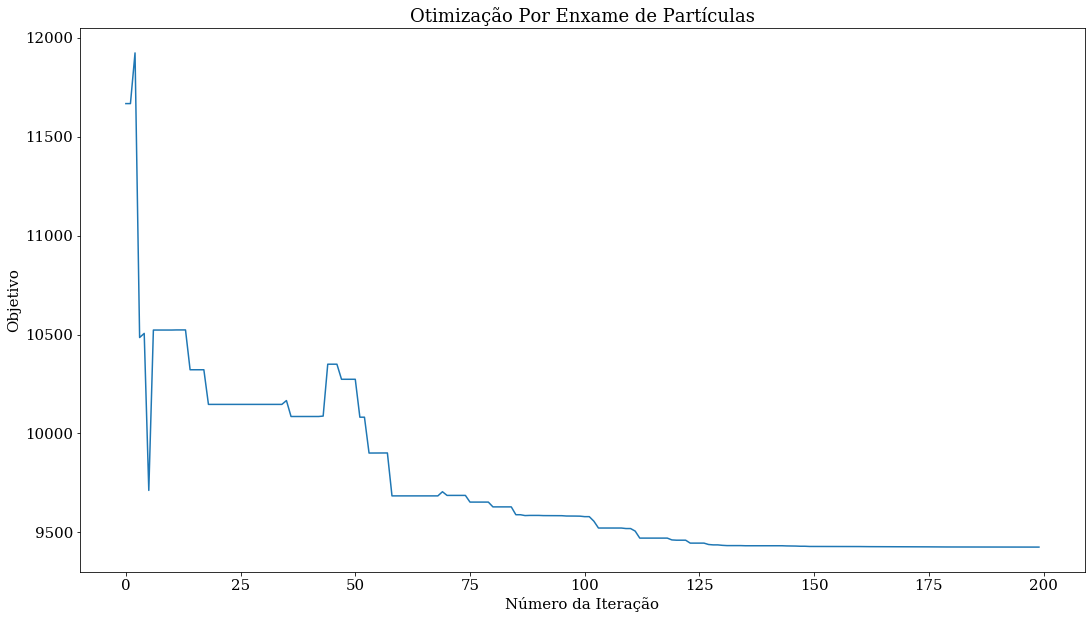

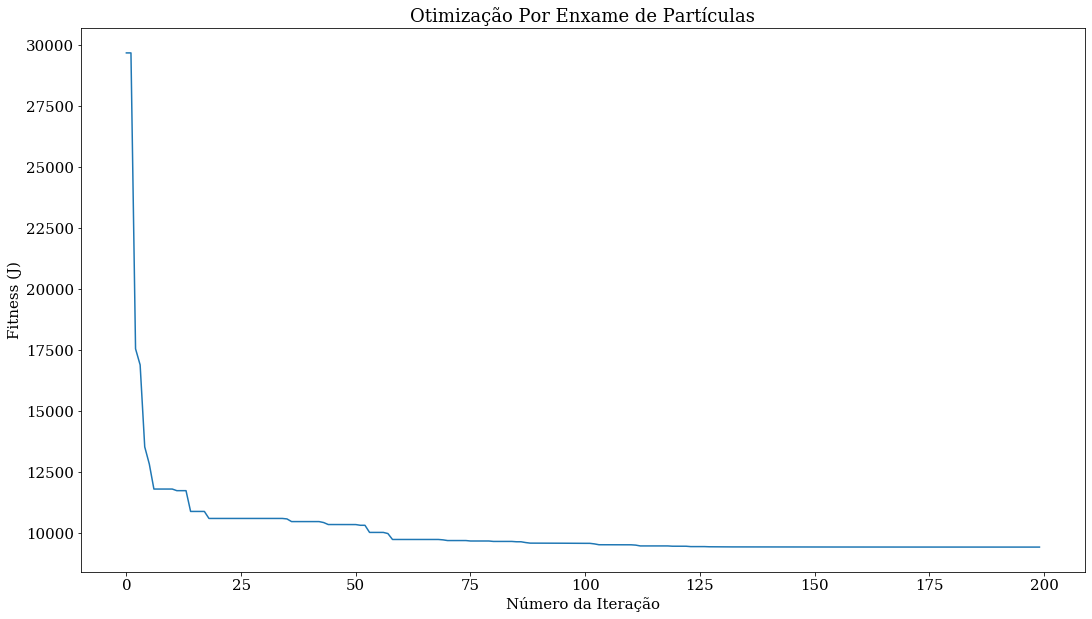

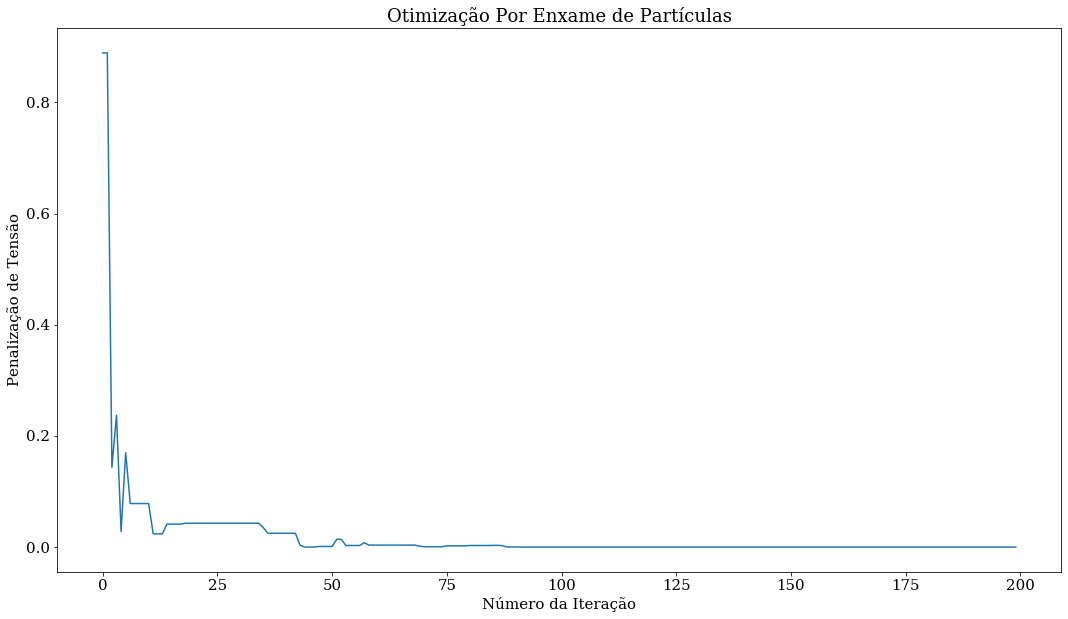

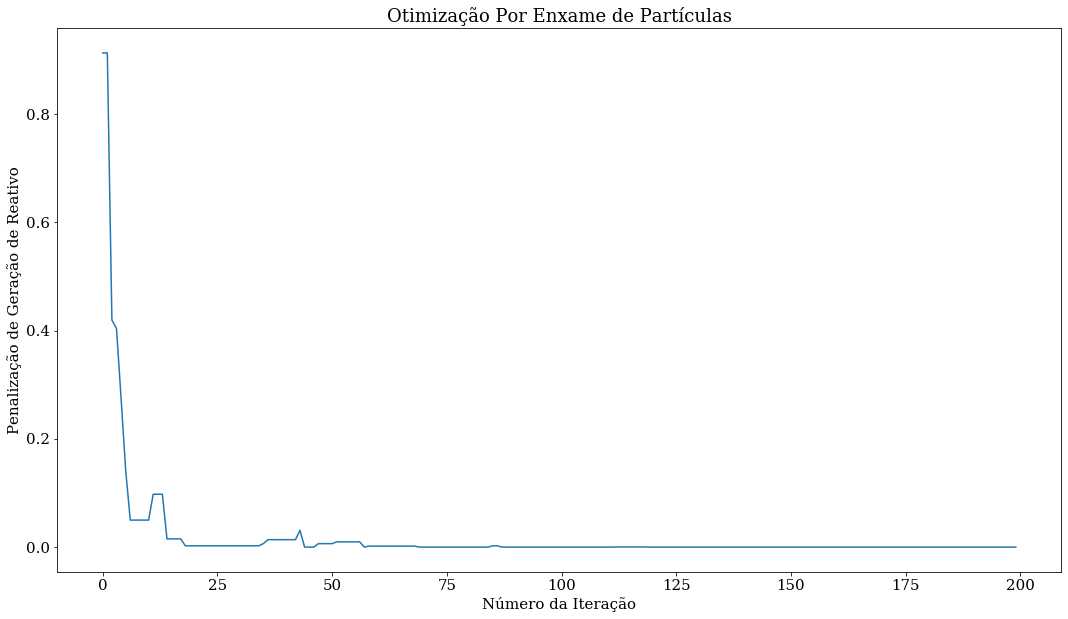

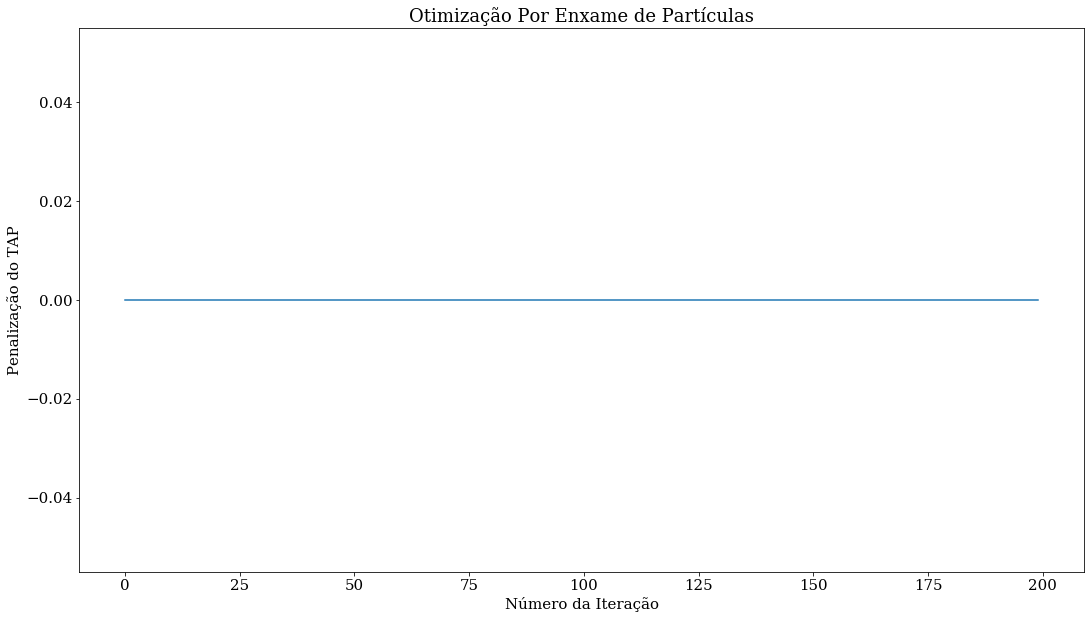

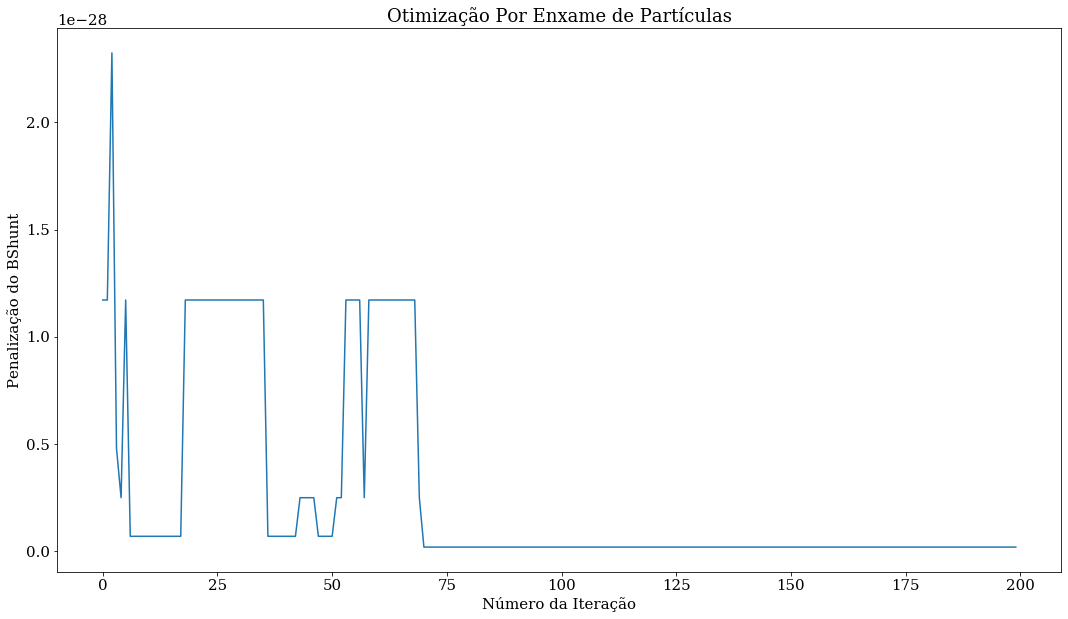

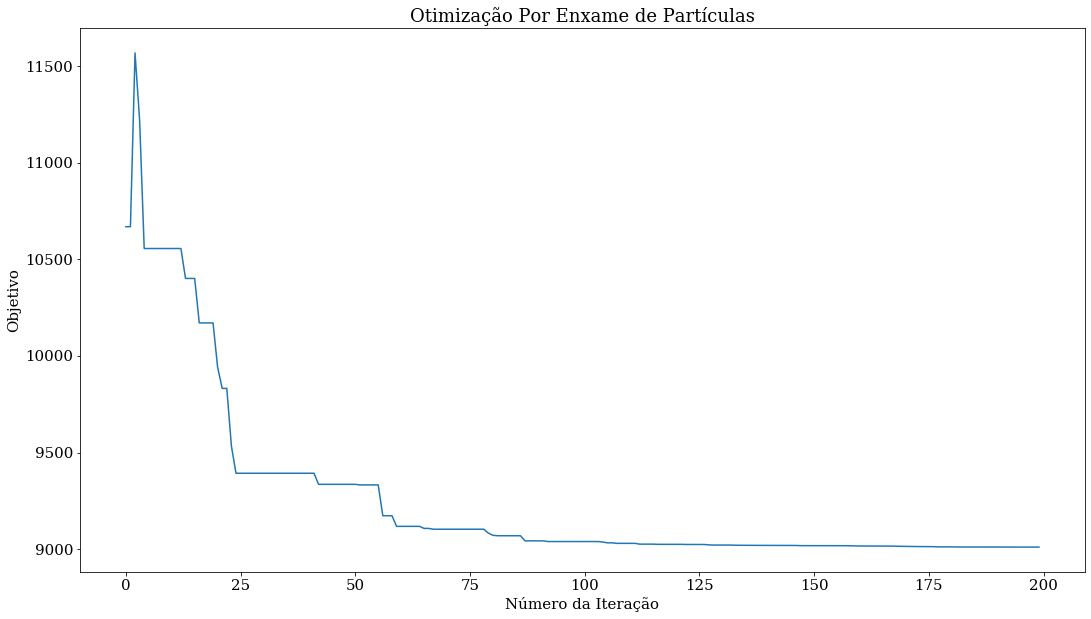

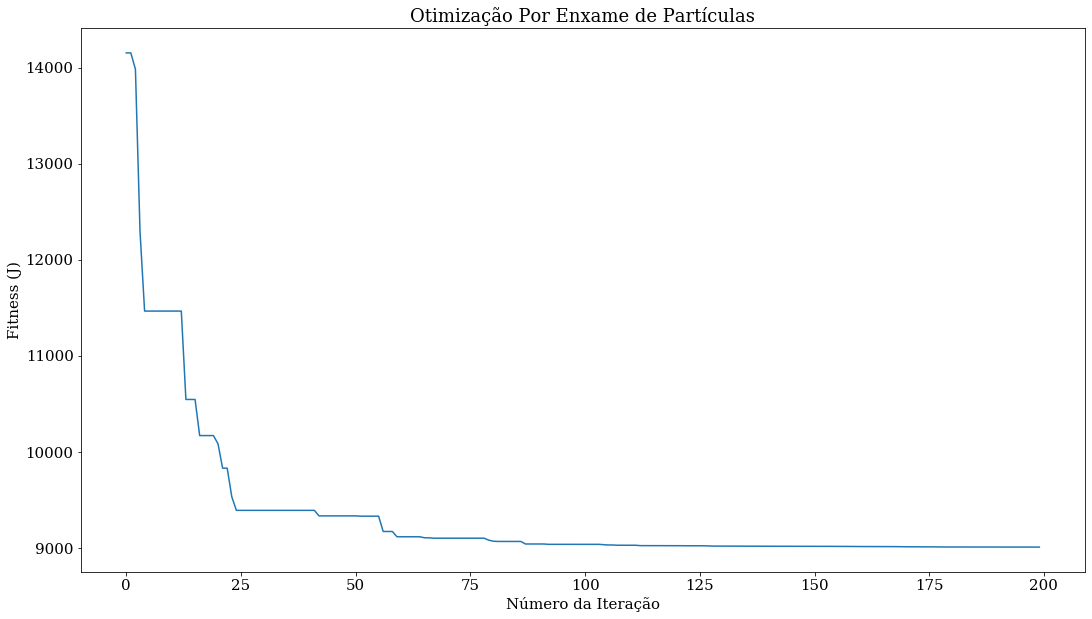

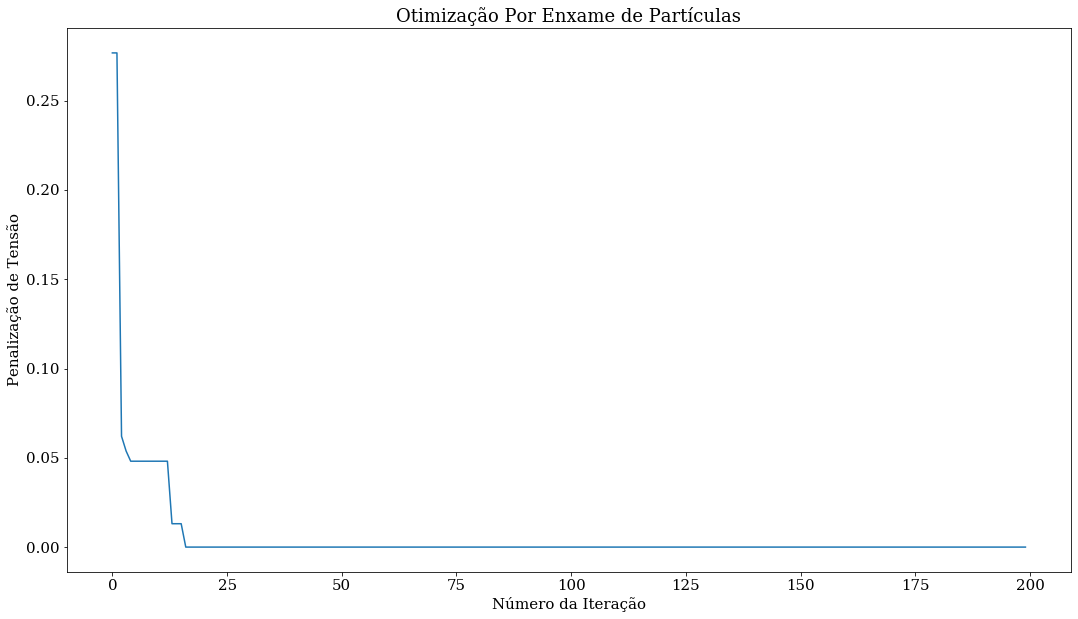

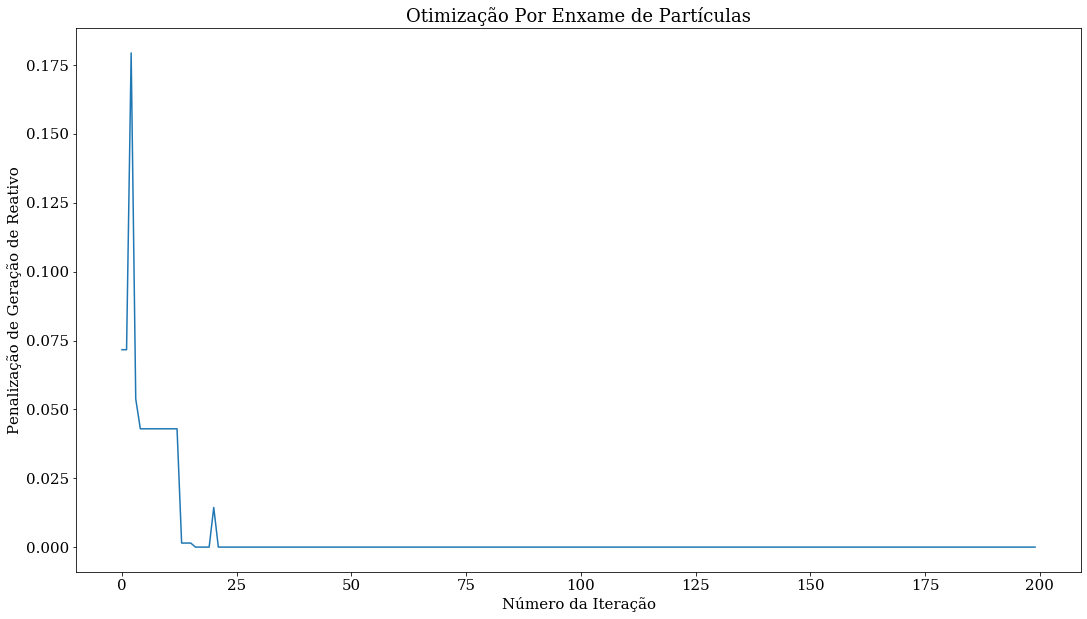

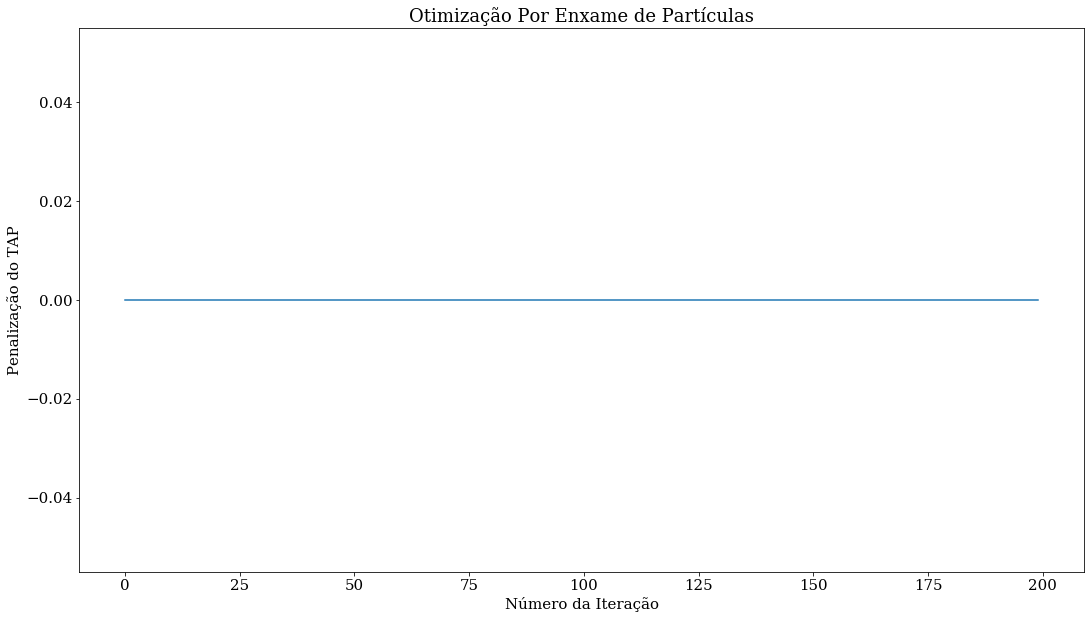

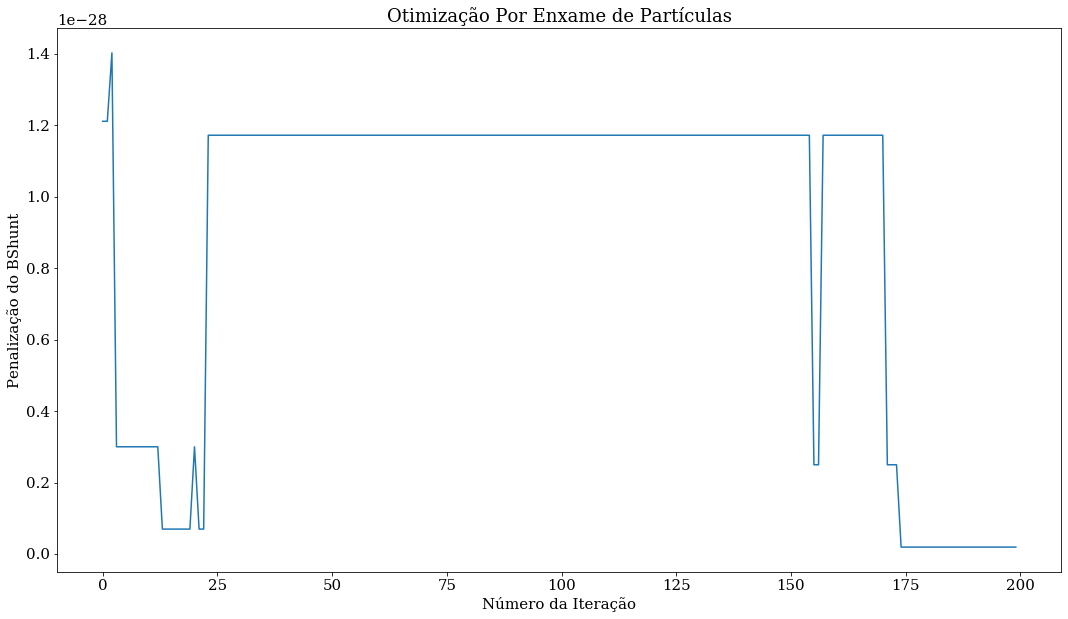

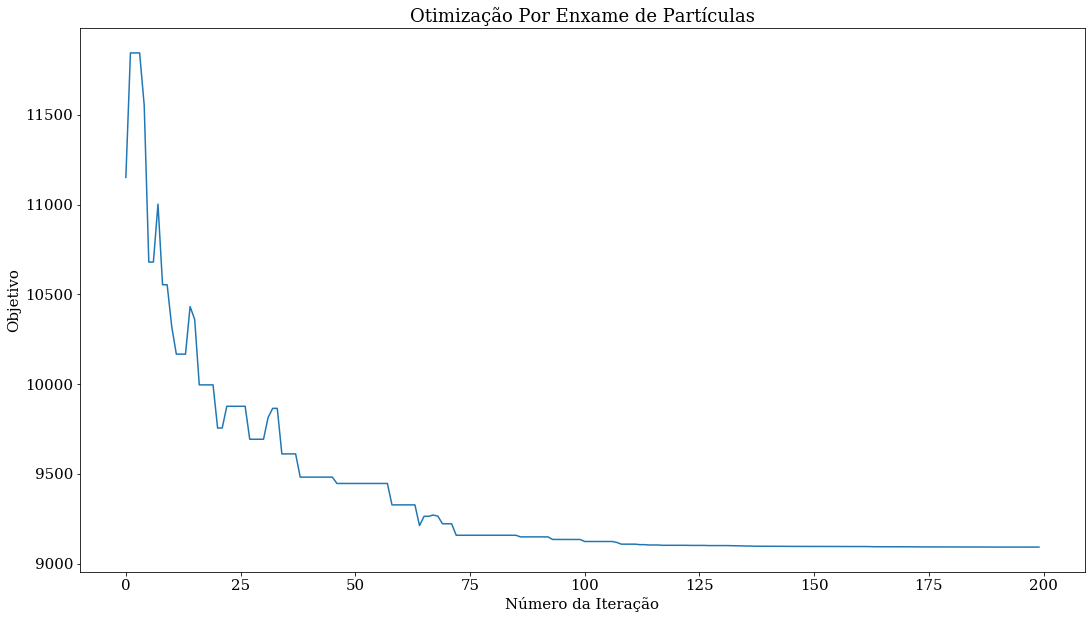

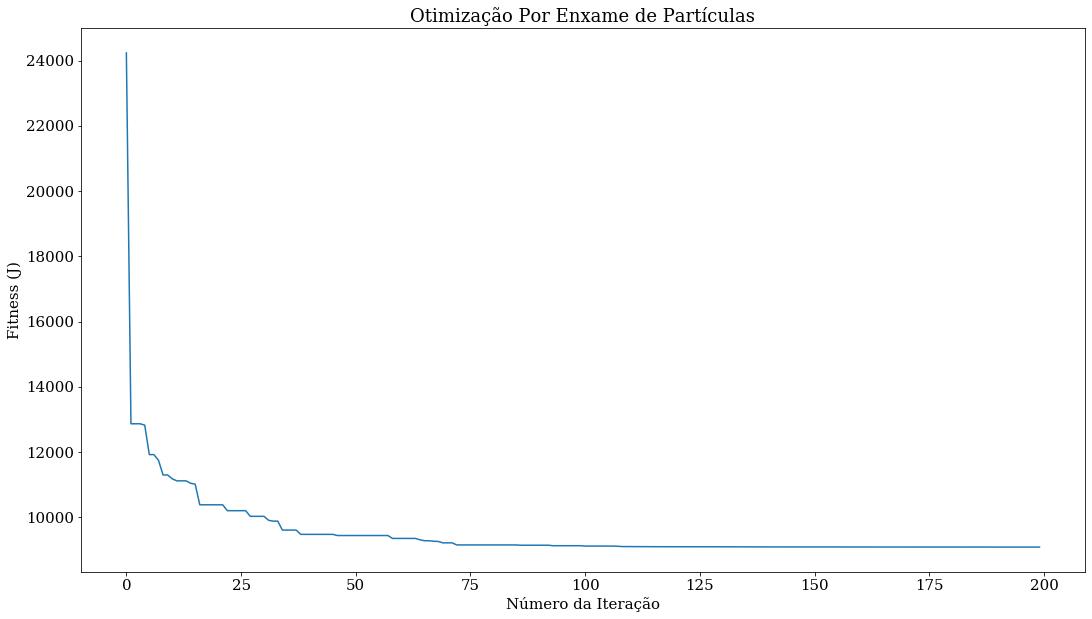

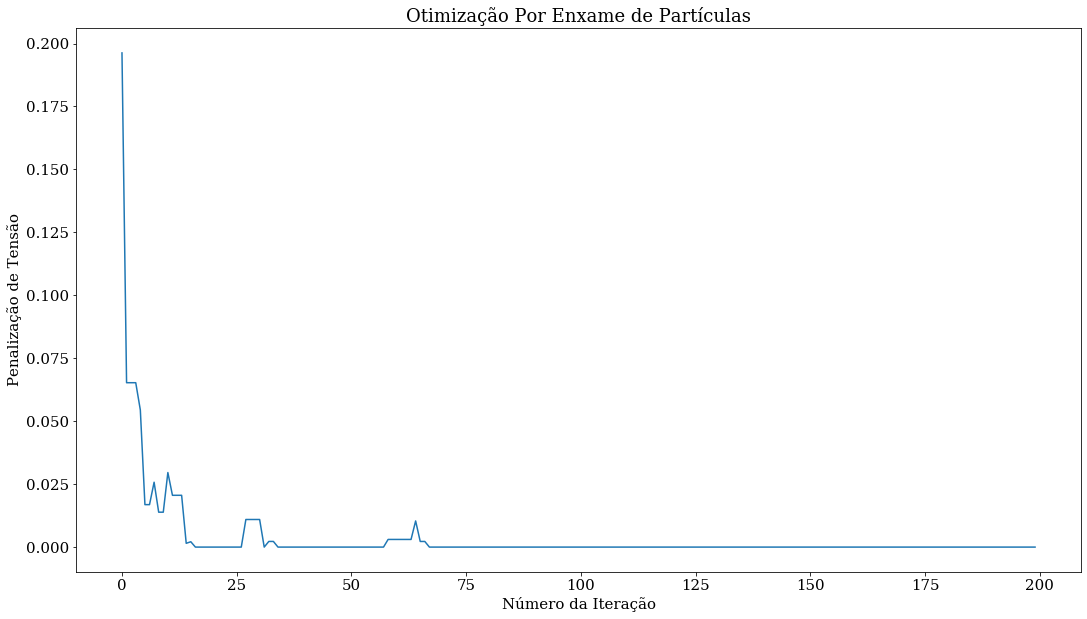

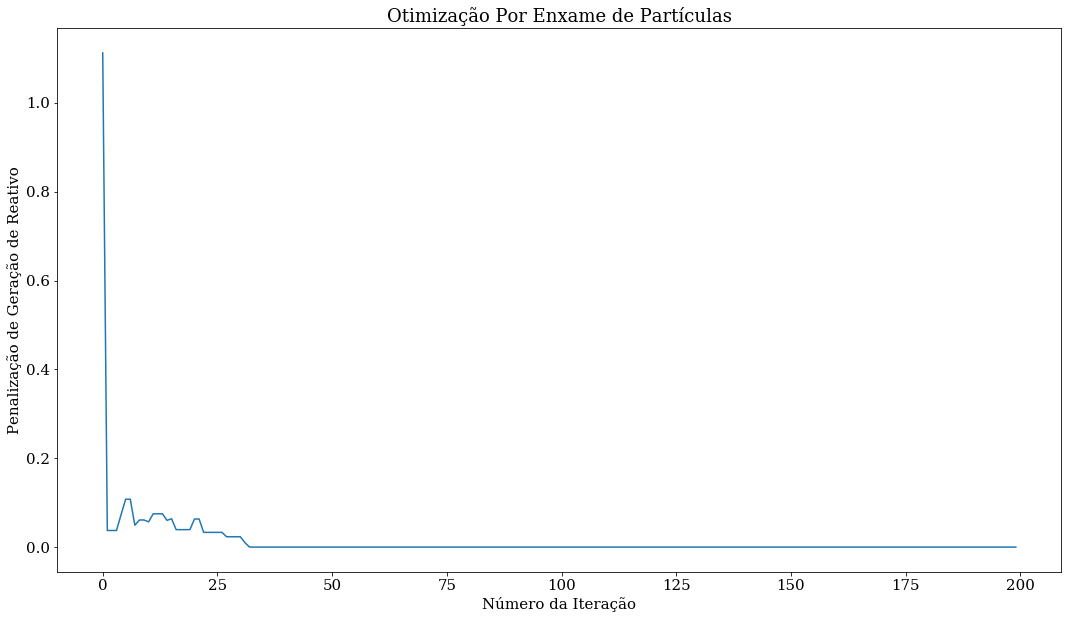

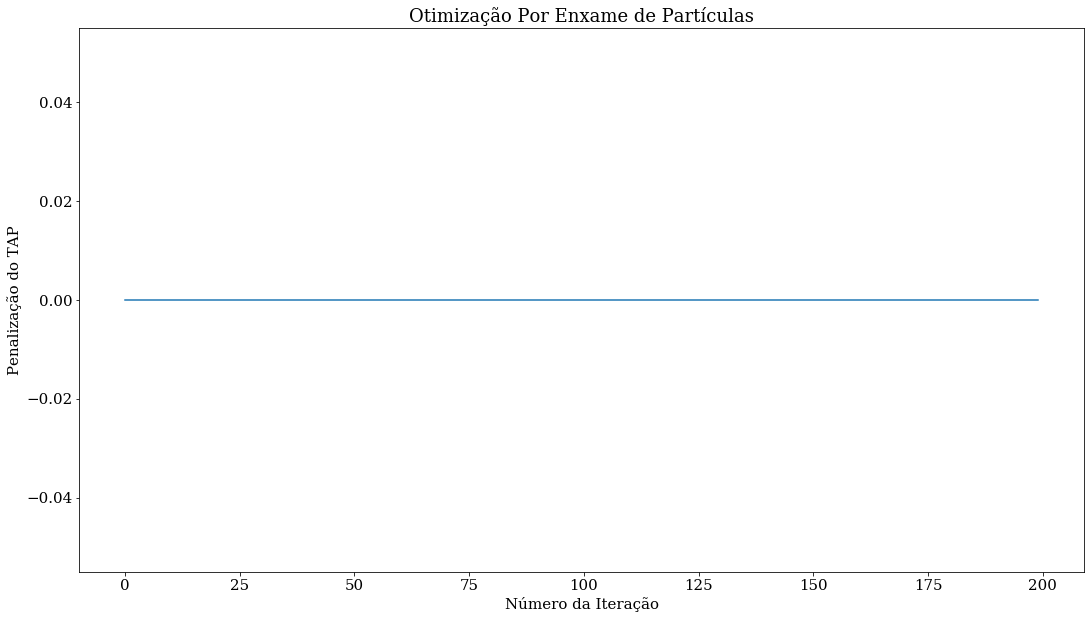

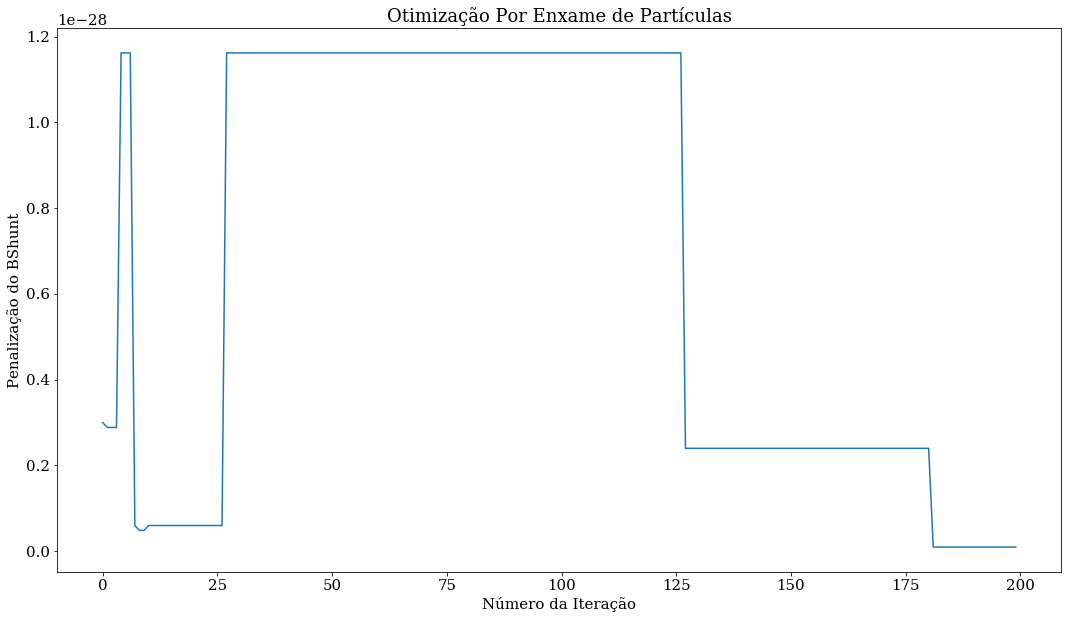

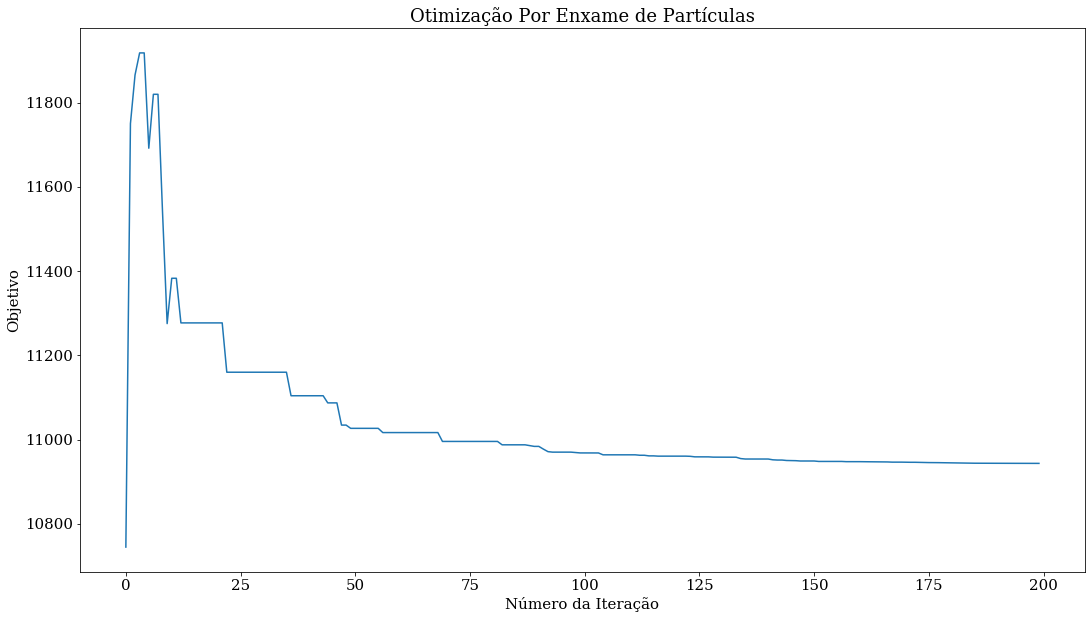

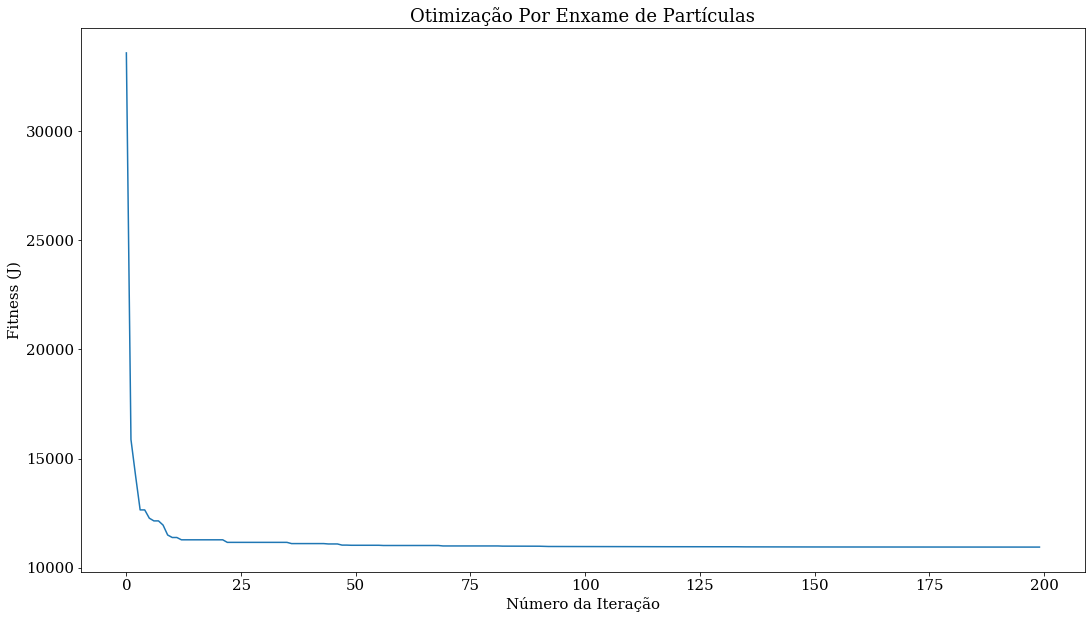

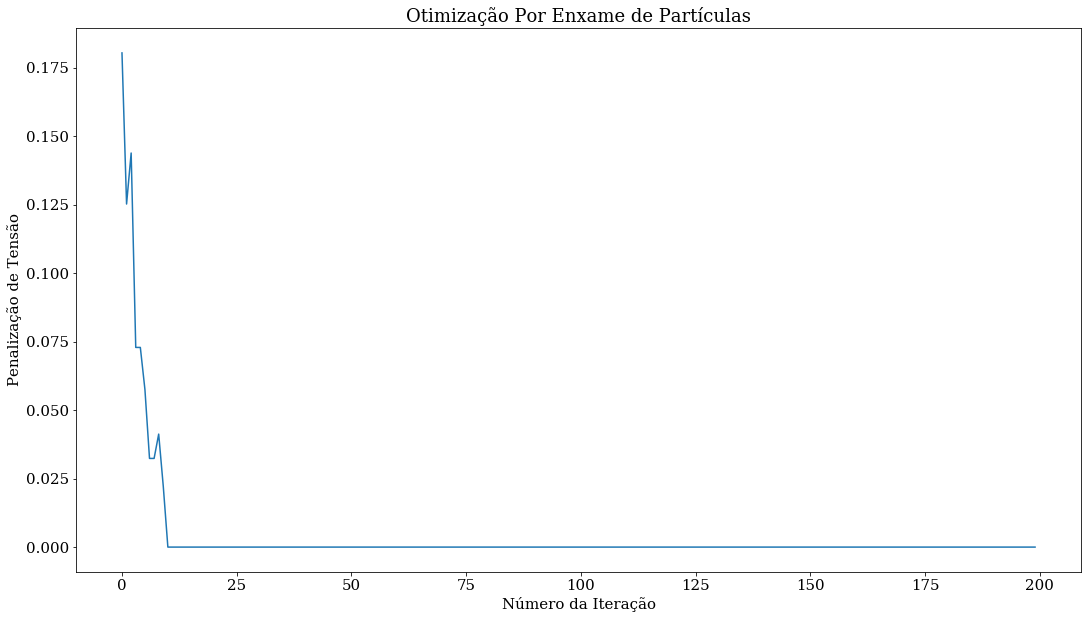

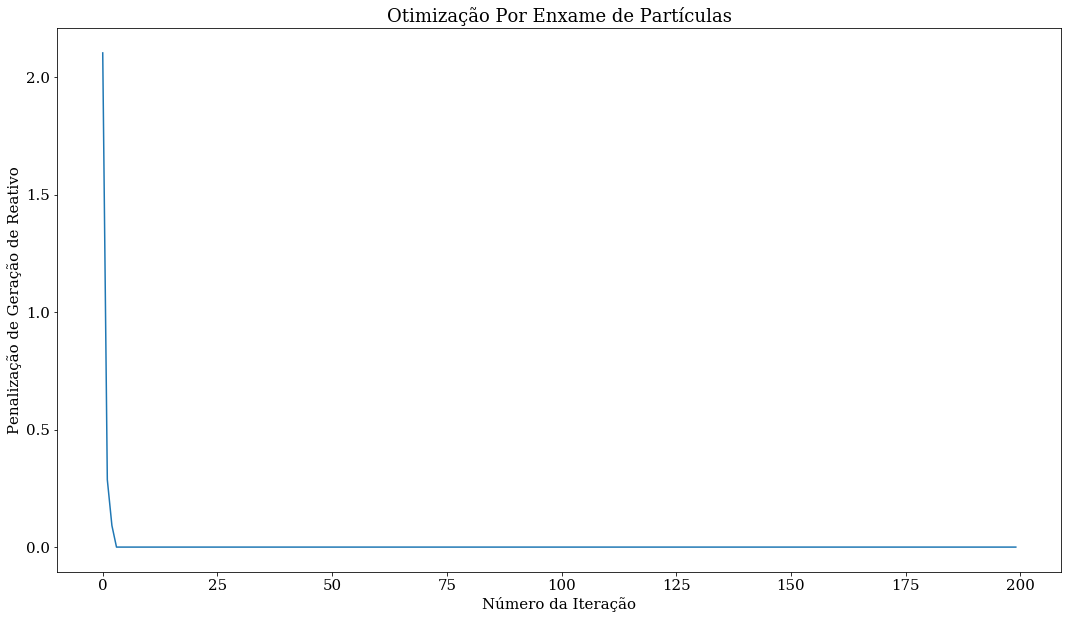

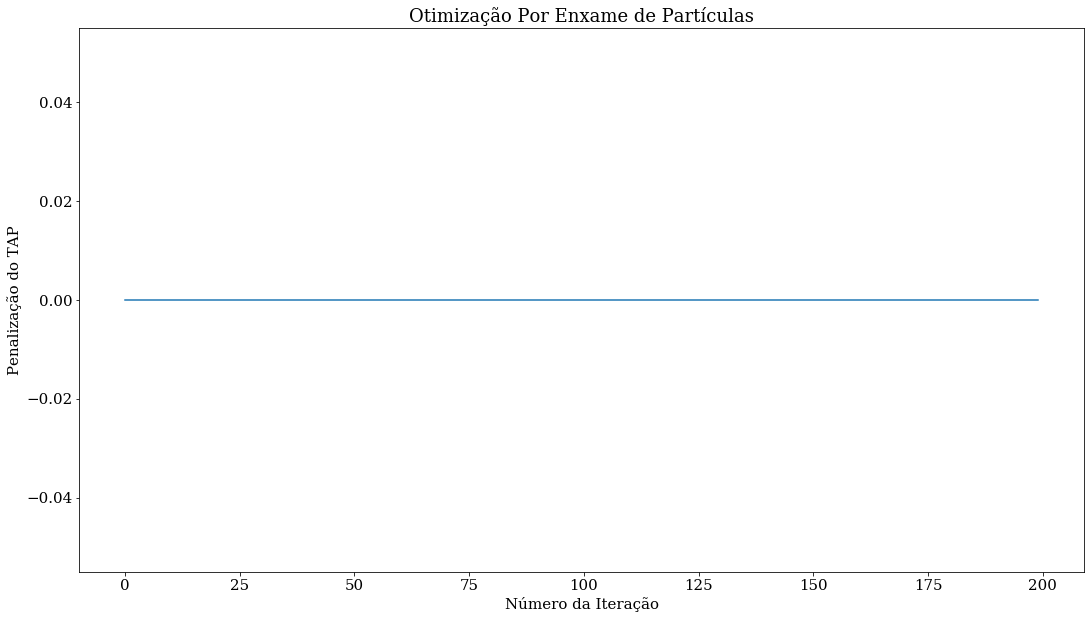

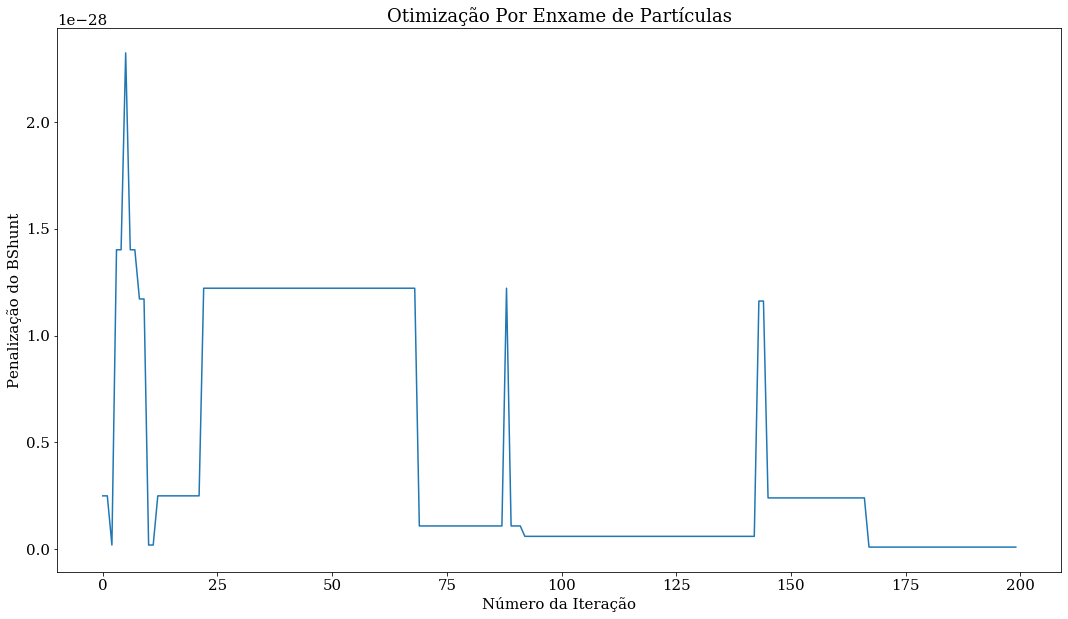

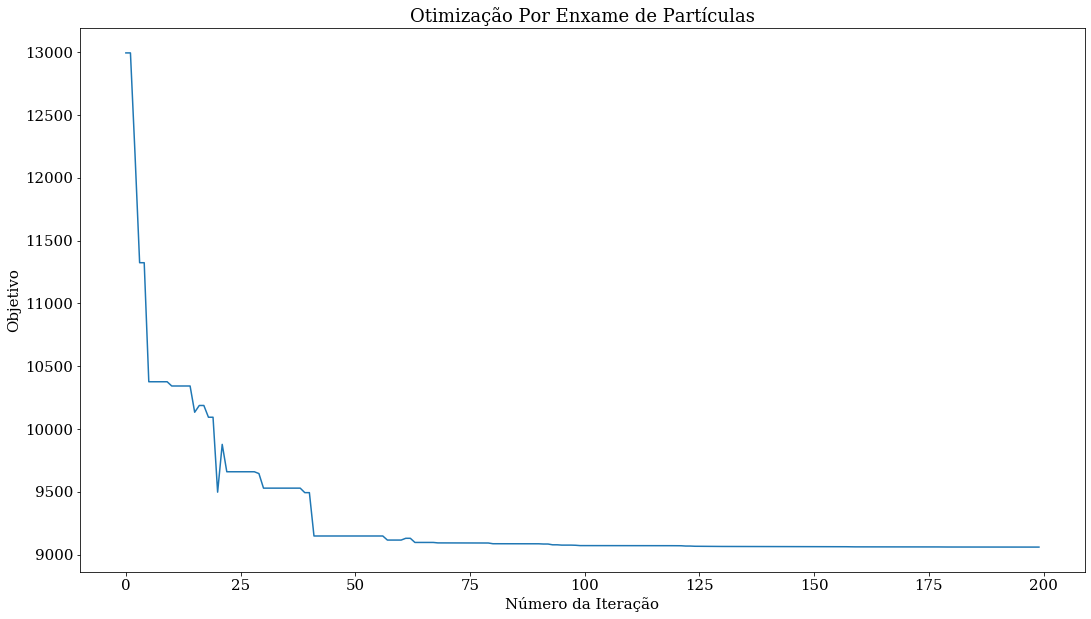

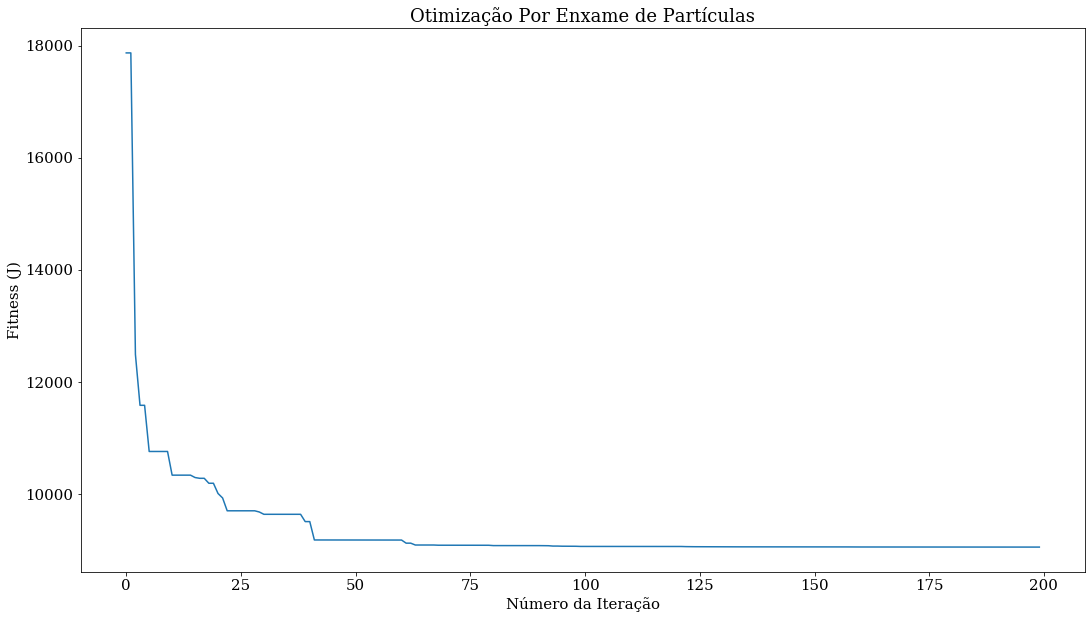

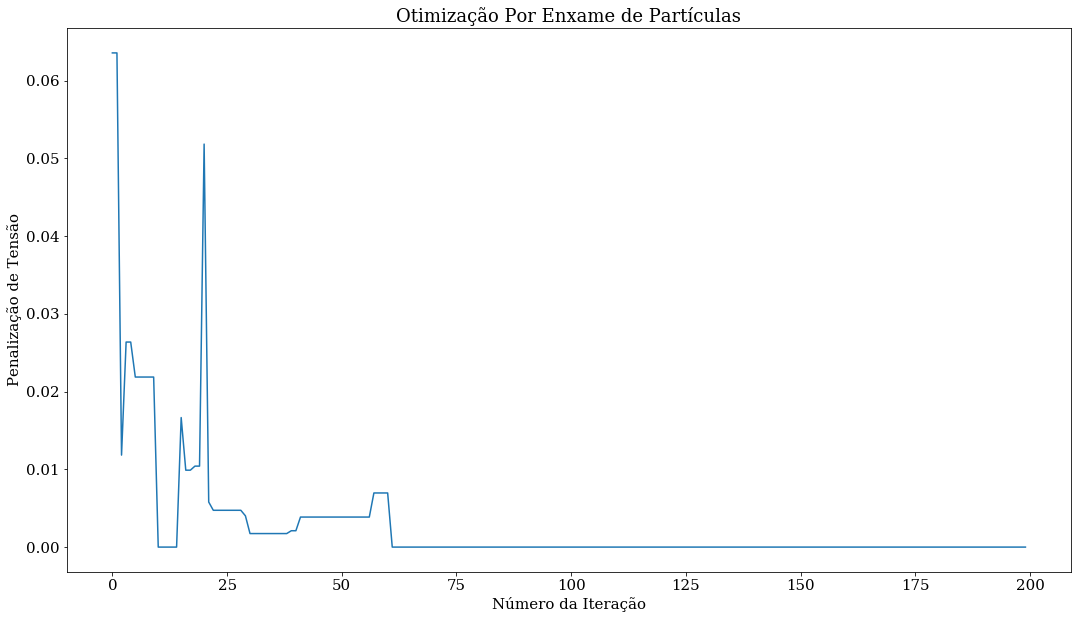

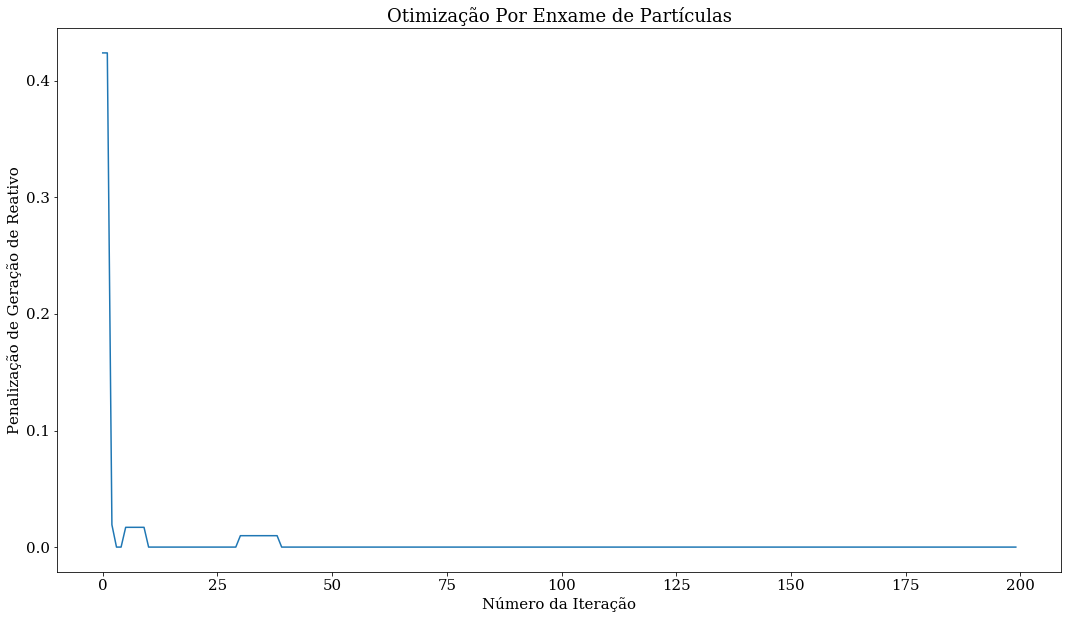

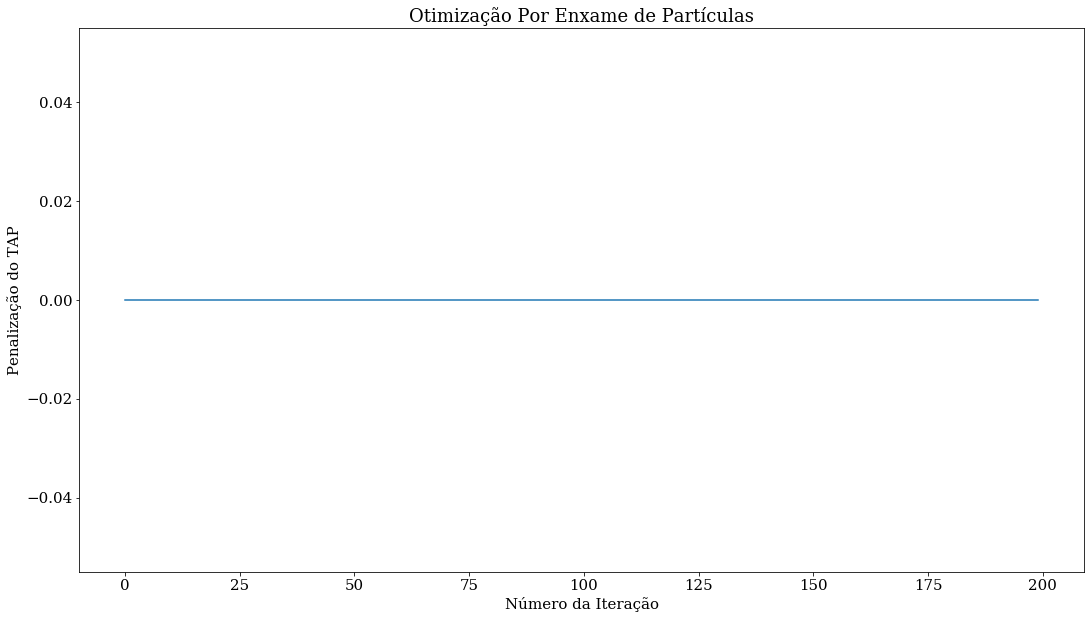

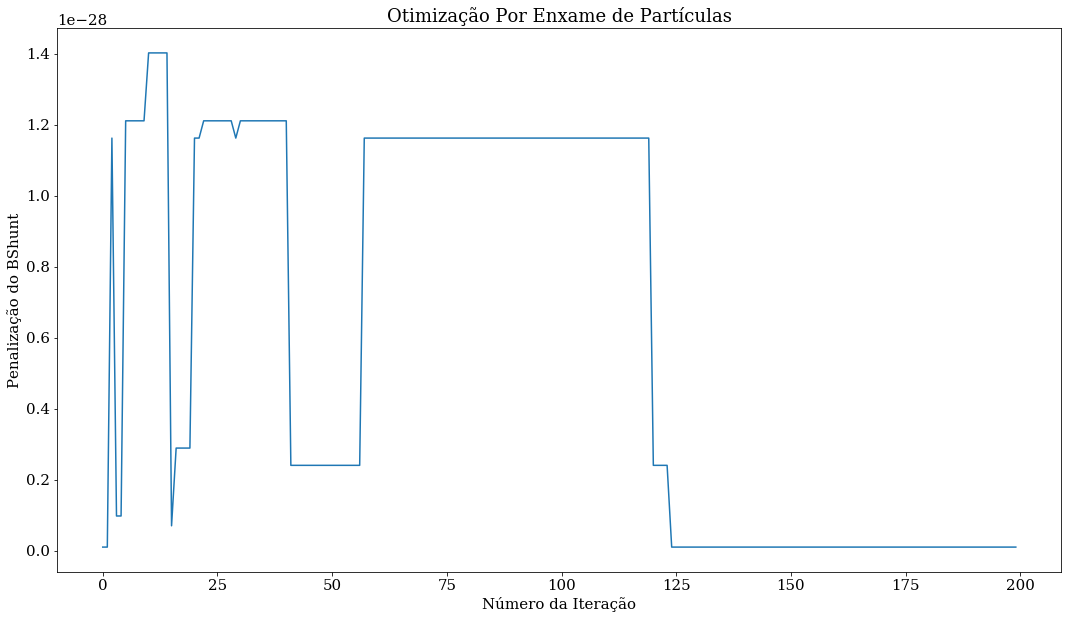

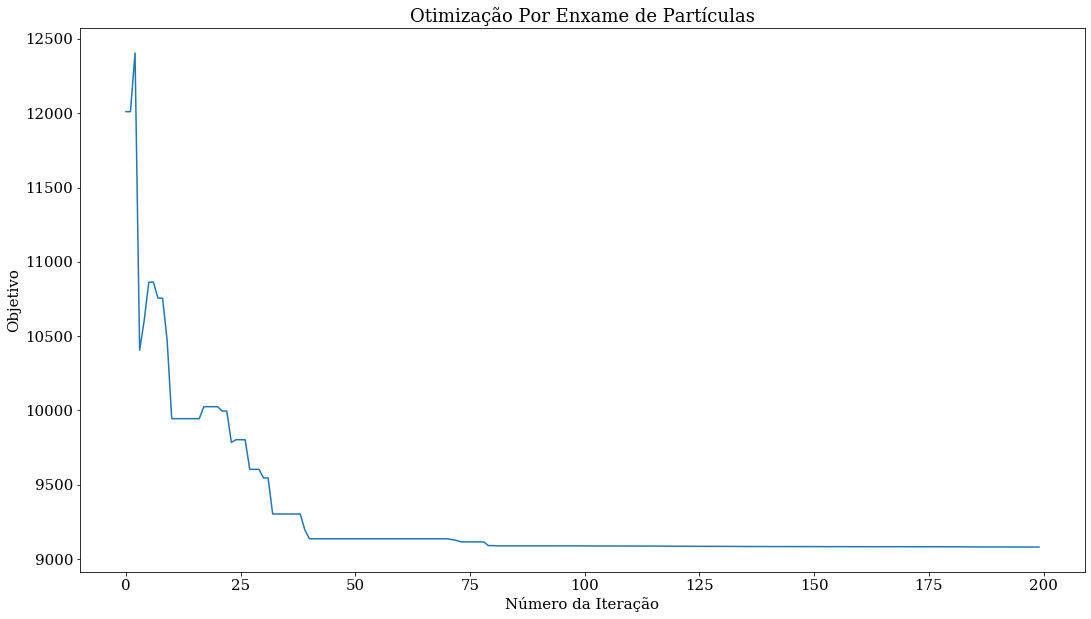

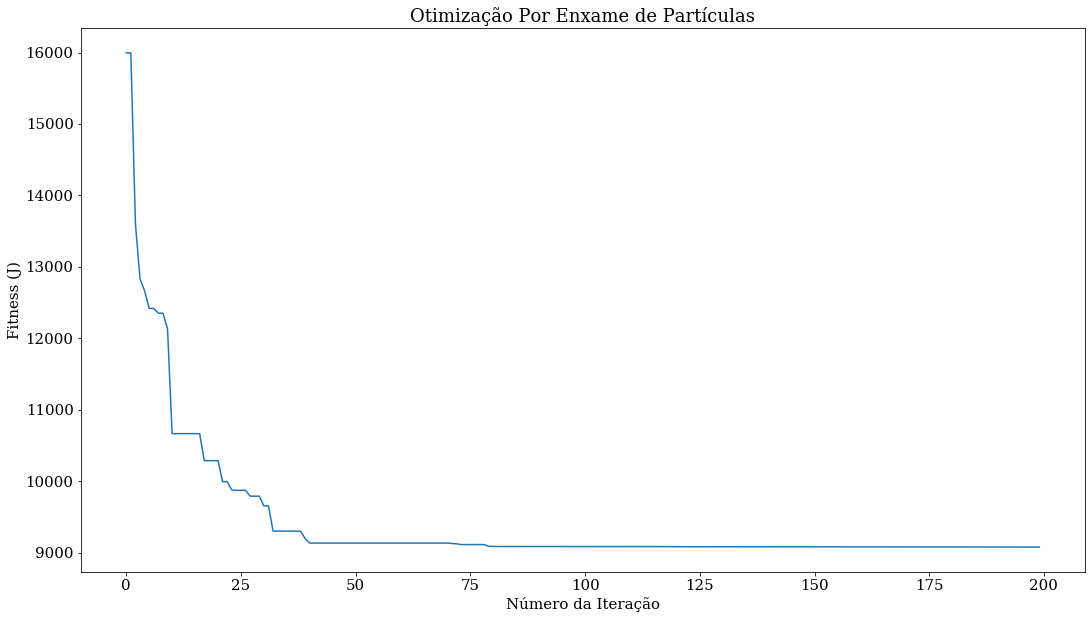

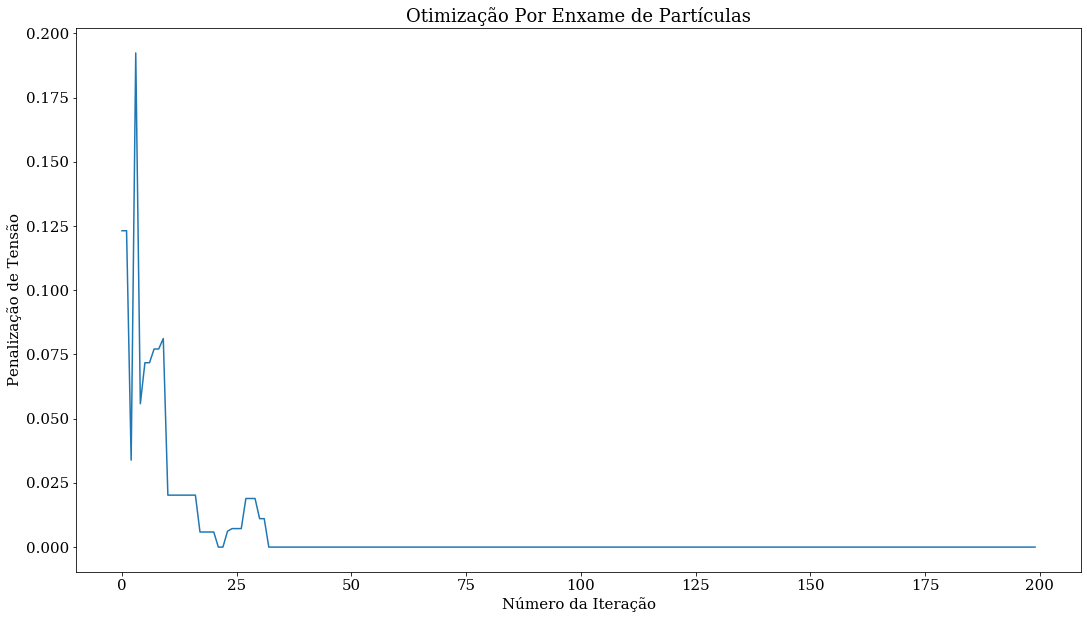

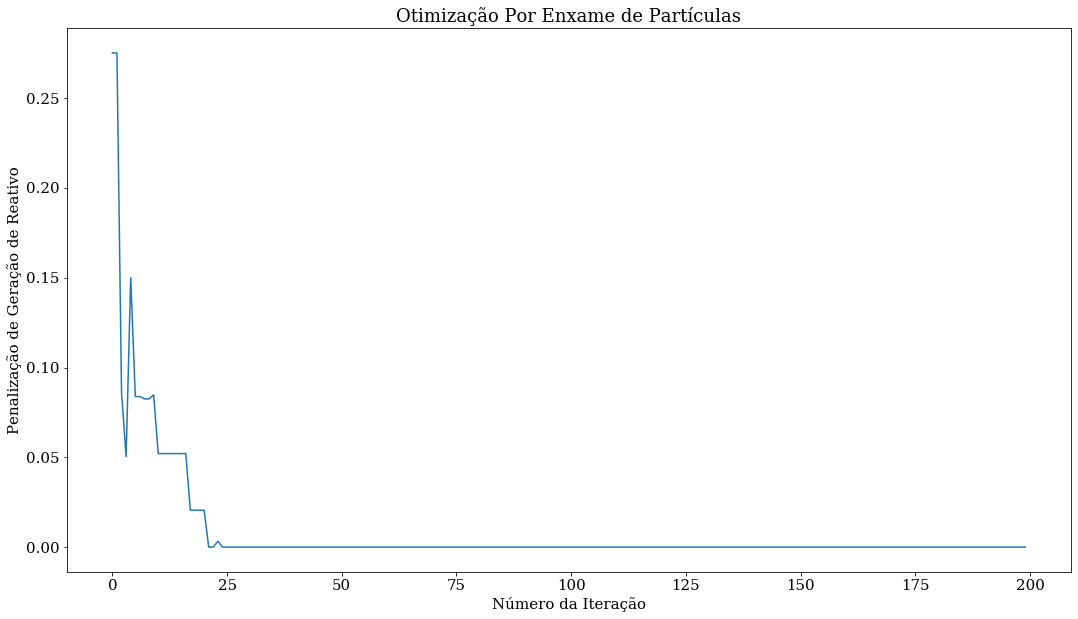

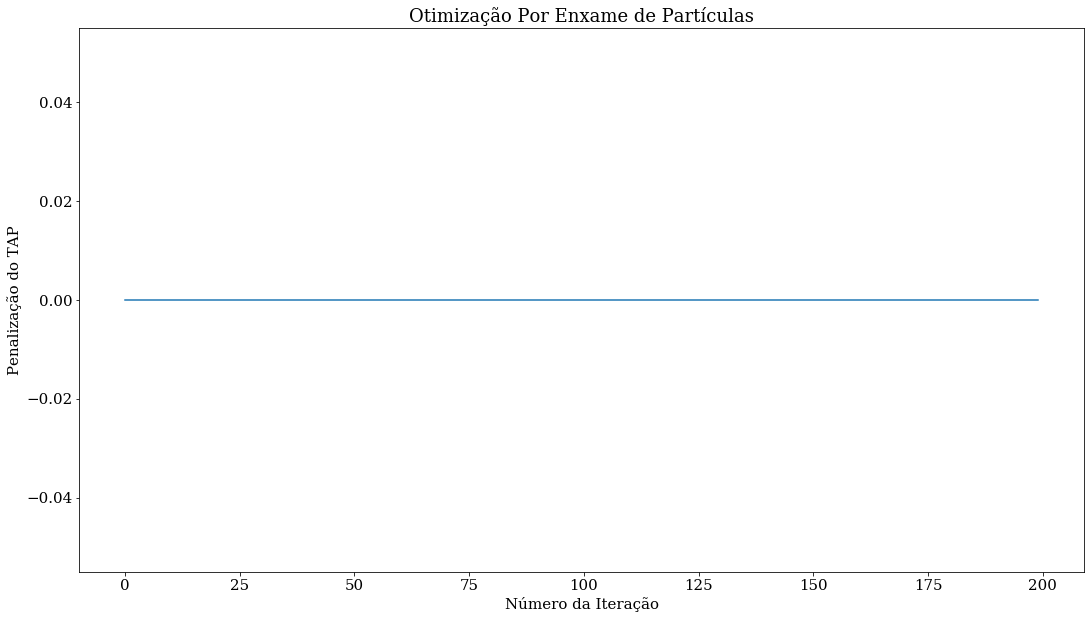

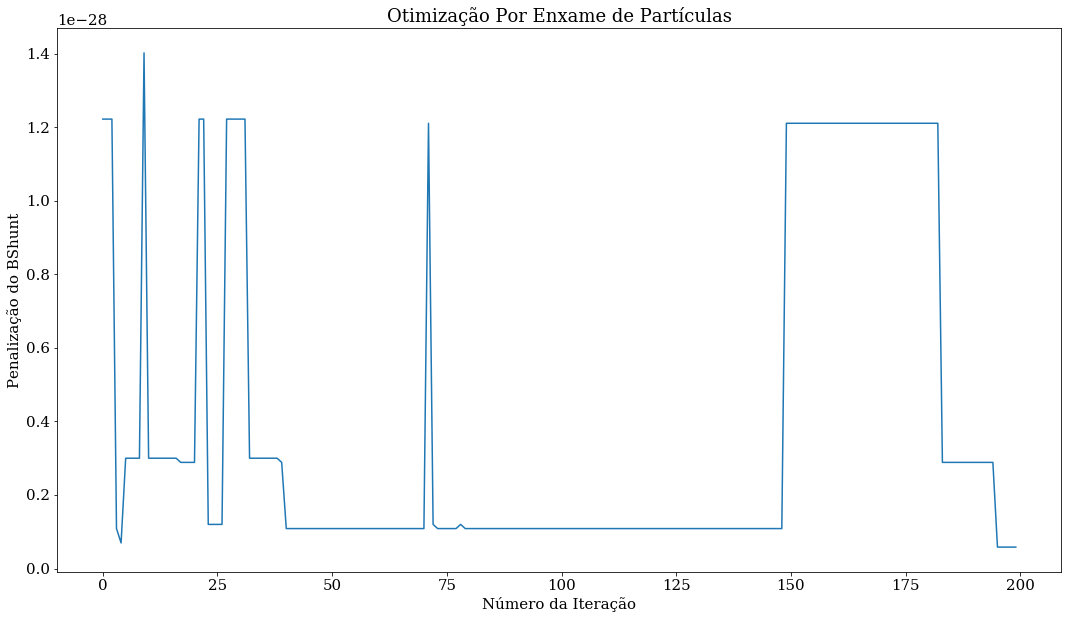

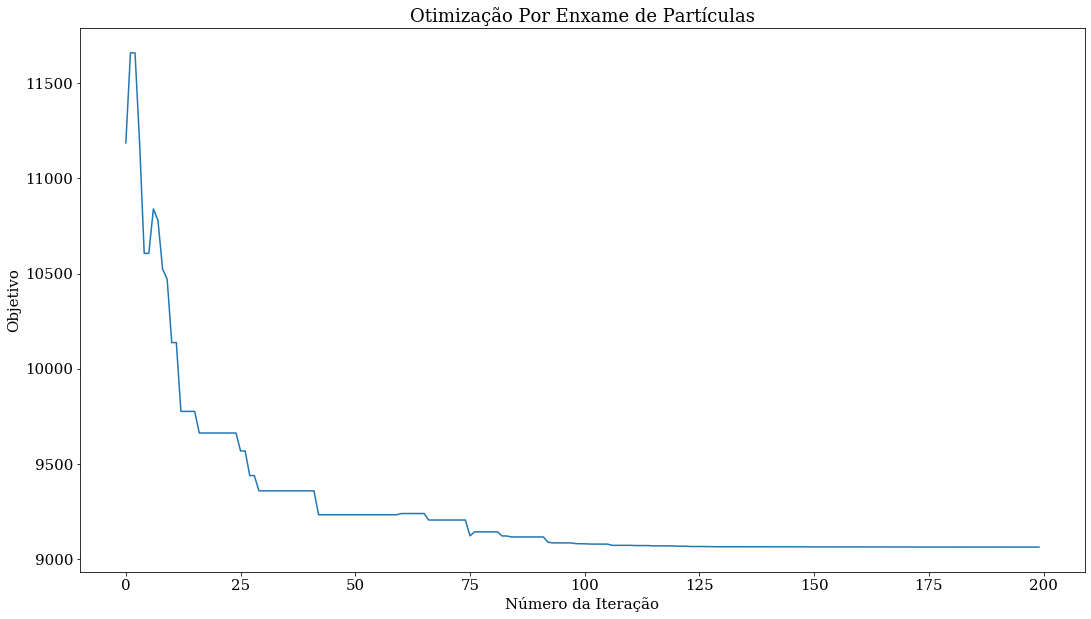

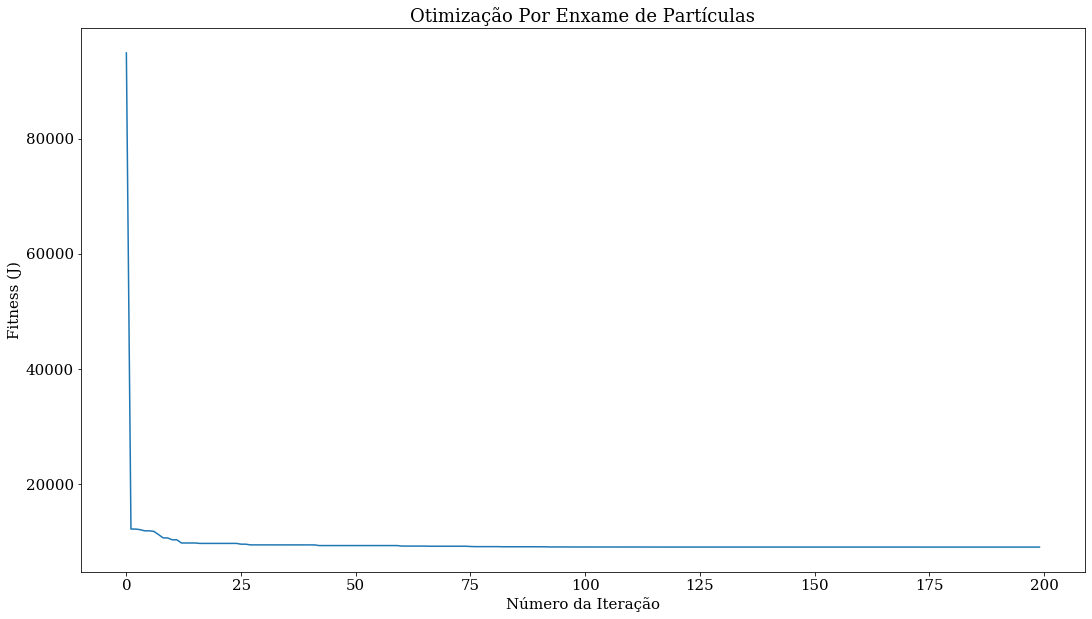

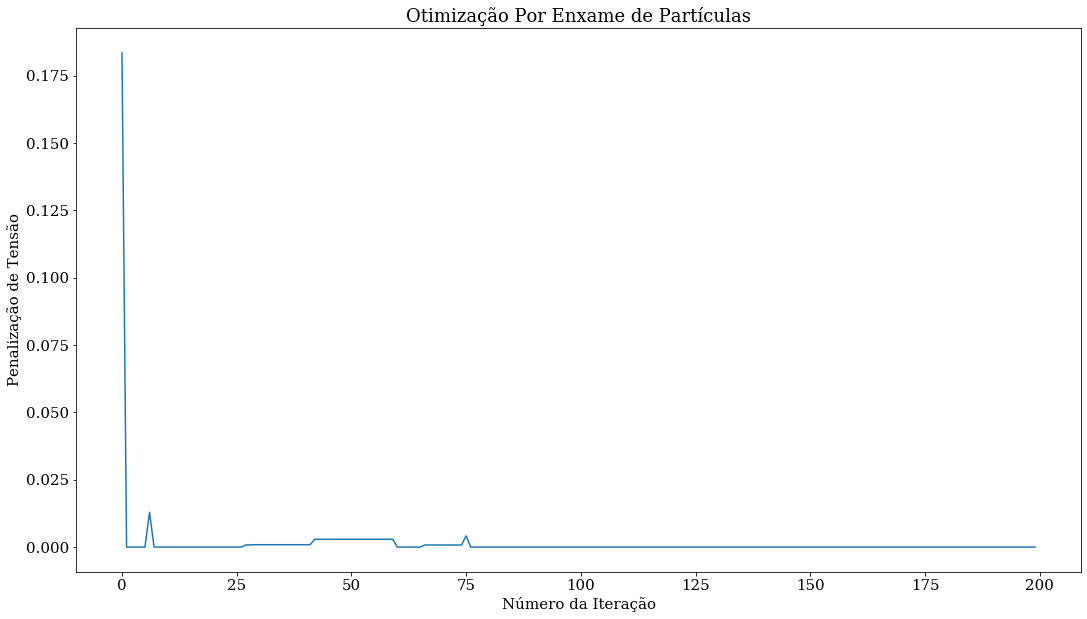

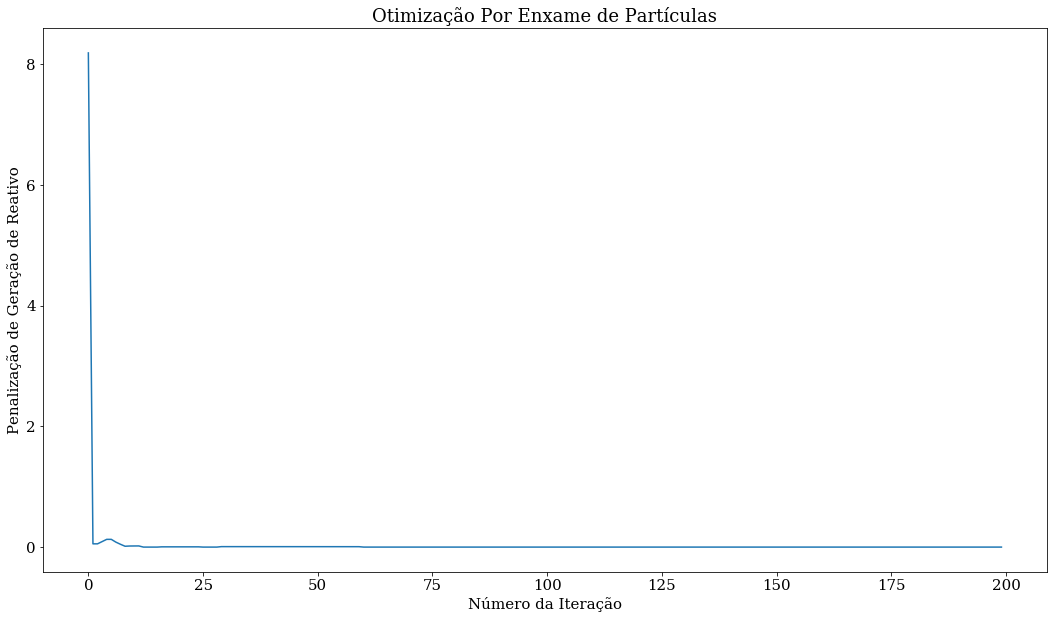

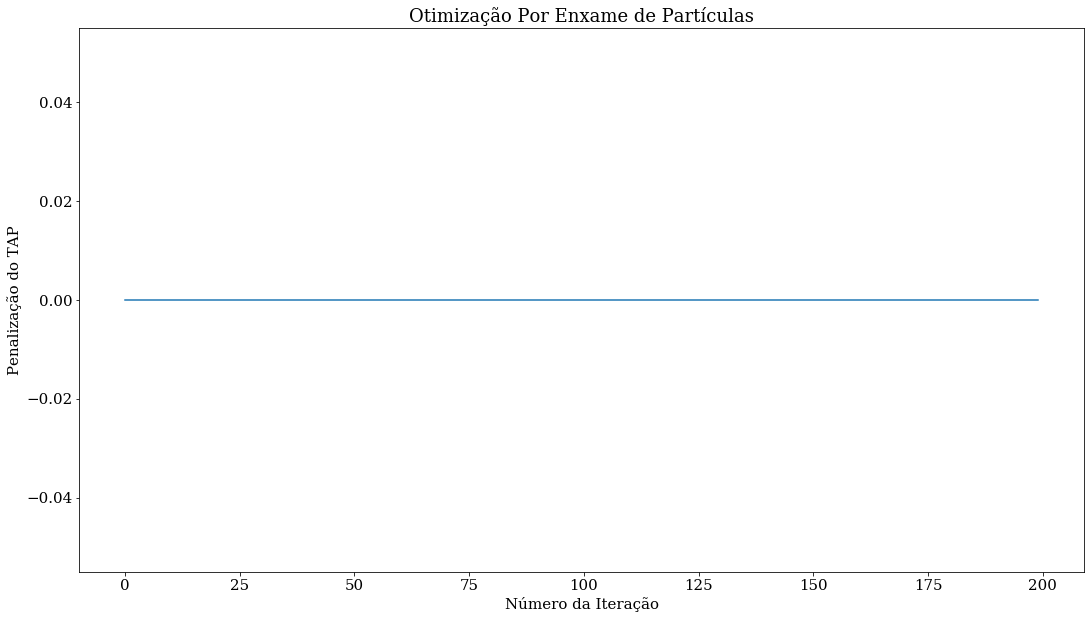

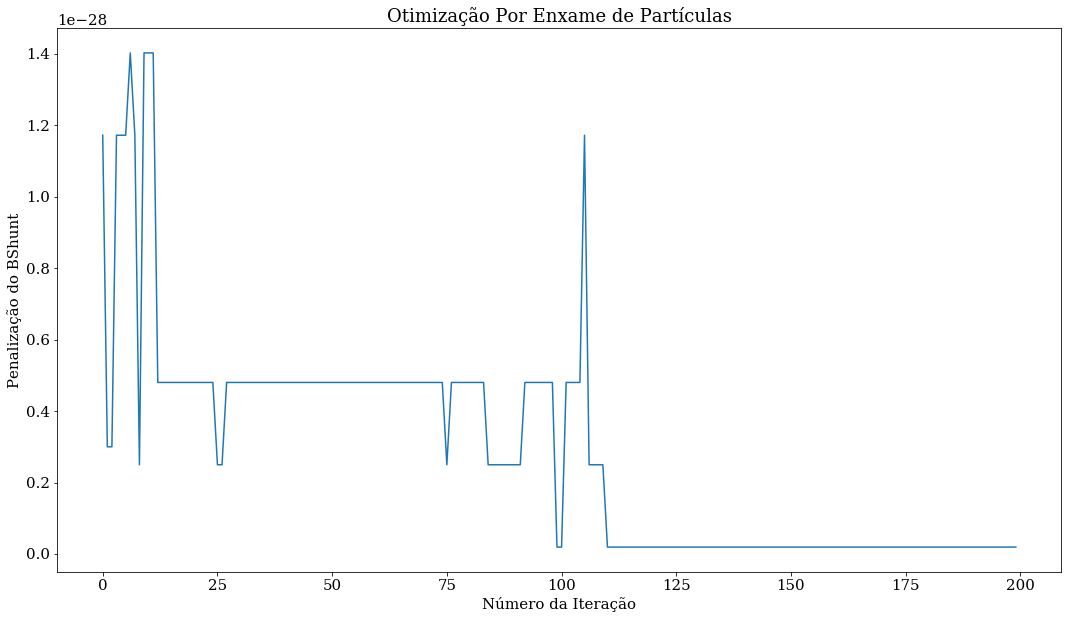

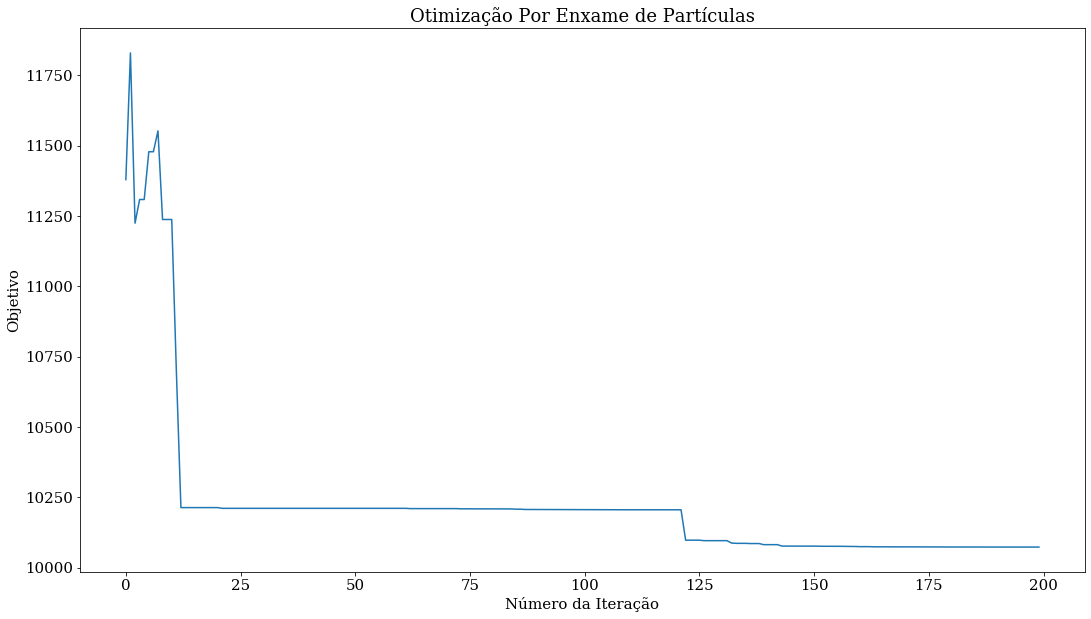

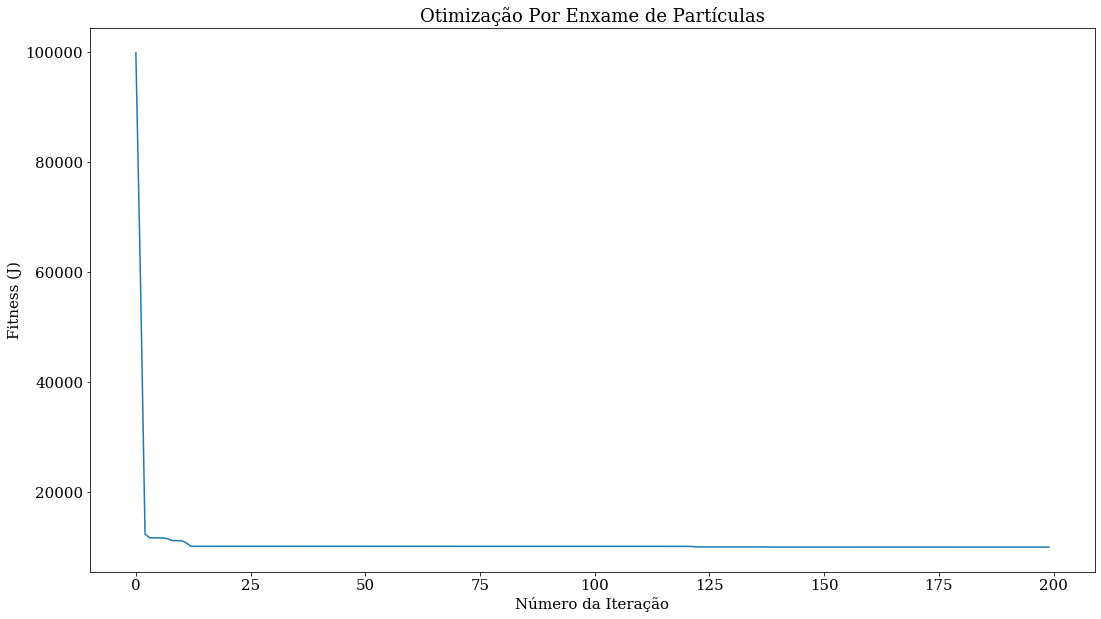

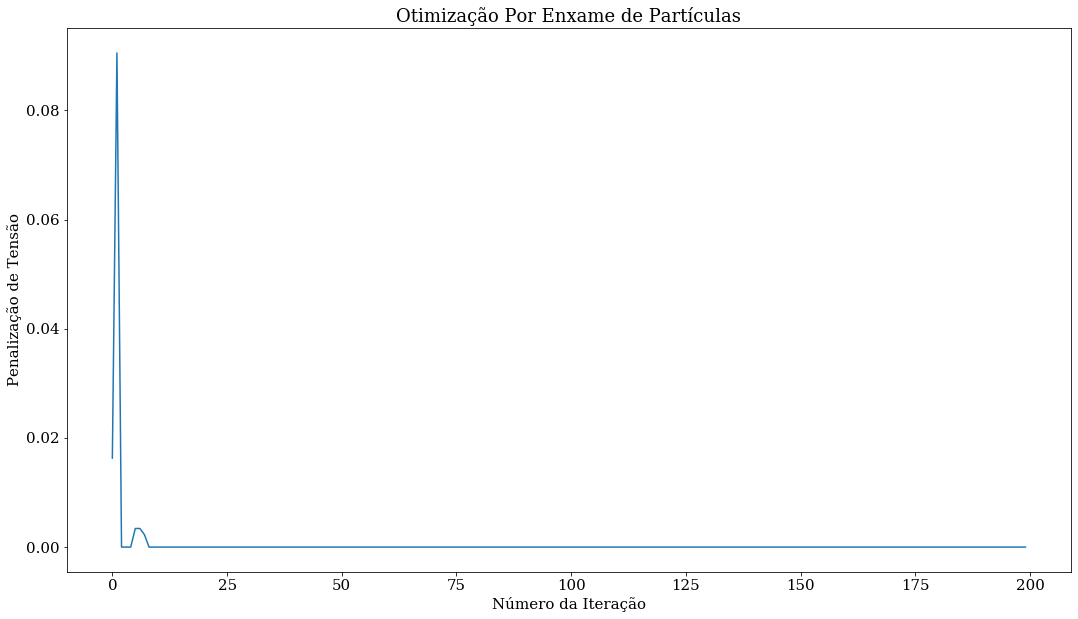

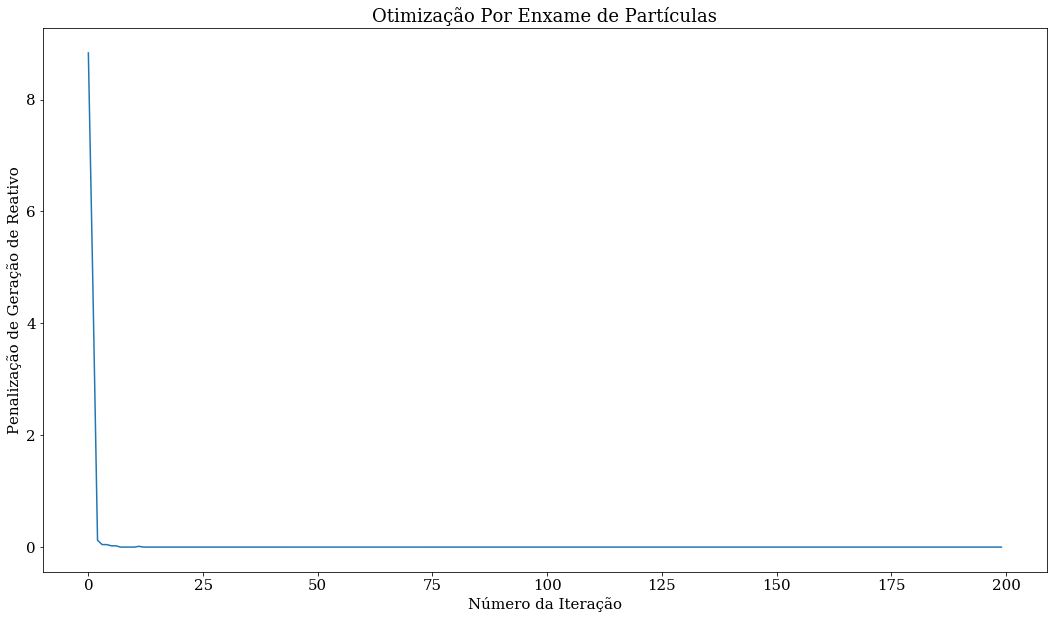

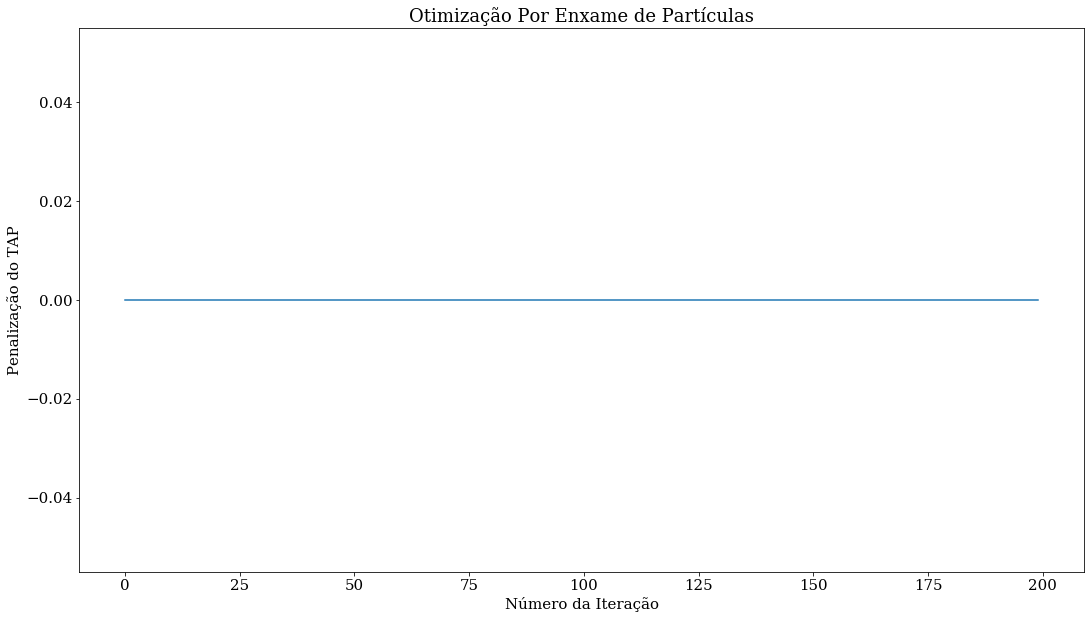

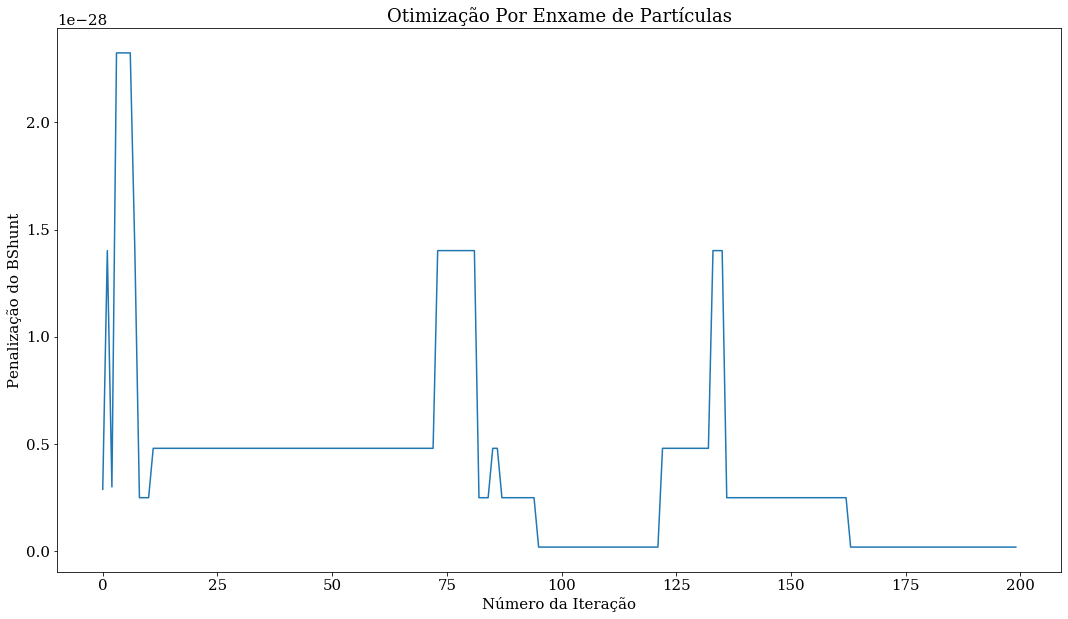

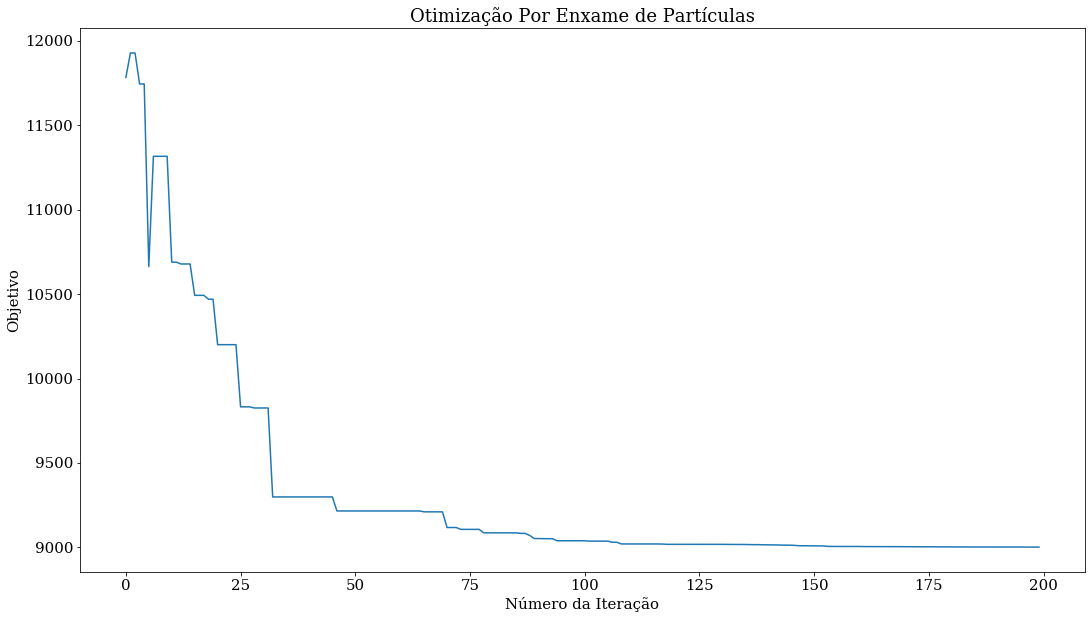

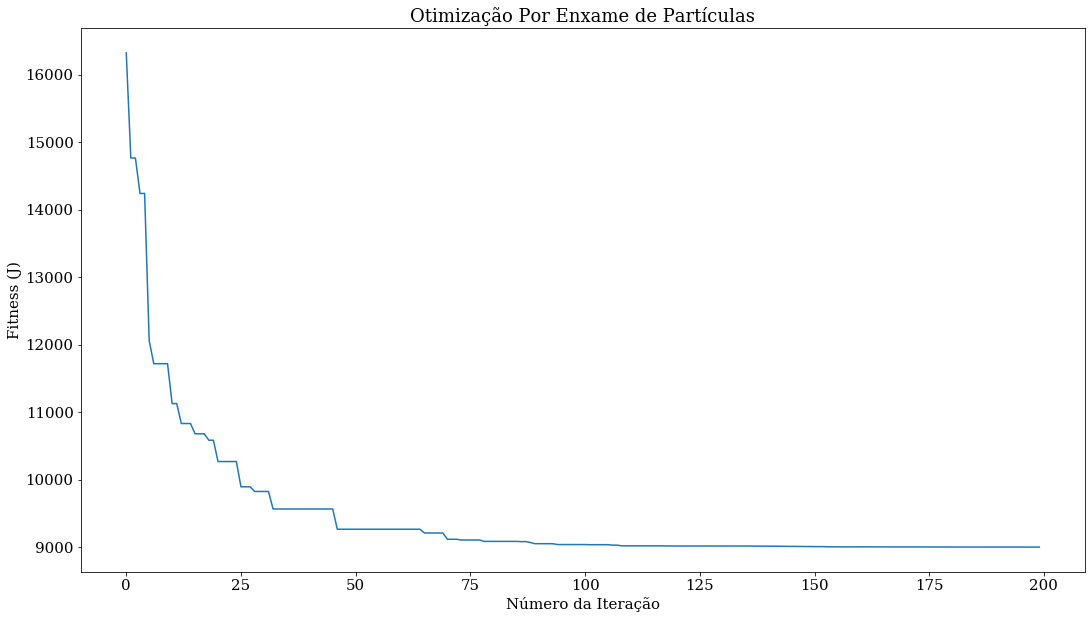

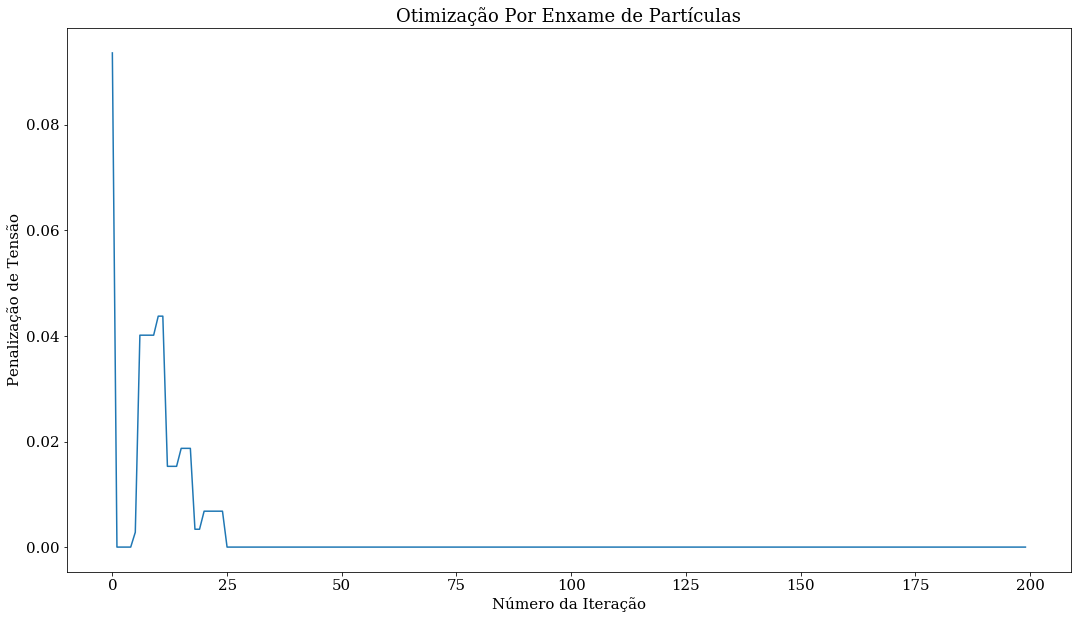

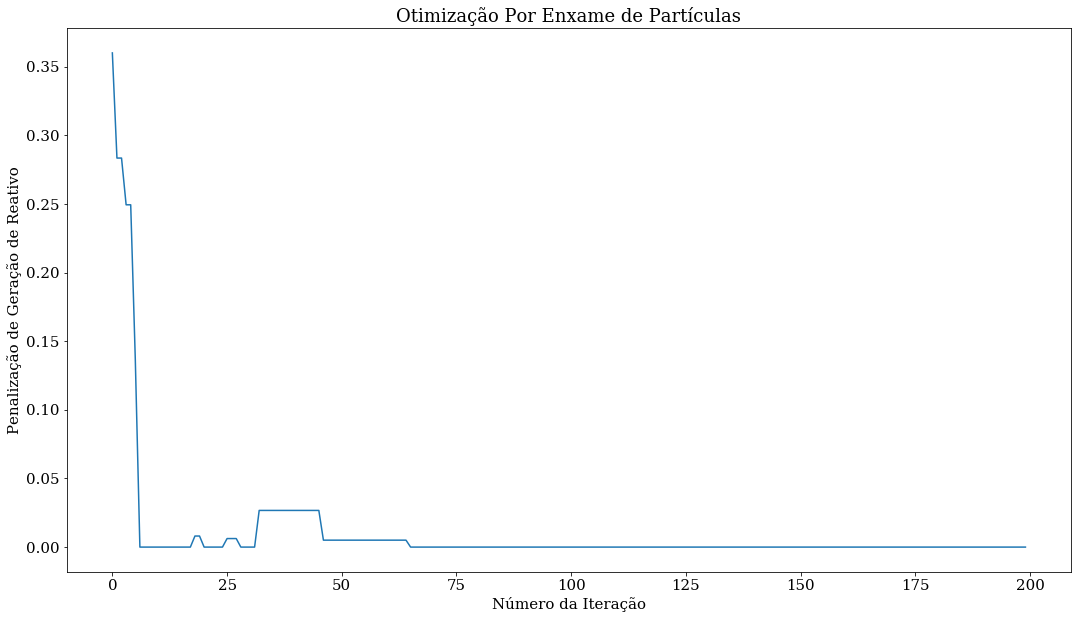

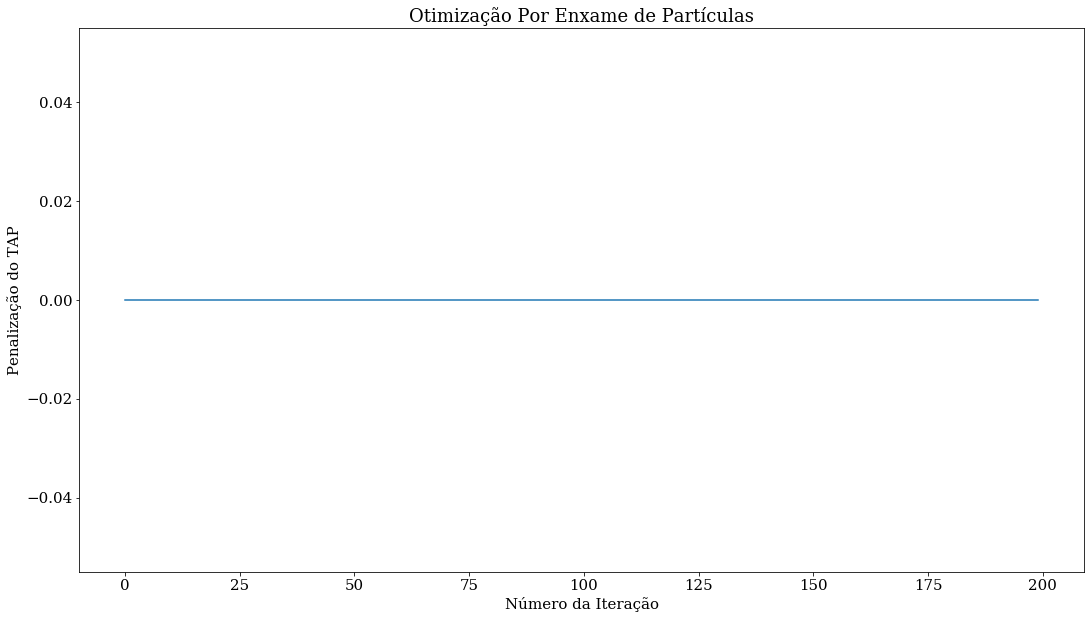

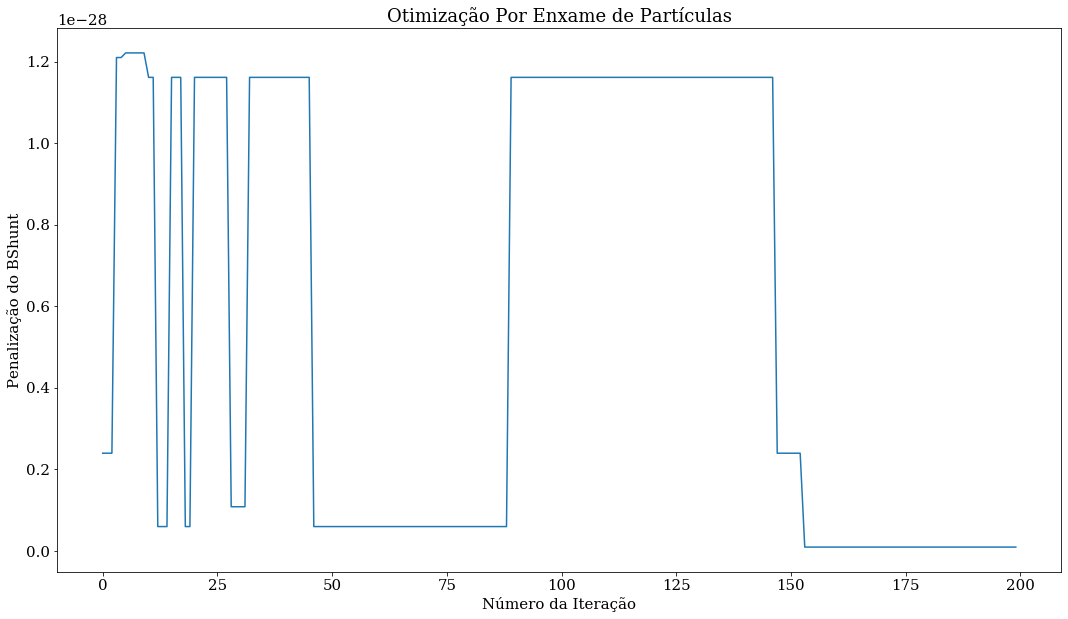

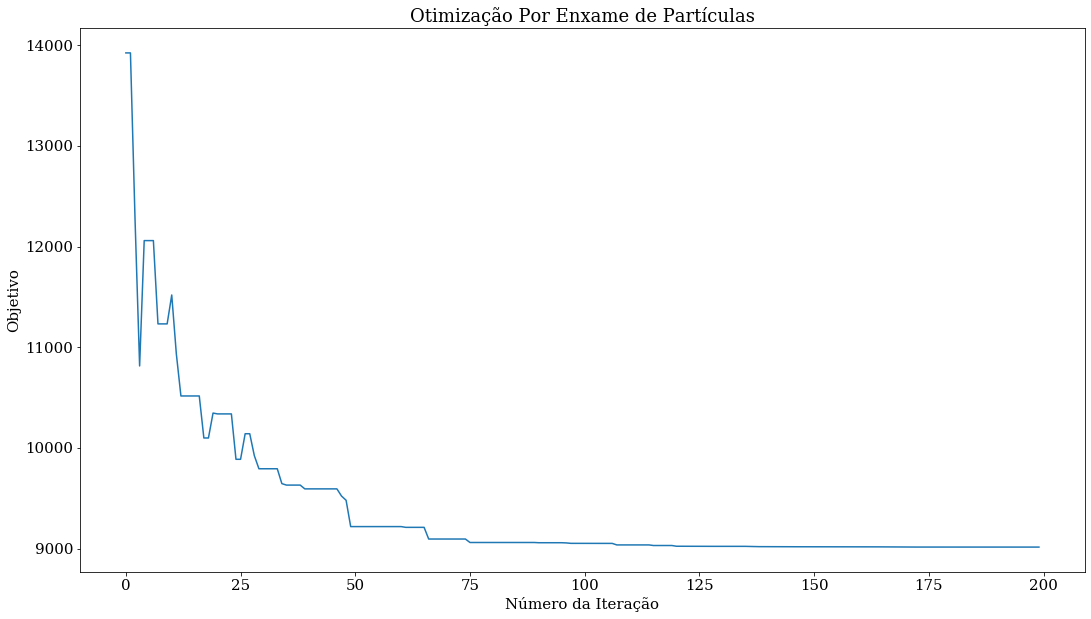

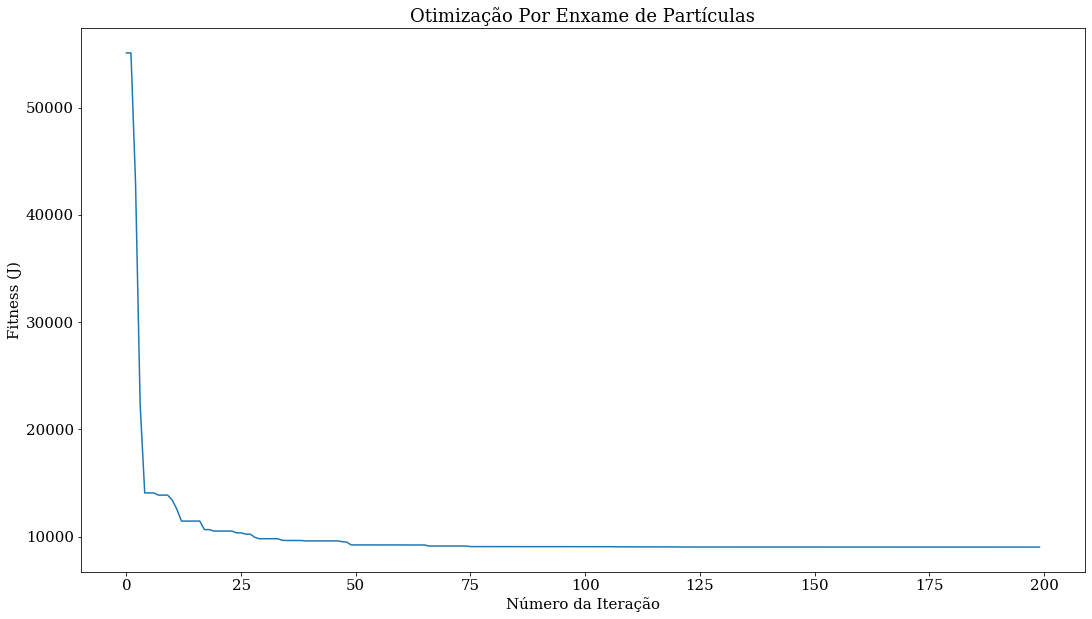

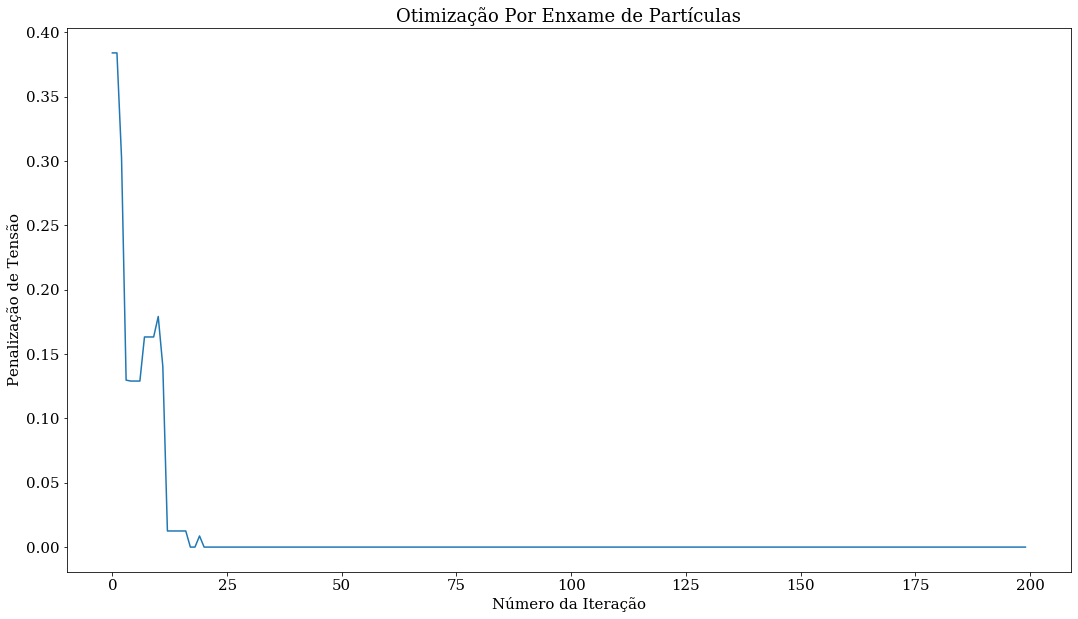

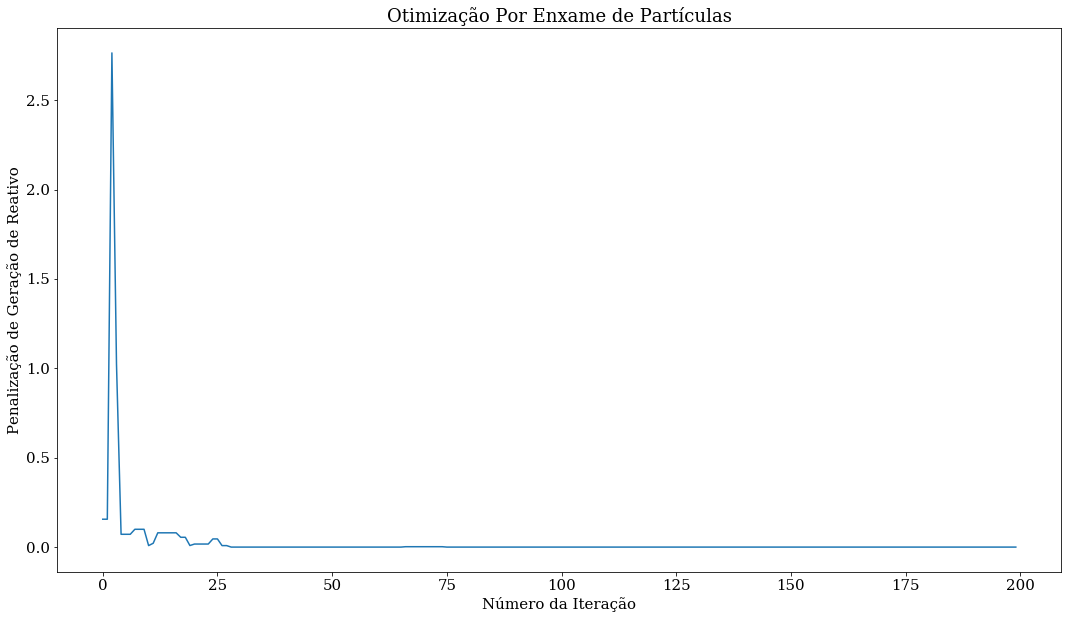

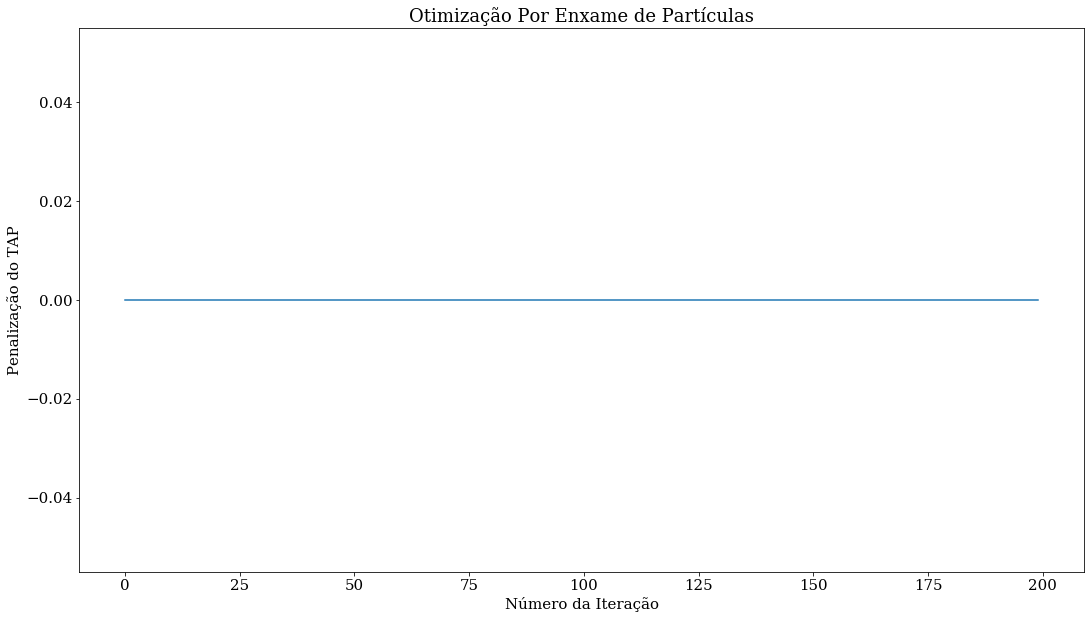

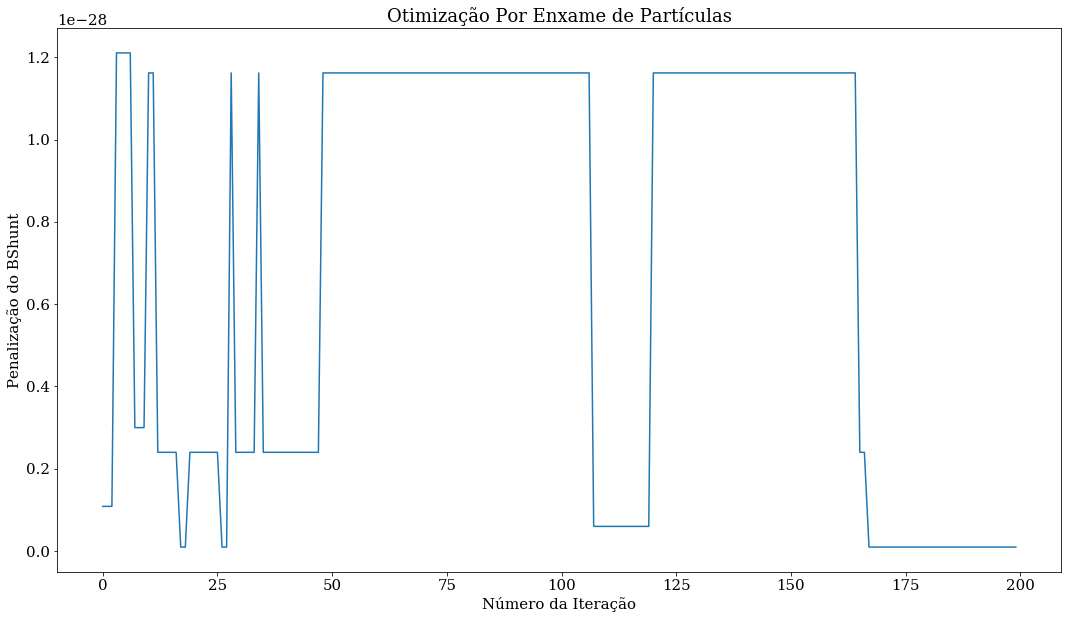

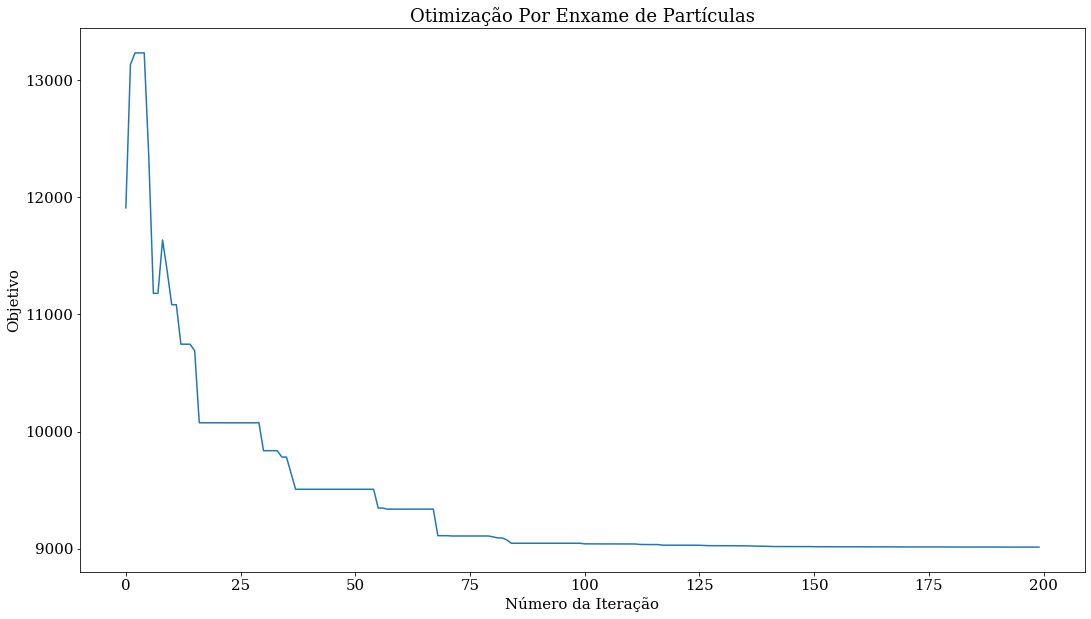

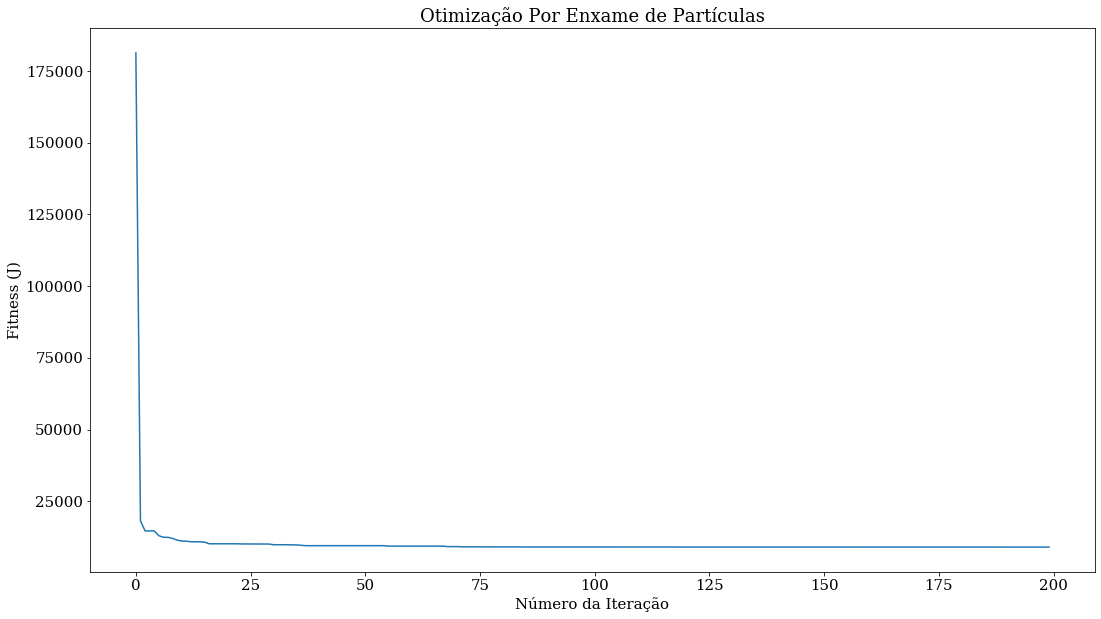

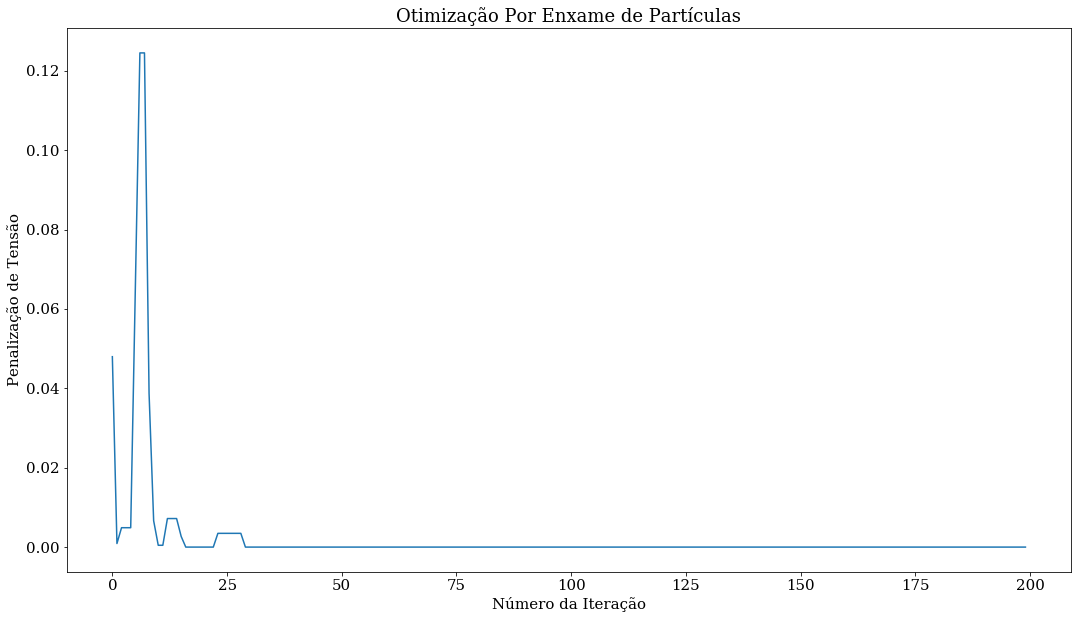

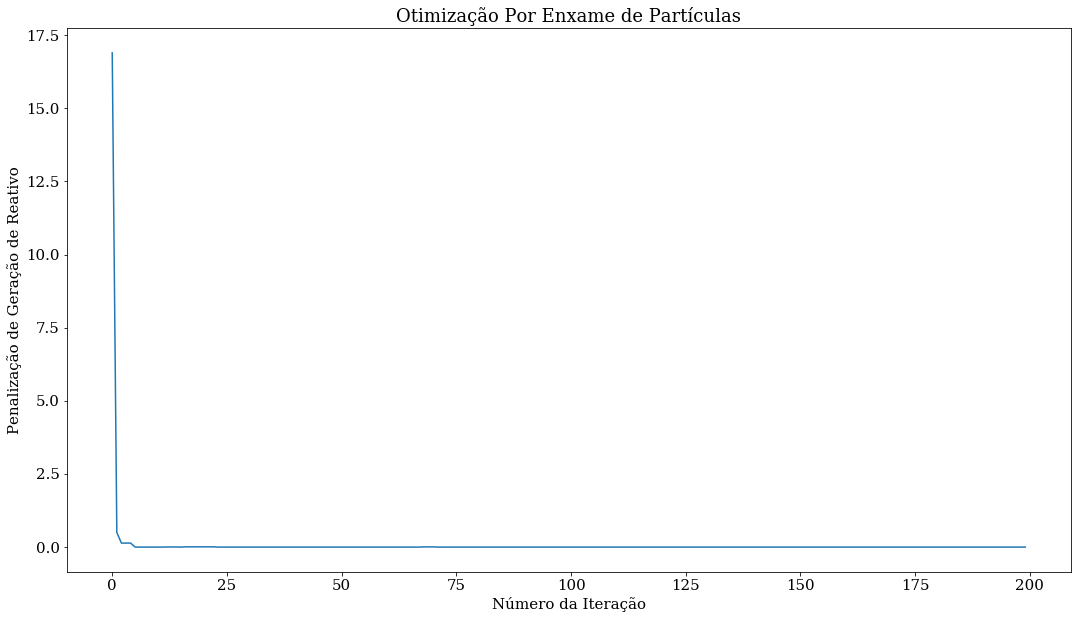

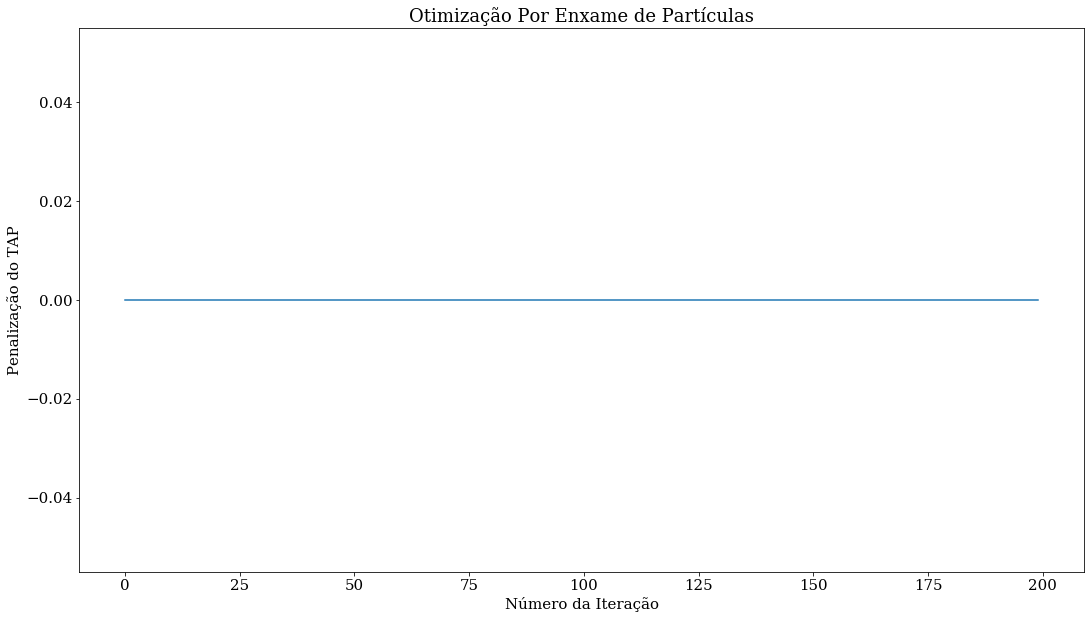

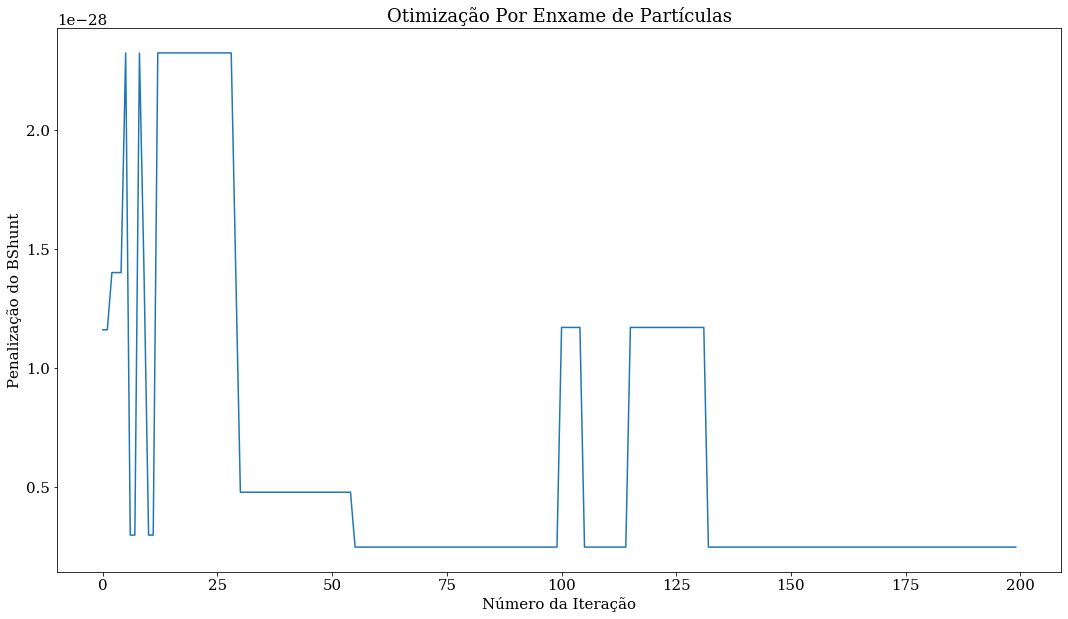

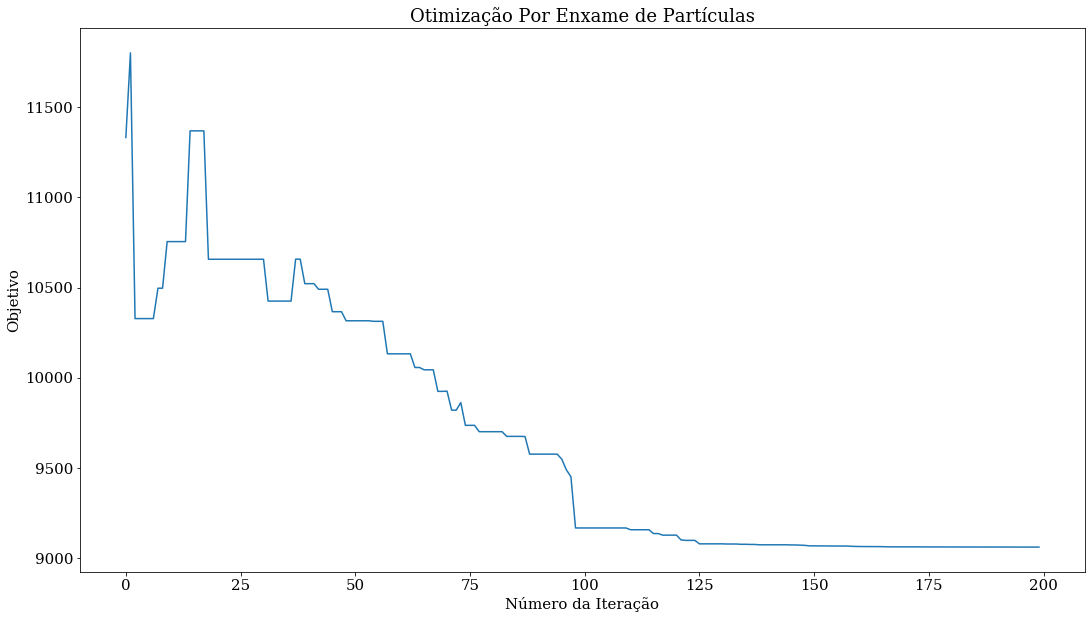

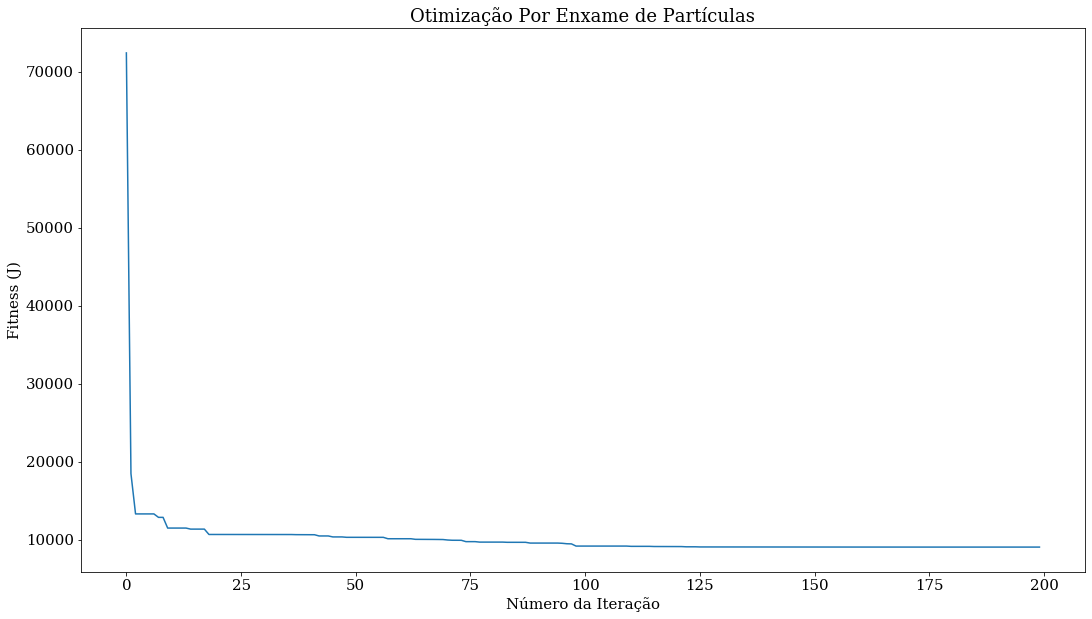

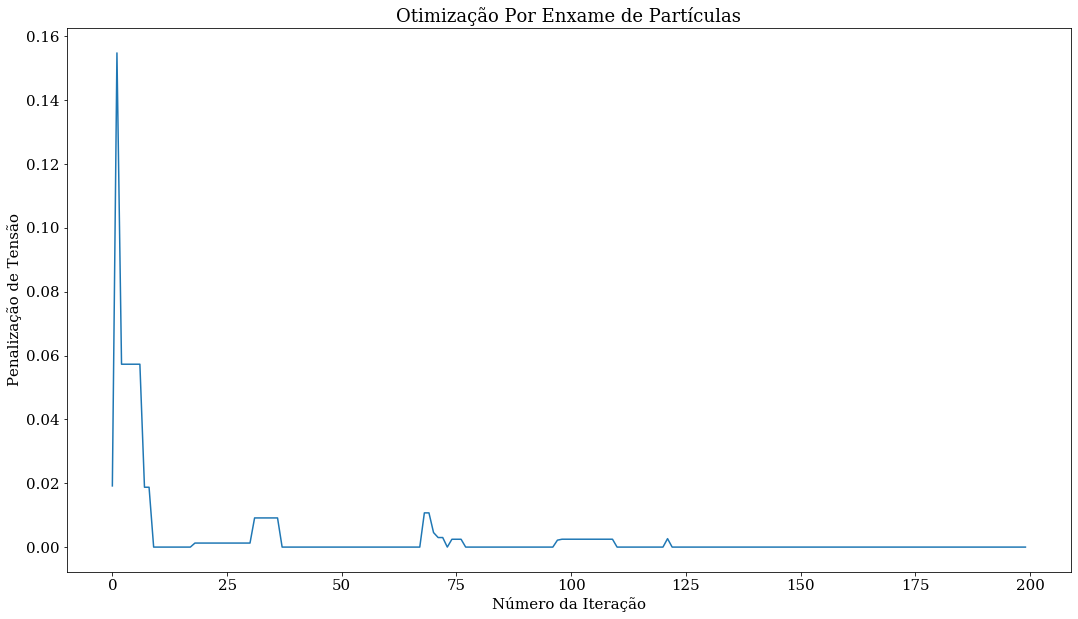

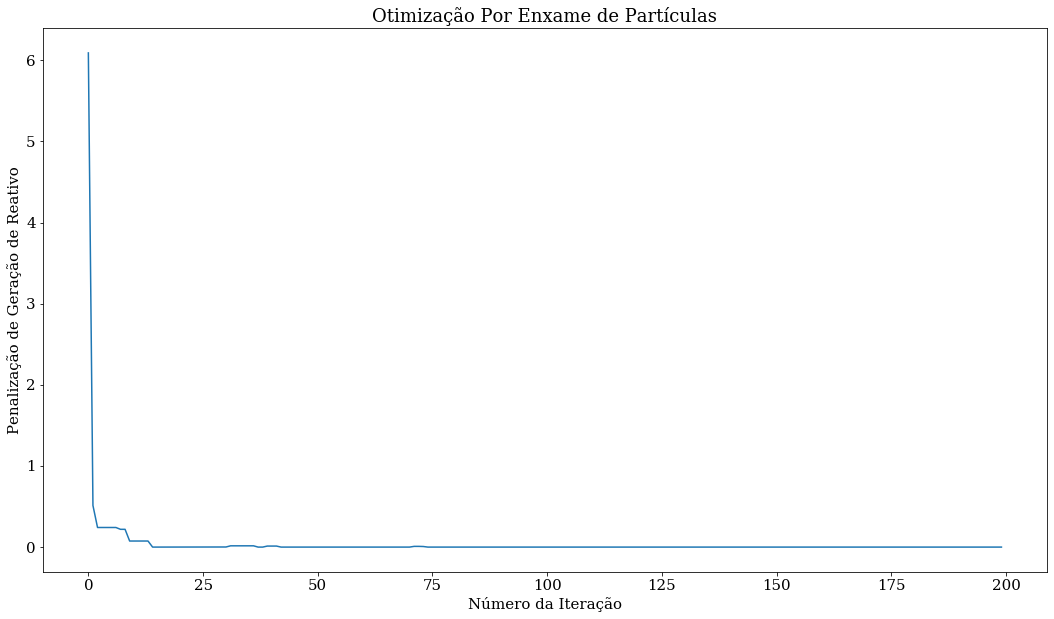

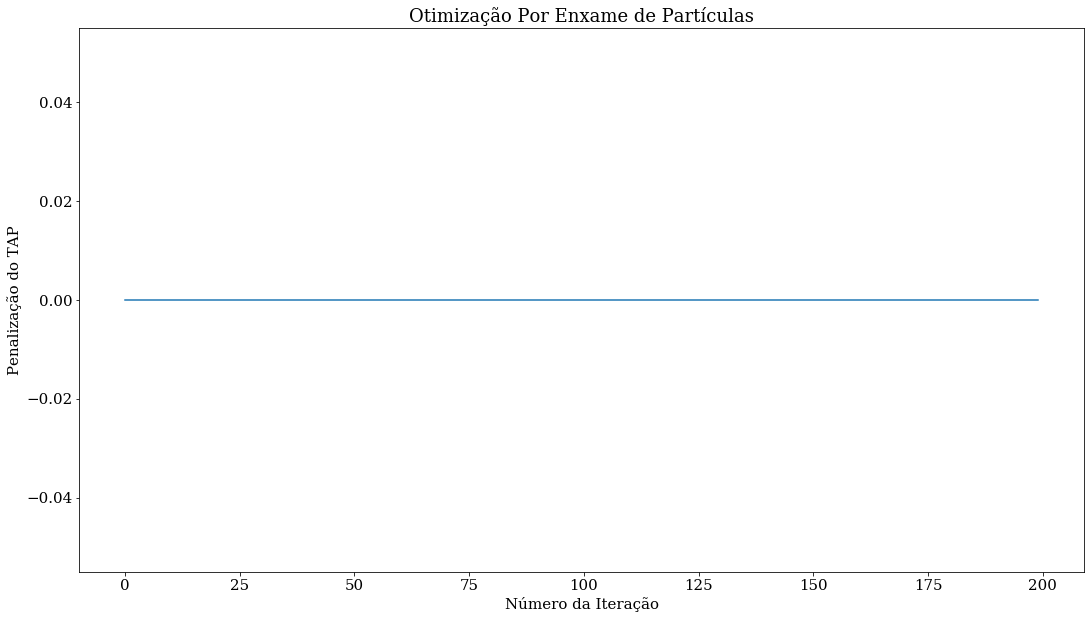

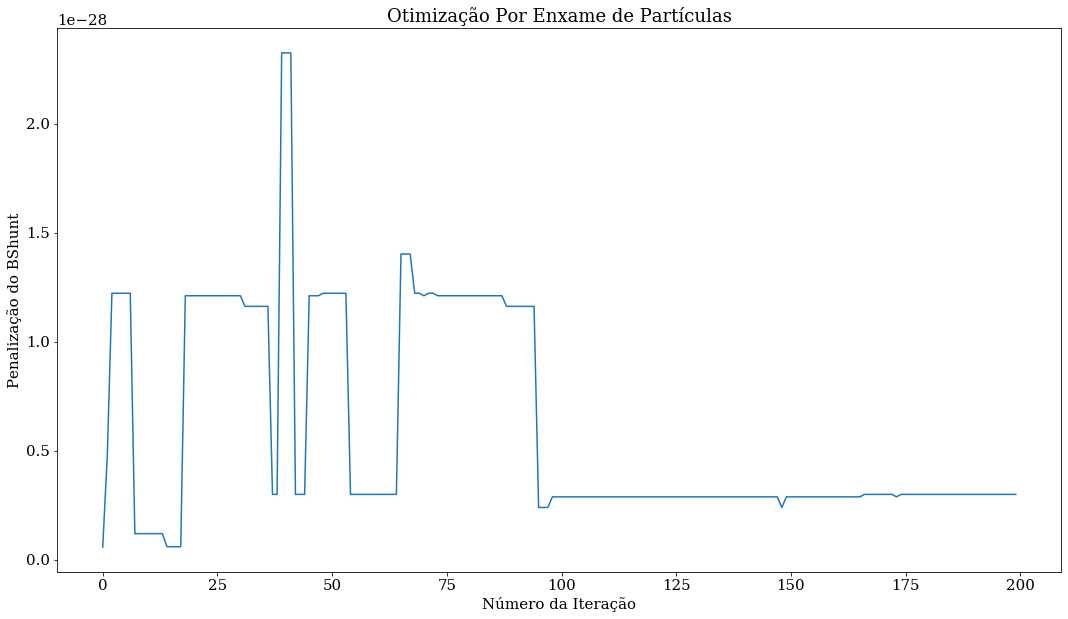

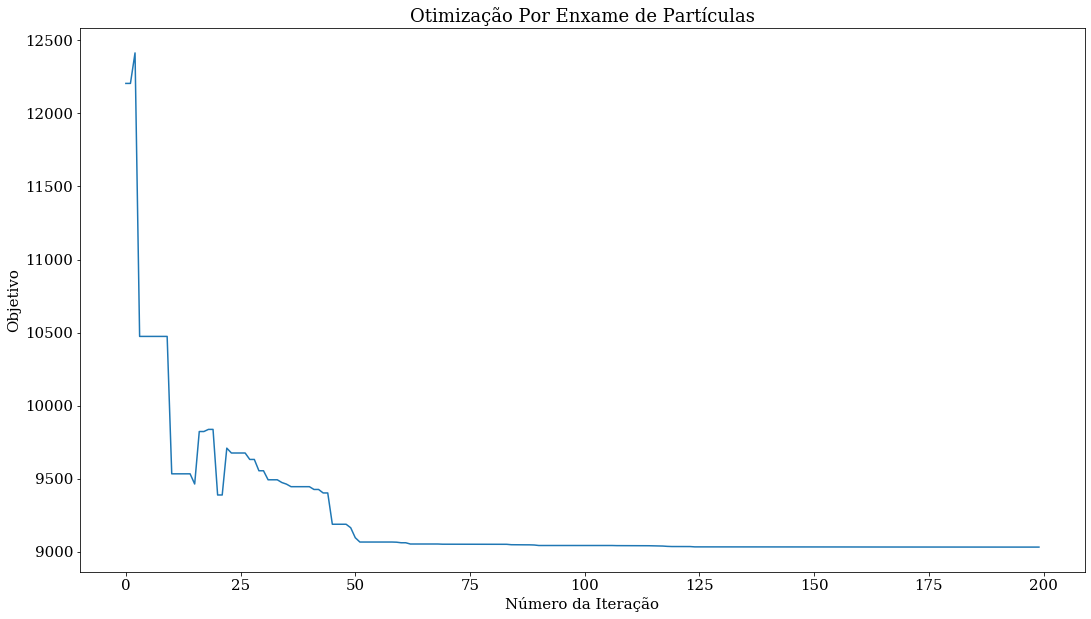

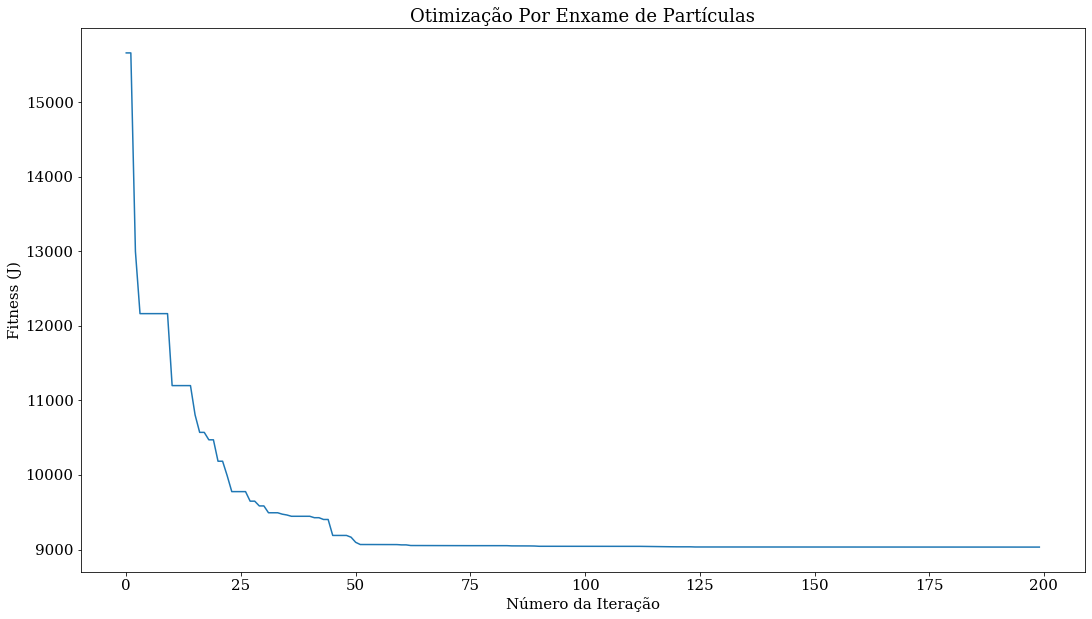

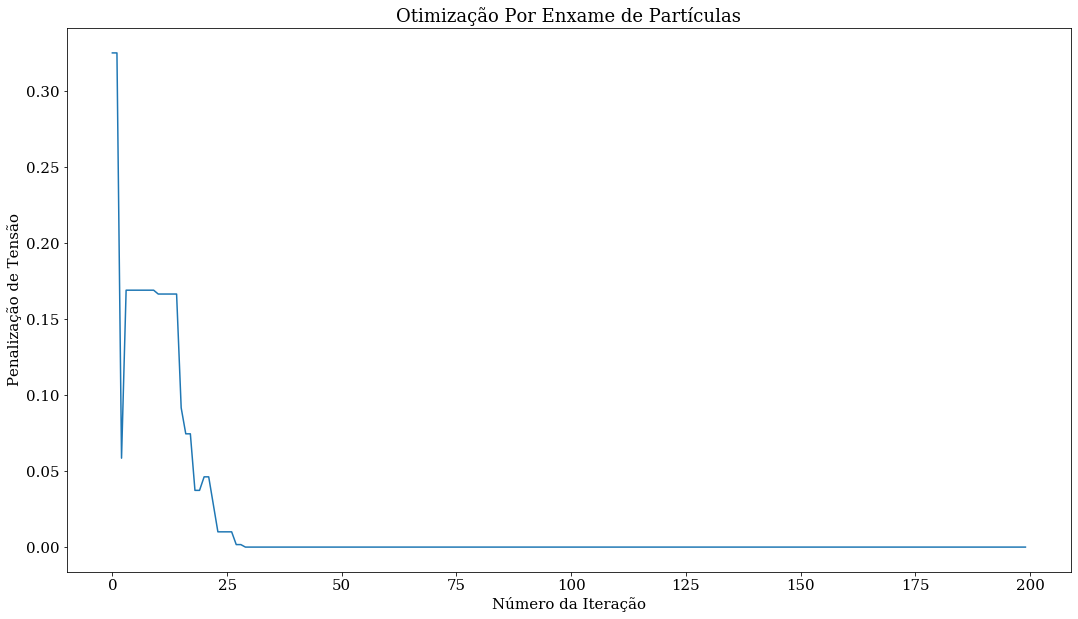

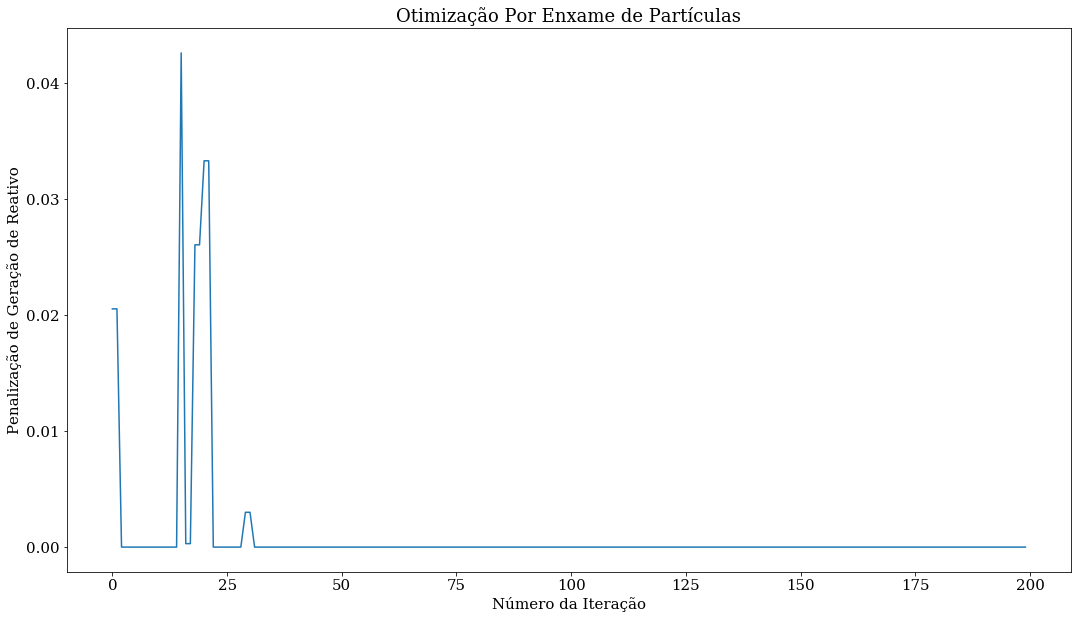

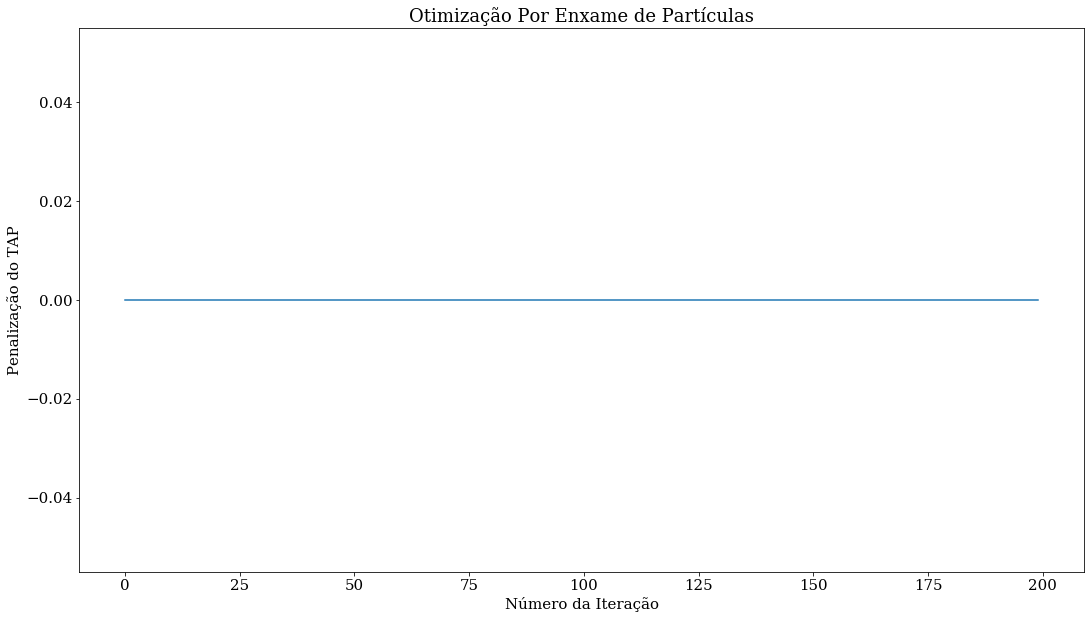

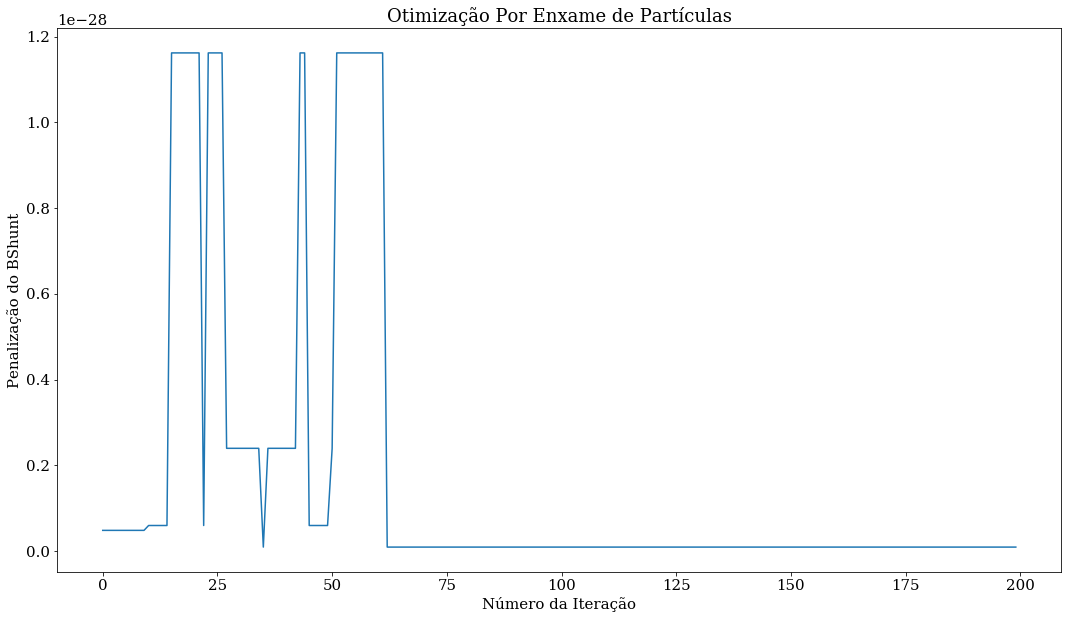

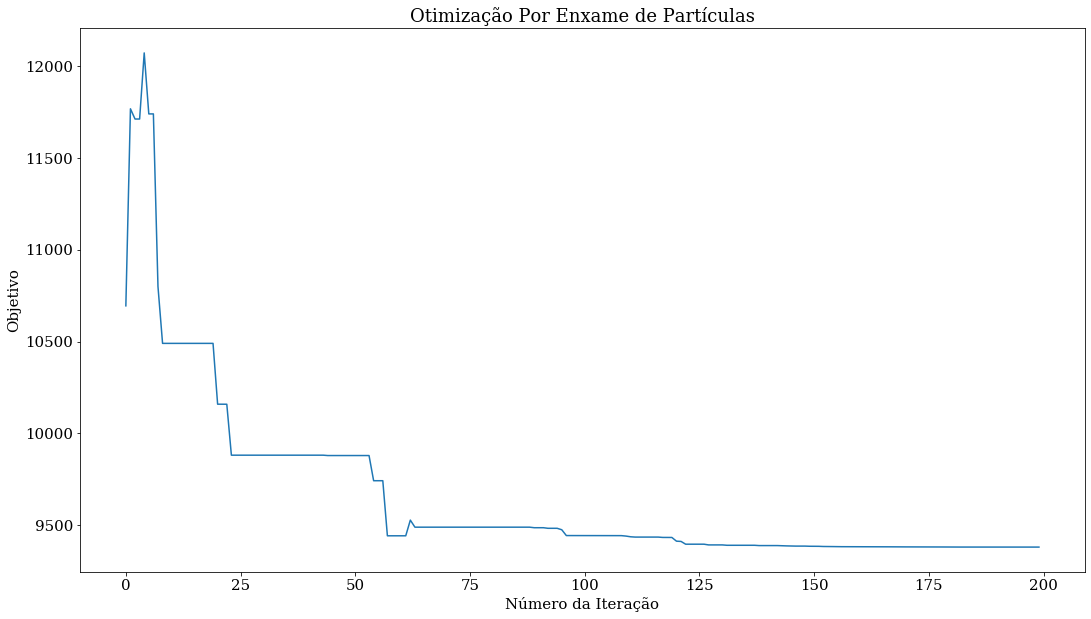

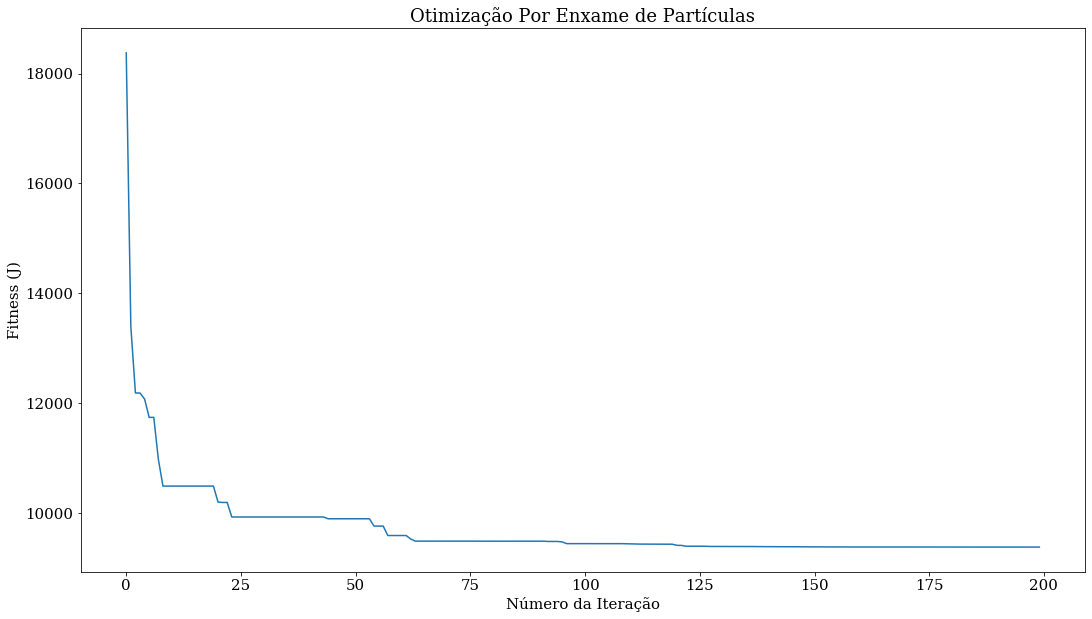

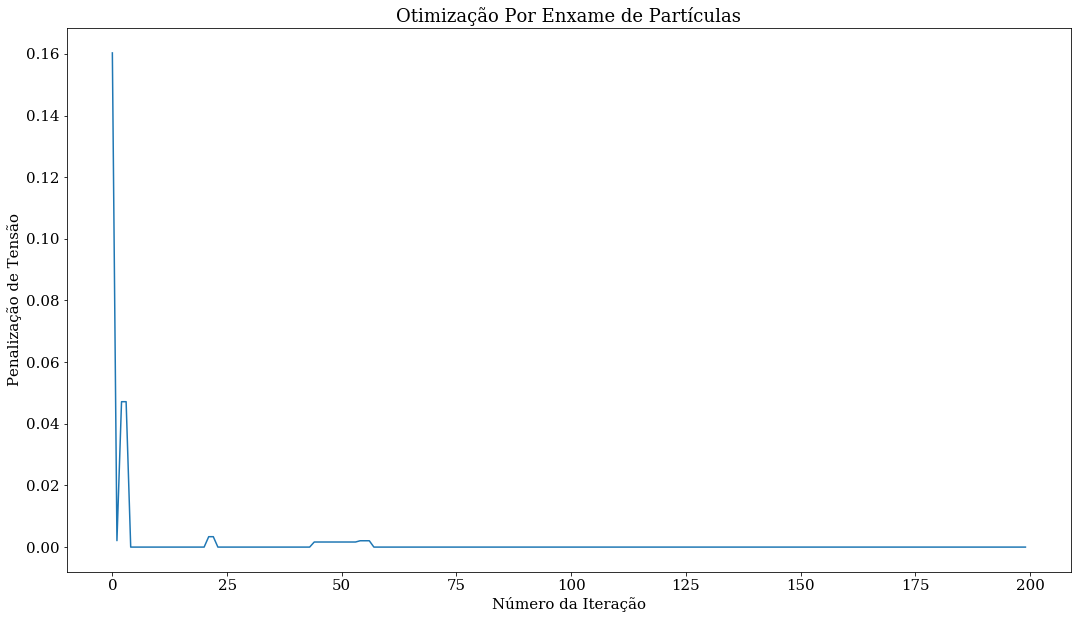

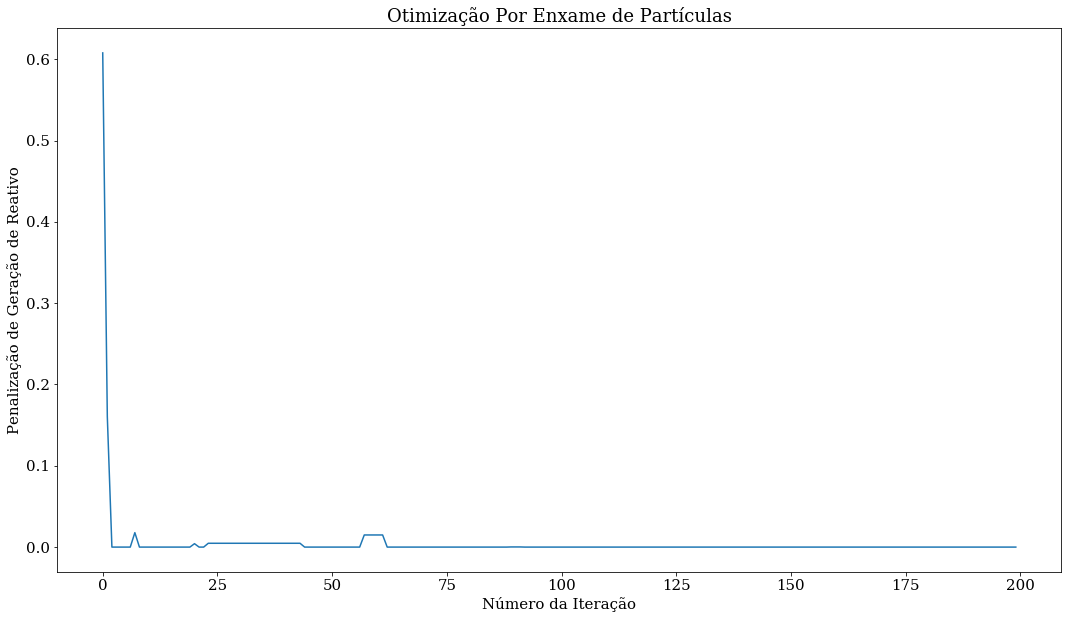

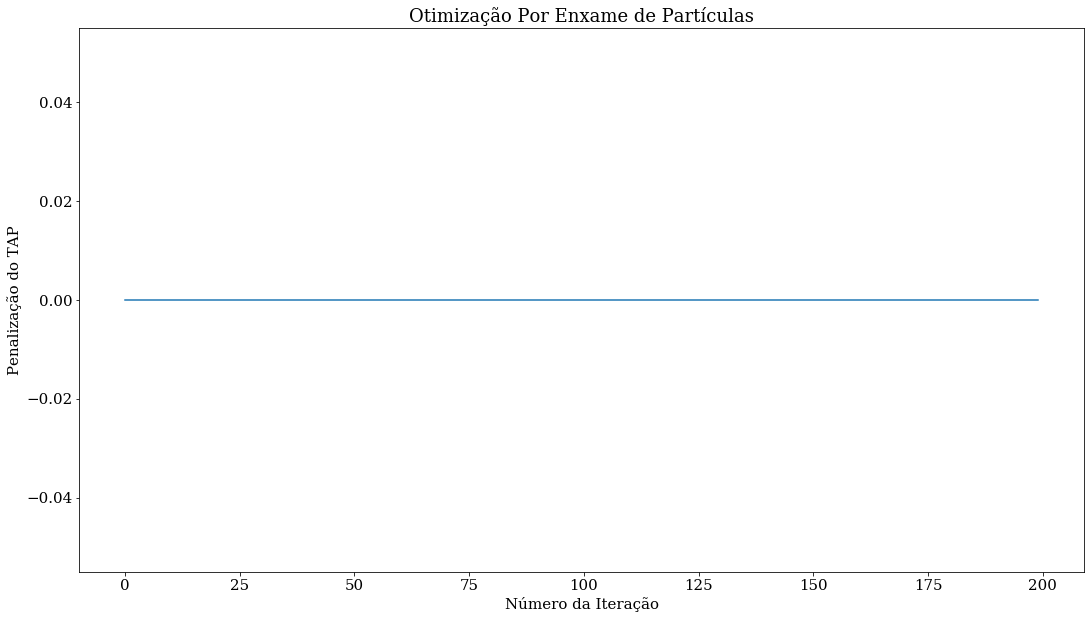

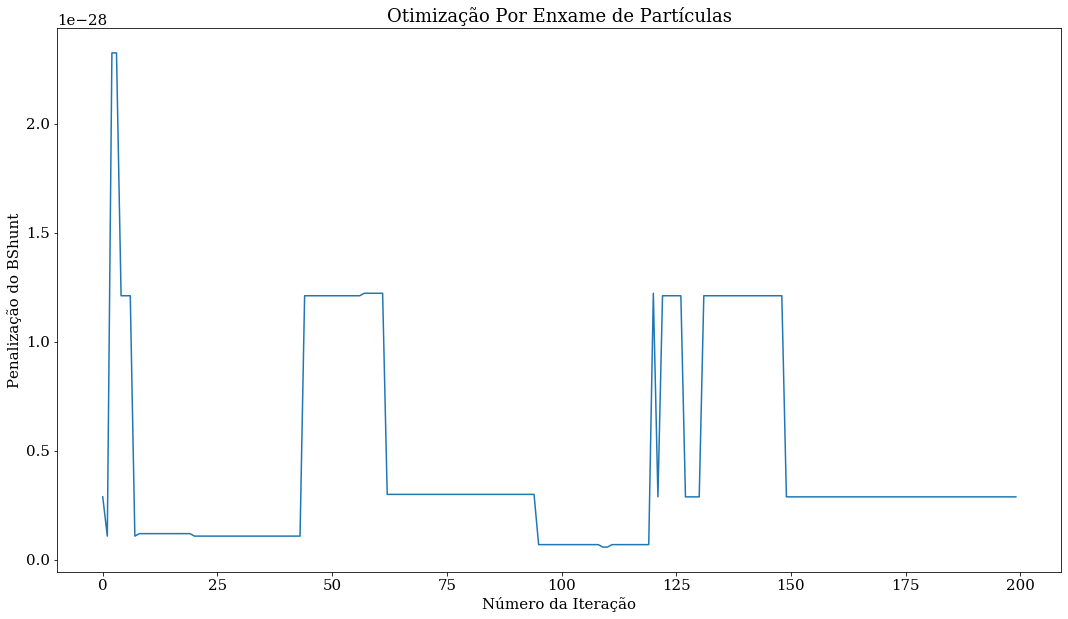

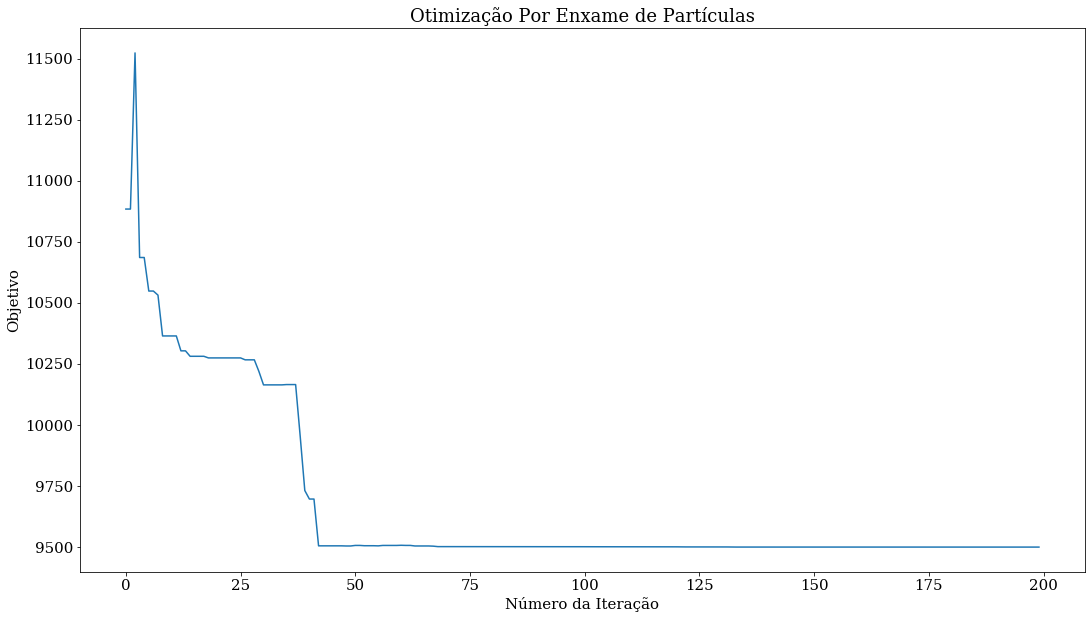

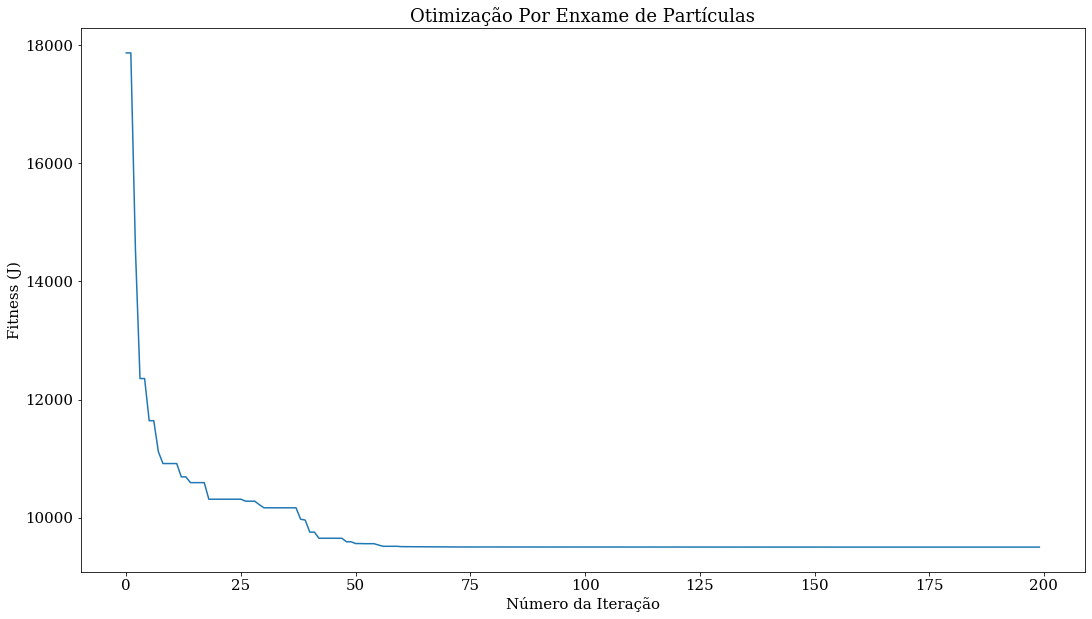

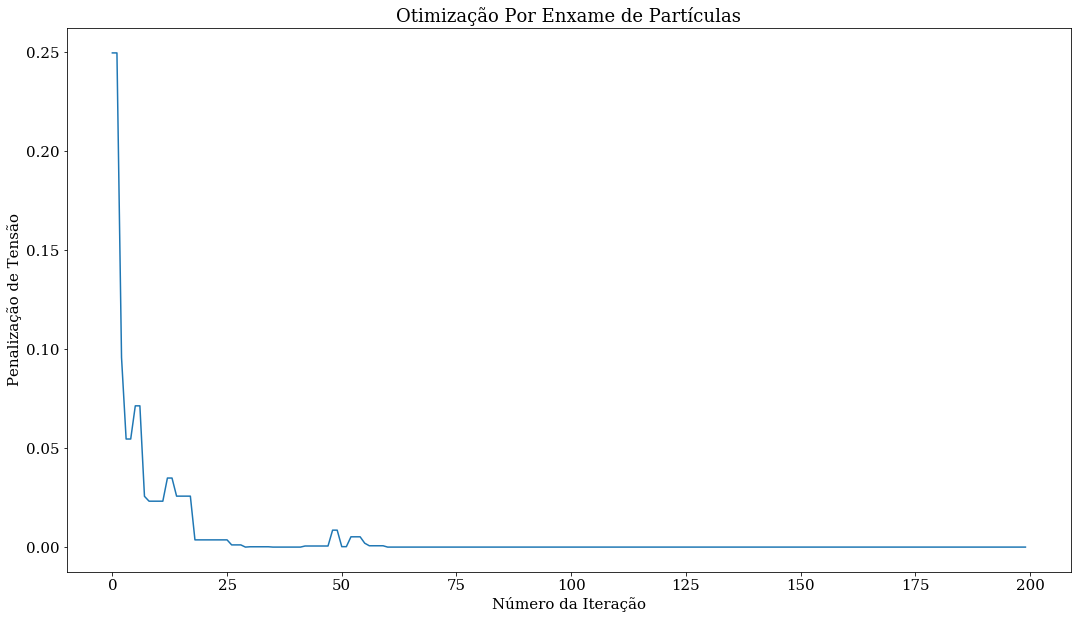

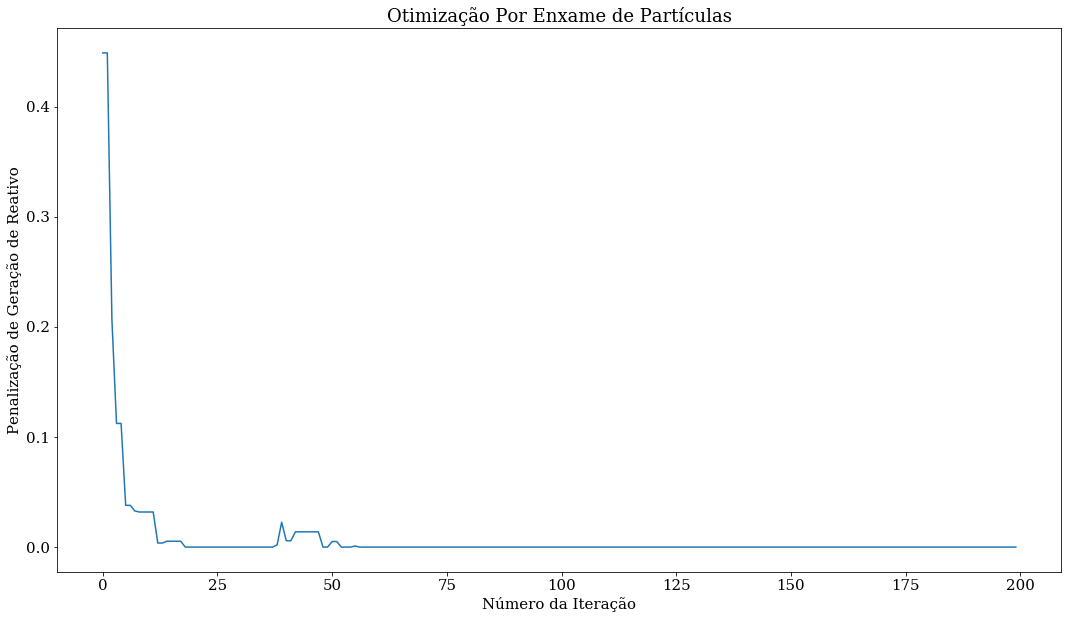

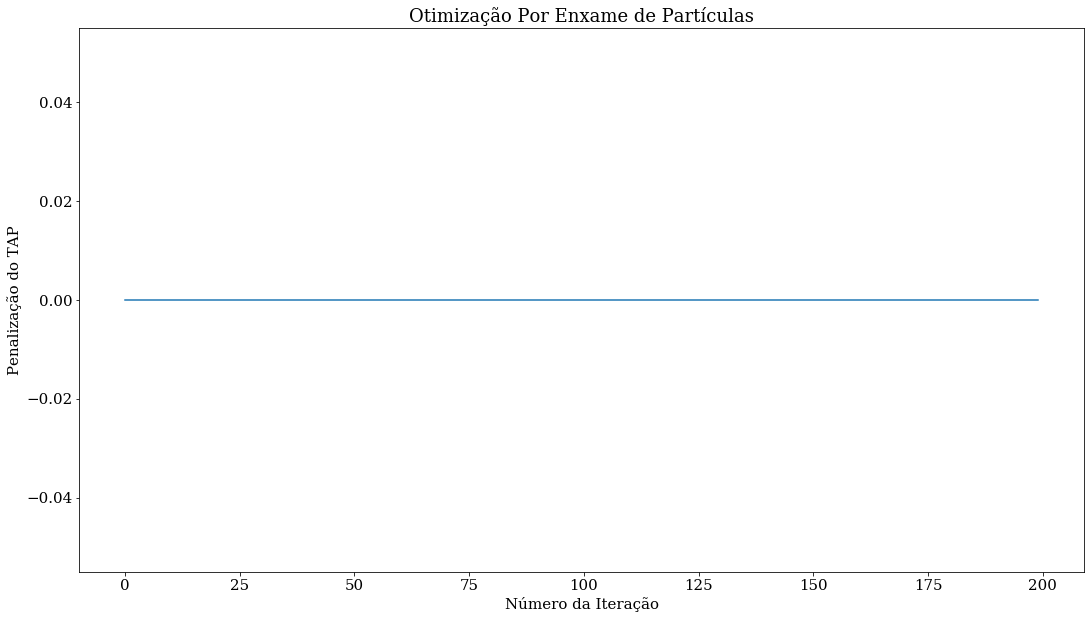

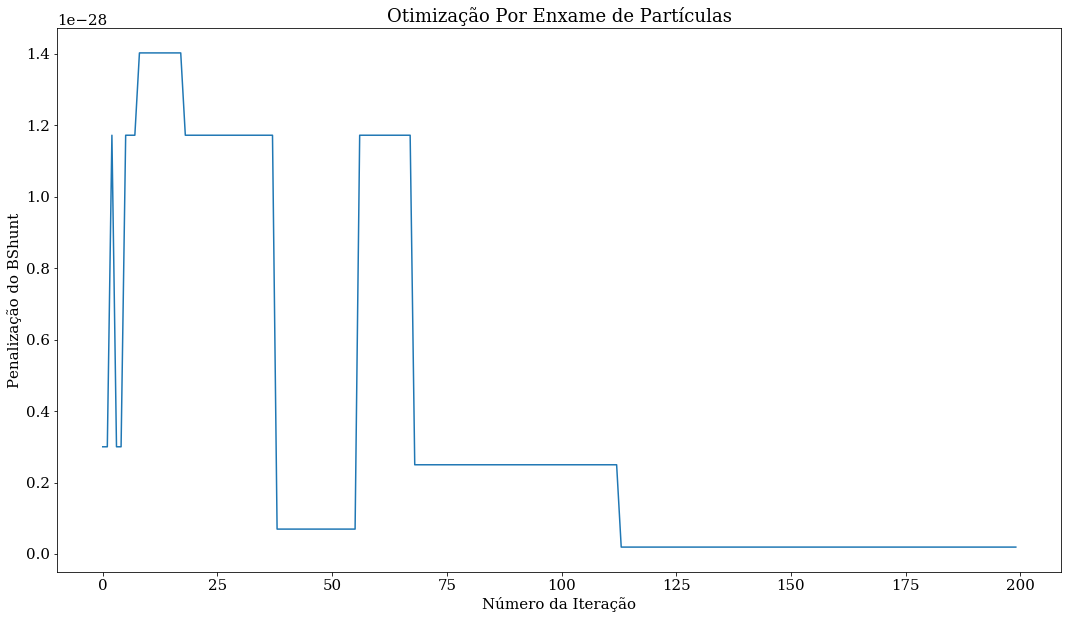

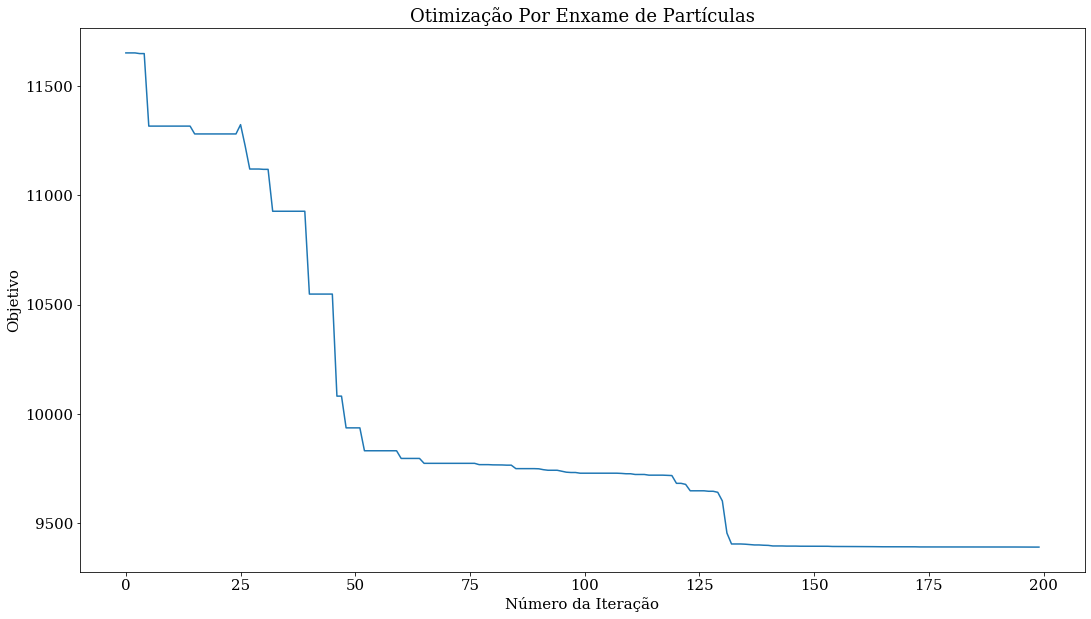

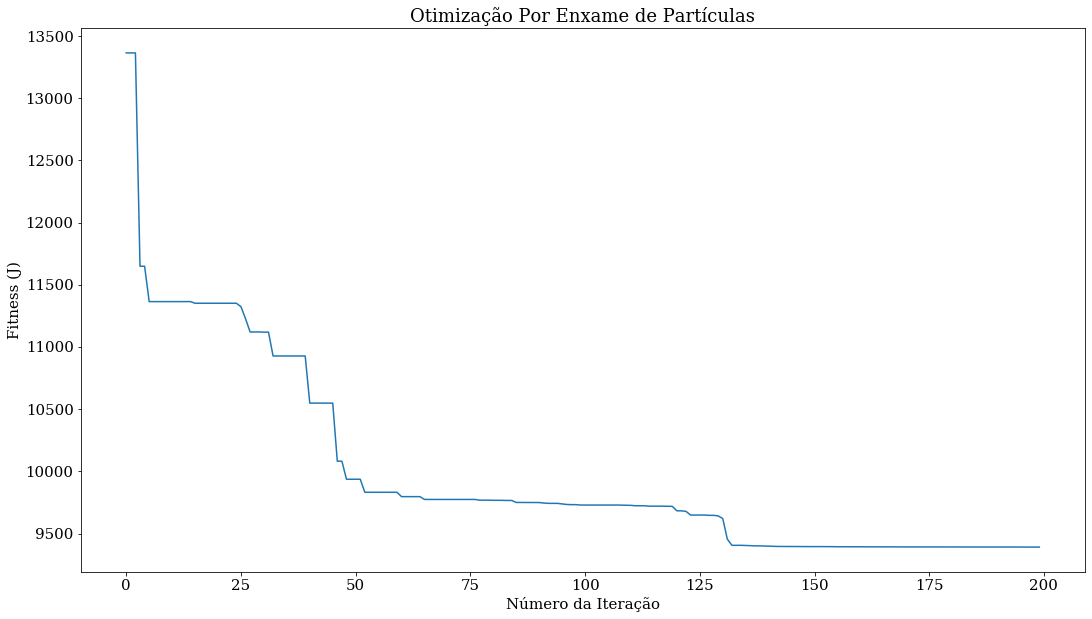

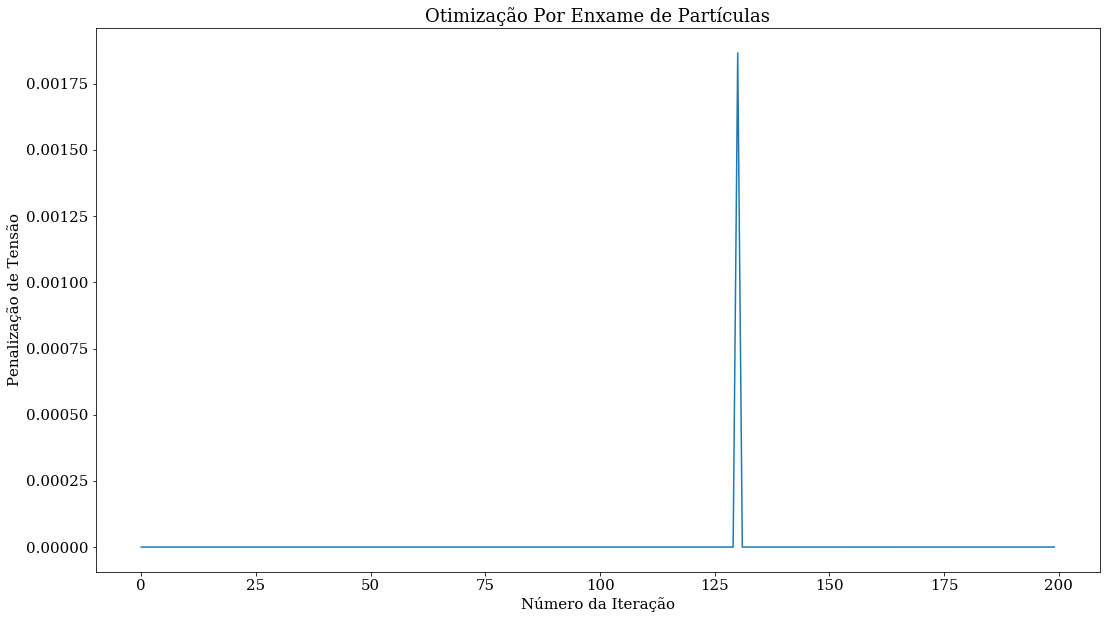

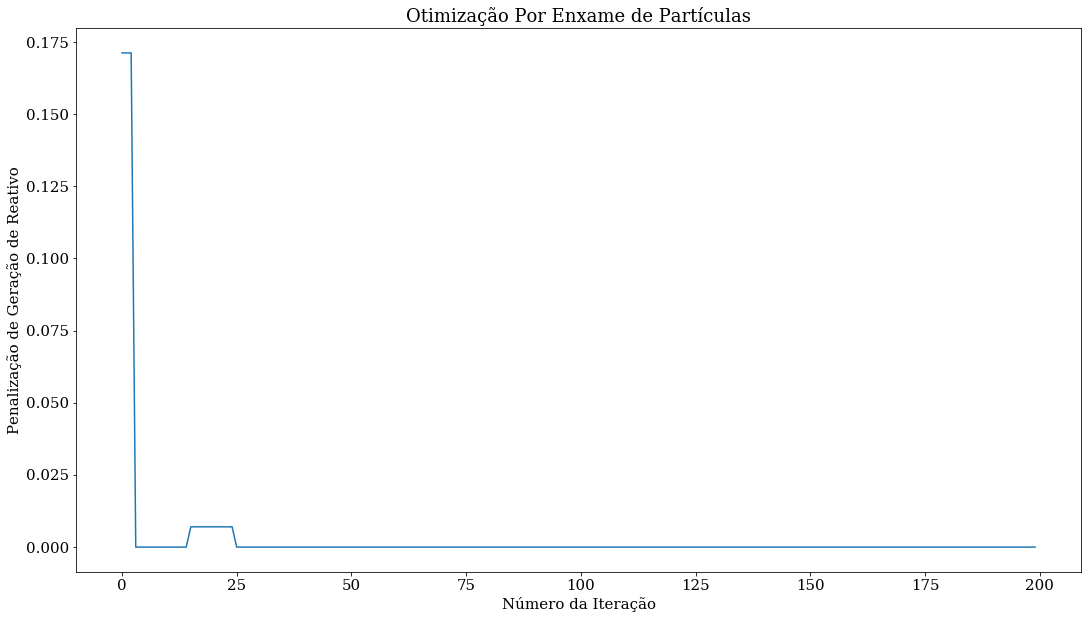

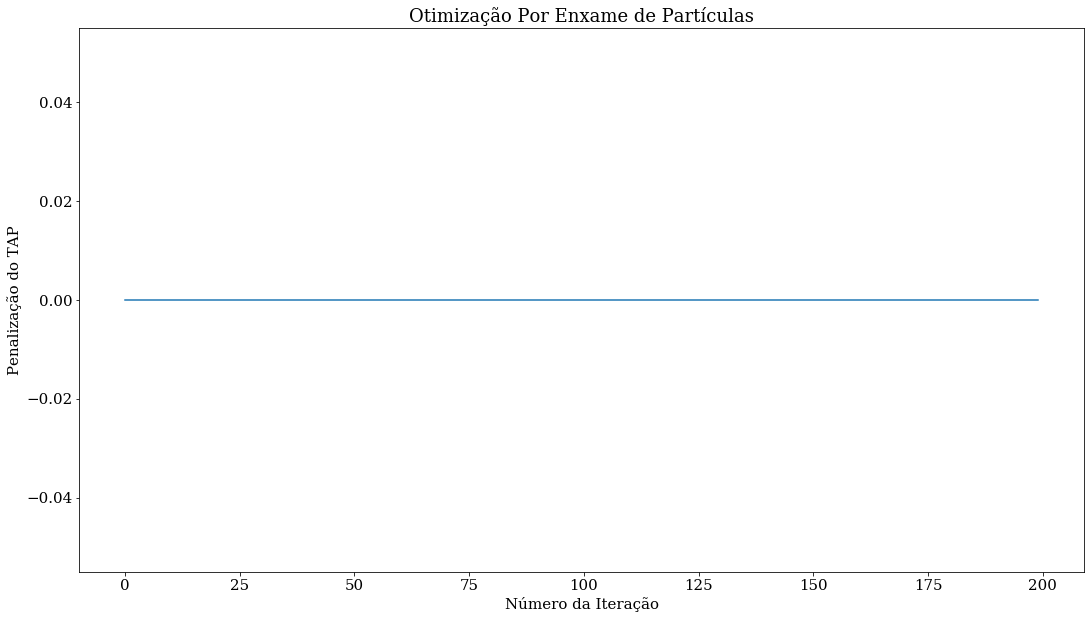

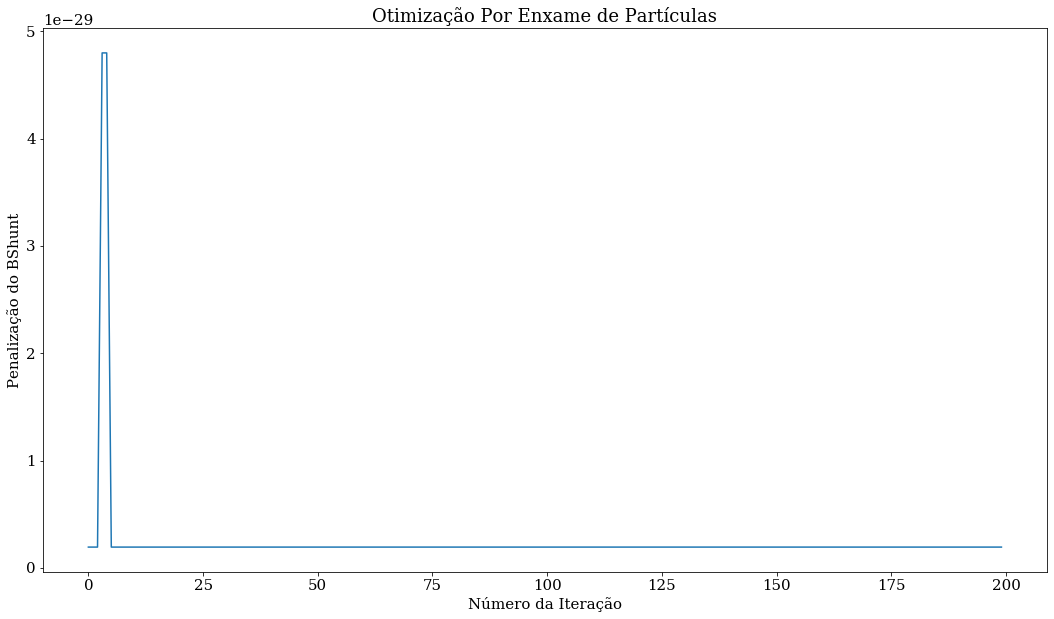

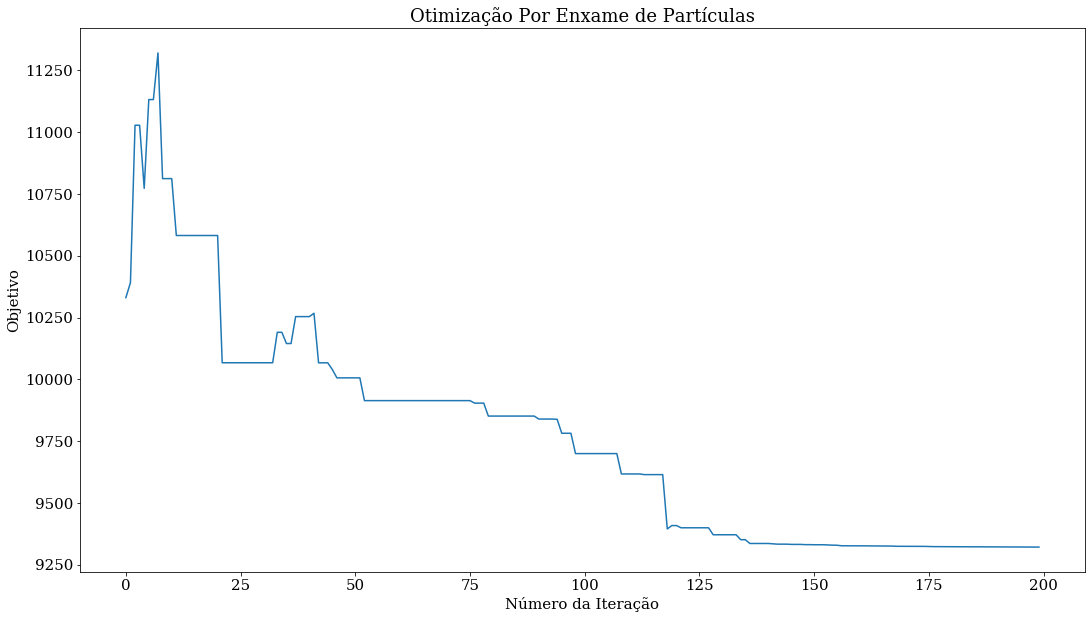

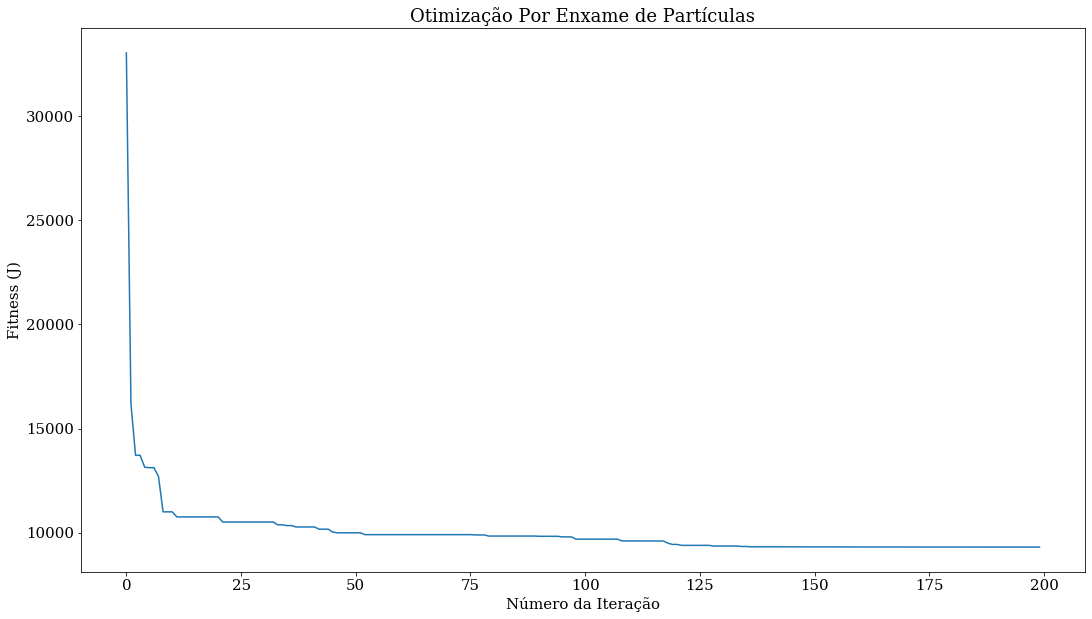

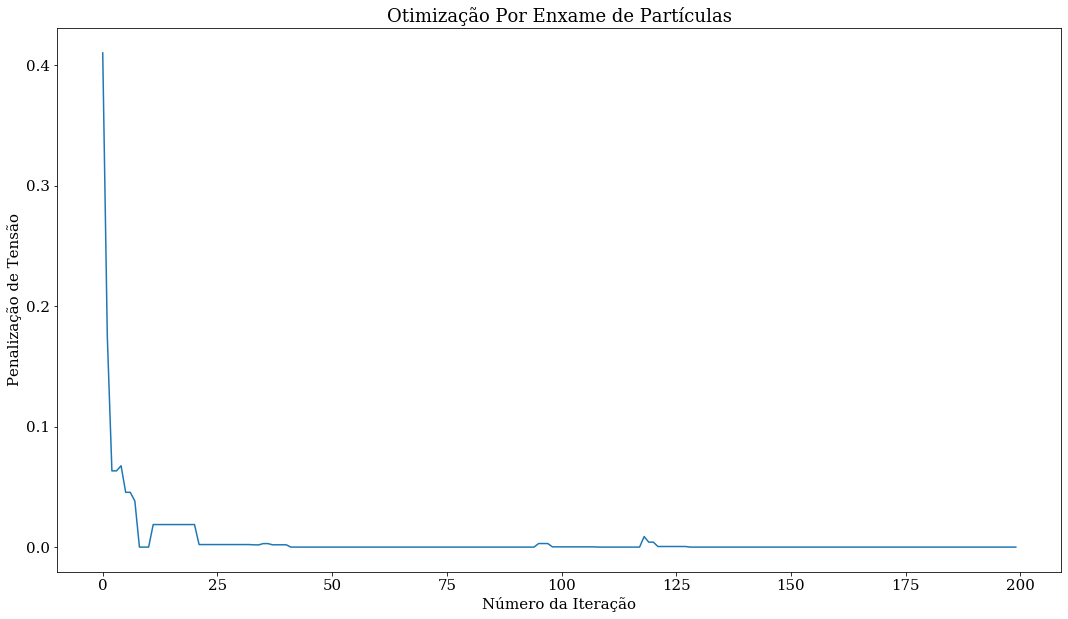

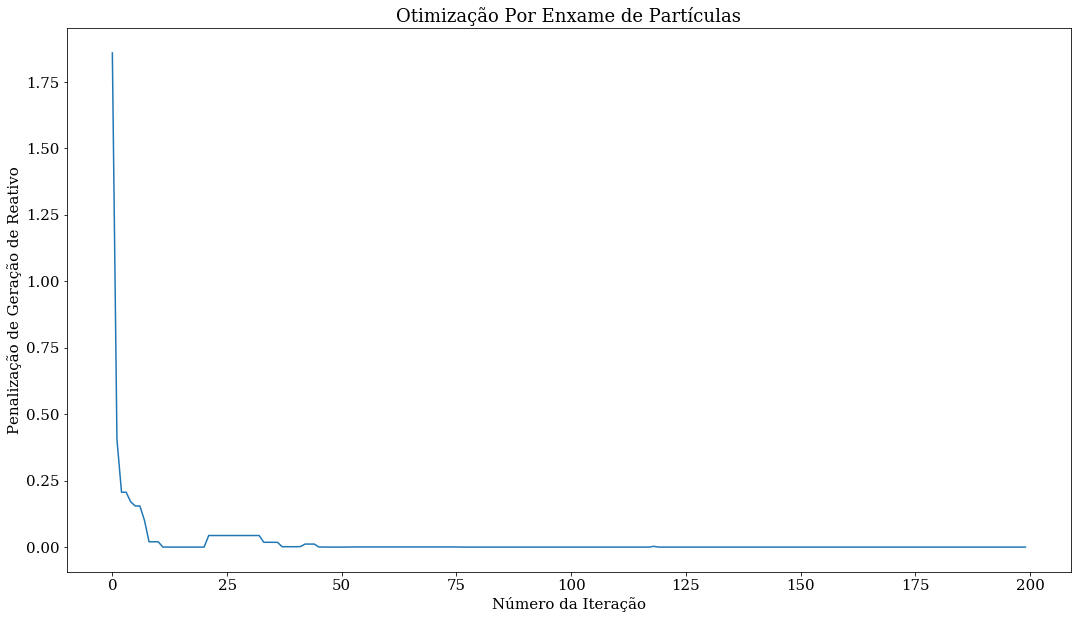

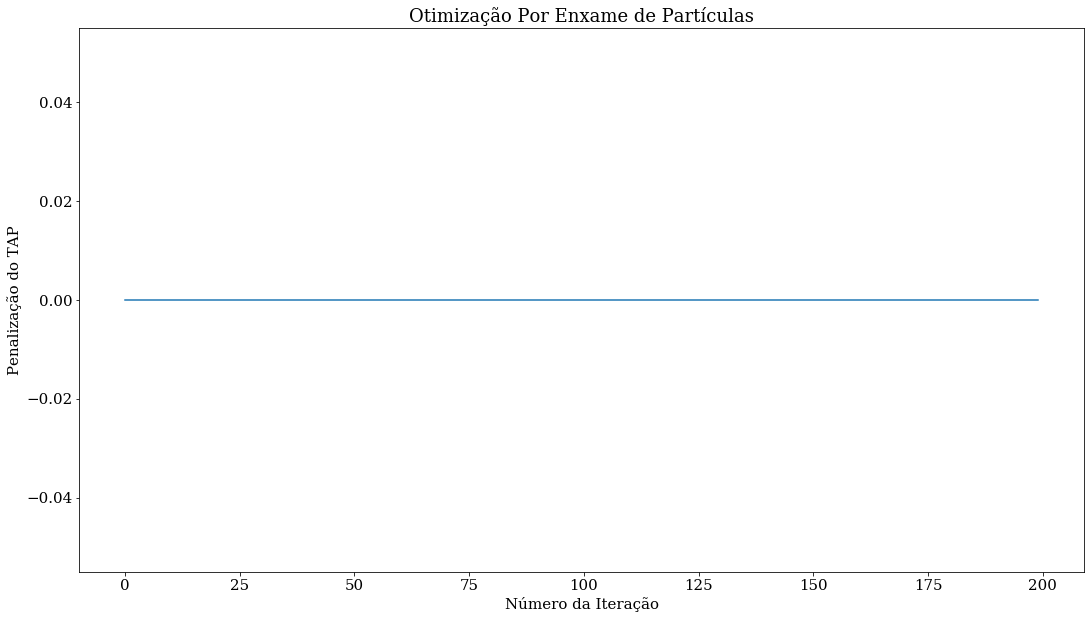

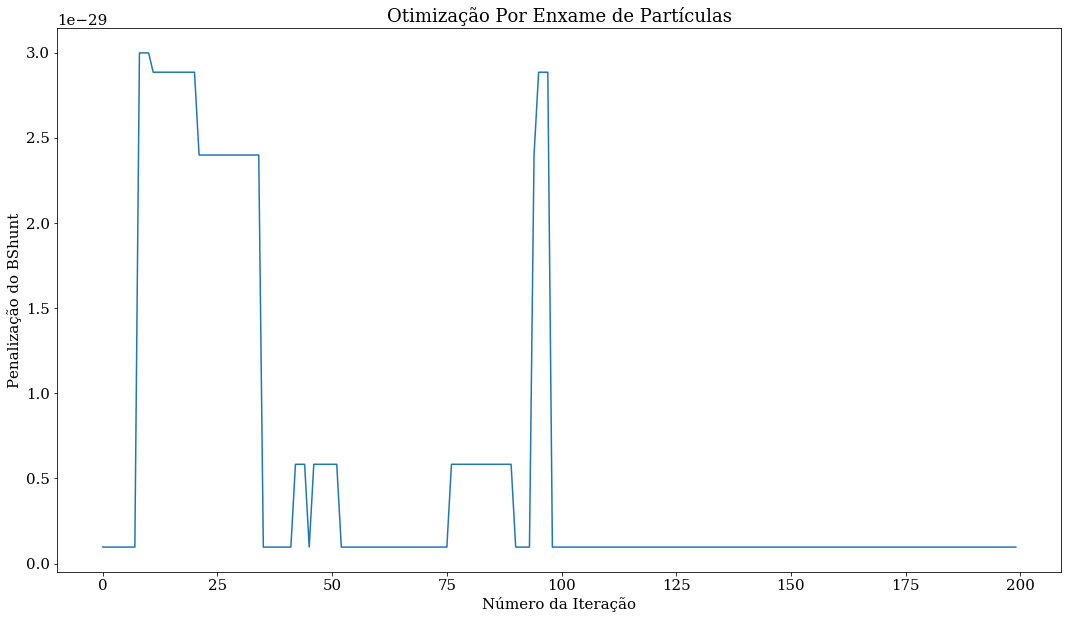

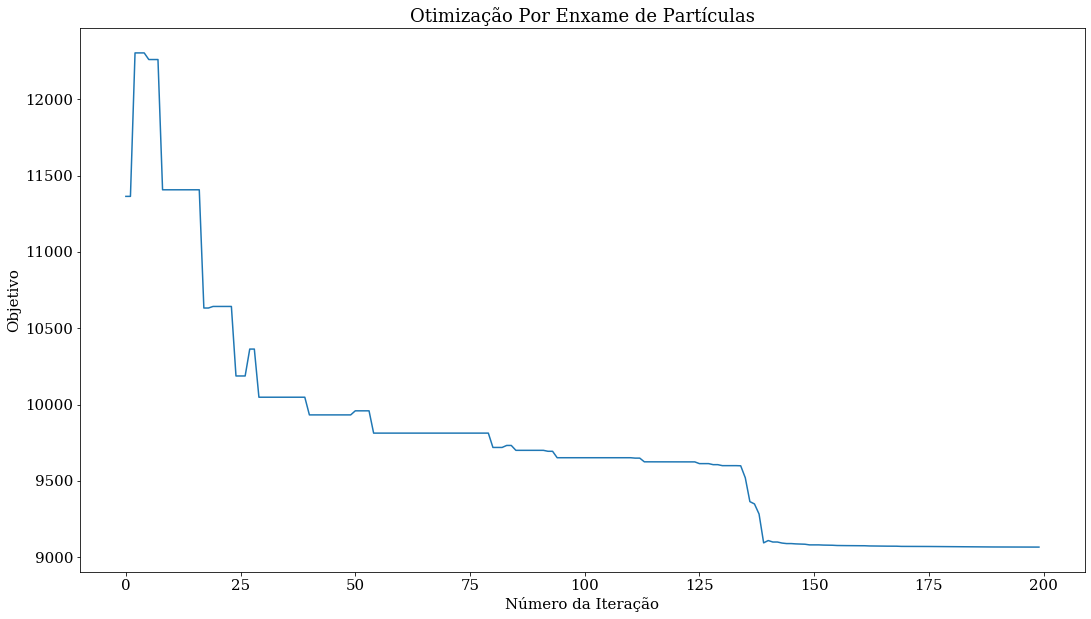

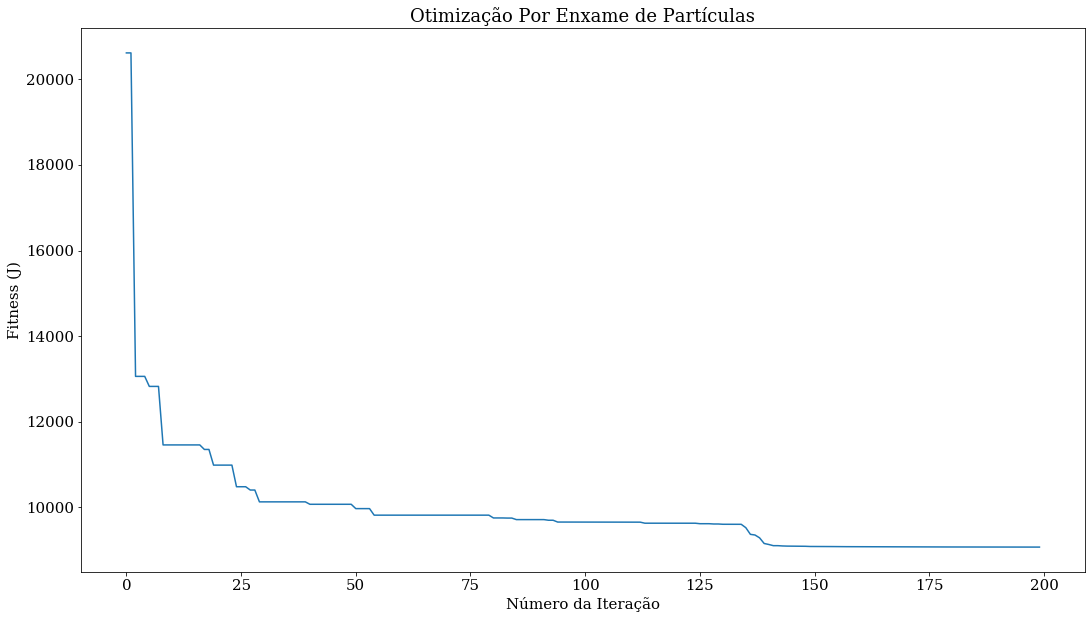

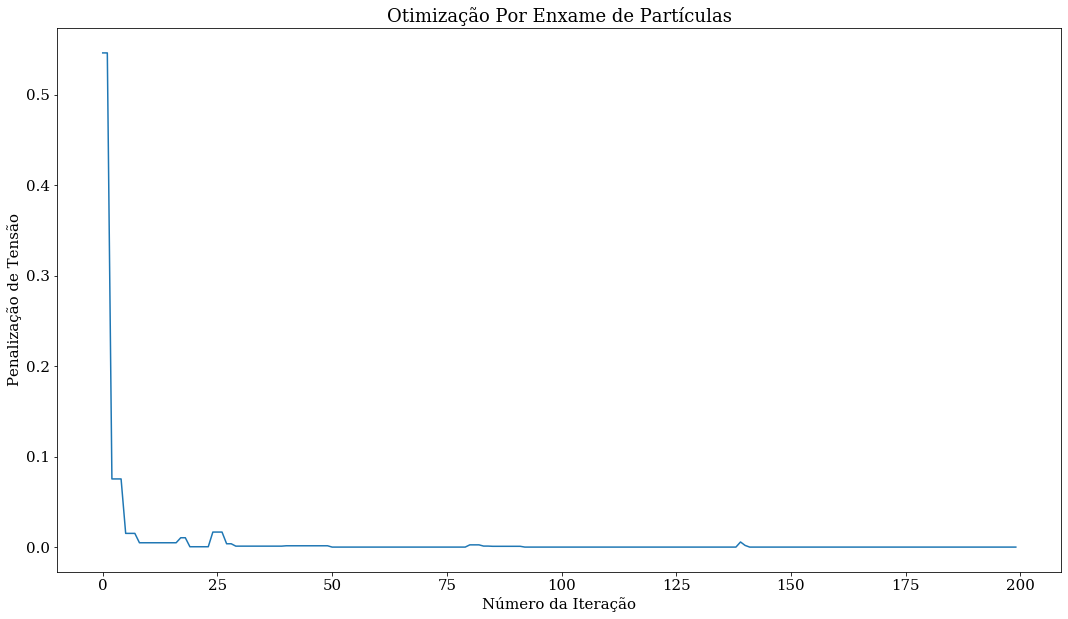

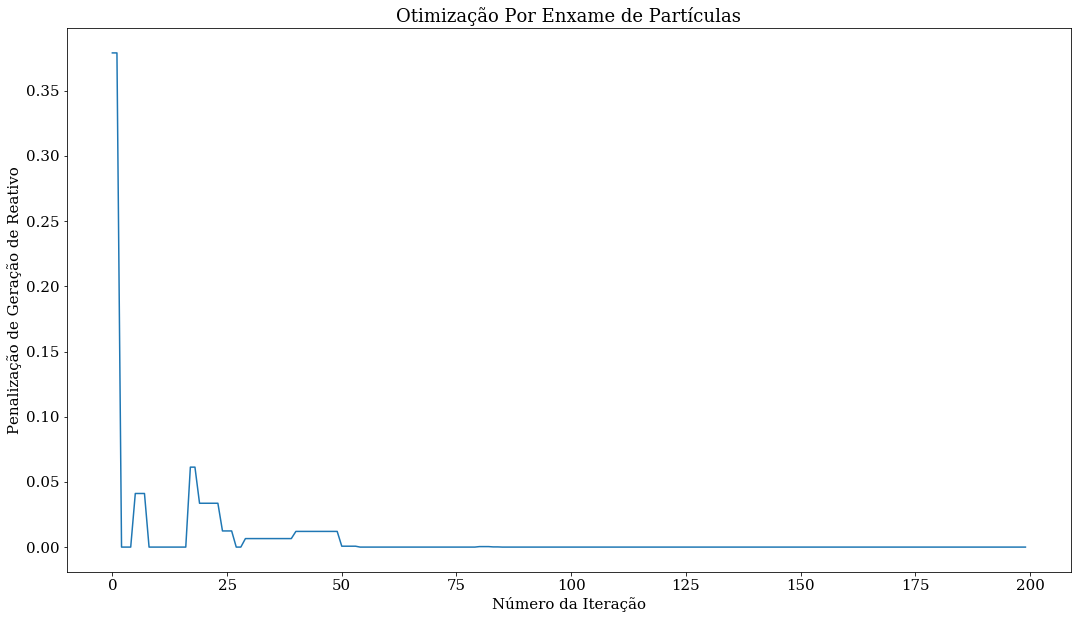

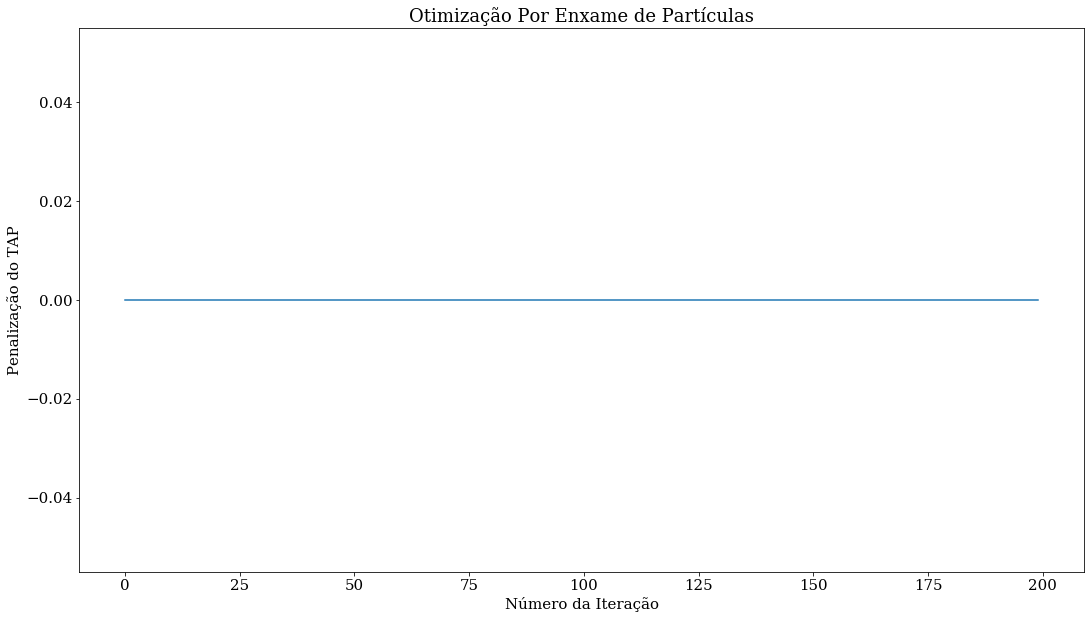

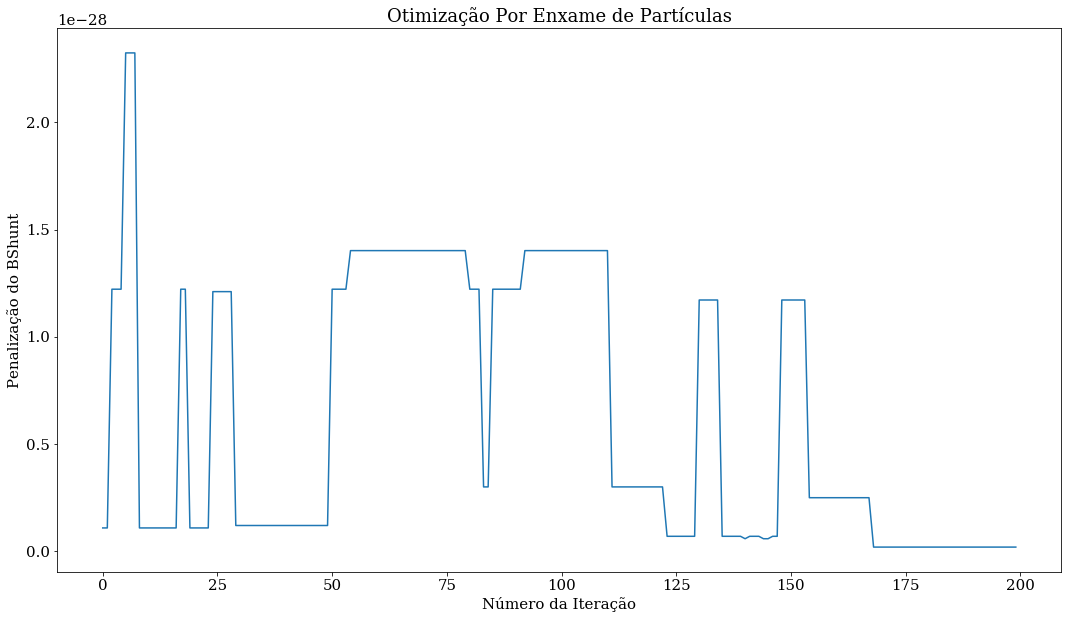

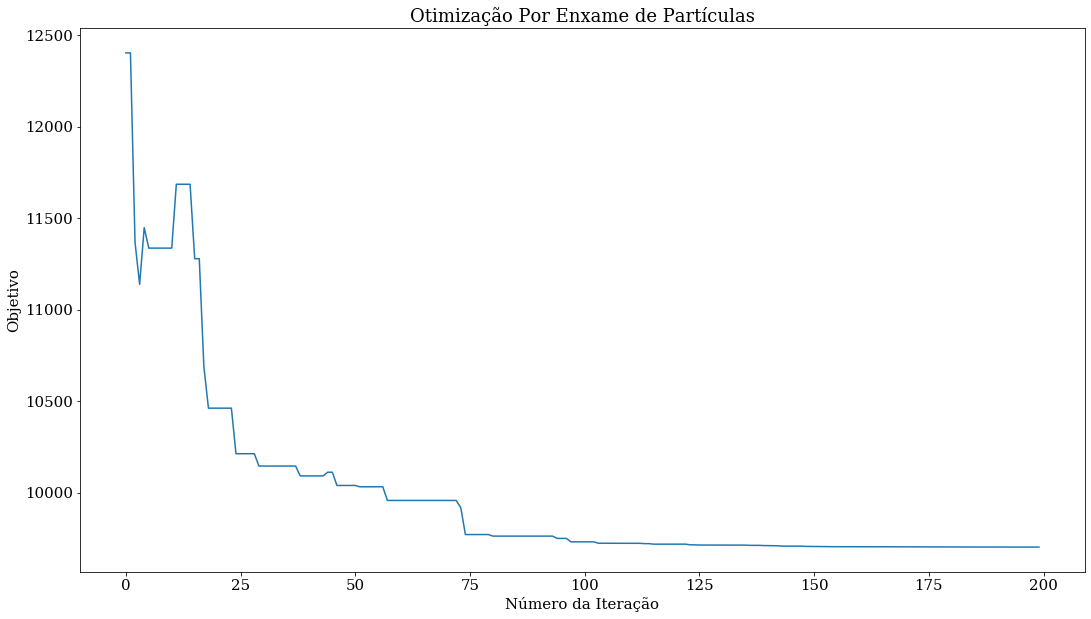

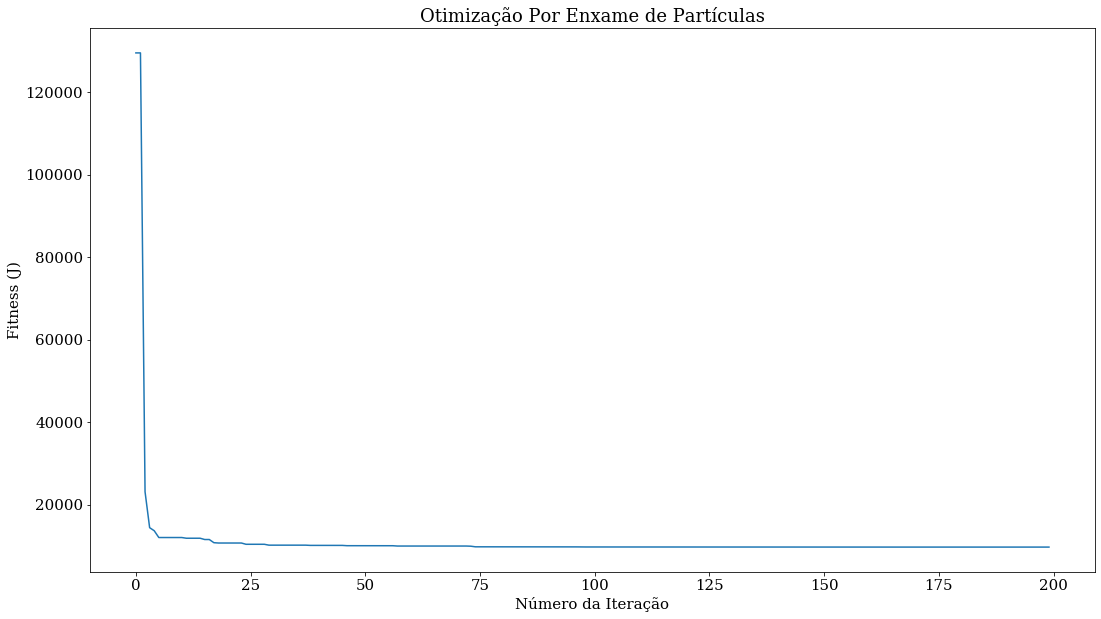

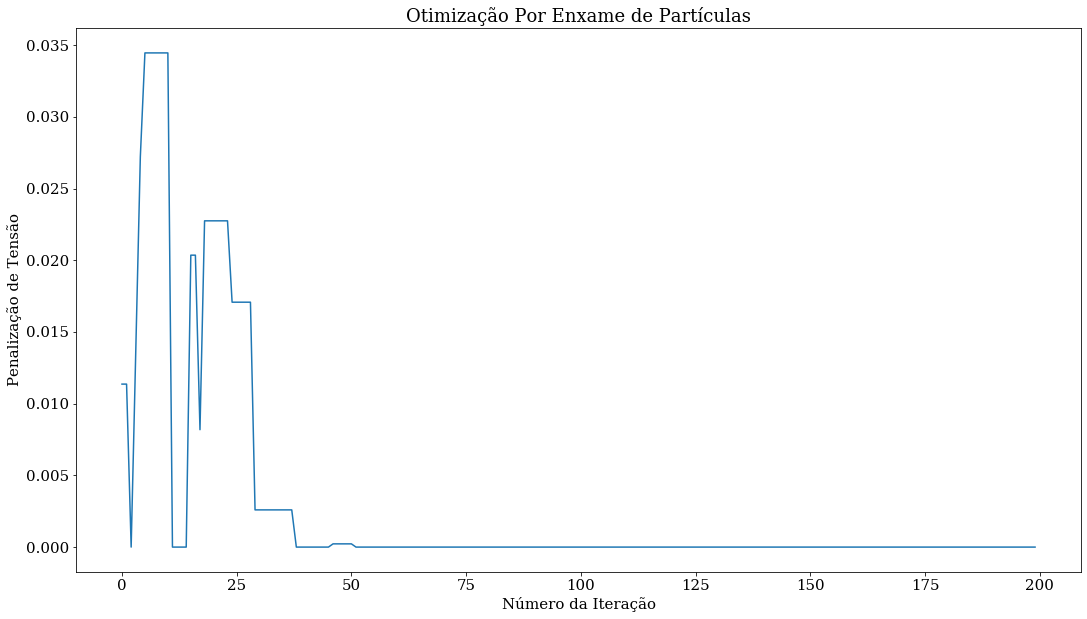

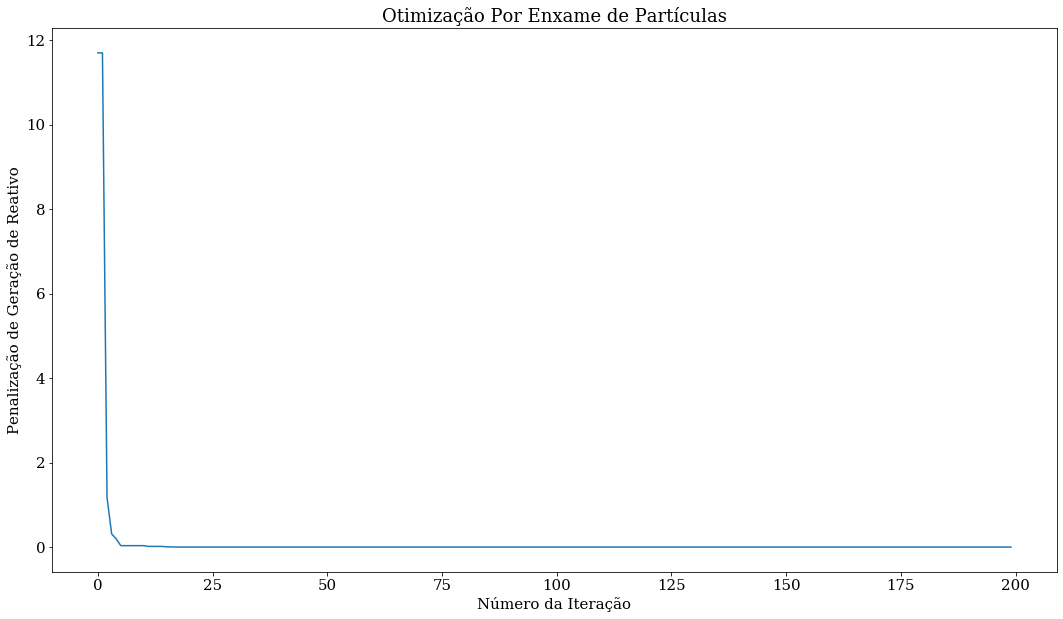

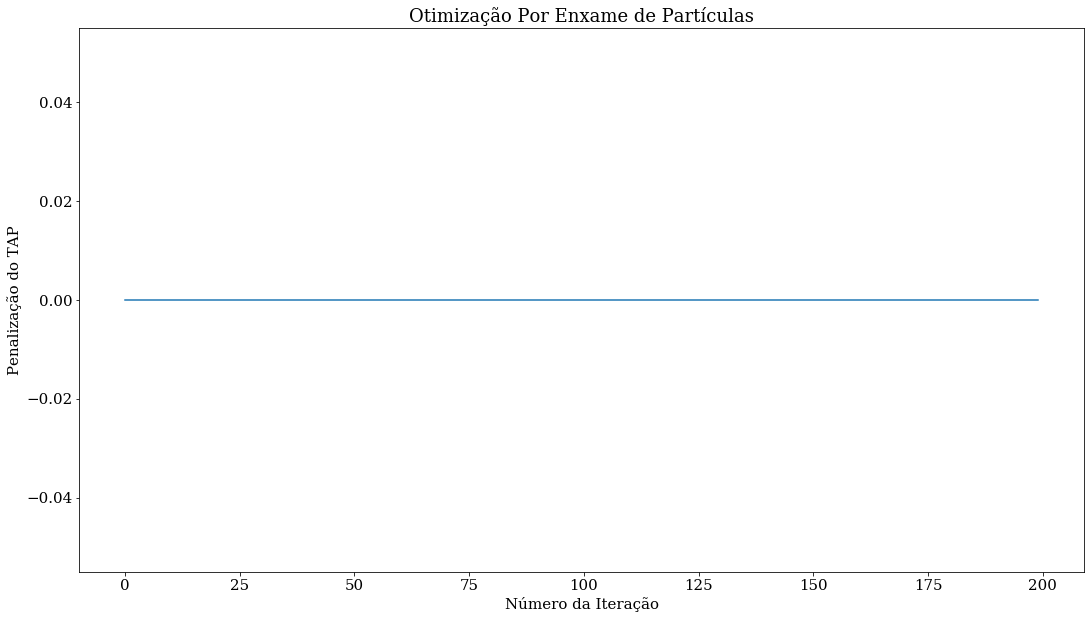

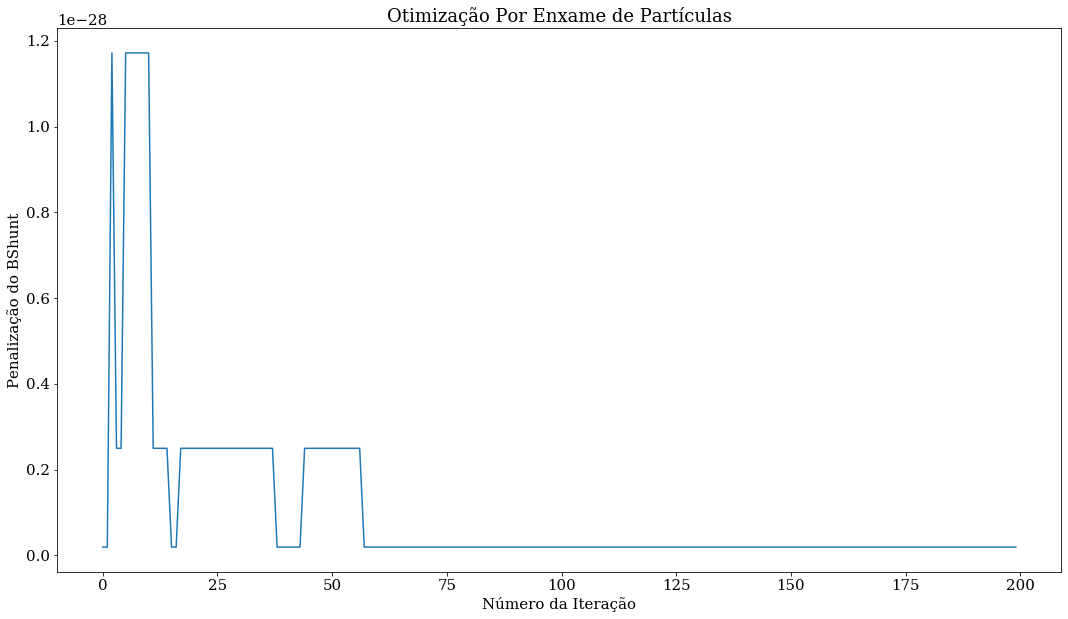

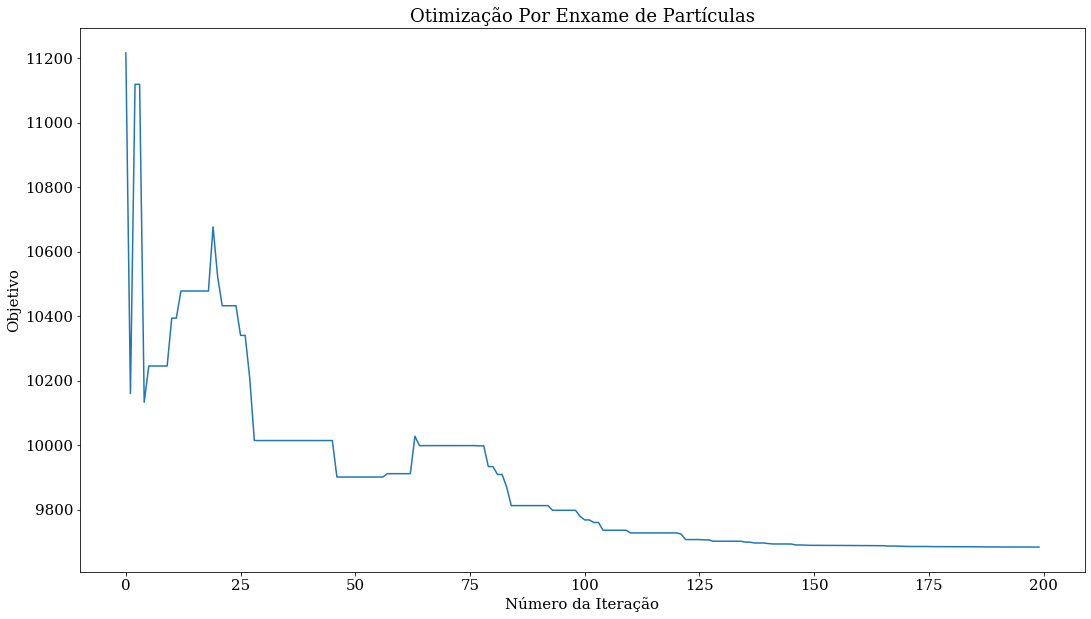

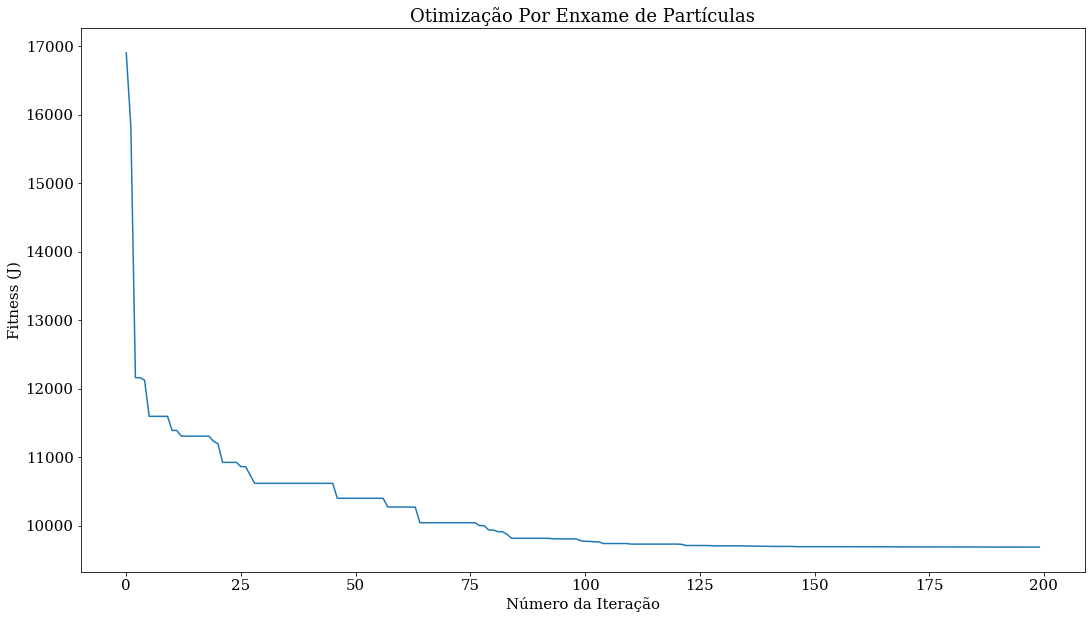

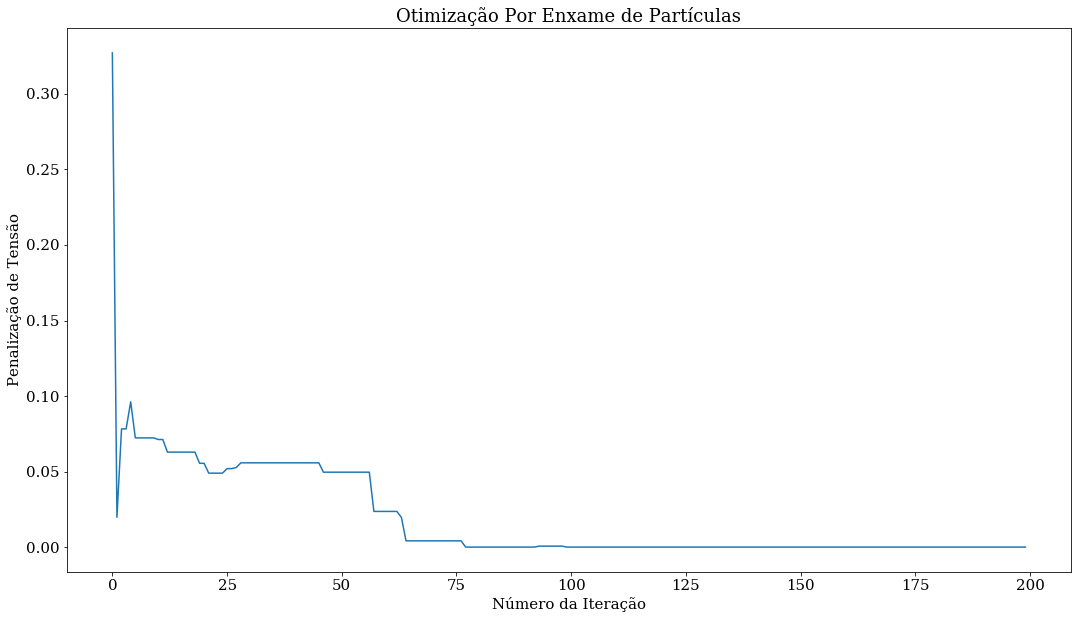

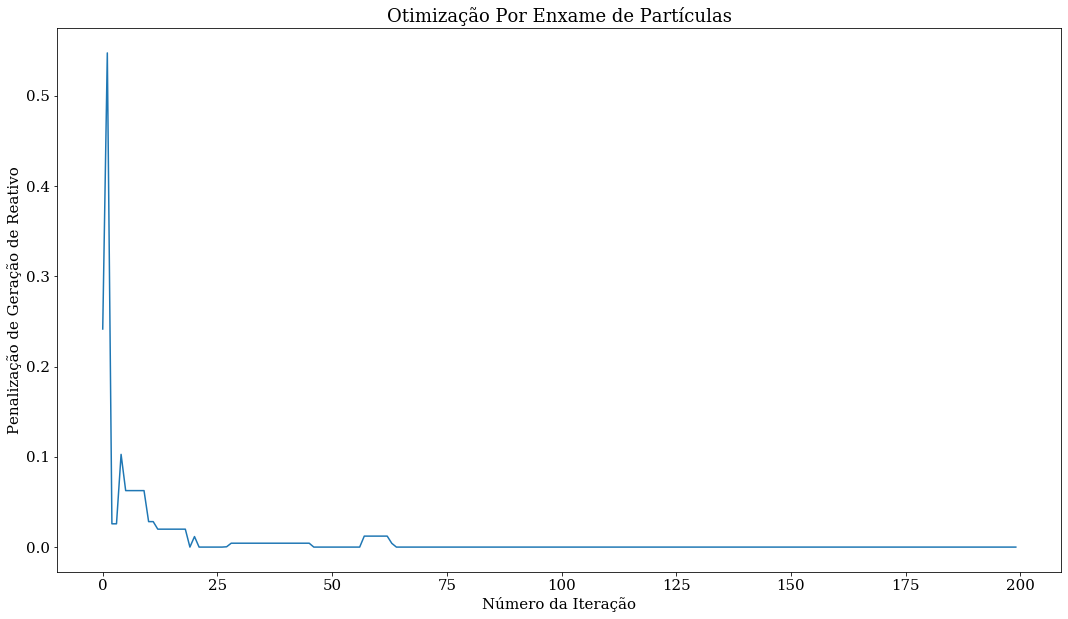

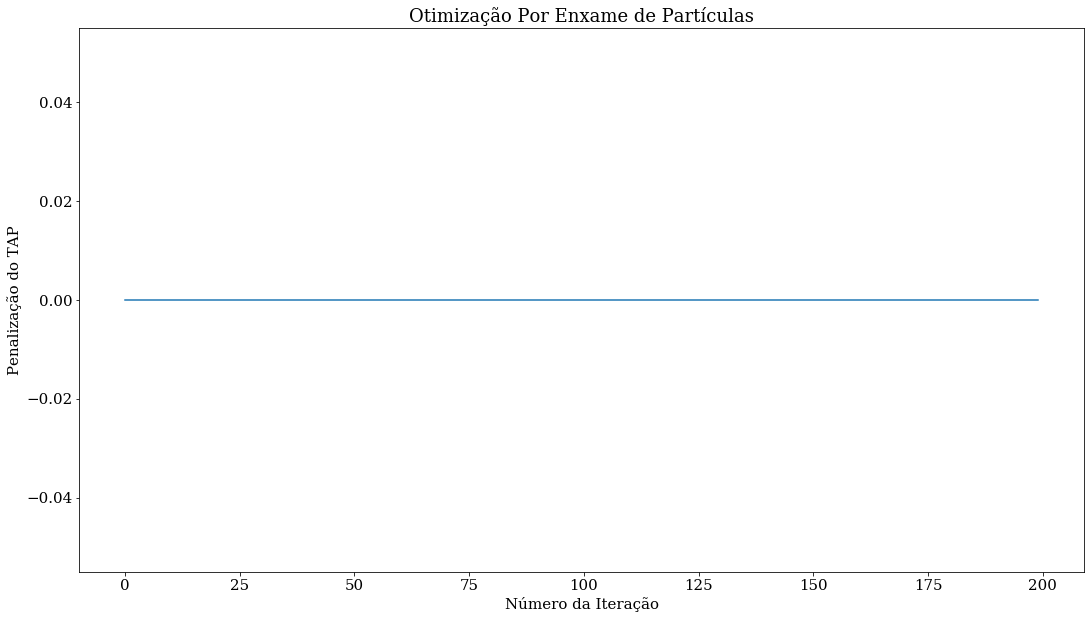

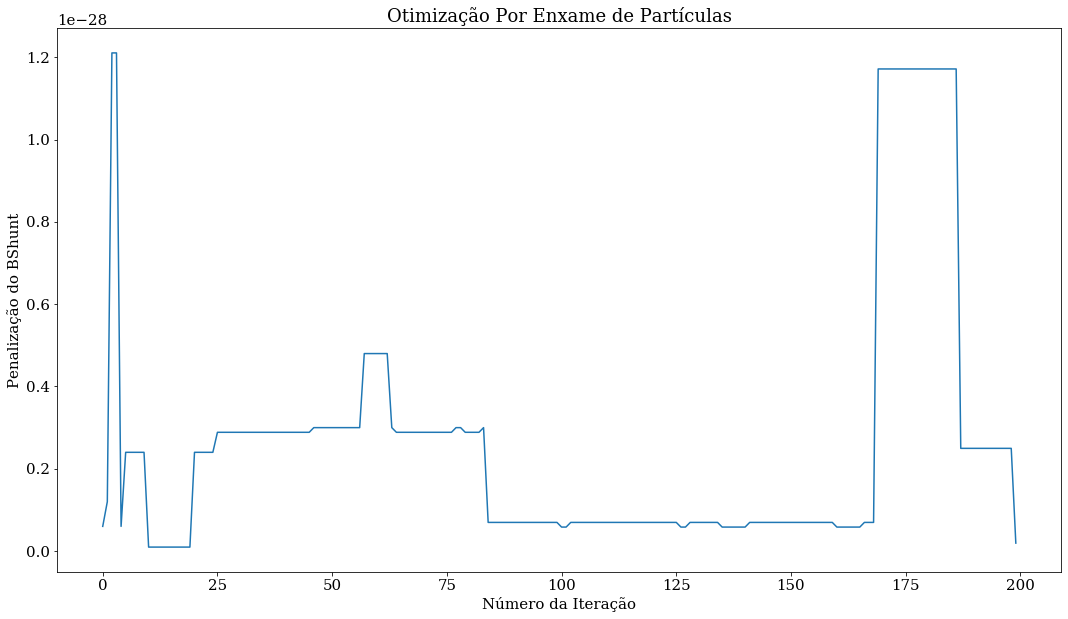

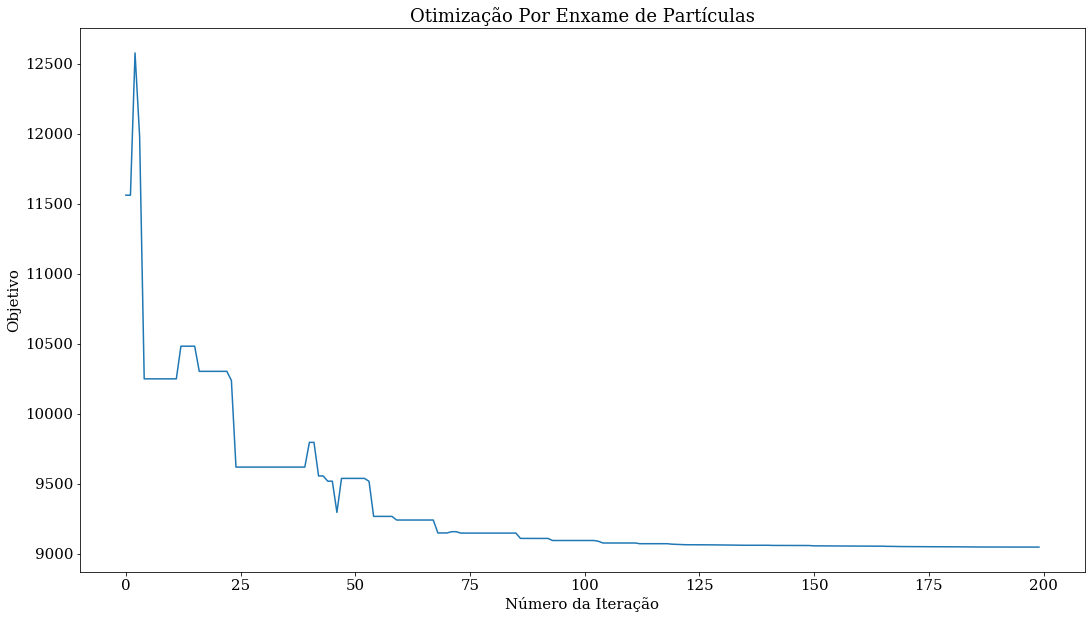

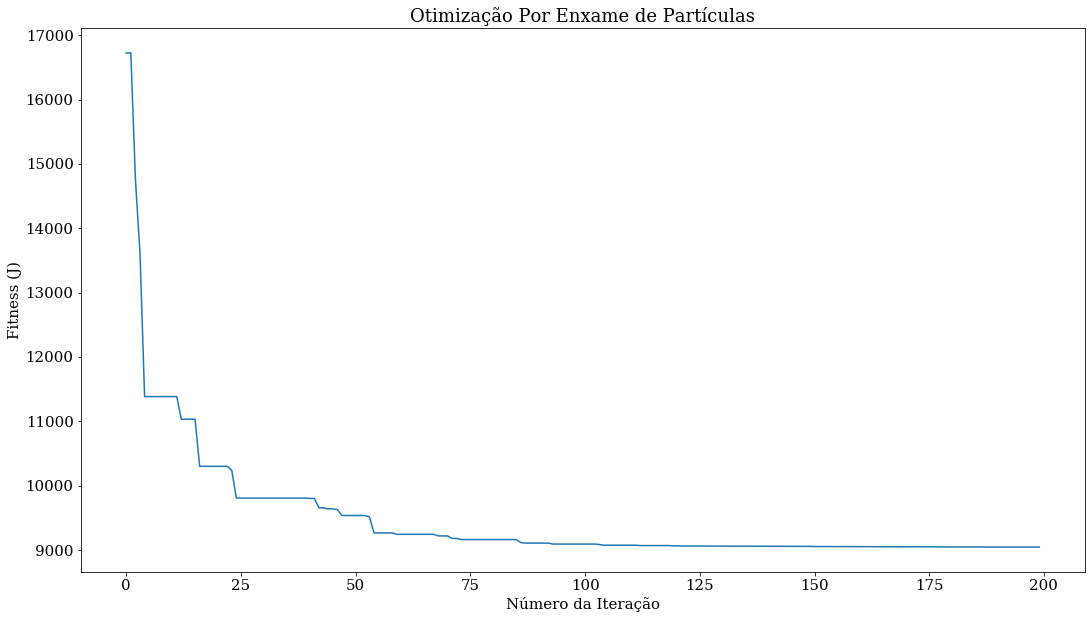

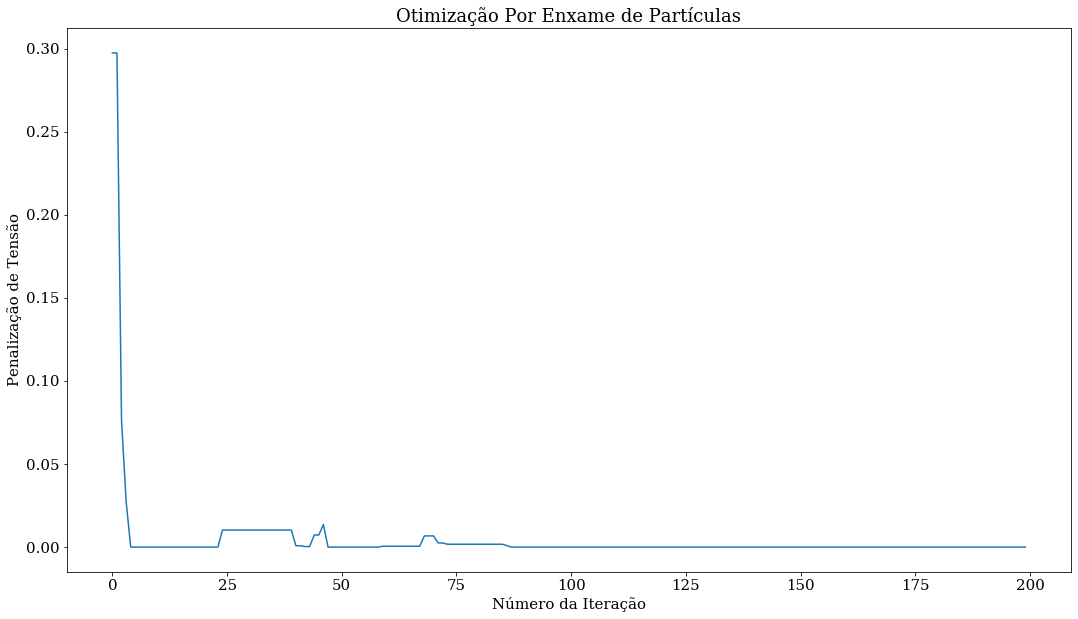

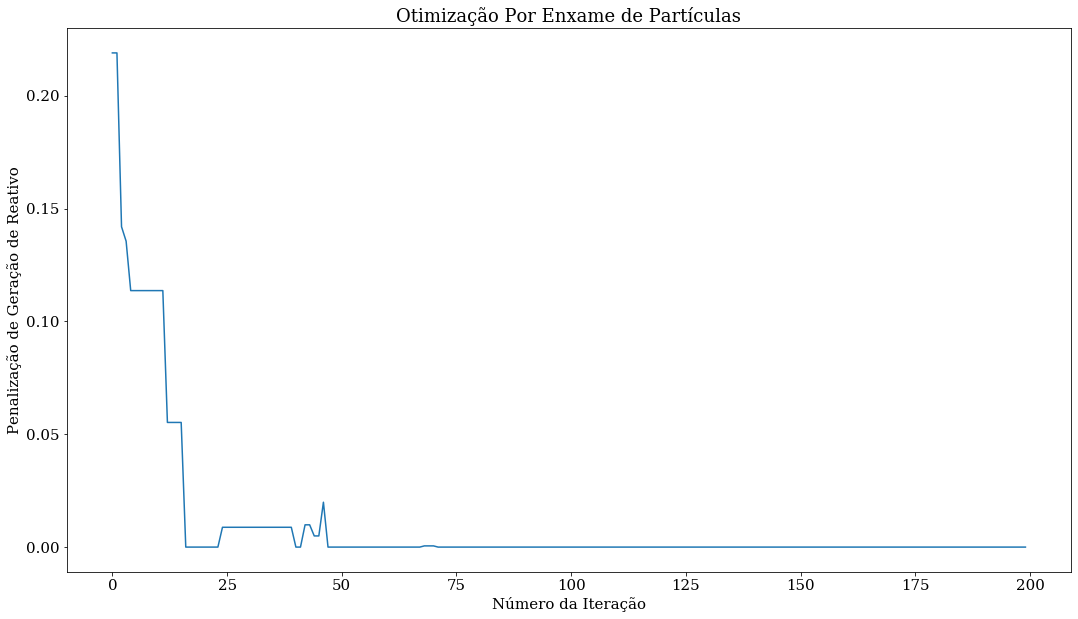

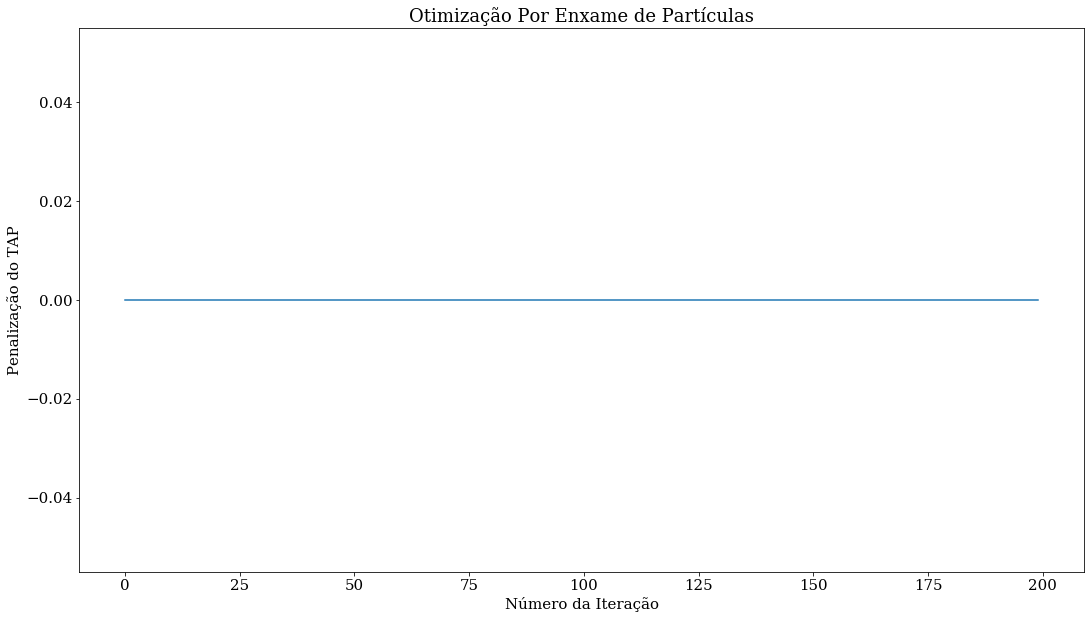

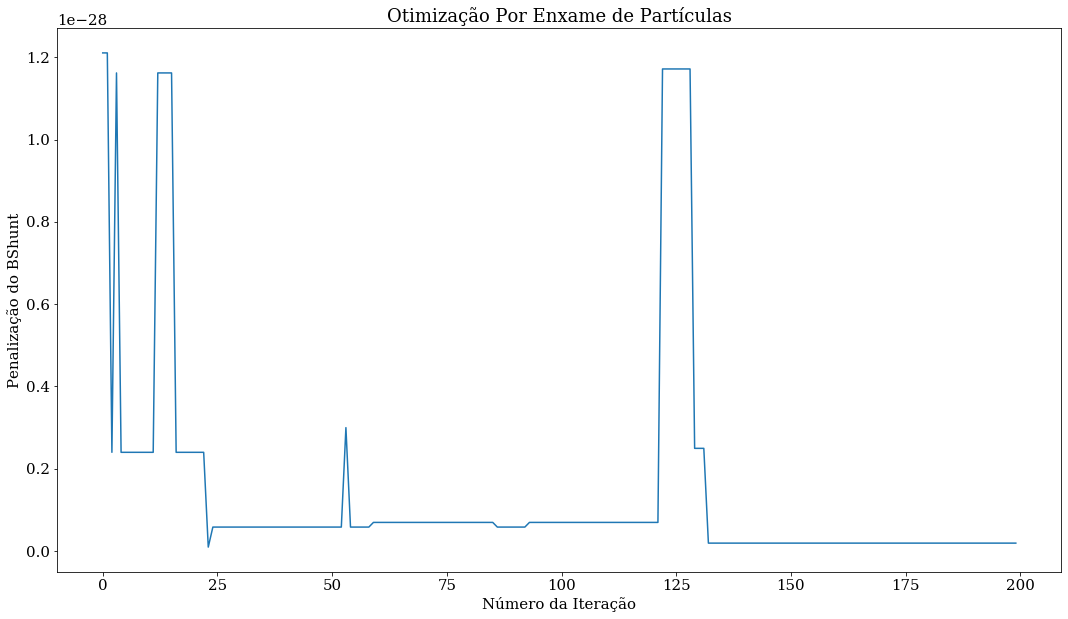

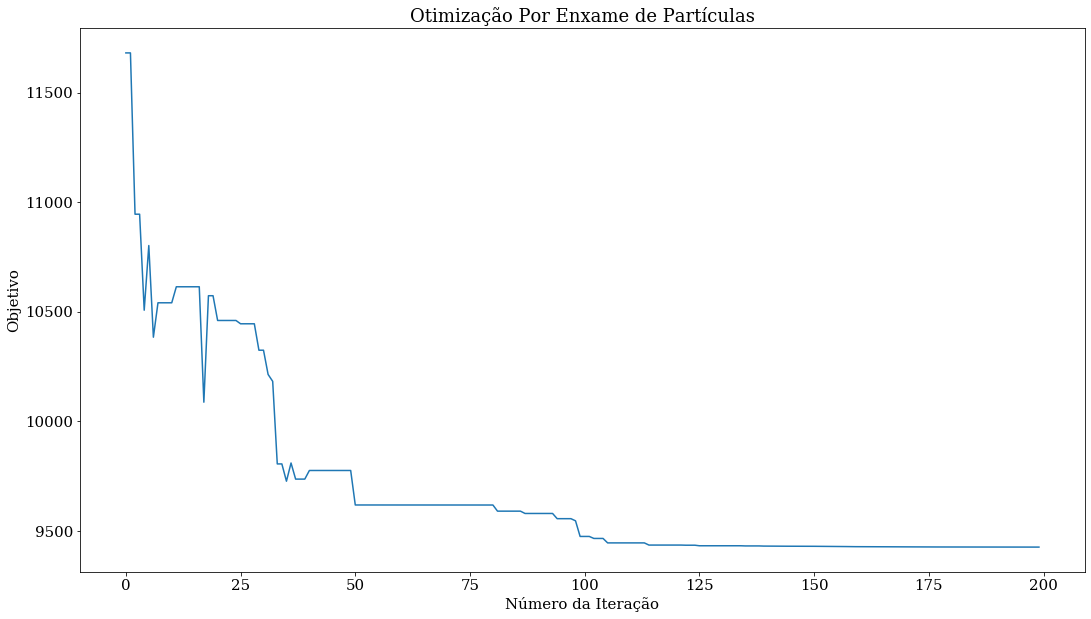

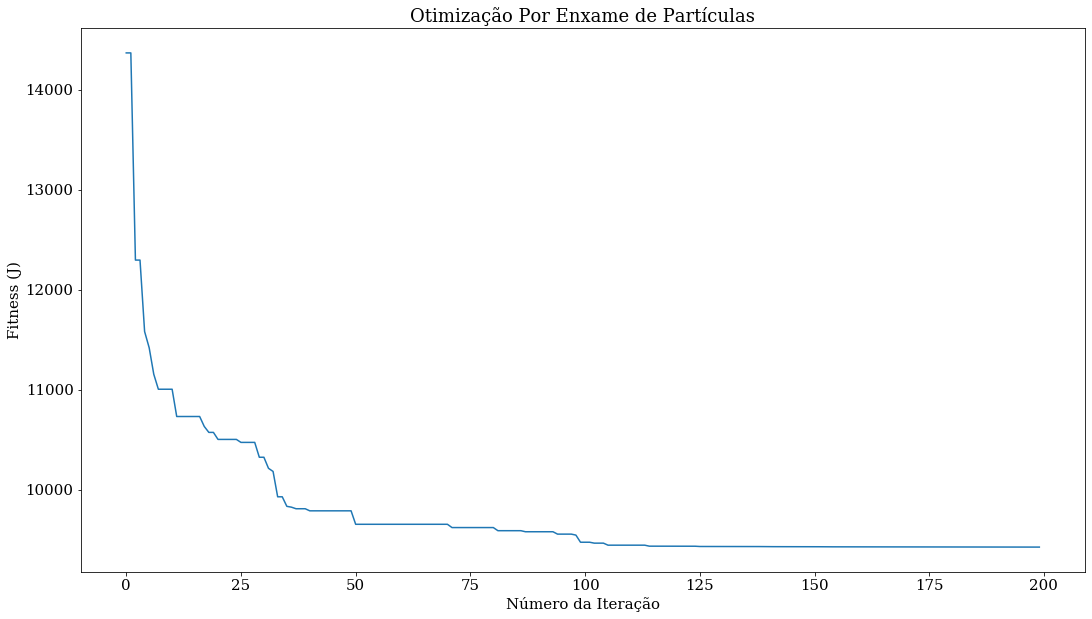

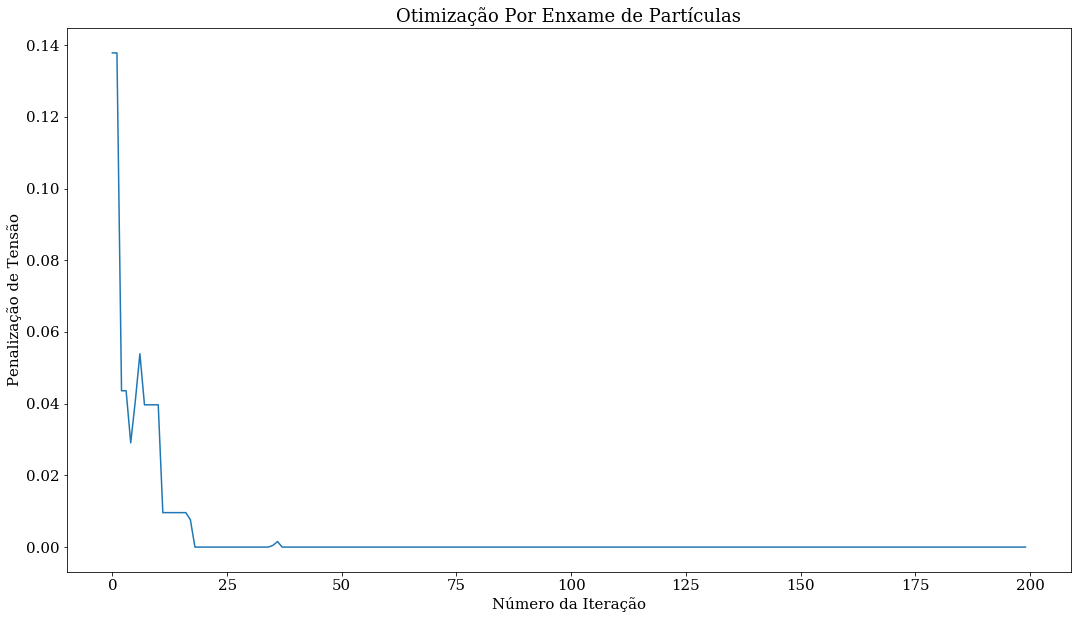

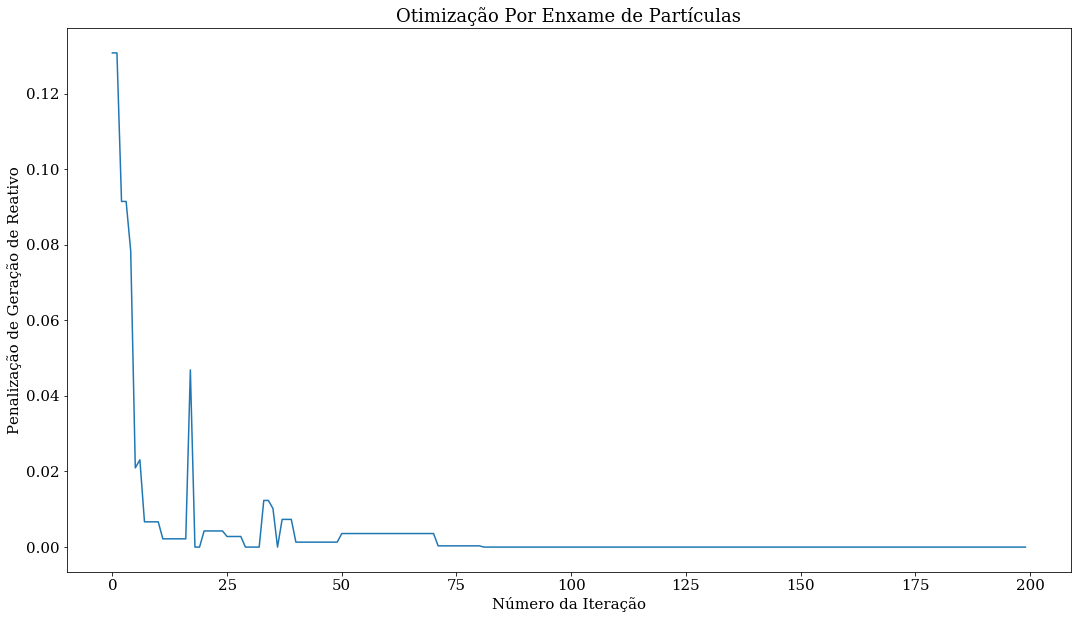

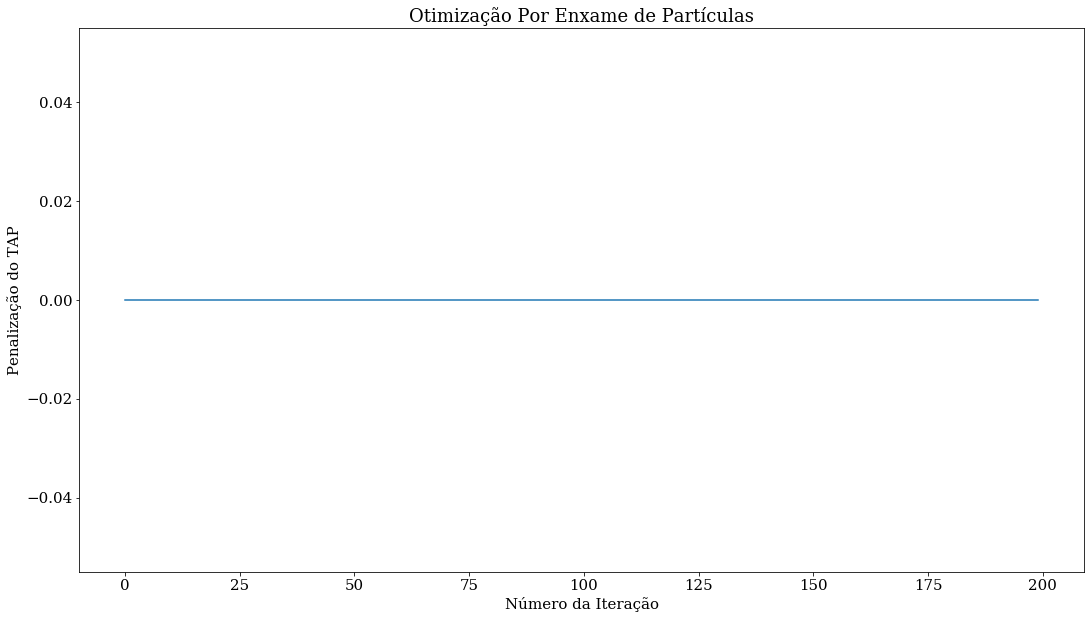

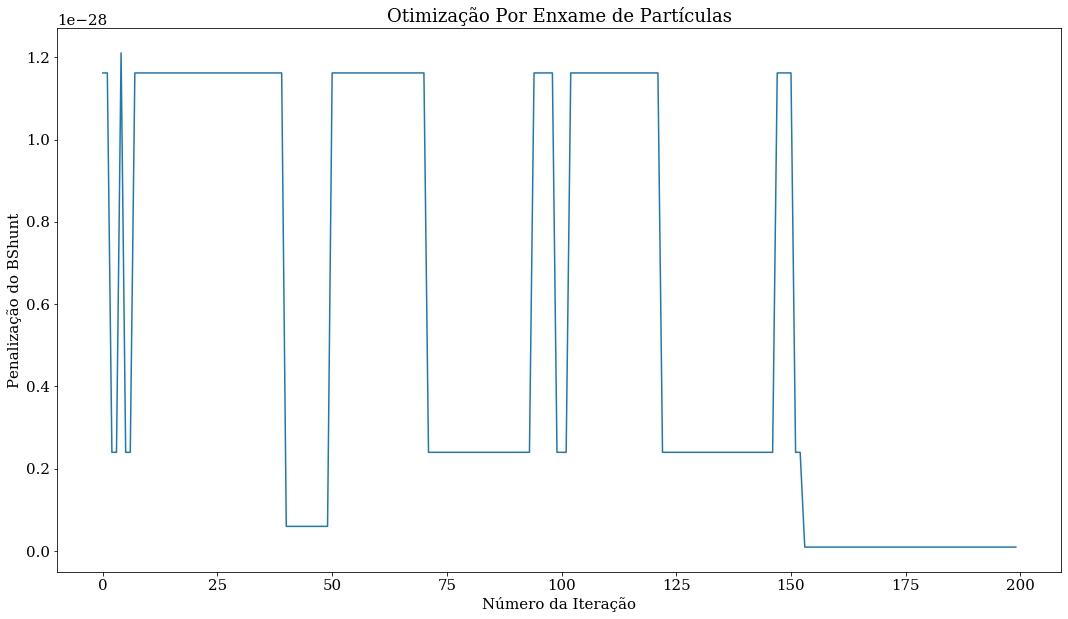

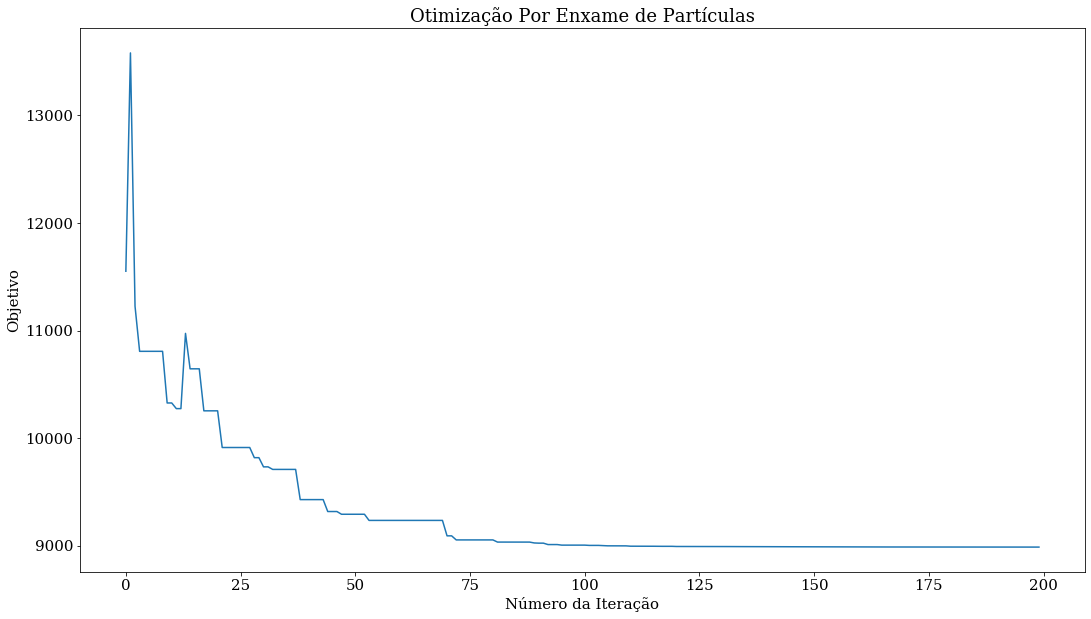

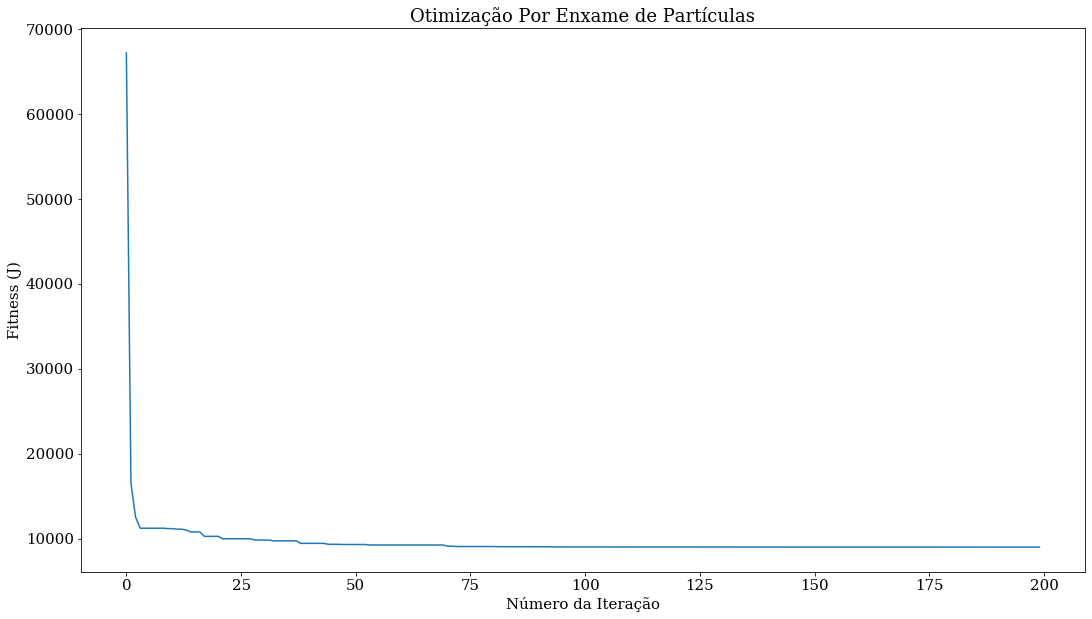

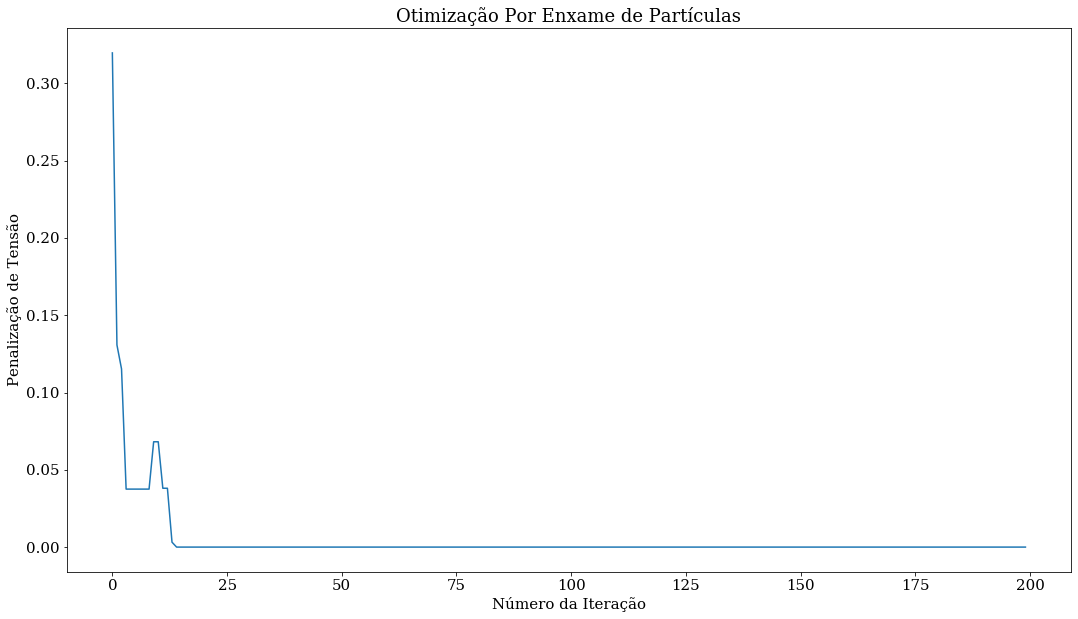

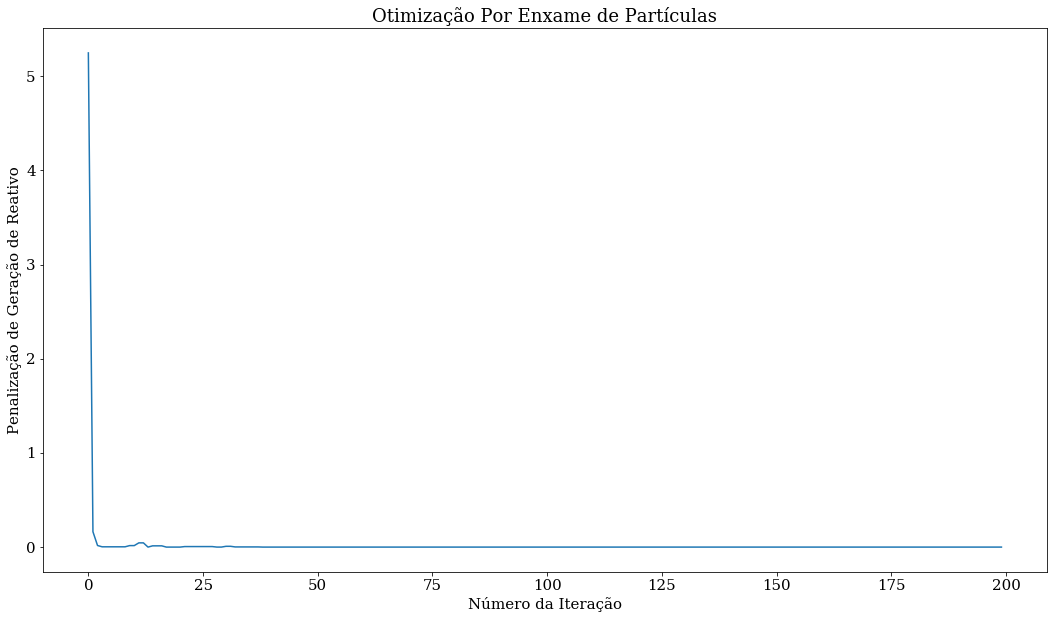

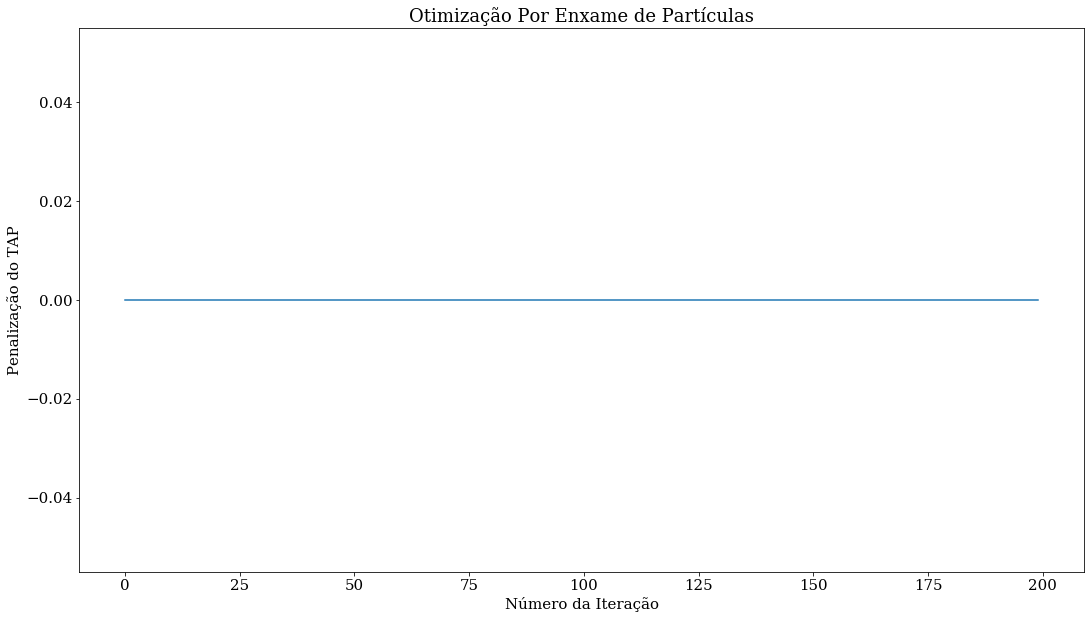

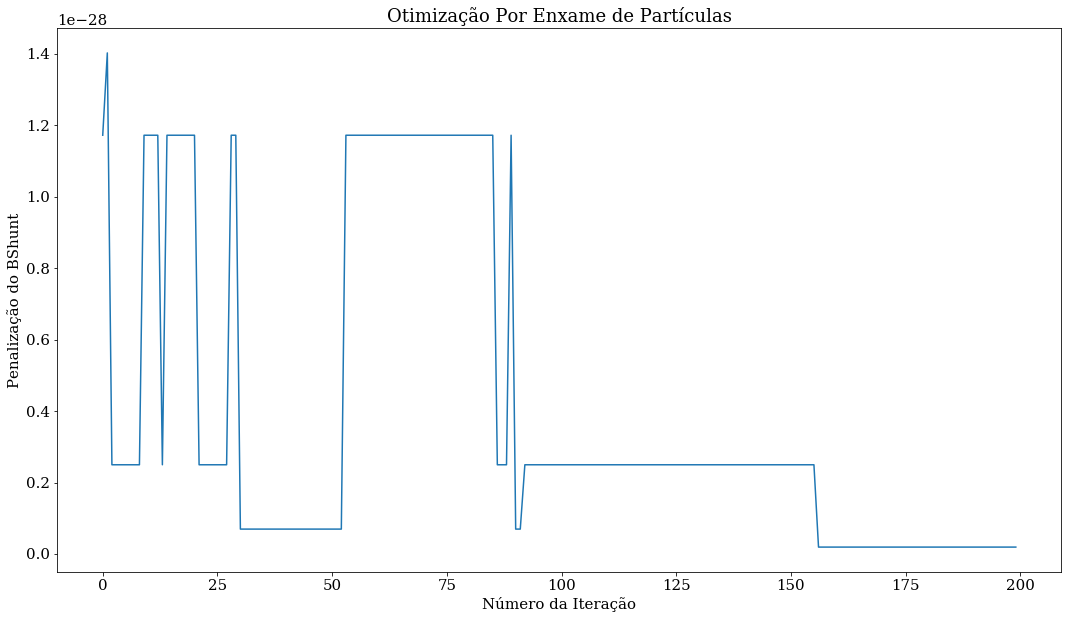

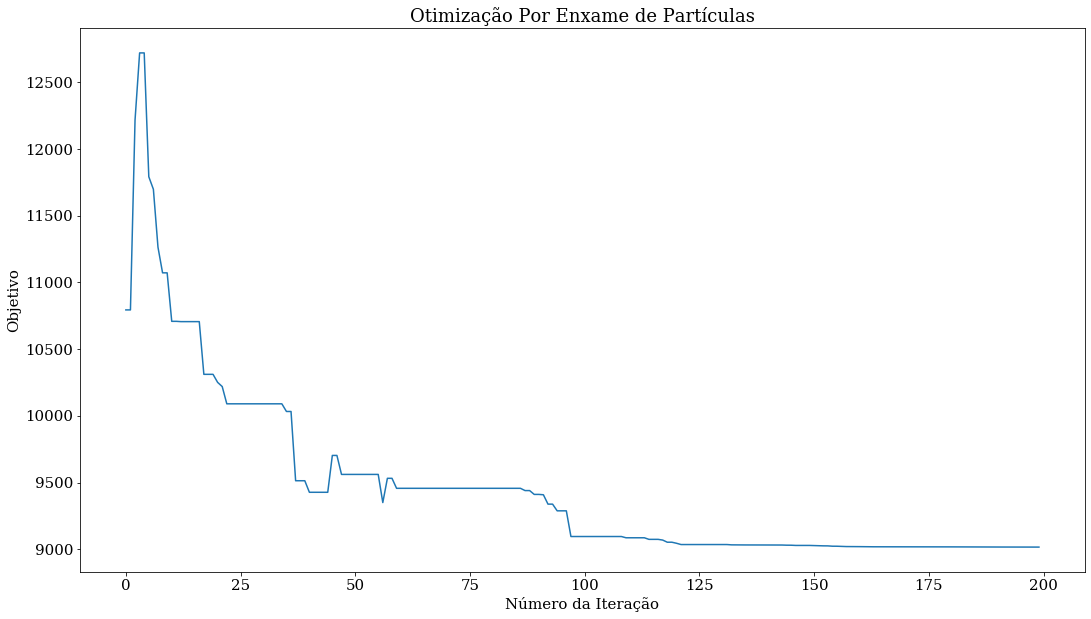

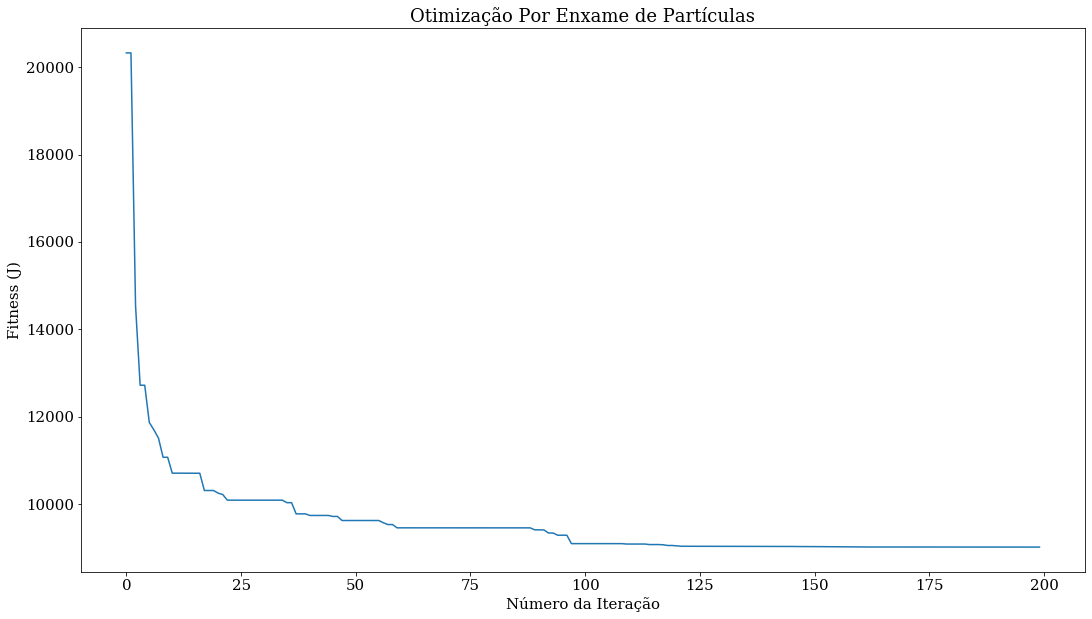

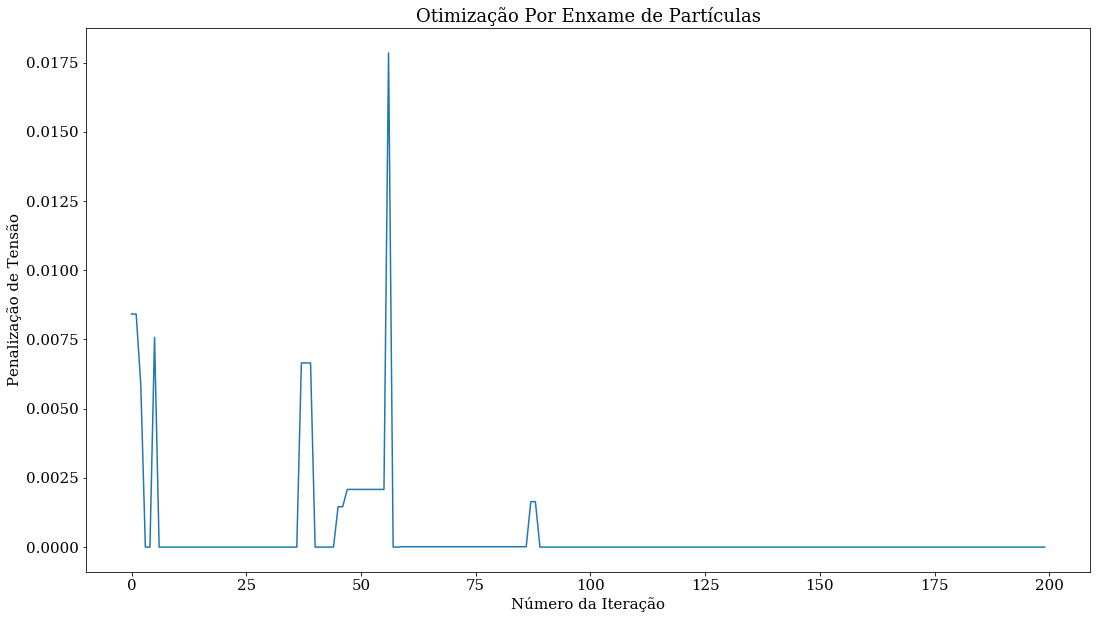

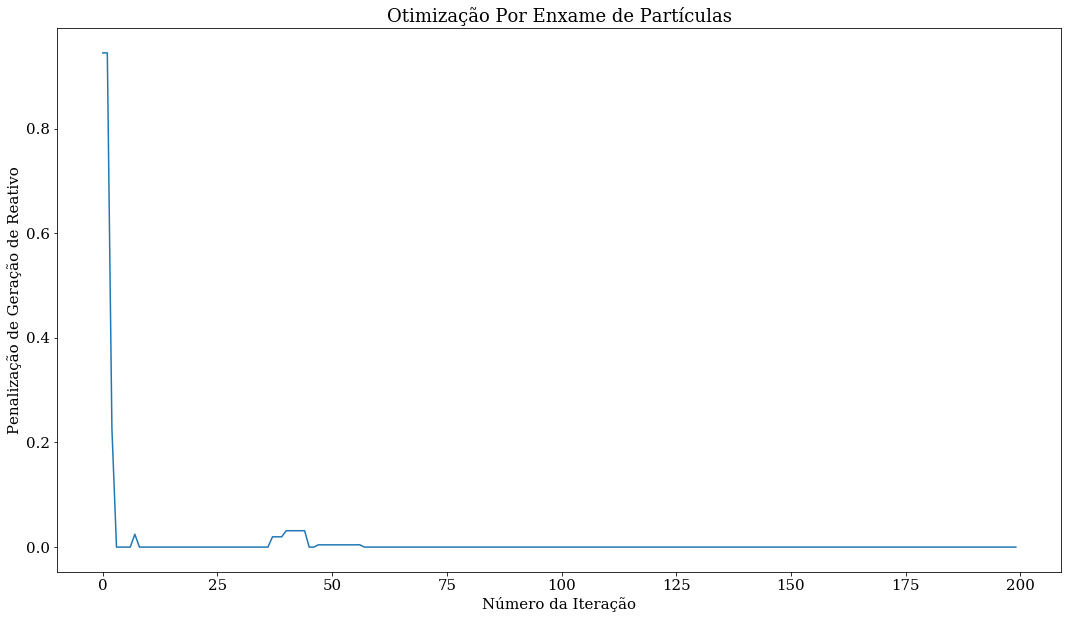

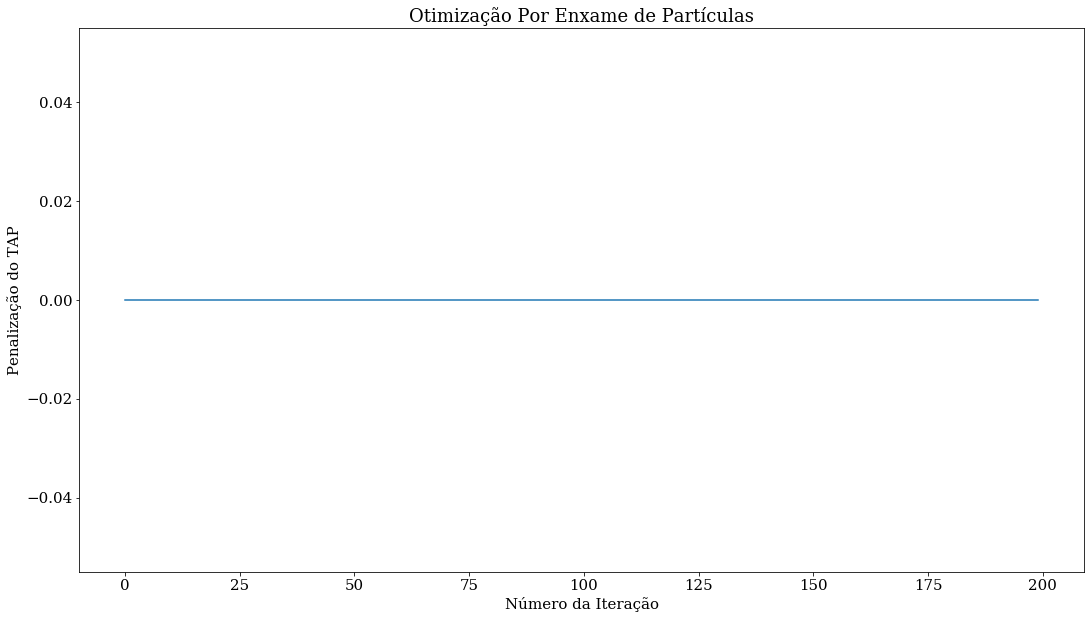

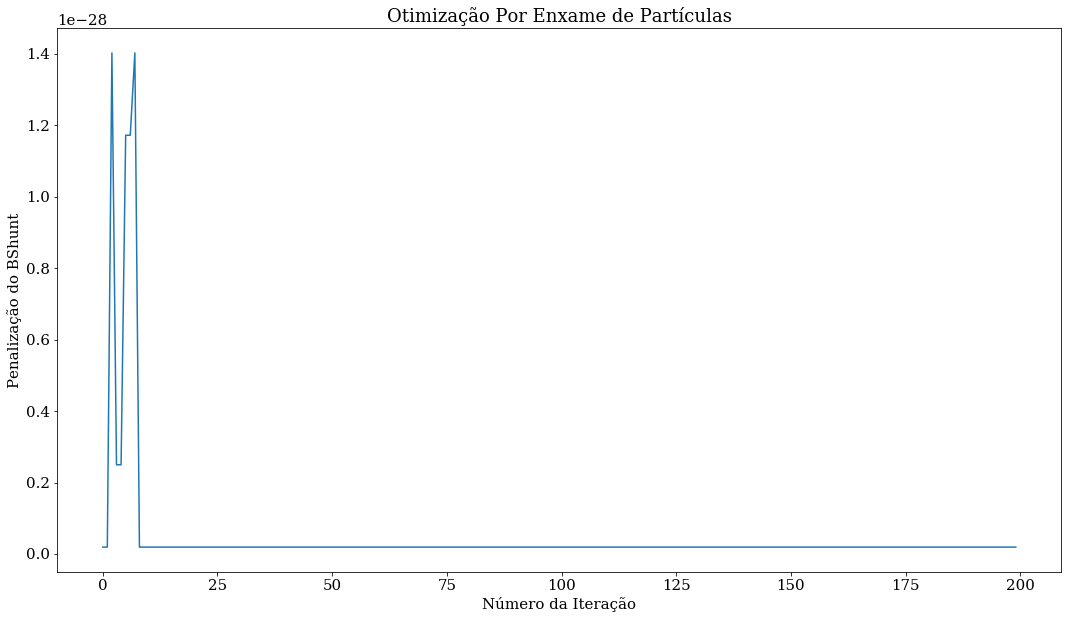

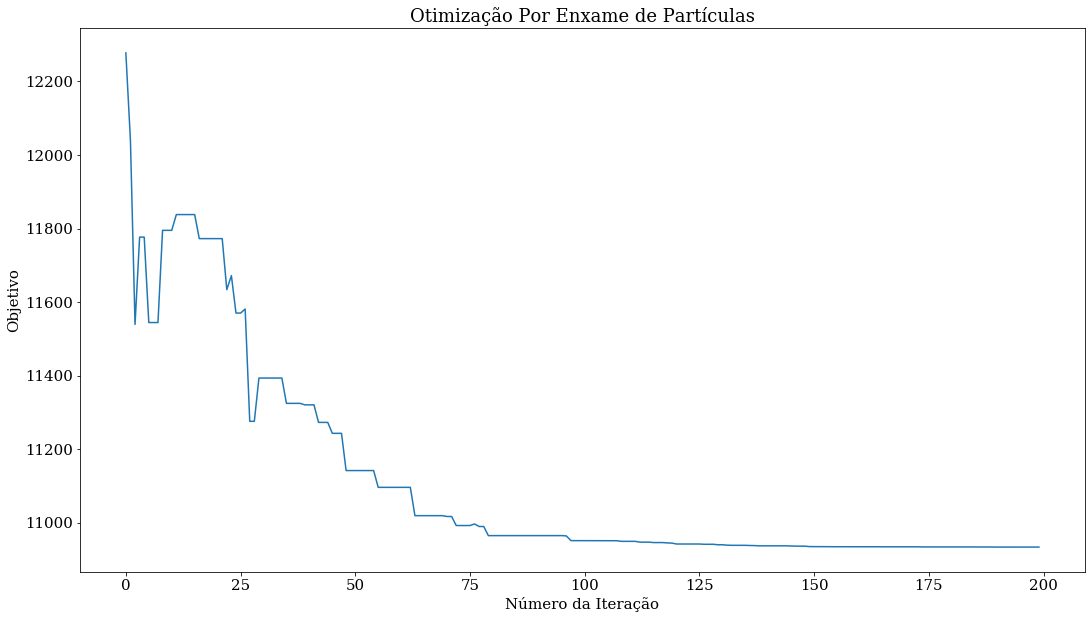

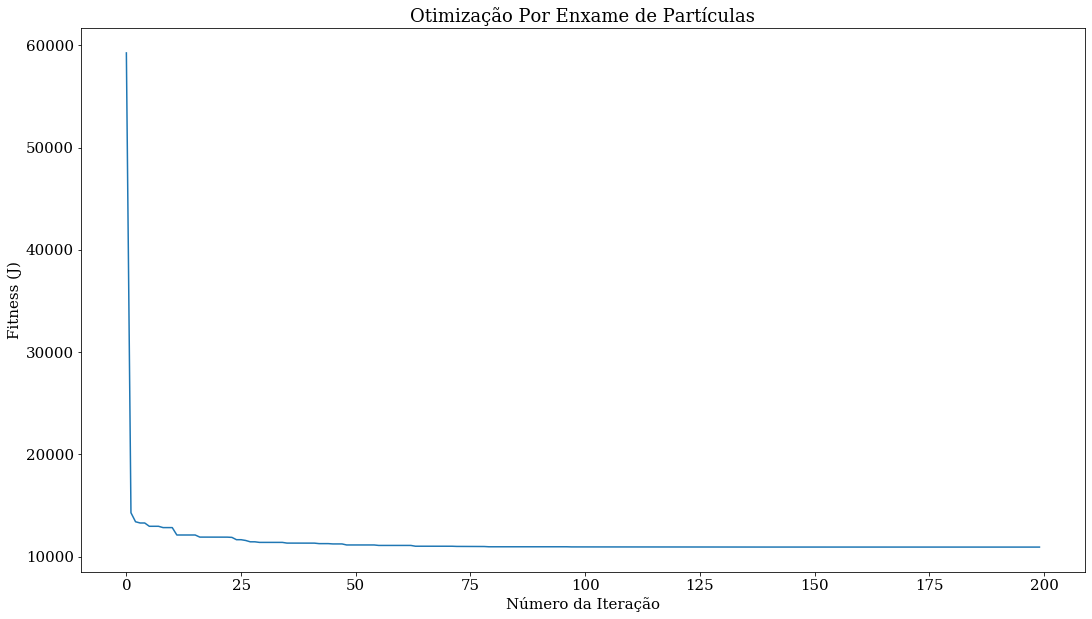

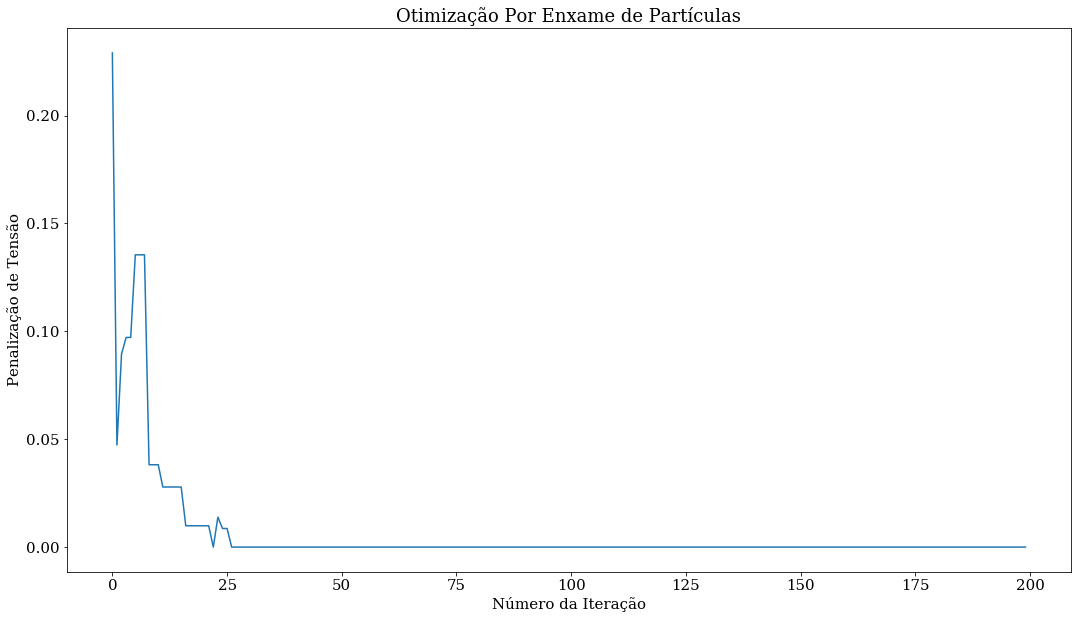

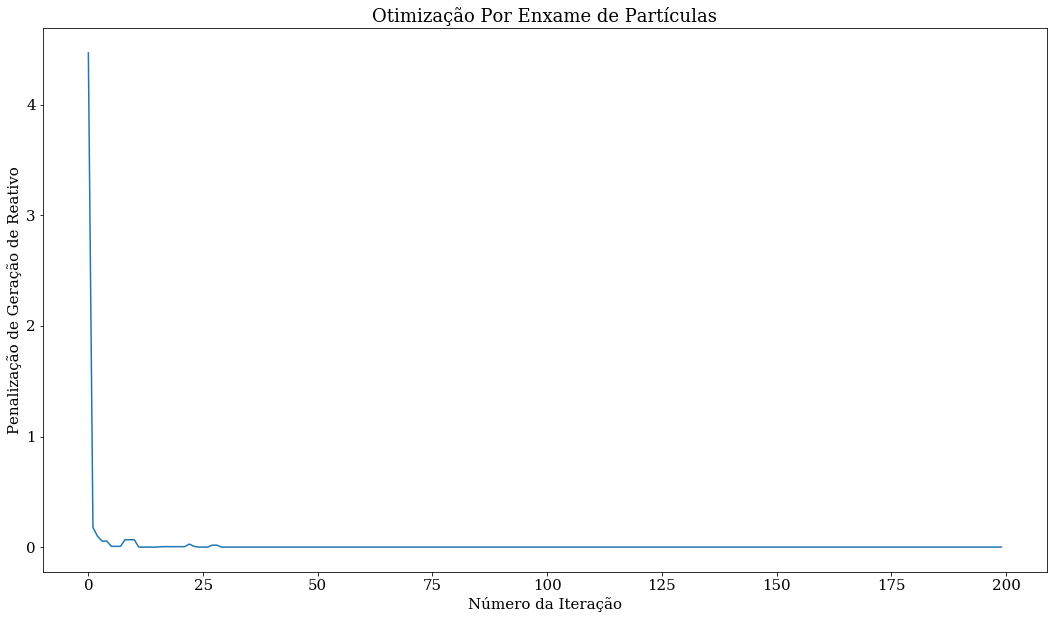

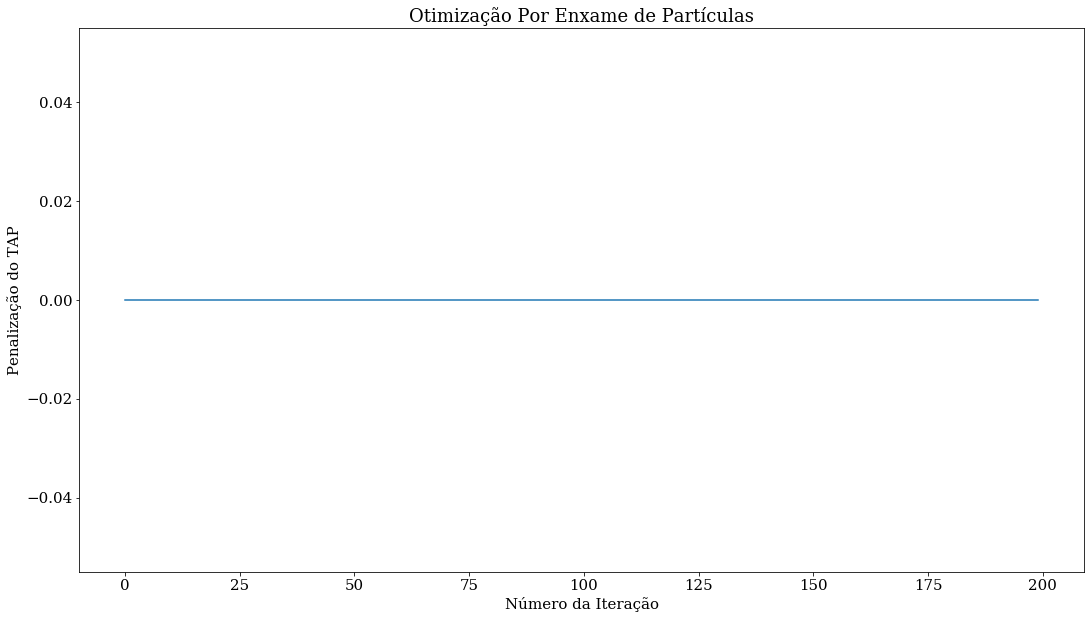

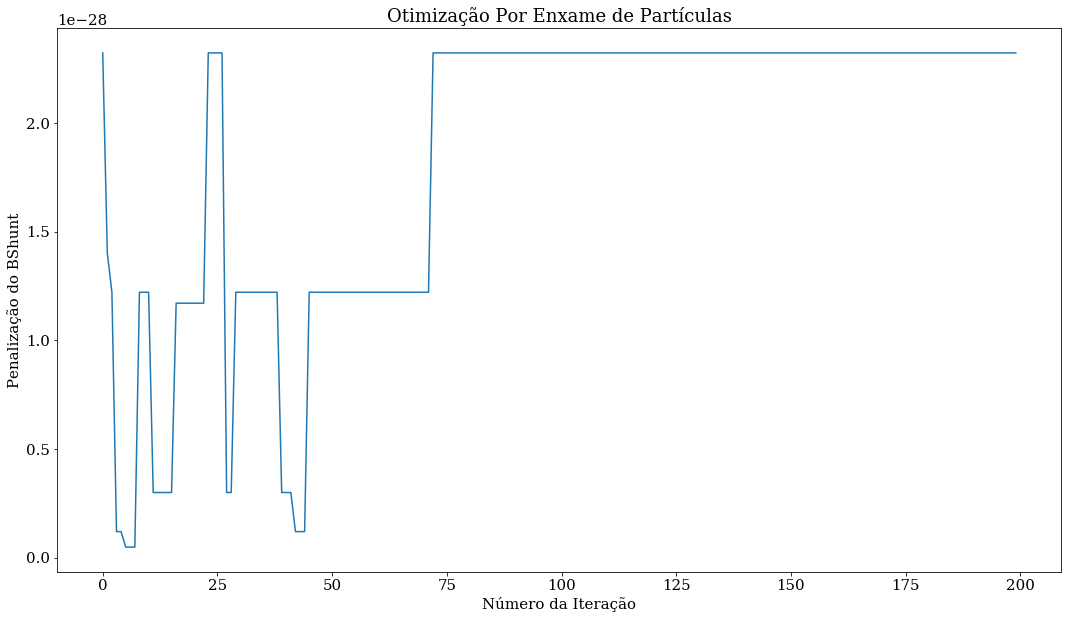

In [84]:

fitness_pso_30 = []

tempos_pso_30 = []

gbests_pso_30 = []

for i in range(25):
    
    print(i)
    j_2,obj_2,pen_v,pen_gq,pen_tap,pen_bsh, pen_slack, global_best_2, tempo_2, delta = otimizacao_pso_discreto_fpo(sep_30, refresh_gap = 0, p1_=0, p2_=0, zeta=1e4, psi=1e4, sigma=0, omega=0, neta=1e4, max_iter=200, n_particles=30,c1=2,c2=2,v_amp=0.25,valor_inicial=0,step=0.25, wmax=0.9,wmin=0.4,relatorio=True,inicial=False)
    
    fitness_pso_30.append(obj_2)
    gbests_pso_30.append(global_best_2)
    tempos_pso_30.append(tempo_2)


# 30 - 200, 30

In [79]:
gbest = global_best.copy()

gbest[n_vgen:n_tap+n_vgen] = discreto_tap(gbest,n_tap,n_vgen,n_bshunt,sep)
gbest[n_tap+n_vgen:n_tap+n_vgen+n_bshunt] = discreto_bshunt(gbest,n_tap,n_vgen,n_bshunt,sep)
new = validacao_fpo_q(sep,gbest) 

Função Objetivo:

131191.87782307182
 
Penalização de Violação de Tensão [PU]:

0.0
 
Penalização de Violação de Geração de Reativo [PU]:

1.1922929088470369e-08
 
Penalização de Violação de Geração de Ativo (Slack) [PU]:

0.0
 


In [81]:

validacao_fpo(sep_14,cria_enxame_fpo(sep_14,1)[0])

solucao_continua,sep,tensao,t,s,pgs,objcc = automatiza_ipm_c(sep_14, verbose=True, travado=False)

gbest=np.copy(solucao_continua)

gbest[len(tensao):len(t)+len(tensao)] = discreto_tap(gbest,len(t),len(tensao),len(s),sep)

gbest[len(t)+len(tensao):len(t)+len(tensao)+len(s)] = discreto_bshunt(gbest,len(t),len(tensao),len(s),sep)


validacao(sep,gbest)


Função Objetivo:

10157.223887389326
 
Penalização de Violação de Tensão [PU]:

0.026898846223062267
 
Penalização de Violação de Geração de Reativo [PU]:

0.003900226012912983
 
Penalização de Violação de Geração de Ativo (Slack) [PU]:

0.0
 
[0. 0. 0. 0. 0.]
ENTROU 14
apm 187.180.33.233_gk_model25 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            1
   Constants    :            0
   Variables    :           62
   Intermediates:            0
   Connections  :            6
   Equations    :           43
   Residuals    :           43
 
 Number of state variables:             62
 Number of total equations: -           43
 Number of slack variables: -            9
 ---------------------------------------
 Degrees of freedom       :             10
 


Perdas de Potência Ativa [PU]:

0.035599807798374274
 
Penalização de Violação de Tensão [PU]:

9.536743172944284e-08
 
Penalização de Violação de Geração de Reativo [PU]:

0.0
 
Penalização de Violação de TAP Discreto [PU]:

4.11349238629659e-27
 
Penalização de Violação de Bshunt Discreto [PU]:

1.3378069303703434e-26
 


In [82]:
solucao_continua,sep_atualizado,tensao,t,s, pgs,obj = automatiza_ipm_c(sep, verbose=True, travado=True)

[0. 0. 0. 0. 0.]
ENTROU 14
apm 187.180.33.233_gk_model26 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            1
   Constants    :            0
   Variables    :           62
   Intermediates:            0
   Connections  :            6
   Equations    :           43
   Residuals    :           43
 
 Number of state variables:             62
 Number of total equations: -           43
 Number of slack variables: -            9
 ---------------------------------------
 Degrees of freedom       :             10
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian
         but the previous value is set to disallow clobbering.
    

In [40]:
def otimizacao_ed_discreto_fpo(sep, F, CR, zeta, psi, sigma, omega, neta, max_iter, n_particles, relatorio=True,inicial=True):
        
    populacao = cria_enxame_fpo(sep,n_particles)
        
    if len(sep.bus) == 14:
        
        n_vgen = 4+1
        n_tap = 3
        n_gens = 4
        n_bshunt = 1
    
    if len(sep.bus) == 30:
        
        n_vgen = 5+1
        n_tap = 4
        n_bshunt = 2
        n_gens = 5
        
    
    if len(sep.bus) == 118:
        
        n_vgen = 53+1
        n_tap = 9
        n_bshunt = 14
        n_gens=53
        
        
    if len(sep.bus) == 300:
        
        n_vgen = 68+1
        n_tap = 62
        n_bshunt = 29
        n_gens=68
    
  
    
    j = []
    
    
    tempo = []
        
    obj = []
    
    pen_v = []
    
    pen_gq = []
    
    pen_tap = []
    
    pen_bsh = []
    
    pen_slack = []

    
    v_lim_superior = np.repeat(sep.bus['max_vm_pu'][0], n_vgen)
    
    v_lim_inferior = np.repeat(sep.bus['min_vm_pu'][0], n_vgen)
    
    tap_pos, tap_neutral, tap_step_percent,valores_taps = coleta_dados_trafo(sep,relatorio=False)
    
    tap_max = np.repeat(valores_taps[-1], len(tap_pos))
    
    tap_min = np.repeat(valores_taps[0], len(tap_pos))
    
    max_pot = sep.gen['max_p_mw'].values/100
    
    min_pot = sep.gen['min_p_mw'].values/100
    
    bsh,b=coleta_dados_bshunt(sep)

    bsh_max=[]
    
    bsh_min=[]
    
    l_v =[]
    l_q=[]
    l_p=[]
    l_o =[]
    
    refresh_rate = np.zeros((n_particles))
    

    for bs in bsh:
        bsh_max.append([np.max(bs)])
        bsh_min.append([np.min(bs)])


    maximo = np.expand_dims(np.concatenate((v_lim_superior, tap_max, bsh_max, max_pot), axis = None), 0)
    minimo = np.expand_dims(np.concatenate((v_lim_inferior, tap_min, bsh_min, min_pot), axis = None), 0)
     
    
    lim_sup = np.tile(maximo, (n_particles,1))
    lim_inf = np.tile(minimo, (n_particles,1))
    
    
    delta= np.abs(lim_sup-lim_inf)[0,:]
    xk = []

            
    for i in range(0,max_iter):
        
            
        start = time.time()

        populacao_d = np.copy(populacao)
        
        
        if i == 0:

            for linha in range(n_particles):

                populacao_d[linha][n_vgen:n_vgen+n_tap] = discreto_tap(populacao[linha].copy(),n_tap,n_vgen,n_bshunt,sep)
                populacao_d[linha][n_vgen+n_tap:n_vgen+n_tap+n_bshunt] = discreto_bshunt(populacao[linha].copy(),n_tap,n_vgen,n_bshunt,sep)

            populacao[:,-7:] = (fluxo_de_pot_fpo(populacao_d,sep))[:,-7:]

            populacao[:,-7:] = (fitness_fpo(populacao,zeta,psi,sigma,omega,neta))[:,-7:]
       
        
        populacao2 = np.copy(populacao)
        
        for linha in range(n_particles):
            
            p1 = int(np.random.rand()*n_particles)
            
            p2 = int(np.random.rand()*n_particles)
            
            p3 = int(np.random.rand()*n_particles)
            
            
            while (p1==p2 or p1==p3 or p2==p3):
                
                
                p1 = int(np.random.rand()*n_particles)
            
                p2 = int(np.random.rand()*n_particles)

                p3 = int(np.random.rand()*n_particles)
                
            # parte da mutação
            
            populacao2[linha,:-7] = populacao2[p1,:-7] + F*(populacao2[p3,:-7]-populacao2[p2,:-7])
            
            pop_estat = populacao2[:,-7:]

        populacao2 = np.concatenate(( np.clip(populacao2[:,0:-7], a_min = lim_inf, a_max = lim_sup, out = populacao2[:,0:-7]),pop_estat),axis=1)   

        # crossover
        
        populacao3 = np.copy(populacao)
        
        for linha in range(n_particles):
                
            for dim in range(len(populacao[0,:-7])):
            
                c_ = np.random.rand()
                
                if c_ <= CR:
                    
                    populacao3[linha,dim] = populacao2[linha,dim].copy()
                
                else:
                
                    populacao3[linha,dim] = populacao[linha,dim].copy()
                    
                    
        # Reavaliação
        
        populacao_d3 = np.copy(populacao3)
    
        for linha in range(n_particles):
          
            populacao_d3[linha][n_vgen:n_vgen+n_tap] = discreto_tap(populacao3[linha].copy(),n_tap,n_vgen,n_bshunt,sep)
            populacao_d3[linha][n_vgen+n_tap:n_vgen+n_tap+n_bshunt] = discreto_bshunt(populacao3[linha].copy(),n_tap,n_vgen,n_bshunt,sep)
     
        populacao3[:,-7:] = (fluxo_de_pot_fpo(populacao_d3,sep))[:,-7:]
     
        populacao3[:,-7:] = (fitness_fpo(populacao3,zeta,psi,sigma,omega,neta))[:,-7:]
        
        
        populacao4 = np.copy(populacao)
        
        for linha in range(n_particles):
                
            if populacao3[linha,-1] < populacao[linha,-1]:
                
                populacao4[linha,:] = np.copy(populacao3[linha,:])
                
            else:
                
                populacao4[linha,:] = np.copy(populacao[linha,:])
                
        
        populacao = np.copy(populacao4)
        
        if i == 0:
            
            global_best = populacao[np.argsort(populacao[:, -1])][0,:].copy()
        
        else:
            
            best_i = populacao[np.argsort(populacao[:, -1])][0,:].copy()
            
        
            if best_i[-1] < global_best[-1]:
                
                global_best = np.copy(best_i)
                
        
            
            
        
        end = time.time()

        elapsed = end - start

        j.append(global_best[-1])

        obj.append(global_best[-7])

        pen_v.append(global_best[-6])

        pen_gq.append(global_best[-5])

        pen_tap.append(global_best[-4])

        pen_bsh.append(global_best[-3])
        
        pen_slack.append(global_best[-2])
        
        tempo.append(elapsed)
      

        if relatorio == True:
            
            print(' ')

            print('Melhor Global da Iteração:',i)

            print('Objetivo:', global_best[-7])

            print('Penalização de Tensão:', global_best[-6])

            print('Penalização de Geração de Reativo:', global_best[-5])
            
            print('Penalização do Gerador Slack (P):', global_best[-2])

            print('Fitness:', global_best[-1])

            
            print('Tempo: ', elapsed)

            print(' ')

            print('_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ')
            
            
    
    if relatorio == True:
        
            plt.figure(figsize=(18,10))
            plt.plot(obj)
            
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Objetivo')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(j)
            
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Fitness (J)')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_v)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização de Tensão')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_gq)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização de Geração de Reativo')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_tap)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização do TAP')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_bsh)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização do BShunt')
            plt.xlabel('Número da Iteração')
                       
            
    return p1

 
Melhor Global da Iteração: 0
Objetivo: 11978.540537519668
Penalização de Tensão: 0.2557346302829211
Penalização de Geração de Reativo: 0.8617050532964086
Penalização do Gerador Slack (P): 0.0
Fitness: 1129418.2241168492
Tempo:  1.5381553173065186
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 10786.241901053396
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.900845781663756
Penalização do Gerador Slack (P): 0.0
Fitness: 911632.1189322409
Tempo:  0.7541210651397705
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 10786.241901053396
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.900845781663756
Penalização do Gerador Slack (P): 0.0
Fitness: 911632.1189322409
Tempo:  0.895862340927124
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 3
Objetivo

 
Melhor Global da Iteração: 26
Objetivo: 13594.457085927868
Penalização de Tensão: 0.09329405798859292
Penalização de Geração de Reativo: 0.05152662832025123
Penalização do Gerador Slack (P): 0.0
Fitness: 158415.14339477202
Tempo:  0.8229403495788574
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 27
Objetivo: 13594.457085927868
Penalização de Tensão: 0.09329405798859292
Penalização de Geração de Reativo: 0.05152662832025123
Penalização do Gerador Slack (P): 0.0
Fitness: 158415.14339477202
Tempo:  0.9470012187957764
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 28
Objetivo: 13594.457085927868
Penalização de Tensão: 0.09329405798859292
Penalização de Geração de Reativo: 0.05152662832025123
Penalização do Gerador Slack (P): 0.0
Fitness: 158415.14339477202
Tempo:  0.9958484172821045
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 29

 
Melhor Global da Iteração: 52
Objetivo: 12200.611722650643
Penalização de Tensão: 1.9073486234866266e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 12200.802457512991
Tempo:  1.288865089416504
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 53
Objetivo: 12200.611722650643
Penalização de Tensão: 1.9073486234866266e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 12200.802457512991
Tempo:  1.273075819015503
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 54
Objetivo: 12200.611722650643
Penalização de Tensão: 1.9073486234866266e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 12200.802457512991
Tempo:  0.9858472347259521
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 55
Objetivo: 12200.611722650643
Penalização

 
Melhor Global da Iteração: 79
Objetivo: 12200.611722650643
Penalização de Tensão: 1.9073486234866266e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 12200.802457512991
Tempo:  0.995415449142456
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 80
Objetivo: 12200.611722650643
Penalização de Tensão: 1.9073486234866266e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 12200.802457512991
Tempo:  0.9649271965026855
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 81
Objetivo: 12200.611722650643
Penalização de Tensão: 1.9073486234866266e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 12200.802457512991
Tempo:  1.2317049503326416
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 82
Objetivo: 12200.611722650643
Penalizaçã

 
Melhor Global da Iteração: 106
Objetivo: 12199.659789274156
Penalização de Tensão: 2.384185788795179e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 12199.898207853035
Tempo:  0.9412722587585449
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 107
Objetivo: 12199.659789274156
Penalização de Tensão: 2.384185788795179e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 12199.898207853035
Tempo:  0.9971005916595459
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 108
Objetivo: 12199.659789274156
Penalização de Tensão: 2.384185788795179e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 12199.898207853035
Tempo:  0.8914508819580078
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 109
Objetivo: 12199.659789274156
Penaliza

 
Melhor Global da Iteração: 133
Objetivo: 11516.435498768607
Penalização de Tensão: 1.9073486323684108e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11516.626233631845
Tempo:  0.9307277202606201
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 134
Objetivo: 11516.435498768607
Penalização de Tensão: 1.9073486323684108e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11516.626233631845
Tempo:  0.916954517364502
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 135
Objetivo: 11516.435498768607
Penalização de Tensão: 1.9073486323684108e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11516.626233631845
Tempo:  1.0408289432525635
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 136
Objetivo: 11516.435498768607
Penali

 
Melhor Global da Iteração: 160
Objetivo: 11516.435498769239
Penalização de Tensão: 1.9073486257070726e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11516.626233631809
Tempo:  0.9578309059143066
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 161
Objetivo: 11516.435498769239
Penalização de Tensão: 1.9073486257070726e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11516.626233631809
Tempo:  0.9243102073669434
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 162
Objetivo: 11516.435498769239
Penalização de Tensão: 1.9073486257070726e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11516.626233631809
Tempo:  0.9380800724029541
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 163
Objetivo: 11516.435498769239
Penal

 
Melhor Global da Iteração: 187
Objetivo: 11516.435498769239
Penalização de Tensão: 1.9073486257070726e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11516.626233631809
Tempo:  0.918870210647583
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 188
Objetivo: 11516.435498769239
Penalização de Tensão: 1.9073486257070726e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11516.626233631809
Tempo:  0.918947696685791
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 189
Objetivo: 11516.435498769239
Penalização de Tensão: 1.9073486257070726e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11516.626233631809
Tempo:  0.9220426082611084
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 190
Objetivo: 11516.435498769239
Penaliz

 
Melhor Global da Iteração: 214
Objetivo: 11195.712555877828
Penalização de Tensão: 2.384185791015625e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11195.95097445693
Tempo:  0.915410041809082
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 215
Objetivo: 11195.712555877828
Penalização de Tensão: 2.384185791015625e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11195.95097445693
Tempo:  0.8478233814239502
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 216
Objetivo: 11195.712555877828
Penalização de Tensão: 2.384185791015625e-07
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 11195.95097445693
Tempo:  0.901188850402832
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 217
Objetivo: 11195.712555877828
Penalização d

 
Melhor Global da Iteração: 241
Objetivo: 10500.050673714466
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10500.146041145974
Tempo:  0.9010090827941895
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 242
Objetivo: 10500.050673714466
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10500.146041145974
Tempo:  0.9040737152099609
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 243
Objetivo: 10500.050673714466
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10500.146041145974
Tempo:  0.9049043655395508
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 244
Objetivo: 10500.050673714466
Penaliza

 
Melhor Global da Iteração: 268
Objetivo: 10500.050673714466
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10500.146041145974
Tempo:  0.8746044635772705
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 269
Objetivo: 10500.050673714466
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10500.146041145974
Tempo:  0.915233850479126
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 270
Objetivo: 10500.050673714466
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10500.146041145974
Tempo:  0.8977172374725342
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 271
Objetivo: 10500.050673714466
Penalizaç

 
Melhor Global da Iteração: 295
Objetivo: 10500.050673714466
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10500.146041145974
Tempo:  0.8982536792755127
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 296
Objetivo: 10500.050673714466
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10500.146041145974
Tempo:  0.9219088554382324
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 297
Objetivo: 10500.050673714466
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 10500.146041145974
Tempo:  0.9158227443695068
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 298
Objetivo: 10500.050673714466
Penaliza

 
Melhor Global da Iteração: 322
Objetivo: 9700.914206726919
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9701.009574158426
Tempo:  0.9075109958648682
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 323
Objetivo: 9700.914206726919
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9701.009574158426
Tempo:  0.8971681594848633
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 324
Objetivo: 9700.914206726919
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9701.009574158426
Tempo:  0.9516274929046631
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 325
Objetivo: 9700.914206726919
Penalização de 

 
Melhor Global da Iteração: 349
Objetivo: 9700.914206726919
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9701.009574158426
Tempo:  0.8981490135192871
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 350
Objetivo: 9700.914206726919
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9701.009574158426
Tempo:  0.8864479064941406
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 351
Objetivo: 9700.914206726919
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9701.009574158426
Tempo:  0.8506307601928711
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 352
Objetivo: 9700.914206726919
Penalização de 

 
Melhor Global da Iteração: 376
Objetivo: 9700.914206726919
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9701.009574158426
Tempo:  0.9046354293823242
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 377
Objetivo: 9700.914206726919
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9701.009574158426
Tempo:  0.9294159412384033
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 378
Objetivo: 9700.914206726919
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9701.009574158426
Tempo:  0.9209346771240234
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 379
Objetivo: 9700.914206726919
Penalização de 

 
Melhor Global da Iteração: 403
Objetivo: 9700.914206726919
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9701.009574158426
Tempo:  0.9481885433197021
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 404
Objetivo: 9700.914206726919
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9701.009574158426
Tempo:  0.9113752841949463
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 405
Objetivo: 9700.914206726919
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9701.009574158426
Tempo:  0.8847784996032715
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 406
Objetivo: 9700.914206726919
Penalização de 

 
Melhor Global da Iteração: 430
Objetivo: 9700.914206726919
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9701.009574158426
Tempo:  0.921501874923706
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 431
Objetivo: 9700.914206726919
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9701.009574158426
Tempo:  0.8988962173461914
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 432
Objetivo: 9700.914206726919
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9701.009574158426
Tempo:  0.894320011138916
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 433
Objetivo: 9700.914206726919
Penalização de Te

 
Melhor Global da Iteração: 457
Objetivo: 9693.540444135951
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9693.63581156746
Tempo:  0.8663327693939209
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 458
Objetivo: 9693.540444135951
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9693.63581156746
Tempo:  0.904045581817627
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 459
Objetivo: 9693.540444135951
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9693.63581156746
Tempo:  0.8586812019348145
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 460
Objetivo: 9693.540444135951
Penalização de Tens

 
Melhor Global da Iteração: 484
Objetivo: 9693.540444135951
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9693.63581156746
Tempo:  0.9379537105560303
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 485
Objetivo: 9693.540444135951
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9693.63581156746
Tempo:  0.9129626750946045
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 486
Objetivo: 9693.540444135951
Penalização de Tensão: 9.536743150739824e-08
Penalização de Geração de Reativo: 0.0
Penalização do Gerador Slack (P): 0.0
Fitness: 9693.63581156746
Tempo:  0.8892943859100342
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 487
Objetivo: 9693.540444135951
Penalização de Ten

19

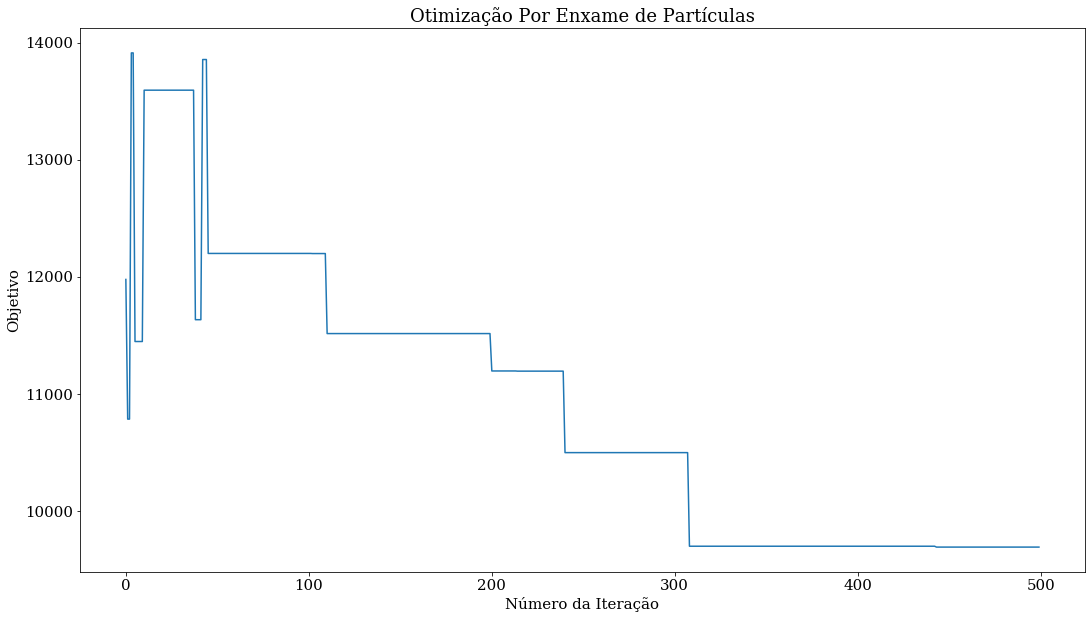

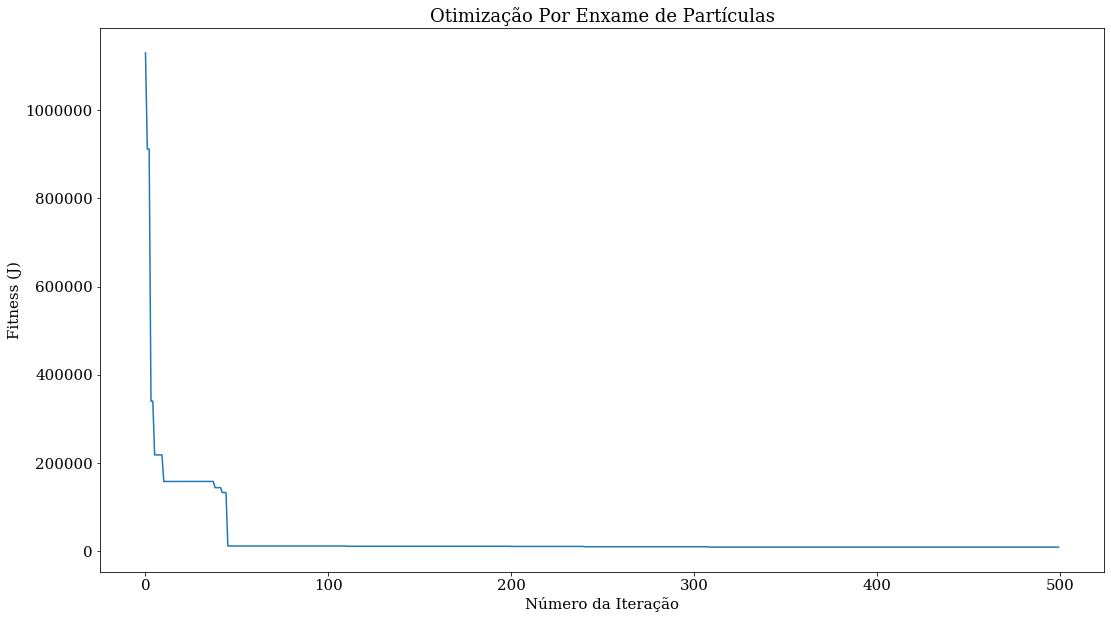

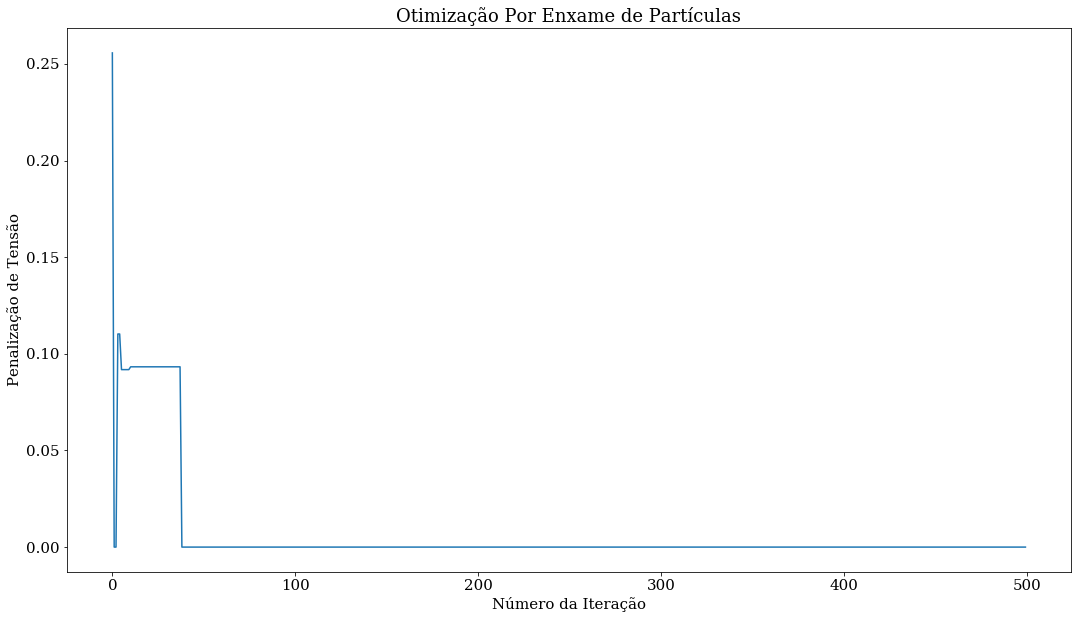

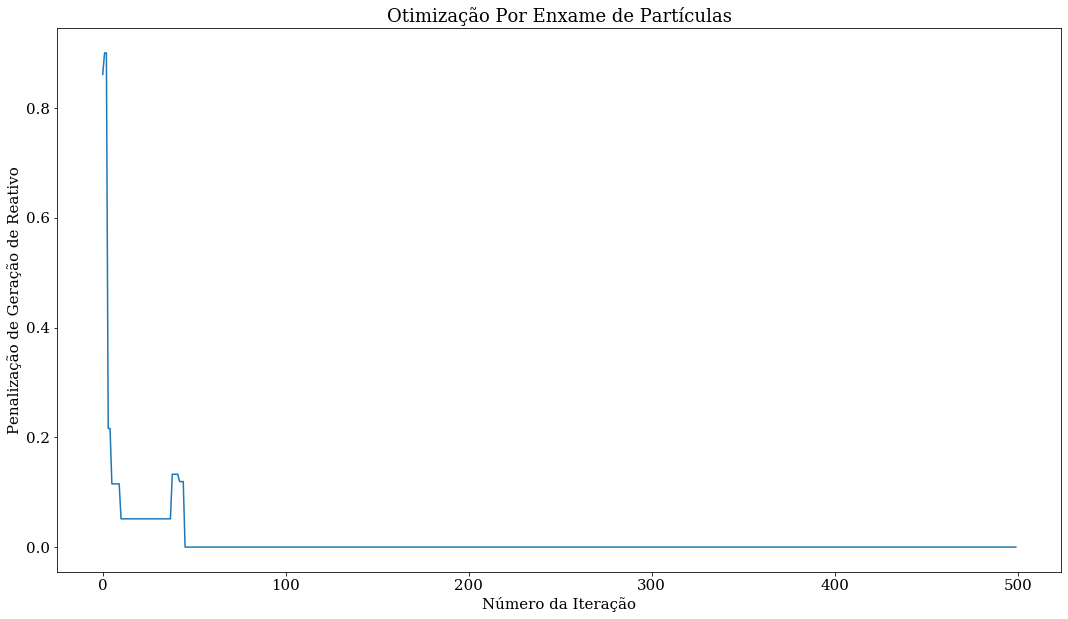

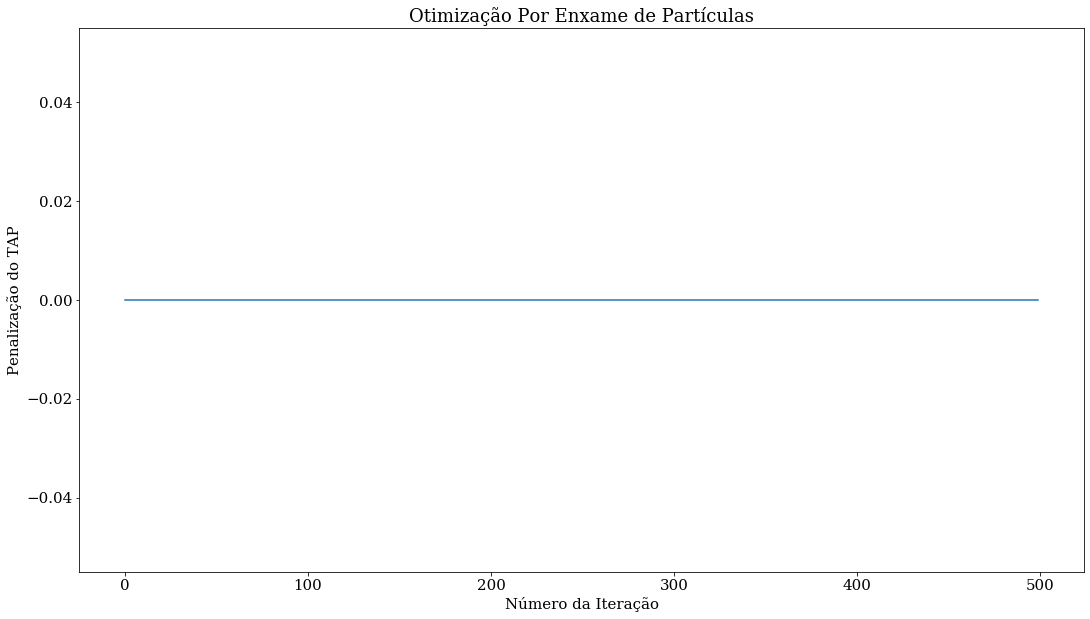

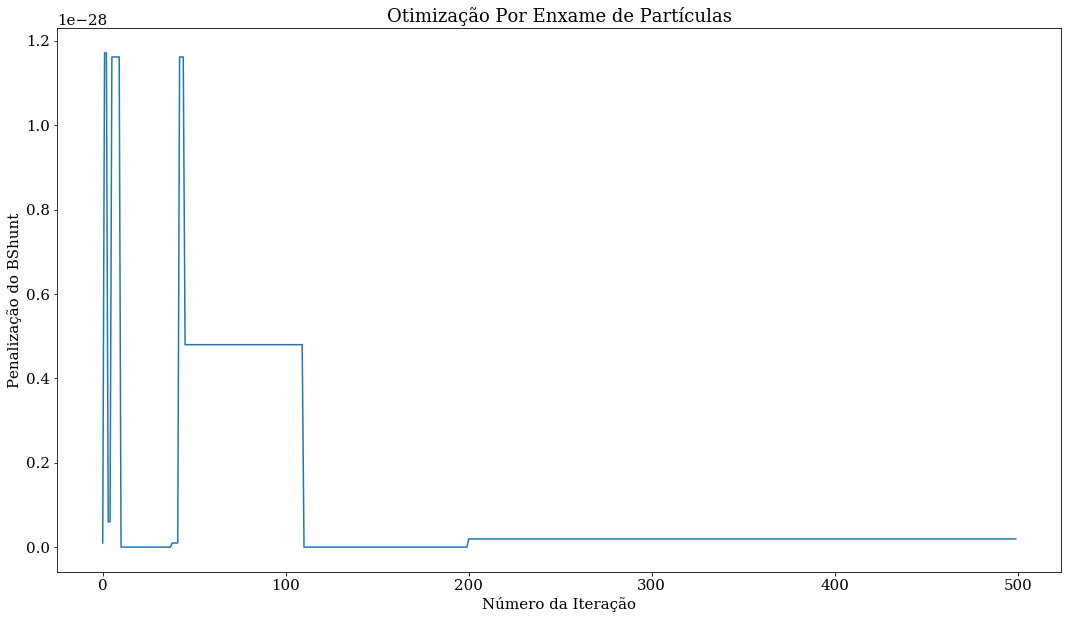

In [60]:
otimizacao_ed_discreto_fpo(sep_30, F = 1, CR=0.4, zeta=1e6, psi=1e6, sigma=0, omega=0, neta=1e6, max_iter=500, n_particles=40, relatorio=True,inicial=True)